In [9]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.optimize import curve_fit

from typing import Literal, Union

from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

from qs_mps.utils import create_sequential_colors, get_cx, get_cy
from qs_mps.applications.Z2.utils import find_closest_value, weighted_average
from qs_mps.applications.Z2.relevant_observables import (
                                                         n_order_kink_mass_varying_g,
                                                         n_order_kink_mass_varying_R,
                                                         get_fit_params,
                                                         get_exact_potential_chis,
                                                         potential_first_discrete_derivative_varying_g,
                                                             potential_first_discrete_derivative,
                                                         string_width_chis,
                                                         string_width_varying_g,
                                                         string_width_varying_R,
                                                         entropy,
                                                         time_entropy,
                                                         time_ev_string_width_occupation,
                                                         static_potential_chis, 
                                                         fitting,
                                                         fit_params_sys
                                                        )

plt.rcParams.update({
    'font.family': 'serif', 
    'font.size': 14,
    'text.usetex': False,
    'legend.handlelength': 1.5,
    'legend.handletextpad': 0.5,
    'legend.title_fontsize': 12,
    'legend.fontsize': 10,
    'axes.unicode_minus': True
})

model = "Z2_dual"
bc = "pbc"
cx = None
cy = None
sector = "2_particle(s)_sector"
Ls = [30]
L = 30

# take the path and precision to save files
# if we want to save the tensors we save them locally because they occupy a lot of memory
path = "add_your_path_to_save_data"
path = "/Users/fradm/Desktop/vanilla_data"
path = "C:/Users/HP/Desktop/vanilla_data"
path = "C:/Users/HP/Desktop/projects/1_Z2"
path = "/Users/fradm/Desktop/projects/1_Z2"
path_figures = "add_you_path_to_save_figures"
path_figures = "G:/My Drive/projects/1_Z2"
path_figures = "/Users/fradm/Google Drive/My Drive/projects/1_Z2"
# path_figures = "D:/code/projects/1_Z2"

colors = ["yellowgreen", "darkcyan", "firebrick", "darkorchid"]
colors = ["#60A7F3","#9E76AB","#DC4563"]
colors = ["#4688CE","#916799","#DC4563"]
colors = ["#4688CE","#9B4DB7","#DC4563"]
# colors = ["#FC4778","#BB4BA2","#7A4ECB","#3952F5"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
step = 0.02
arr = np.arange(0.6,1.0+step, step)
arr, (1.0+step-0.6)/step, len(arr), np.linspace(0.6,1.0, len(arr))

(array([0.6 , 0.62, 0.64, 0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 ,
        0.82, 0.84, 0.86, 0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 21.0,
 21,
 array([0.6 , 0.62, 0.64, 0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 ,
        0.82, 0.84, 0.86, 0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]))

## Potential

In [112]:
def plot_gamma(gs,Rs,l,chis,h_i,h_f,npoints,path,color,fit=3,param=1, label=None):
    gammas, gammas_err = get_fit_params(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path, fit=fit, param=param)
    if label is not None:
        plt.plot(gs, -np.asarray(gammas), marker='', markersize=5, color=color, linestyle="-", linewidth=1, label=label)
    else:
        plt.plot(gs, -np.asarray(gammas), marker='', markersize=5, color=color, linestyle="-", linewidth=1, label=f"$l: {l}$")
    plt.fill_between(gs, y1=-np.asarray(gammas)-np.asarray(gammas_err),y2=-np.asarray(gammas)+np.asarray(gammas_err), color=color, alpha=0.4)

def plot_sigma(gs,Rs,l,chis,h_i,h_f,npoints,path,color,fit=3,param=0):
    sigmas, sigmas_err = get_fit_params(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path, fit=fit, param=param)
    plt.plot(gs, np.asarray(sigmas), marker='', markersize=5, color=color, linestyle="-", linewidth=1, label=f"$l: {l}$")
    plt.fill_between(gs, y1=np.asarray(sigmas)-np.asarray(sigmas_err),y2=np.asarray(sigmas)+np.asarray(sigmas_err), color=color, alpha=0.4)

def plot_delta(gs,Rs,l,chis,h_i,h_f,npoints,path,color,fit=3,param=2):
    sigmas, sigmas_err = get_fit_params(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path, fit=fit, param=0)
    deltas, deltas_err = get_fit_params(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path, fit=fit, param=param)
    obs = - np.asarray(deltas)*np.asarray(sigmas)
    obs_err = np.sqrt((np.asarray(deltas)*np.asarray(sigmas_err))**2 + (np.asarray(sigmas)*np.asarray(deltas_err))**2)
    plt.plot(gs, obs, marker='', markersize=5, color=color, linestyle="-", linewidth=1, label=f"$l: {l}$")
    plt.fill_between(gs, y1=obs-obs_err,y2=obs+obs_err, color=color, alpha=0.4)


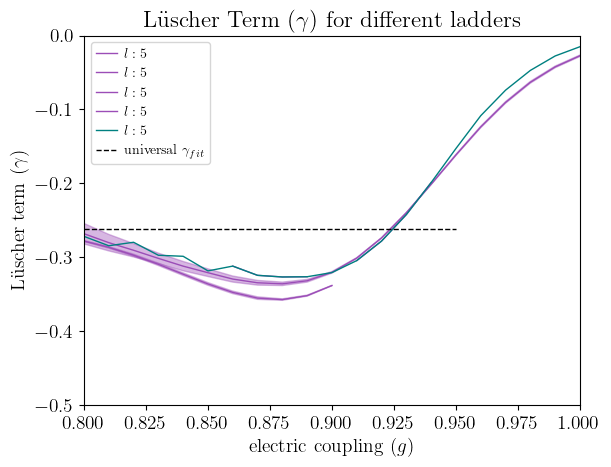

In [120]:
# h_i, h_f, npoints = 0.6, 0.8, 30
# gs = np.linspace(h_i,h_f,npoints)
# chis = [32,64,128]
# Rss = [10,12,14,16,18,20,22,24]
fit = 3

# Ls = [30]
# h_i, h_f, npoints = 0.6, 0.95, 15
# gs = np.linspace(h_i,h_f,npoints)
# chis = [32,64,128,256]
# Rs = [7,8,9,10,11,12,13,14,15,16,17,19,21]
# l = 6

# plot_gamma(gs,Rs,l,chis,h_i,h_f,npoints,path,colors[2], fit=fit)


h_i, h_f, npoints = 0.6, 0.9, 31
gs = np.linspace(h_i,h_f,npoints)
chis = [32,64,128,256]
Rs = [7,8,9,10,11,13,15,17,19,21]
l, Ls = 5, [30]

plot_gamma(gs,Rs,l,chis,h_i,h_f,npoints,path,colors[1], fit=fit)


h_i, h_f, npoints = 0.4, 1.0, 61
gs = np.linspace(h_i,h_f,npoints)
chis = [64,128]
Rs = [18,20,22,24]
l, Ls = 5, [30]

plot_gamma(gs,Rs,l,chis,h_i,h_f,npoints,path,colors[1], fit=1)

h_i, h_f, npoints = 0.86, 0.89, 4
gs = np.linspace(h_i,h_f,npoints)
chis = [64,128]
Rs = [25,26,27,28,29,30]
l, Ls = 5, [50]

plot_gamma(gs,Rs,l,chis,h_i,h_f,npoints,path,colors[1], fit=fit)


h_i, h_f, npoints = 0.91, 0.94, 4
gs = np.linspace(h_i,h_f,npoints)
chis = [64,128]
Rs = [25,26,27,28,29,30]
l, Ls = 5, [50]

plot_gamma(gs,Rs,l,chis,h_i,h_f,npoints,path,colors[1], fit=fit)


h_i, h_f, npoints = 0.8, 1.0, 21
# h_i, h_f, npoints = 0.7, 1.0, 16
gs = np.linspace(h_i,h_f,npoints)
chis = [64,128]
# chis = [192,256]
Rs = [25,26,27,28,29,30]
# Rs = [45,46,47,48,49,50]
l, Ls = 5, [50]
# l, Ls = 5, [70]

plot_gamma(gs,Rs,l,chis,h_i,h_f,npoints,path,"teal", fit=fit)

# Ls = [30]

# h_i, h_f, npoints = 0.6, 0.9, 31
# gs = np.linspace(h_i,h_f,npoints)
# chis = [32,64,128,256]
# Rs = [7,8,9,10,11,12,14,16,18,20,22]
# l = 4

# plot_gamma(gs,Rs,l,chis,h_i,h_f,npoints,path,colors[0])



# plt.hlines(y=-np.pi/24, xmin=gs[0], xmax=gs[-1], linestyles="-.", colors='red', linestyle="--", linewidth=1, label="$\\gamma_{th}$, $d=3$")
plt.hlines(y=-2*np.pi/24, xmin=gs[0], xmax=0.95, linestyles="--", colors='black', linewidth=1, label="universal $\\gamma_{fit}$")
# plt.grid(True)
# plt.ylim((-0.4,-0.2))
# plt.ylim((-1,0))
plt.ylim((-0.5,0))
plt.xlim((0.8,1.0))
plt.title("Lüscher Term $(\\gamma)$ for different ladders")
plt.xlabel("electric coupling $(g)$")
plt.ylabel("Lüscher term $(\\gamma)$")
plt.legend()
plt.savefig(f"{path_figures}/figures/fluxtube/luscher_term_fit_ord_{fit}_vs_ladders_{[4,5,6]}_best_Rs_bc_{bc}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chis[-1]}.png")


[12, 14, 16, 18, 20]
Weighted Average: -1.469789407355543
Error in the Average: 0.5842169730075109
Weighted Average: -1.202089364821623
Error in the Average: 0.5349019911459592
Weighted Average: -0.7280618912760997
Error in the Average: 0.42403339521371053
Weighted Average: -0.25280259103011876
Error in the Average: 0.3033012374410141
Weighted Average: 0.15288008704330647
Error in the Average: 0.208860109956243
Weighted Average: 0.5006582268133324
Error in the Average: 0.14254577201730712
Weighted Average: 0.7941274605237796
Error in the Average: 0.08821888793355903
Weighted Average: 0.9975369996235753
Error in the Average: 0.03503006272885868
Weighted Average: 1.0628155224062978
Error in the Average: 0.015986516117218706
Weighted Average: 0.984596897093053
Error in the Average: 0.03903268526266254
Weighted Average: 0.8214914273355044
Error in the Average: 0.038436021276297354
Weighted Average: 0.6514350592077318
Error in the Average: 0.025527177626383665
Weighted Average: 0.5192952148

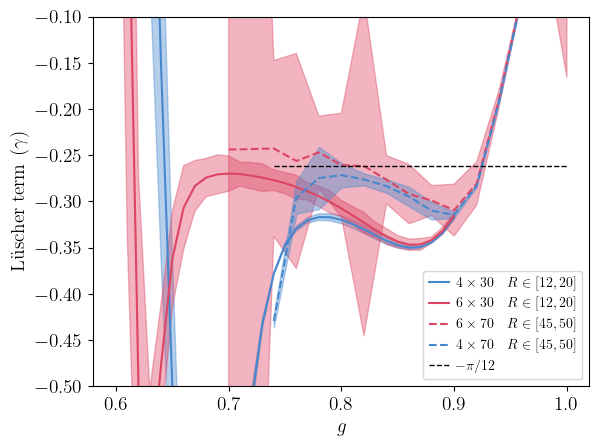

In [121]:
h_i, h_f, npoints = 0.6, 0.9, 31
gs = np.linspace(h_i,h_f,npoints)
chis = [32,64,128,256]
Rs = [7,8,9,10,11,13,15,17,19,21]
N, L = 5, 30

h_i, h_f, npoints = 0.6, 0.9, 31
gs = np.linspace(h_i,h_f,npoints)
chis = [32,64,128,256]
Rs = [7,8,9,10,11,12,14,16,18,20,22]
Rs = [12,14,16,18,20]
N, L = 4, 30
cy = [0,0]
clr = ["firebrick","teal"]

obs, obs_err = fit_params_sys(Rs,N,L,chis,bc,sector,h_i,h_f,npoints,path,cx,cy,param=1,fit=1)
Rs = [7,8,9,10,11,13,15,17,19,21]
Rs = [7,8,9,10,11,12,14,16,18,20,22]
Rs = [12,14,16,18,20]

plt.plot(gs,-np.asarray(obs), colors[0], label=f"${N} \\times {L} \\quad R \\in [{Rs[0]},{Rs[-1]}]$")
plt.fill_between(gs, -np.asarray(obs)+np.asarray(obs_err), -np.asarray(obs)-np.asarray(obs_err), color=colors[0], alpha=0.4)


h_i, h_f, npoints = 0.8, 1.0, 21
gs = np.linspace(h_i,h_f,npoints)
chis = [64,128]
Rs = [25,26,27,28,29,30]
N, L = 5, 50
cy = [0,1]

# h_i, h_f, npoints = 0.6, 1.0, 9
# gs = np.linspace(h_i,h_f,npoints)
# chis = [64,96,128]
# Rs = [30,35,40,45,50]
# N, L = 4, 70

h_i, h_f, npoints = 0.4, 0.6, 21
h_i, h_f, npoints = 0.6, 0.9, 31
gs = np.linspace(h_i,h_f,npoints)
chis = [64,128]
Rs = [25,26,27,28,29,30]
Rs = [12,14,16,18,20]
N, L = 6, 30
cy = [0,0]

# h_i, h_f, npoints = 0.6, 1.0, 9
# gs = np.linspace(h_i,h_f,npoints)
# chis = [64,96,128,192]
# Rs = [30,35,40,45,50]
# N, L = 4, 70
# cy = [0,1]

obs, obs_err = fit_params_sys(Rs,N,L,chis,bc,sector,h_i,h_f,npoints,path,cx,cy,param=1,fit=1)
Rs = [25,26,27,28,29,30]
Rs = [30,35,40,45,50]
Rs = [15,16,17,18,19,20]
Rs = [12,14,16,18,20]
plt.plot(gs,-np.asarray(obs), colors[2], label=f"${N} \\times {L} \\quad R \\in [{Rs[0]},{Rs[-1]}]$")
plt.fill_between(gs, -np.asarray(obs)+np.asarray(obs_err), -np.asarray(obs)-np.asarray(obs_err), color=colors[2], alpha=0.4)

h_i, h_f, npoints = 0.7, 1.0, 16
# h_i, h_f, npoints = 0.70, 0.9, 11
gs = np.linspace(h_i,h_f,npoints)
chis = [100,200,300]
# chis = [192,256]
Rs = [45,46,47,48,49,50]
N, L = 6, 70
cy = [0,0]

obs, obs_err = fit_params_sys(Rs,N,L,chis,bc,sector,h_i,h_f,npoints,path,cx,cy,param=1,fit=2)
Rs = [25,26,27,28,29,30]
Rs = [45,46,47,48,49,50]
# Rs = [30,35,40,45,50]
plt.plot(gs,-np.asarray(obs), colors[2],  linestyle='--', label=f"${N} \\times {L} \\quad R \\in [{Rs[0]},{Rs[-1]}]$")
plt.fill_between(gs, -np.asarray(obs)+np.asarray(obs_err), -np.asarray(obs)-np.asarray(obs_err), color=colors[2], alpha=0.4)


h_i, h_f, npoints = 0.6, 1.0, 9
h_i, h_f, npoints = 0.74, 1.0, 14
gs = np.linspace(h_i,h_f,npoints)
chis = [96,128,192]
Rs = [30,35,40,45,50]
Rs = [50,51,52,53,54,55]
Rs = [45,46,47,48,49,50]
N, L = 4, 70
# cy = [0,1]

obs, obs_err = fit_params_sys(Rs,N,L,chis,bc,sector,h_i,h_f,npoints,path,cx,cy,param=1,fit=1)
Rs = [25,26,27,28,29,30]
Rs = [30,35,40,45,50]
Rs = [45,46,47,48,49,50]
plt.plot(gs,-np.asarray(obs), colors[0], linestyle='--', label=f"${N} \\times {L} \\quad R \\in [{Rs[0]},{Rs[-1]}]$")
plt.fill_between(gs, -np.asarray(obs)+np.asarray(obs_err), -np.asarray(obs)-np.asarray(obs_err), color=colors[0], alpha=0.4)

# plt.hlines(y=-np.pi/24, xmin=gs[0], xmax=gs[-1], linestyles="-.", colors='red', linestyle="--", linewidth=1, label="$\\gamma_{th}$, $d=3$")
plt.hlines(y=-2*np.pi/24, xmin=gs[0], xmax=1, linestyles="--", colors='black', linewidth=1, label="$-\\pi/12$")
# plt.hlines(y=2*np.pi/24, xmin=gs[0], xmax=1, linestyles="--", colors='black', linewidth=1, label="$\\pi/12$")
# plt.grid(True)
# plt.ylim((-0.4,-0.2))
plt.ylim((-0.5,-0.1))
# plt.ylim((-1,0))
# plt.xlim((0.6,1.0))
plt.xlabel(r"$g$")
plt.ylabel("Lüscher term $(\\gamma)$")
plt.legend()
plt.savefig(f"{path_figures}/figures/fluxtube/luscher_term_vs_different_Rs_N_4-6_L_30-70_bc_{bc}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chis[-1]}_zoom.png")

In [ ]:
fit = 3

h_i, h_f, npoints = 0.6, 0.95, 15
gs = np.linspace(h_i,h_f,npoints)
chis = [32,64,128,256]
Rs = [7,8,9,10,11,12,13,14,15,16,17,19,21]
l = 6

plot_sigma(gs,Rs,l,chis,h_i,h_f,npoints,path,colors[0])


h_i, h_f, npoints = 0.6, 0.9, 31
gs = np.linspace(h_i,h_f,npoints)
chis = [32,64,128,256]
Rs = [7,8,9,10,11,13,15,17,19,21]
l = 5

plot_sigma(gs,Rs,l,chis,h_i,h_f,npoints,path,colors[1])


Rs = [7,8,9,10,11,12,14,16,18,20,22]
l = 4

plot_sigma(gs,Rs,l,chis,h_i,h_f,npoints,path,colors[2])



x = np.linspace(0.7,1)
plt.plot(x,2*x, linestyle="--", color="black", label="$2g$ confined limit")
# plt.grid(True)
# plt.ylim((-0.4,-0.2))
plt.title("Lüscher Term $(\\gamma)$ for different ladders")
plt.xlabel("electric coupling $(g)$")
plt.ylabel("String tension $(\sigma)$")
plt.legend()
plt.savefig(f"{path_figures}/figures/fluxtube/string_tension_fit_ord_{fit}_vs_ladders_{[4,5,6]}_best_Rs_bc_{bc}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chis[-1]}.png")

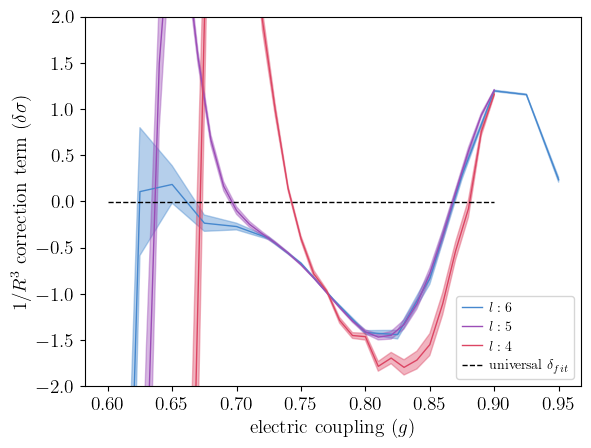

In [27]:
fit = 3
cy = None

h_i, h_f, npoints = 0.6, 0.95, 15
gs = np.linspace(h_i,h_f,npoints)
chis = [32,64,128,256]
Rs = [7,8,9,10,11,12,13,14,15,16,17,19,21]
l = 6
Ls = [30]

plot_delta(gs,Rs,l,chis,h_i,h_f,npoints,path,colors[0])


h_i, h_f, npoints = 0.6, 0.9, 31
gs = np.linspace(h_i,h_f,npoints)
chis = [32,64,128,256]
Rs = [7,8,9,10,11,13,15,17,19,21]
l = 5

plot_delta(gs,Rs,l,chis,h_i,h_f,npoints,path,colors[1])



chis = [64,128]
Rs = [7,8,9,10,11,12,14,16,18,20,22]
l = 4

# h_i, h_f, npoints = 0.6, 1.0, 9
# gs = np.linspace(h_i,h_f,npoints)
# Ls = [70]
# Rs = [30,35,40,45,50]

plot_delta(gs,Rs,l,chis,h_i,h_f,npoints,path,colors[2])

plt.hlines(y=-(np.pi**2)/1152, xmin=gs[0], xmax=gs[-1], linestyles="--", colors='black', linewidth=1, label="universal $\\delta_{fit}$")

# plt.grid(True)
plt.ylim(-2,2)
plt.xlabel("electric coupling $(g)$")
plt.ylabel("$1/R^3$ correction term $(\\delta\\sigma)$")
plt.legend()
plt.savefig(f"{path_figures}/figures/fluxtube/second_potential_correction_fit_ord_{fit}_vs_ladders_{[4,5,6]}_best_Rs_bc_{bc}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chis[-1]}.png")

In [160]:
from qs_mps.applications.Z2.relevant_observables import static_potential_chis

h_i, h_f, npoints = 0.6, 1.0, 21
gs = np.linspace(h_i,h_f,npoints)
g = 0.7
chis = [128,192]
Rs = [45,46,47,48,49,50]
N, L = 4, 70
R = 45

pots = static_potential_chis(g, R, N, L, chis, bc, sector, h_i, h_f, npoints, path)
print(pots)

h_i, h_f, npoints = 0.7, 1.0, 16
gs = np.linspace(h_i,h_f,npoints)
chis = [192,256]
Rs = [45,46,47,48,49,50]
N, L = 5, 70

pots = static_potential_chis(g, R, N, L, chis, bc, sector, h_i, h_f, npoints, path)
print(pots)

h_i, h_f, npoints = 0.7, 1.0, 16
gs = np.linspace(h_i,h_f,npoints)
chis = [200,300]
Rs = [45,46,47,48,49,50]
N, L = 6, 70

pots = static_potential_chis(g, R, N, L, chis, bc, sector, h_i, h_f, npoints, path)
print(pots)

[24.934225327916465, 24.93422164491551]
[25.338354357884327, 25.33833042387016]
[25.55942373738651, 25.55932771685559]


In [134]:
R = 45
L = 70
cx = get_cx(L,R)
cy = [0,0]

h_i, h_f, npoints = 0.6, 1.0, 21
chi = 192
N = 4

vac = np.nan
energy_charges = np.load(
    f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{N}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
)
energy_vacuum = np.load(
    f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{N}x{L}_vacuum_sector_bc_{bc}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
)
print(energy_charges[-1], energy_vacuum[-1], energy_charges[-1] - energy_vacuum[-1])

h_i, h_f, npoints = 0.7, 1.0, 16
chi = 256
N = 5

vac = np.nan
energy_charges = np.load(
    f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{N}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
)
energy_vacuum = np.load(
    f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{N}x{L}_vacuum_sector_bc_{bc}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
)
print(energy_charges[-1], energy_vacuum[-1], energy_charges[-1] - energy_vacuum[-1])

h_i, h_f, npoints = 0.7, 1.0, 16
chi = 300
N = 6

vac = np.nan
energy_charges = np.load(
    f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{N}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
)
energy_vacuum = np.load(
    f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{N}x{L}_vacuum_sector_bc_{bc}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
)
print(energy_charges[-1], energy_vacuum[-1], energy_charges[-1] - energy_vacuum[-1])

-521.9742125922083 -599.179903891694 77.2056912994857
-671.7685264983568 -748.9222688660018 77.15374236764501
-821.563469434839 -898.7697947540149 77.2063253191759


## String Width

<>:50: SyntaxWarning: invalid escape sequence '\i'
<>:50: SyntaxWarning: invalid escape sequence '\i'
C:\Users\HP\AppData\Local\Temp\ipykernel_25624\115216603.py:50: SyntaxWarning: invalid escape sequence '\i'
  plt.title(f"String width - bc: ${bc}$, $R \in [{Rs[0]},{Rs[-1]}]$")


g: 0.6
g: 0.625
g: 0.65
g: 0.6749999999999999
g: 0.7
g: 0.725
g: 0.75
g: 0.7749999999999999
g: 0.7999999999999999
g: 0.825
g: 0.85
g: 0.875
g: 0.8999999999999999
g: 0.9249999999999999
g: 0.95
g: 0.6
g: 0.625
g: 0.65
g: 0.6749999999999999
g: 0.7
g: 0.725
g: 0.75
g: 0.7749999999999999
g: 0.7999999999999999
g: 0.825
g: 0.85
g: 0.875
g: 0.8999999999999999
g: 0.9249999999999999
g: 0.95
g: 0.6
g: 0.625
g: 0.65
g: 0.6749999999999999
g: 0.7
g: 0.725
g: 0.75
g: 0.7749999999999999
g: 0.7999999999999999
g: 0.825
g: 0.85
g: 0.875
g: 0.8999999999999999
g: 0.9249999999999999
g: 0.95
g: 0.4
g: 0.54375
g: 0.6875
g: 0.83125
g: 0.975
g: 1.11875
g: 1.2625
g: 1.40625
g: 1.5499999999999998
g: 1.69375
g: 1.8375
g: 1.9812499999999997
g: 2.125
g: 2.26875
g: 2.4124999999999996
g: 2.55625
g: 2.6999999999999997
g: 2.8437499999999996
g: 2.9875
g: 3.1312499999999996
g: 3.275
g: 3.4187499999999997
g: 3.5624999999999996
g: 3.70625
g: 3.8499999999999996
g: 3.9937499999999995
g: 4.1375
g: 4.28125
g: 4.425
g: 4.56875
g

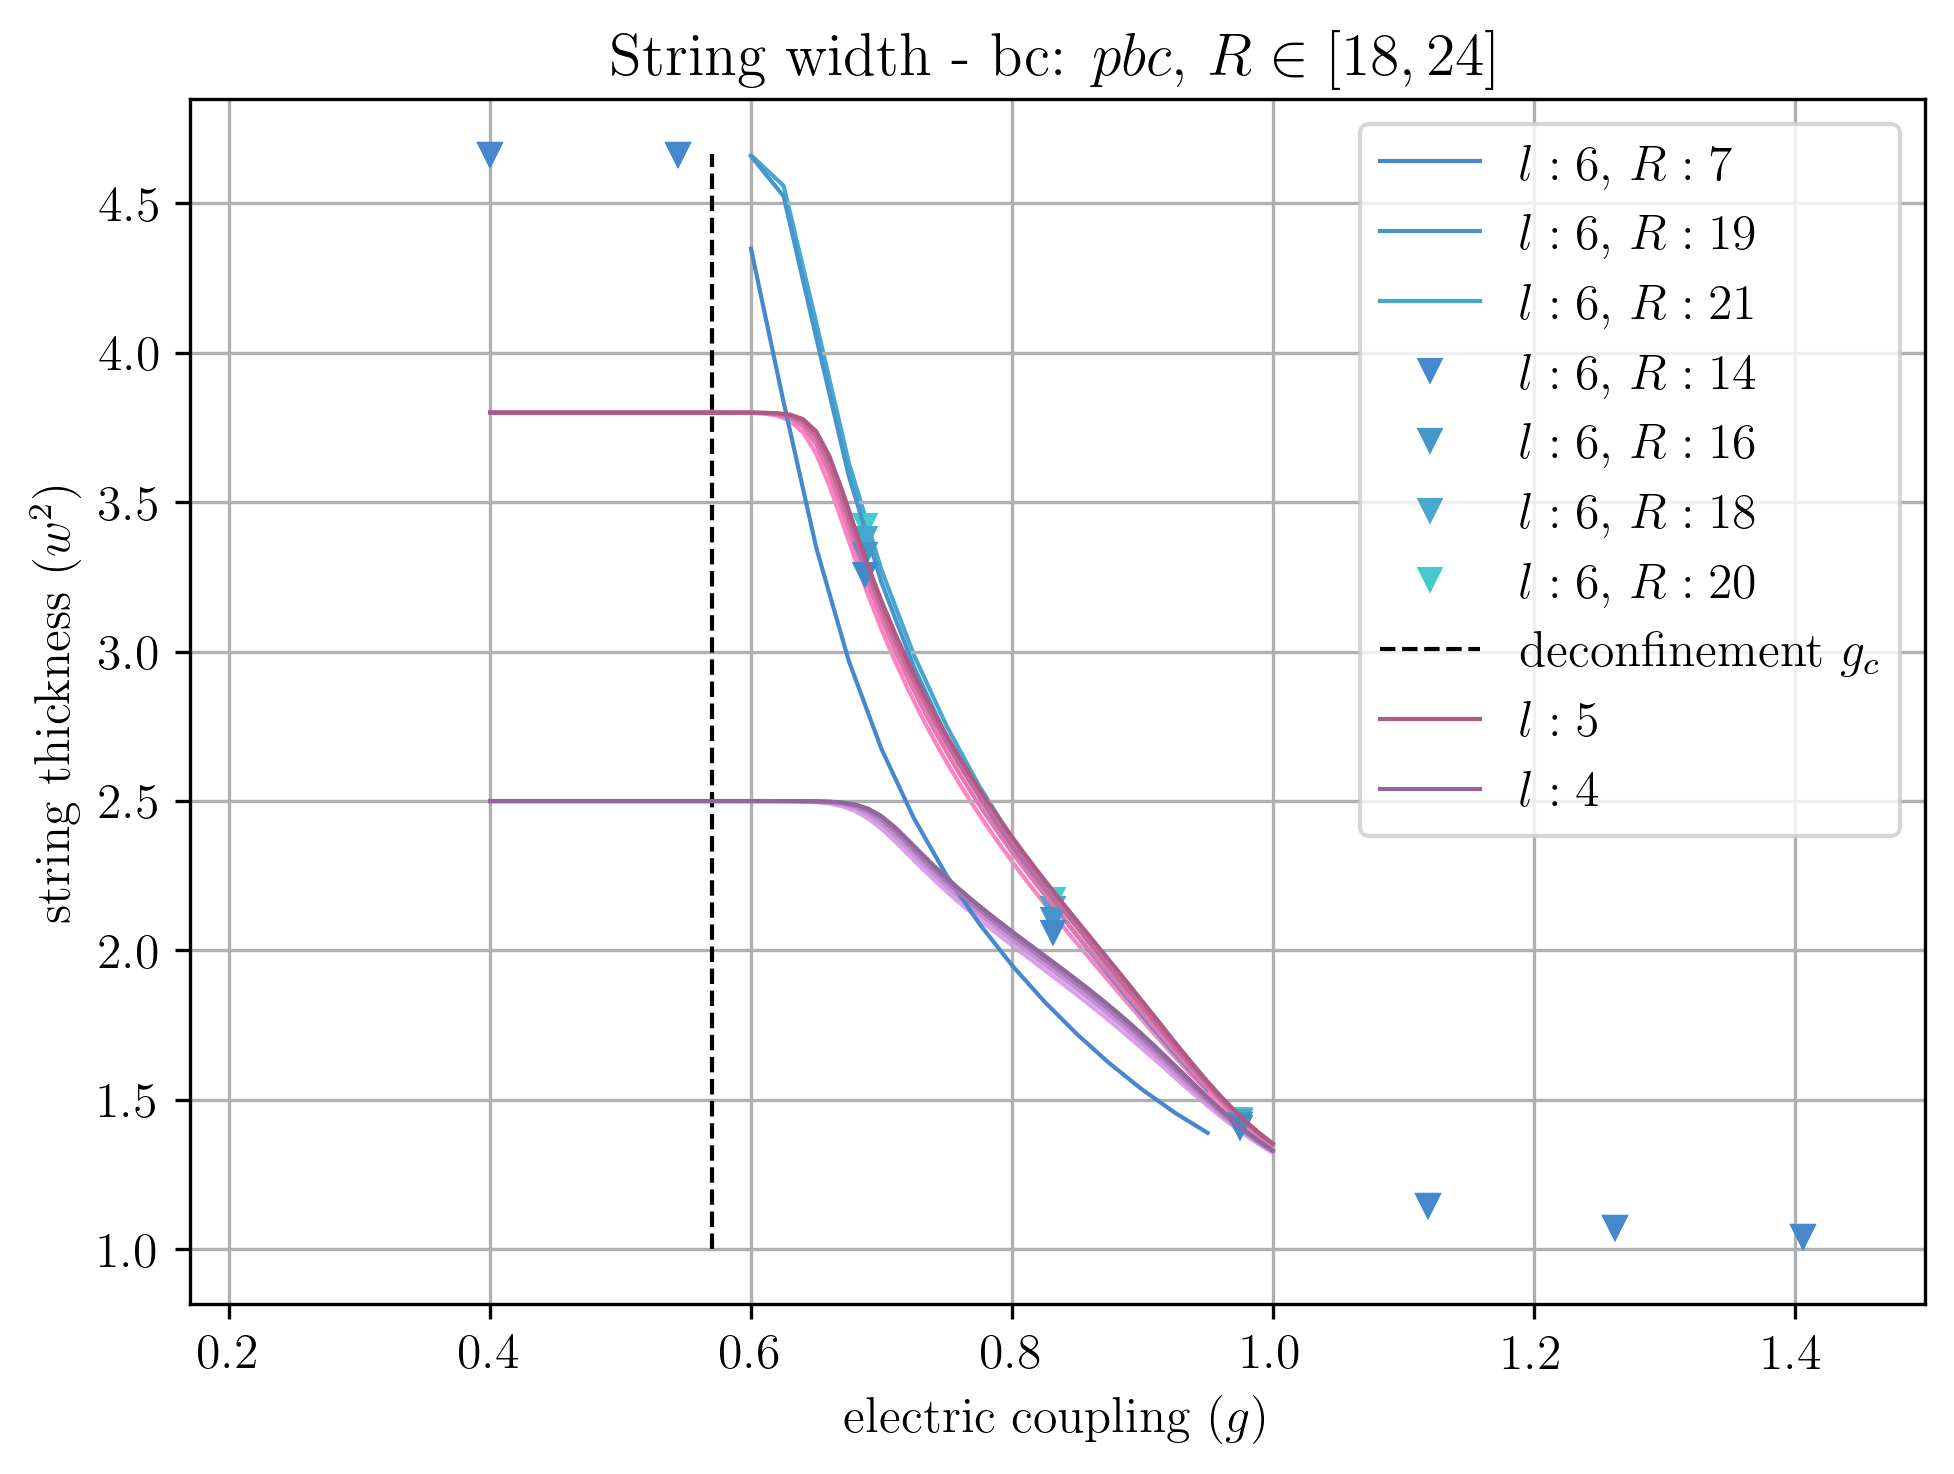

In [19]:
colors = ["#4688CE","#4696CE","#46A8CE","#46CACF"]
Rs = [19,21,23]
Rs.reverse()
h_i, h_f, npoints = 0.6, 0.95, 15
gs = np.linspace(h_i,h_f,npoints)
bc = "pbc"
sector = "2_particle(s)_sector"
l = 6
L = 30
Ls = [30]
chis = [64,128]
Rs = [7,19,21]

for i, R in enumerate(Rs):
    ws, err_ws = string_width_varying_g(gs,R,l,L,chis,bc,sector,h_i,h_f,npoints,path)
    plt.plot(gs, ws, markersize=5, color=colors[i], linestyle="-", linewidth=1, label=f"$l: {l}$, $R: {R}$", zorder=len(Rs)-i)
    # plt.fill_between(gs, y1=np.asarray(ws)+np.asarray(err_ws),y2=np.asarray(ws)-np.asarray(err_ws), color=colors[i], alpha=0.4)

h_i, h_f, npoints = 0.4, 5.0, 33
gs = np.linspace(h_i,h_f,npoints)
chis = [32,64,128]
Rs = [14,16,18,20]
l = 6
for i, R in enumerate(Rs):
    ws, err_ws = string_width_varying_g(gs,R,l,L,chis,bc,sector,h_i,h_f,npoints,path)
    plt.plot(gs, ws, marker='v', markersize=5, color=colors[i], linestyle="", linewidth=0, label=f"$l: {l}$, $R: {R}$", zorder=len(Rs)-i)
    # plt.fill_between(gs, y1=np.asarray(ws)+np.asarray(err_ws),y2=np.asarray(ws)-np.asarray(err_ws), color=colors[i+j+1], alpha=0.4)

plt.vlines(x=0.57, ymin=1, ymax=max(ws), linestyles="--", colors='black', linewidth=1, label="deconfinement $g_c$")

chis = [32,64]
Rs = [18,20,22,24]
Rs.reverse()
# colorss = [["#4688CE","#4696CE","#46A8CE","#46CACF"],["#9B4DB7","#BC4FBE","#CC50C2","#DC51C5"],["#DC4563","#E45A70","#ED7580","#F68F8F"]]
colorss = [["#AD5A85","#C86799","#E575AF","#FF82C3"],["#90679A","#A979B5","#C78FD5","#DD9FEC"],["#DC4563","#E45A70","#ED7580","#F68F8F"]]
ls = [5,4]
h_i, h_f, npoints = 0.4, 1.0, 61
gs = np.linspace(h_i,h_f,npoints)
for colors, l in zip(colorss, ls):
    for i, R in enumerate(Rs):
        ws, err_ws = string_width_varying_g(gs,R,l,L,chis,bc,sector,h_i,h_f,npoints,path)
        if R == 24:
            label = f"$l: {l}$"
        else: 
            label = None
        plt.plot(gs, ws, markersize=2, color=colors[i], linestyle="-", linewidth=1, label=label, zorder=len(Rs)-i)
        # plt.fill_between(gs, y1=np.asarray(ws)+np.asarray(err_ws),y2=np.asarray(ws)-np.asarray(err_ws), color=colors[i], alpha=0.4, zorder=len(Rs)-i)

Rs.reverse()
plt.title(f"String width - bc: ${bc}$, $R \in [{Rs[0]},{Rs[-1]}]$")
plt.xlabel("electric coupling $(g)$")
plt.ylabel("string thickness $(w^2)$")
plt.grid(True)
# plt.xscale("log")
plt.xlim(right=1.5)
plt.legend()

## String width occupation

[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
N = 4, Rmax = 50
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]

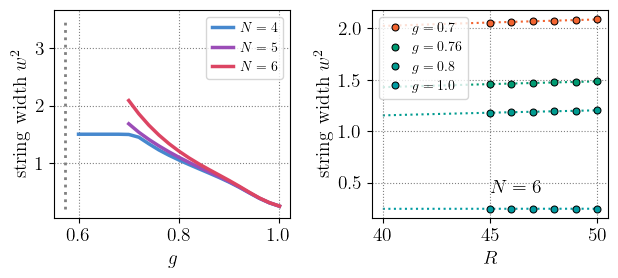

In [ ]:
marker_opts = dict(
    marker='o',
    markeredgecolor='k',
    markeredgewidth=0.75,
    markersize=5,
    linestyle='',
)

theor_gc = 1 / np.sqrt(3.04438)
theor_gc
R_max = [20,20,20]

Rs = [10,12,14,16,18,20]
h_i, h_f, npoints = 0.4, 1.0, 61
gs = np.linspace(h_i, h_f, npoints)
chis = [64,128]

R_max = [50,50,50]

Rs = [45,46,47,48,49,50]
L = 70

fig, axs = plt.subplots(1, 2, figsize=(6.4, 3))

for ax in axs:
    ax.grid(color="gray", linestyle=":")

colors = ["#4688CE","#9B4DB7","#DC4563"]

# String width vs coupling
i = 0
for N in [4, 5, 6]:
    Rmax = R_max[i]
    if N == 4:
        chis = [128,192]
        h_i, h_f, npoints = 0.6, 1.0, 21
    elif N == 5:
        chis = [192,256]
        h_i, h_f, npoints = 0.7, 1.0, 16
    elif N == 6:
        chis = [200,300]
        h_i, h_f, npoints = 0.7, 1.0, 16

    gs = np.linspace(h_i, h_f, npoints)
    string_width, string_width_err = string_width_varying_g(gs, Rmax, N, L, chis, bc, sector, h_i, h_f, npoints, path, occupation=True)
    print(f"N = {N}, Rmax = {Rmax}")
    axs[0].plot(gs, string_width, color=colors[i], label=f"$N = {N}$", linewidth=2.5)
    i += 1
axs[0].legend()
axs[0].set_xlabel("$g$")
axs[0].set_ylabel("string width $w^2$")
axs[0].vlines(theor_gc, 0.2, 3.5, 'grey', ':', linewidth=2)
# axs[0].set_ylim(1, 4)


colors = ["#F26430", "#009B72", "#009B90", "#009BA1", "#009DDC"]

# String width vs separation R
k = 0
coupls = [1.0, 0.9, 0.8, 0.7, 0.4]
coupls = [1.0, 0.8, 0.7, 0.4]
coupls = [1.0, 0.8, 0.75, 0.7, 0.4]
coupls = [1.0, 0.8, 0.76, 0.7]
coupls.reverse()

def log_fit(R, a, b):
    return a*np.log(R) + b

for g in coupls:
    string_width, string_width_err = string_width_varying_R(g, Rs, N, L, chis, bc, sector, h_i, h_f, npoints, path, occupation=True)
    axs[1].plot(Rs, string_width, color=colors[k], label=f"$g = {g}$", **marker_opts)
    
    plog, clog = curve_fit(log_fit, Rs, string_width)
    # x_fit = np.linspace(8,20)
    x_fit = np.linspace(40,50)
    axs[1].plot(x_fit, log_fit(x_fit,*plog), color=colors[k], linestyle=':', zorder=0)
    k += 1

axs[1].set_xlabel("$R$")
axs[1].set_ylabel("string width $w^2$")
axs[1].legend(loc="upper left")
# axs[1].text(16, 0.4, f"$N = {N}$")
axs[1].text(45, 0.4, f"$N = {N}$")

fig.tight_layout()
fig.savefig(f"{path_figures}/figures/fluxtube/string_width.pdf", bbox_inches='tight', format='pdf')

In [5]:
idxs = [gs.tolist().index(g) for g in coupls]
idxs

[0, 30, 35, 40, 60]

In [55]:
h_i, h_f, npoints = 0.4, 0.6, 21
gs = np.linspace(h_i,h_f,npoints)
sigmas, sigmas_err = get_fit_params(gs, Rs, N, Ls, chis, bc, sector, h_i, h_f, npoints, path, fit=1, param=0)
coupls = [0.4]
idxs = [gs.tolist().index(g) for g in coupls]
sigma_values1 = [sigmas[idx] for idx in idxs]

h_i, h_f, npoints = 0.6, 0.9, 31
gs = np.linspace(h_i,h_f,npoints)
sigmas, sigmas_err = get_fit_params(gs, Rs, N, Ls, chis, bc, sector, h_i, h_f, npoints, path, fit=1, param=0)
coupls = [0.7,0.75,0.8]
idxs = [gs.tolist().index(g) for g in coupls]
sigma_values2 = [sigmas[idx] for idx in idxs]

h_i, h_f, npoints = 0.9, 1.0,11
gs = np.linspace(h_i,h_f,npoints)
sigmas, sigmas_err = get_fit_params(gs, Rs, N, Ls, chis, bc, sector, h_i, h_f, npoints, path, fit=1, param=0)
coupls = [1.0]
idxs = [gs.tolist().index(g) for g in coupls]
sigma_values3 = [sigmas[idx] for idx in idxs]

sigma_values = sigma_values1 + sigma_values2 + sigma_values3

h_i, h_f, npoints = 0.4, 1.0, 61
coupls = [0.4,0.7,0.75,0.8,1.0]
data_by_sigma = []
for i, g in enumerate(coupls):
    print(g)
    w2, string_width_err = string_width_varying_R(g, Rs, N, L, chis, bc, sector, h_i, h_f, npoints, path, occupation=True)
    print(w2)
    data_by_sigma.append({f"{sigma_values[i]}": (np.array(Rs), np.array(w2))})
print(data_by_sigma)

0.4
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[3.1666492566327498, 3.166666061533759, 3.1666666742921667, 3.1666666777499746, 3.166666671492561, 3.166666688922086]
0.7
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[1.4813624060309072, 1.5673909673045985, 1.636170003055901, 1.6928904774627667, 1.7407076524200011, 1.78179221014417]
0.75
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2

In [ ]:
# ------------------------------
# ⚙️ CONFIGURATION
# ------------------------------
N, L = 6, 30
Ls = [L]
Rs = [10,12,14,16,18,20]
chis = [64,128]

D = 3  # dimensionality (e.g. 2+1 dimensions ⇒ D=3)

# Sample values of sigma and corresponding (R, w^2) data for each
h_i, h_f, npoints = 0.4, 0.6, 21
gs = np.linspace(h_i,h_f,npoints)
sigmas, sigmas_err = fit_params_sys(gs, Rs, N, Ls, chis, bc, sector, h_i, h_f, npoints, path, fit=1, param=0)
coupls = [0.4,0.45,0.5,0.55,0.6]
idxs = [find_closest_value(gs,g)[1] for g in coupls]
sigma_values1 = [sigmas[idx] for idx in idxs]

h_i, h_f, npoints = 0.6, 0.9, 31
gs = np.linspace(h_i,h_f,npoints)
sigmas, sigmas_err = fit_params_sys(gs, Rs, N, Ls, chis, bc, sector, h_i, h_f, npoints, path, fit=1, param=0)
coupls = [0.65,0.7,0.75,0.8,0.85,0.9]
idxs = [find_closest_value(gs,g)[1] for g in coupls]
sigma_values2 = [sigmas[idx] for idx in idxs]

h_i, h_f, npoints = 0.9, 1.0, 11
gs = np.linspace(h_i,h_f,npoints)
sigmas, sigmas_err = fit_params_sys(gs, Rs, N, Ls, chis, bc, sector, h_i, h_f, npoints, path, fit=1, param=0)
coupls = [0.95,1.0]
idxs = [find_closest_value(gs,g)[1] for g in coupls]
sigma_values3 = [sigmas[idx] for idx in idxs]

sigma_values = sigma_values1 + sigma_values2 + sigma_values3

h_i, h_f, npoints = 0.4, 1.0, 61
coupls = [0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0]
data_by_sigma = []
for i, g in enumerate(coupls):
    w2, string_width_err = string_width_varying_R(g, Rs, N, L, chis, bc, sector, h_i, h_f, npoints, path, occupation=True)
    data_by_sigma.append({f"{sigma_values[i]}": (np.array(Rs), np.array(w2))})
print(data_by_sigma)

N, L = 4, 70
Ls = [L]
Rs = [30,35,40,45,50]
chis = [64,96,128,192]

h_i, h_f, npoints = 0.6, 1.0, 9
gs = np.linspace(h_i,h_f,npoints)
sigma_values, sigmas_err = fit_params_sys(gs, Rs, N, Ls, chis, bc, sector, h_i, h_f, npoints, path, fit=1, param=0)
coupls = [0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0]

data_by_sigma = []
for i, g in enumerate(coupls):
    w2, string_width_err = string_width_varying_R(g, Rs, N, L, chis, bc, sector, h_i, h_f, npoints, path, occupation=True)
    data_by_sigma.append({f"{sigma_values[i]}": (np.array(Rs), np.array(w2))})
print(data_by_sigma)

# ------------------------------
# 📉 LOGARITHMIC FIT FUNCTION
# ------------------------------
def log_fit(R, A, B):
    return A * np.log(R) + B

# ------------------------------
# 📊 DATA STORAGE
# ------------------------------

tot_results = []

# for N, L, Rs, chis in zip([4,6], [70,30], [[30,35,40,45,50],[10,12,14,16,18,20]], [[64,96,128,192],[64,128]]):
#     Ls = [L]
#     if N == 4:
#         h_i, h_f, npoints = 0.6, 1.0, 9
#         gs = np.linspace(h_i,h_f,npoints)
#         sigma_values, sigmas_err = fit_params_sys(gs, Rs, N, Ls, chis, bc, sector, h_i, h_f, npoints, path, fit=1, param=0)
#         coupls = [0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0]

#         data_by_sigma = []
#         for i, g in enumerate(coupls):
#             w2, string_width_err = string_width_varying_R(g, Rs, N, L, chis, bc, sector, h_i, h_f, npoints, path, occupation=True)
#             data_by_sigma.append({f"{sigma_values[i]}": (np.array(Rs), np.array(w2))})

N, L = 6, 30
Ls = [L]
Rs = [10,12,14,16,18,20]
chis = [64,128]

for N in [4,5,6]:
    if N == 4 or N == 5:
        Rs = [18,20,22,24]
        h_i, h_f, npoints = 0.4, 1.0, 61
        gs = np.linspace(h_i,h_f,npoints)
        sigma_values, sigmas_err = fit_params_sys(gs, Rs, N, Ls, chis, bc, sector, h_i, h_f, npoints, path, fit=1, param=0)
        coupls = gs
        # coupls = [0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0]
        # idxs = [find_closest_value(gs,g)[1] for g in coupls]
        # sigma_values = [sigmas[idx] for idx in idxs]
        
        data_by_sigma = []
        for i, g in enumerate(coupls):
            w2, string_width_err = string_width_varying_R(g, Rs, N, L, chis, bc, sector, h_i, h_f, npoints, path, occupation=True)
            data_by_sigma.append({f"{sigma_values[i]}": (np.array(Rs), np.array(w2))})

    elif N == 6:
        # Rs = [10,12,14,16,18,20]
        # h_i, h_f, npoints = 0.4, 0.6, 21
        # gs = np.linspace(h_i,h_f,npoints)
        # sigma_values1, sigmas_err = fit_params_sys(gs, Rs, N, Ls, chis, bc, sector, h_i, h_f, npoints, path, fit=1, param=0)
        # # coupls = [0.4,0.45,0.5,0.55,0.6]
        # # idxs = [find_closest_value(gs,g)[1] for g in coupls]
        # # sigma_values1 = [sigmas[idx] for idx in idxs]

        # h_i, h_f, npoints = 0.6, 0.9, 31
        # gs = np.linspace(h_i,h_f,npoints)
        # sigma_values2, sigmas_err = fit_params_sys(gs, Rs, N, Ls, chis, bc, sector, h_i, h_f, npoints, path, fit=1, param=0)
        # # coupls = [0.65,0.7,0.75,0.8,0.85,0.9]
        # # idxs = [find_closest_value(gs,g)[1] for g in coupls]
        # # sigma_values2 = [sigmas[idx] for idx in idxs]

        # h_i, h_f, npoints = 0.9, 1.0, 11
        # gs = np.linspace(h_i,h_f,npoints)
        # sigma_values3, sigmas_err = fit_params_sys(gs, Rs, N, Ls, chis, bc, sector, h_i, h_f, npoints, path, fit=1, param=0)
        # # coupls = [0.95,1.0]
        # # idxs = [find_closest_value(gs,g)[1] for g in coupls]
        # # sigma_values3 = [sigmas[idx] for idx in idxs]

        # # sigma_values = sigma_values1 + sigma_values2 + sigma_values3
        # sigma_values = sigma_values1[:-1] + sigma_values2[:-1] + sigma_values3
        # print(len(sigma_values))
        
        
        h_i, h_f, npoints = 0.7, 1.0, 16
        L = 70
        Ls = [L]
        chis = [100,200]
        Rs = [45,46,47,48,49,50]
        gs = np.linspace(h_i,h_f,npoints)
        sigma_values, sigmas_err = fit_params_sys(gs, Rs, N, Ls, chis, bc, sector, h_i, h_f, npoints, path, fit=1, param=0)
        
        # h_i, h_f, npoints = 0.4, 1.0, 61
        h_i, h_f, npoints = 0.7, 1.0, 16
        # coupls = [0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0]
        gs = np.linspace(h_i,h_f,npoints)
        coupls = gs
        data_by_sigma = []
        for i, g in enumerate(coupls):
            w2, string_width_err = string_width_varying_R(g, Rs, N, L, chis, bc, sector, h_i, h_f, npoints, path, occupation=True)
            data_by_sigma.append({f"{sigma_values[i]}": (np.array(Rs), np.array(w2))})
    
    fit_results = []

    # ------------------------------
    # 🔁 FIT FOR EACH SIGMA
    # ------------------------------
    for i, sigma in enumerate(sigma_values):
        R, w2 = data_by_sigma[i][f"{sigma}"]
        
        # Fit to A * log(R) + B
        popt, pcov = curve_fit(log_fit, R, w2)
        A_fit, B_fit = popt
        A_err = np.sqrt(pcov[0, 0])
        
        # Theoretical value
        A_th = (D - 2) / (2 * np.pi * sigma)
        
        # Relative deviation (%)
        rel_dev = (A_fit - A_th) / A_th * 100
        
        fit_results.append({
            'sigma': sigma,
            'A_fit': A_fit,
            'A_err': A_err,
            'A_th': A_th,
            'rel_dev': rel_dev,
            'R': R,
            'w2': w2,
            'B_fit': B_fit,
            'g': coupls[i],
            'N': N,
            'L': L,
        })
    tot_results.append(fit_results)

we search for g=0.4
we search for g=0.45
we search for g=0.5
we search for g=0.55
we search for g=0.6
we search for g=0.65
we search for g=0.7
we search for g=0.75
we search for g=0.8
we search for g=0.8500000000000001
we search for g=0.9
we search for g=0.95
we search for g=1.0
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -

c:\Users\HP\anaconda3\envs\mps\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0

<>:39: SyntaxWarning: invalid escape sequence '\m'
<>:39: SyntaxWarning: invalid escape sequence '\m'
C:\Users\HP\AppData\Local\Temp\ipykernel_29292\3514386062.py:39: SyntaxWarning: invalid escape sequence '\m'
  ax.plot([min(A_th_vals[zoom_idx[0]:zoom_idx[-1]]), max(A_th_vals[zoom_idx[0]:zoom_idx[-1]])], [min(A_th_vals[zoom_idx[0]:zoom_idx[-1]]), max(A_th_vals[zoom_idx[0]:zoom_idx[-1]])], 'k--', label='$A_{\mathrm{fit}} = A_{\mathrm{th}}$')
C:\Users\HP\AppData\Local\Temp\ipykernel_29292\3514386062.py:37: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(A_th_vals[zoom_idx[0]:zoom_idx[-1]], A_fit_vals[zoom_idx[0]:zoom_idx[-1]], yerr=A_fit_errs[zoom_idx[0]:zoom_idx[-1]], fmt='-', **marker_opts, color=colors[i], capsize=5, label=f'${N}\\times {L}$')


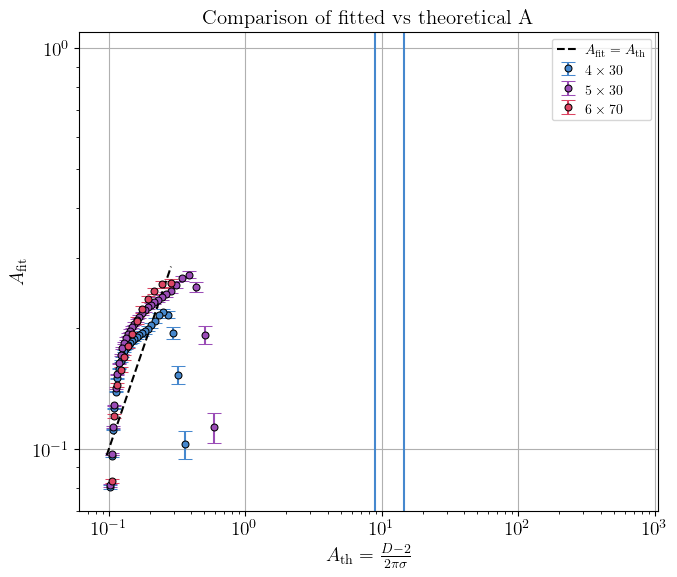

In [9]:
from matplotlib.lines import Line2D
from scipy.interpolate import interp1d
import numpy as np

# Setup
fig, ax = plt.subplots(figsize=(7, 6))
colors = ["#4688CE","#9B4DB7","#DC4563"]
marker_opts = dict(
    marker='o',
    markeredgecolor='k',
    markeredgewidth=0.75,
    markersize=5,
    linestyle='',
)
i = 0
sigmas = []
zoom_idx = [0,-1]
for fit_results in tot_results:
    # === Your fit plot ===
    A_fit_vals = [r['A_fit'] for r in fit_results]
    A_fit_errs = [r['A_err'] for r in fit_results]
    A_th_vals = [r['A_th'] for r in fit_results]
    sigma_values = [r['sigma'] for r in fit_results]
    sigmas.append(sigma_values)
    N = fit_results[0]['N']
    L = fit_results[0]['L']
    # if N == 4:
    #     res_4_70_fit_vals = A_fit_vals 
    #     res_4_70_th_vals = A_th_vals 
    #     res_4_70_fit_errs = A_fit_errs 
    #     res_4_70_sigma_values = sigma_values 
    # if N == 6:
    #     A_th_vals = A_th_vals[::5]
    #     A_fit_vals = A_fit_vals[::5]
    #     A_fit_errs = A_fit_errs[::5]
    #     sigma_values = sigma_values[::5]
    ax.errorbar(A_th_vals[zoom_idx[0]:zoom_idx[-1]], A_fit_vals[zoom_idx[0]:zoom_idx[-1]], yerr=A_fit_errs[zoom_idx[0]:zoom_idx[-1]], fmt='-', **marker_opts, color=colors[i], capsize=5, label=f'${N}\\times {L}$')
    i += 1
ax.plot([min(A_th_vals[zoom_idx[0]:zoom_idx[-1]]), max(A_th_vals[zoom_idx[0]:zoom_idx[-1]])], [min(A_th_vals[zoom_idx[0]:zoom_idx[-1]]), max(A_th_vals[zoom_idx[0]:zoom_idx[-1]])], 'k--', label='$A_{\mathrm{fit}} = A_{\mathrm{th}}$')

# # === Background color regions and vertical lines ===
# D = 3
# A_th_sigma = (D - 2) / (2 * np.pi * np.array(sigma_values))  # from your sigma(g)
# g_vals = np.array(coupls)

# g_to_Ath = interp1d(g_vals, A_th_sigma, kind='cubic', fill_value="extrapolate")

# g_crit = 0.57
# g_max_string = 0.85

# x_crit = float(g_to_Ath(g_crit))
# x_string_max = float(g_to_Ath(g_max_string))

# # Use ax methods instead of plt.*
# ax.axvspan(0, x_crit, color='lightcoral', alpha=0.3)
# ax.axvspan(x_crit, x_string_max, color='lightgreen', alpha=0.3)
# ax.axvspan(x_string_max, max(A_th_sigma), color='gray', alpha=0.2)

# ax.axvline(x_crit, color='red', linestyle='--', linewidth=0.7)
# ax.axvline(x_string_max, color='blue', linestyle='--', linewidth=0.7)

# # === Custom legend handles ===
# custom_lines = [
#     Line2D([0], [0], **marker_opts, color=colors[0], label='$4 \\times 30$'),
#     Line2D([0], [0], **marker_opts, color=colors[1], label='$5 \\times 30$'),
#     Line2D([0], [0], **marker_opts, color=colors[2], label='$6 \\times 30$'),
#     Line2D([0], [0], color='black', linestyle='--', label=r'$A_{\mathrm{fit}} = A_{\mathrm{th}}$'),
#     Line2D([0], [0], color='red', linestyle='--', linewidth=0.7, label=r'$g = 0.57$'),
#     Line2D([0], [0], color='blue', linestyle='--', linewidth=0.7, label=r'$g = 0.85$'),
#     Line2D([0], [0], color='lightcoral', lw=6, alpha=0.3, label='Confined'),
#     Line2D([0], [0], color='lightgreen', lw=6, alpha=0.3, label='String regime'),
#     Line2D([0], [0], color='gray', lw=6, alpha=0.3, label='Deconfined'),
# ]

# ax.legend(handles=custom_lines, loc='upper right', fontsize=11)

# === Final labels and settings ===
ax.set_xlabel(r"$A_{\mathrm{th}} = \frac{D-2}{2\pi\sigma}$", fontsize=14)
ax.set_ylabel(r"$A_{\mathrm{fit}}$", fontsize=14)
ax.set_title("Comparison of fitted vs theoretical A", fontsize=15)
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid(True)

ax.set_ylim((7e-2,1.1))


# ax.errorbar(res_4_70_th_vals, res_4_70_fit_vals, yerr=res_4_70_fit_errs, fmt='x', color=colors[0], capsize=5, label=f'${4}\\times {70}$')
# ax.plot([min(res_4_70_th_vals), max(res_4_70_th_vals)], [min(res_4_70_th_vals), max(res_4_70_th_vals)], 'k--', label='$A_{\mathrm{fit}} = A_{\mathrm{th}}$')

ax.legend()
# ax.text(s="$g$", fontsize=16, x=3e+2, y=3e-7)

# x_left = 1e+3
# x_right = 1e+2
# y_arrow = 1e-6
# ax.annotate(
#     '', xy=(x_left, y_arrow), xytext=(x_right, y_arrow),
#     arrowprops=dict(arrowstyle='<-', color='black', linewidth=1.5)
# )
fig.tight_layout()

# # Save figure
fig.savefig(f"{path_figures}/figures/fluxtube/logarithmic_regime_fit_vs_th_max_L_{70}_zoom.pdf", bbox_inches="tight")
# fig.savefig(f"{path_figures}/figures/fluxtube/logarithmic_regime_fit_vs_th_max_L_{L}.pdf", bbox_inches="tight")
# fig.savefig(f"{path_figures}/figures/fluxtube/logarithmic_regime_fit_vs_th_max_L_{L}_with_regimes_highlighted.pdf", bbox_inches="tight")

In [31]:
def string_width_log_inset_plot(ax, tot_results):
    i = 0
    for fit_results in tot_results:
        # === Your fit plot ===
        A_fit_vals = [r['A_fit'] for r in fit_results]
        B_fit_vals = [r['B_fit'] for r in fit_results]
        A_fit_errs = [r['A_err'] for r in fit_results]
        A_th_vals = [r['A_th'] for r in fit_results]
        sigma_values = [r['sigma'] for r in fit_results]
        sigmas.append(sigma_values)
        N = fit_results[0]['N']
        L = fit_results[0]['L']
        ax.errorbar(A_th_vals[zoom_idx[0]:zoom_idx[-1]], A_fit_vals[zoom_idx[0]:zoom_idx[-1]], yerr=A_fit_errs[zoom_idx[0]:zoom_idx[-1]], fmt='-', **marker_opts, color=colors[i], capsize=5, label=f'${N}\\times {L}$')
        i += 1
    ax.plot([min(A_th_vals[zoom_idx[0]:zoom_idx[-1]]), max(A_th_vals[zoom_idx[0]:zoom_idx[-1]])], [min(A_th_vals[zoom_idx[0]:zoom_idx[-1]]), max(A_th_vals[zoom_idx[0]:zoom_idx[-1]])], 'k--', label='$A_{\mathrm{fit}} = A_{\mathrm{th}}$')
    # ax.plot([min(A_th_vals[zoom_idx[0]:zoom_idx[-1]]), max(A_th_vals[zoom_idx[0]:zoom_idx[-1]])], 2*np.asarray([min(A_th_vals[zoom_idx[0]:zoom_idx[-1]]), max(A_th_vals[zoom_idx[0]:zoom_idx[-1]])]), 'k-.', label='$A_{\mathrm{fit}} = 2A_{\mathrm{th}}$')

    ax.set_yscale('log')
    ax.set_xscale('log')

    ax.set_ylim((7e-2,1.1))
    ax.set_xlim((7e-2,1.1))

<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
C:\Users\HP\AppData\Local\Temp\ipykernel_29292\2284599312.py:15: SyntaxWarning: invalid escape sequence '\m'
  ax.plot([min(A_th_vals[zoom_idx[0]:zoom_idx[-1]]), max(A_th_vals[zoom_idx[0]:zoom_idx[-1]])], [min(A_th_vals[zoom_idx[0]:zoom_idx[-1]]), max(A_th_vals[zoom_idx[0]:zoom_idx[-1]])], 'k--', label='$A_{\mathrm{fit}} = A_{\mathrm{th}}$')


<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\m'
C:\Users\HP\AppData\Local\Temp\ipykernel_29292\910879014.py:33: SyntaxWarning: invalid escape sequence '\m'
  ax.plot(np.linspace(0,1), np.linspace(0,1), 'k--', label='$A_{\mathrm{fit}} = A_{\mathrm{th}}$')
C:\Users\HP\AppData\Local\Temp\ipykernel_29292\910879014.py:34: SyntaxWarning: invalid escape sequence '\m'
  ax.plot(np.linspace(0,1,len(B_fit_vals)), (1/2)*np.linspace(0,1,len(B_fit_vals)), 'k-.', label='$A_{\mathrm{fit}} = 1/2 A_{\mathrm{th}} + 0.1$')
C:\Users\HP\AppData\Local\Temp\ipykernel_29292\910879014.py:28: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(A_th_vals[zoom_idx[0]:zoom_idx[-1]], A_fit_vals[zoom_idx[0]:zoom_idx[-1]], yerr=A_fit_er

B_fit: [1.5000000319977822, 1.4999999649407647, 1.4999998822336786, 1.499999952158239, 1.5000000523992076, 1.4999999403369877, 1.5000000231682014, 1.4999999547723872, 1.50000001966597, 1.500000033494369, 1.5000000290160336, 1.4999998896497069, 1.4999998110269983, 1.4999994613492738, 1.4999987640123171, 1.4999969579624637, 1.4999921956999034, 1.4999787049199358, 1.499940055639803, 1.4998397229851586, 1.4995758436356057, 1.4988135071315714, 1.4967392770262078, 1.4915178284642154, 1.479295904158558, 1.4527183582140761, 1.399617647553043, 1.3046740402626311, 1.1594815764439674, 0.9809499589671127, 0.8146013802750668, 0.6984164192910035, 0.6305176903289058, 0.5871446005473782, 0.5504222565478015, 0.5136398714746669, 0.4758989769989868, 0.43794835697680173, 0.40062335035246727, 0.3644431500686259, 0.3296211599048438, 0.29618522759850496, 0.2641092624624663, 0.23338599866504486, 0.20410038153066581, 0.17650242617810397, 0.1510517442603106, 0.12838360439956906, 0.10936149479121944, 0.094938920

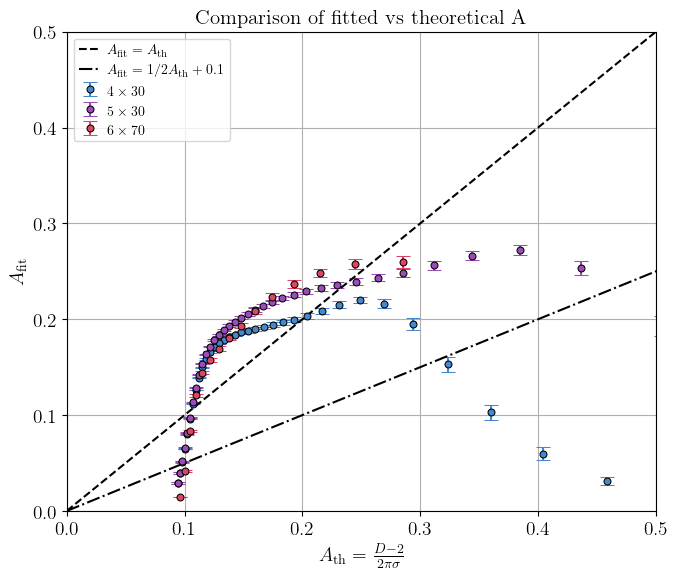

In [37]:
fig, ax = plt.subplots(figsize=(7, 6))
colors = ["#4688CE","#9B4DB7","#DC4563"]
marker_opts = dict(
    marker='o',
    markeredgecolor='k',
    markeredgewidth=0.75,
    markersize=5,
    linestyle='',
)
i = 0
sigmas = []
zoom_idx = [0,-1]
for fit_results in tot_results:
    # === Your fit plot ===
    A_fit_vals = [r['A_fit'] for r in fit_results]
    B_fit_vals = [r['B_fit'] for r in fit_results]
    A_fit_errs = [r['A_err'] for r in fit_results]
    A_th_vals = [r['A_th'] for r in fit_results]
    sigma_values = [r['sigma'] for r in fit_results]
    sigmas.append(sigma_values)
    N = fit_results[0]['N']
    L = fit_results[0]['L']
    if N == 5:
        A_fit_vals.pop(7)
        A_fit_errs.pop(7)
        A_th_vals.pop(7)
        sigma_values.pop(7)
    ax.errorbar(A_th_vals[zoom_idx[0]:zoom_idx[-1]], A_fit_vals[zoom_idx[0]:zoom_idx[-1]], yerr=A_fit_errs[zoom_idx[0]:zoom_idx[-1]], fmt='-', **marker_opts, color=colors[i], capsize=5, label=f'${N}\\times {L}$')
    i += 1

    print(f"B_fit: {B_fit_vals}")
# ax.plot([min(A_th_vals[zoom_idx[0]:zoom_idx[-1]]), max(A_th_vals[zoom_idx[0]:zoom_idx[-1]])], [min(A_th_vals[zoom_idx[0]:zoom_idx[-1]]), max(A_th_vals[zoom_idx[0]:zoom_idx[-1]])], 'k--', label='$A_{\mathrm{fit}} = A_{\mathrm{th}}$')
ax.plot(np.linspace(0,1), np.linspace(0,1), 'k--', label='$A_{\mathrm{fit}} = A_{\mathrm{th}}$')
ax.plot(np.linspace(0,1,len(B_fit_vals)), (1/2)*np.linspace(0,1,len(B_fit_vals)), 'k-.', label='$A_{\mathrm{fit}} = 1/2 A_{\mathrm{th}} + 0.1$')
# ax.plot(np.linspace(0,1,len(B_fit_vals)), B_fit_vals, 'k-.', label='$A_{\mathrm{fit}} = 1/2 A_{\mathrm{th}} + 0.1$')

zoom_idx = [0,-1]
# ax_inset = inset_axes(ax, width="38%", height="38%", loc='center right', bbox_to_anchor=(-0.01, 0.05, 1, 1), bbox_transform=ax.transAxes)
# string_width_log_inset_plot(ax_inset, tot_results)

ax.set_xlabel(r"$A_{\mathrm{th}} = \frac{D-2}{2\pi\sigma}$", fontsize=14)
ax.set_ylabel(r"$A_{\mathrm{fit}}$", fontsize=14)
ax.set_title("Comparison of fitted vs theoretical A", fontsize=15)
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_ylim(bottom=0, top=0.5)
ax.set_xlim(left=0, right=0.5)
ax.grid(True)
ax.legend()

fig.tight_layout()

# Save figure
fig.savefig(f"{path_figures}/figures/fluxtube/logarithmic_regime_fit_vs_th_max_{4,5,6}x{30}_inset.pdf", bbox_inches="tight")

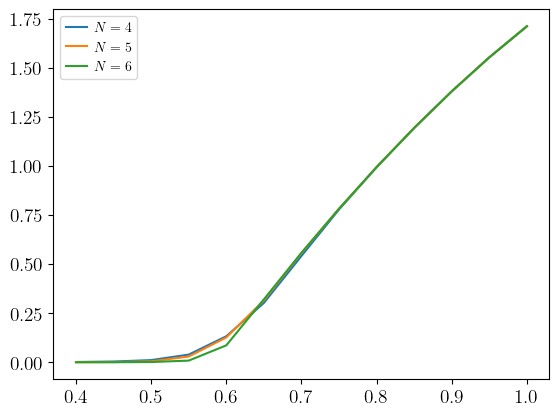

In [126]:
N = 4
for sigma in sigmas:
    plt.plot(coupls, sigma, label=f"$N={N}$")
    N += 1
plt.legend()

[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0

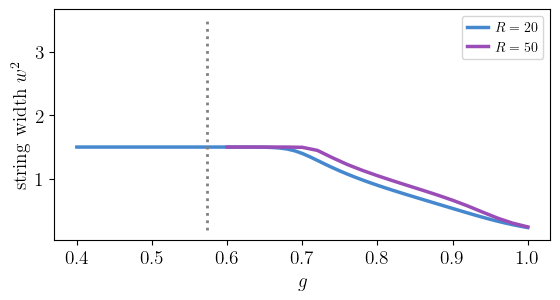

In [17]:
Rs = [10,12,14,16,18,20]
h_i, h_f, npoints = 0.4, 1.0, 61
gs = np.linspace(h_i, h_f, npoints)
chis = [64,128]

fig, axs = plt.subplots(1, figsize=(6.4, 3))

colors = ["#4688CE","#9B4DB7","#DC4563"]

# String width vs coupling
i = 0
N, L = 4, 30
Rmax = 20
string_width, string_width_err = string_width_varying_g(gs, Rmax, N, L, chis, bc, sector, h_i, h_f, npoints, path, occupation=True)
print(f"N = {N}, Rmax = {Rmax}")
axs.plot(gs, string_width, color=colors[i], label=f"$R = {Rmax}$", linewidth=2.5)
i += 1

Rs = [30,35,40,45,50]
Rs = [45,46,47,48,49,50]
chis = [128,192]
npoints, h_i, h_f = 21, 0.6, 1.0
gs = np.linspace(h_i,h_f,npoints)
coupls = gs.copy()
N, L = 4, 70
Rmax = 50
a = 1

# Rs = [45,46,47,48,49,50,51,52,53,54,55]
# chis = [64,96,128,192]
# npoints, h_i, h_f = 14, 0.74, 1.0
# gs = np.linspace(h_i,h_f,npoints)
# coupls = gs.copy()
# N, L = 4, 70
# Rmax = 54
# a = 1

string_width, string_width_err = string_width_varying_g(gs, Rmax, N, L, chis, bc, sector, h_i, h_f, npoints, path, occupation=True)
print(f"N = {N}, Rmax = {Rmax}")
axs.plot(gs, string_width, color=colors[i], label=f"$R = {Rmax}$", linewidth=2.5)
i += 1

axs.legend()
axs.set_xlabel("$g$")
axs.set_ylabel("string width $w^2$")
axs.vlines(theor_gc, 0.2, 3.5, 'grey', ':', linewidth=2)

### String width with R

[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1

[3.944480673645501e-06,
 6.886723400434391e-06,
 1.7138141527262007e-05,
 1.1017933681856107e-05,
 8.332223138118877e-07,
 6.5374090061354195e-06,
 8.372058137240401e-05,
 2.5204940383272145e-05,
 4.3295048492986155e-06,
 3.972841853316922e-05,
 2.795392697896304e-05,
 8.993903558707217e-05,
 7.421408814245467e-05,
 1.2494095113169124e-05,
 9.471966176732849e-05,
 9.391100981304135e-05,
 0.00015935325305393988,
 1.715292700188442e-05,
 6.707824859297773e-05,
 3.573084076213817e-05,
 1.0975469411533822e-05,
 6.026709580542189e-05,
 0.0006072556313849731,
 0.002015085021526364,
 0.004999627289602238,
 0.007781446436347039,
 0.00794079249529167,
 0.006003645471513774,
 0.007791061240839614,
 0.006966745693232745,
 0.006455519529321219,
 0.006161395394459479,
 0.00418700123799276,
 0.00432094782225656,
 0.0031051862827695675,
 0.0021940486563998274,
 0.0026874570162811473,
 0.0029610036236731307,
 0.0022714508092780417,
 0.0017005156699230195,
 0.002320153264400493,
 0.0015438493235911954,

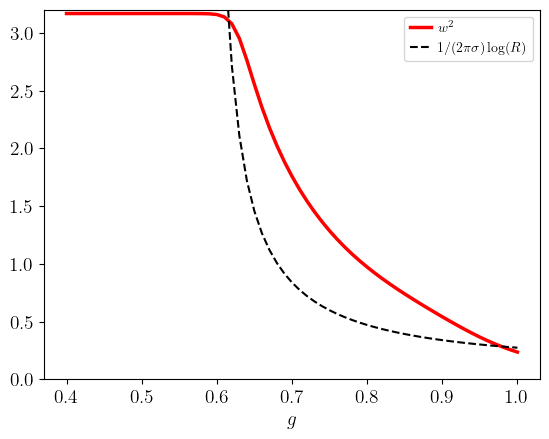

In [3]:
R = 19
h_i, h_f, npoints = 0.4, 1.0, 61
gs = np.linspace(h_i, h_f, npoints)
chis = [64,128]
string_tension, string_tension_err = potential_first_discrete_derivative_varying_g(gs, R, N, [L], chis, bc, sector, h_i, h_f, npoints, path, a=1)
string_width, string_width_err = string_width_varying_g(gs, R, N, L, chis, bc, sector, h_i, h_f, npoints, path, occupation=True)
plt.plot(gs, string_width, color='r', linewidth=2.5, label='$w^2$')
obs = 1/(2* np.pi * np.asarray(string_tension)) * np.log(R)
plt.plot(gs[20:], obs[20:], label='$1/(2 \\pi \\sigma) \\log(R)$', linestyle='--', color='k')
plt.xlabel('$g$')
plt.legend()
plt.ylim(0,3.2)
string_width_err

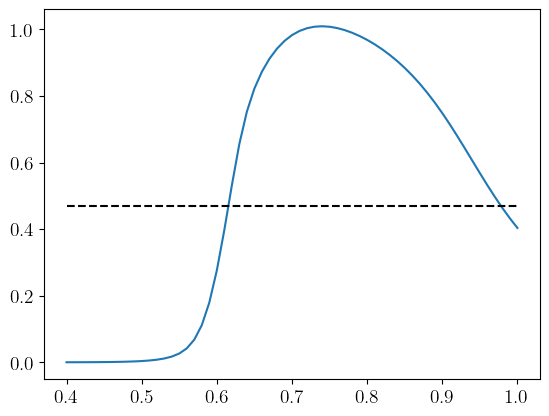

In [4]:
plt.plot(gs, np.asarray(string_tension)*np.asarray(string_width))
plt.plot(gs, 1/(2*np.pi)*np.log(np.asarray([R for _ in range(len(gs))])), linestyle='--', color='k')

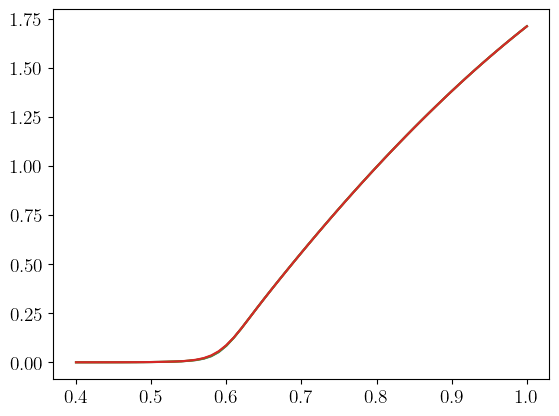

In [5]:

Rs = [16,17,18,19]
for R in Rs:
    string_tension, string_tension_err = potential_first_discrete_derivative_varying_g(gs, R, N, [L], chis, bc, sector, h_i, h_f, npoints, path, a=1)
    plt.plot(gs, string_tension)

In [6]:
Rs = [10,12,14,16,18,20]
chis = [64,128]
npoints, h_i, h_f = 61, 0.4, 1.0
gs = np.linspace(h_i,h_f,npoints)
coupls = gs.copy()
N, L = 6, 30
R = 19
a = 1

Rs = [30,35,40,45,50]
chis = [64,96,128,192]
npoints, h_i, h_f = 9, 0.6, 1.0
gs = np.linspace(h_i,h_f,npoints)
coupls = gs.copy()
N, L = 4, 70
R = 45
a = 5

Rs = [45,46,47,48,49,50,51,52,53,54,55]
chis = [64,96,128,192]
npoints, h_i, h_f = 21, 0.6, 1.0
gs = np.linspace(h_i,h_f,npoints)
coupls = gs.copy()
N, L = 4, 70
R = 50
a = 1

In [13]:
def log_fit(R, a, b):
    return a*np.log(R) + b

def quantitative_string_width():
    observable = []
    observable_err = []
    sigmas = []
    sigmas_err = []
    for g in coupls:
        string_width, string_width_err = string_width_varying_R(g, Rs, N, L, chis, bc, sector, h_i, h_f, npoints, path, occupation=True)
        # plt.plot(Rs, string_width, color=colors[k], label=f"$g = {g}$", **marker_opts)

        sigma, string_tension_err = potential_first_discrete_derivative(g, R, N, [L], chis, bc, sector, h_i, h_f, npoints, path, a=a)
        plog, clog = curve_fit(log_fit, Rs, string_width, sigma=string_width_err)
        err_param = np.sqrt(np.diag(clog))[0]
        x_fit = np.linspace(8,20)
        # plt.plot(x_fit, log_fit(x_fit,*plog), color=colors[k], linestyle=':', zorder=0)
        obs = plog[0]
        obs_err = err_param
        observable.append(obs)
        observable_err.append(obs_err)
        sigmas.append(sigma)
        sigmas_err.append(string_tension_err)
    return observable, observable_err, sigmas, sigmas_err

[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1

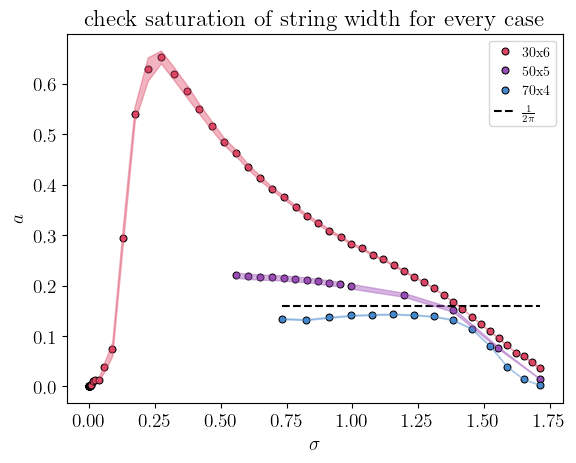

In [55]:
colors = ["#4688CE","#9B4DB7","#DC4563"]
Rs = [10,12,14,16,18,20]
chis = [64,128]
npoints, h_i, h_f = 61, 0.4, 1.0
gs = np.linspace(h_i,h_f,npoints)
coupls = gs.copy()
N, L = 6, 30
R = 19
a = 1

obs, obs_err, sigma, sigma_err = quantitative_string_width()
plt.plot(sigma, obs, zorder=0, **marker_opts, color=colors[2], label=f"${L}$x${N}$")
plt.fill_between(sigma, np.asarray(obs)+np.asarray(obs_err), np.asarray(obs)-np.asarray(obs_err), color=colors[2], alpha=0.4)


Rs = [25,26,27,28,29,30]
chis = [64,128]
npoints, h_i, h_f = 5, 0.8, 1.0
gs = np.linspace(h_i,h_f,npoints)
coupls = gs.copy()
N, L = 5, 50
R = 29
a = 1

obs, obs_err, sigma, sigma_err = quantitative_string_width()
plt.plot(sigma, obs, zorder=0, **marker_opts, color=colors[1], label=f"${L}$x${N}$")
plt.fill_between(sigma, np.asarray(obs)+np.asarray(obs_err), np.asarray(obs)-np.asarray(obs_err), color=colors[1], alpha=0.4)

npoints, h_i, h_f = 10, 0.7, 0.79
gs = np.linspace(h_i,h_f,npoints)
coupls = gs.copy()

obs, obs_err, sigma, sigma_err = quantitative_string_width()
plt.plot(sigma, obs, zorder=0, **marker_opts, color=colors[1])
plt.fill_between(sigma, np.asarray(obs)+np.asarray(obs_err), np.asarray(obs)-np.asarray(obs_err), color=colors[1], alpha=0.4)

# npoints, h_i, h_f = 4, 0.81, 0.84
# gs = np.linspace(h_i,h_f,npoints)
# coupls = gs.copy()

# obs, obs_err, sigma, sigma_err = quantitative_string_width()
# plt.plot(sigma, obs, zorder=0, **marker_opts, color=colors[1])
# plt.fill_between(sigma, np.asarray(obs)+np.asarray(obs_err), np.asarray(obs)-np.asarray(obs_err), color=colors[1], alpha=0.4)


Rs = [30,35,40,45,50]
chis = [64,96,128,192]
npoints, h_i, h_f = 9, 0.6, 1.0
gs = np.linspace(h_i,h_f,npoints)
coupls = gs.copy()
N, L = 4, 70
R = 45
a = 5

Rs = [45,46,47,48,49,50,51,52,53,54,55]
chis = [96,128,192]
npoints, h_i, h_f = 14, 0.74, 1.0
gs = np.linspace(h_i,h_f,npoints)
coupls = gs.copy()
N, L = 4, 70
R = 54
a = 1

obs, obs_err, sigma, sigma_err = quantitative_string_width()
plt.plot(sigma, obs, zorder=0, **marker_opts, color=colors[0], label=f"${L}$x${N}$")
plt.fill_between(sigma, np.asarray(obs)+np.asarray(obs_err), np.asarray(obs)-np.asarray(obs_err), color=colors[0], alpha=0.4)


plt.hlines(y=1/(2*np.pi), xmin=sigma[0], xmax=sigma[-1], color='k', linestyle='--', zorder=0, label="$\\frac{1}{2\\pi}$")
plt.xlabel("$\\sigma$")
plt.ylabel("$a$")
plt.title("check saturation of string width for every case")
plt.legend()

[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0

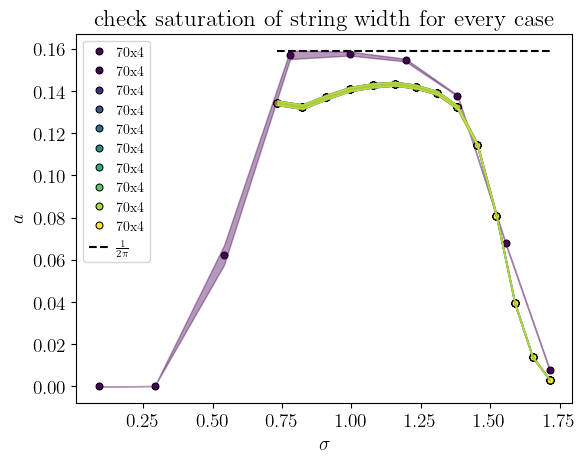

In [57]:
Rs = [30,35,40,45,50]
chis = [96,128,192]
npoints, h_i, h_f = 9, 0.6, 1.0
gs = np.linspace(h_i,h_f,npoints)
coupls = gs.copy()
N, L = 4, 70
R = 45
a = 5

obs, obs_err, sigma, sigma_err = quantitative_string_width()
plt.plot(sigma, obs, zorder=0, **marker_opts, color=colors[0], label=f"${L}$x${N}$")
plt.fill_between(sigma, np.asarray(obs)+np.asarray(obs_err), np.asarray(obs)-np.asarray(obs_err), color=colors[0], alpha=0.4)

Rs = [45,46,47,48,49,50,51,52,53,54,55]
chis = [96,128,192]
npoints, h_i, h_f = 14, 0.74, 1.0
gs = np.linspace(h_i,h_f,npoints)
coupls = gs.copy()
N, L = 4, 70
a = 1

colors = create_sequential_colors(len(Rs)-2)

for i, R in enumerate(Rs[1:-1]):
    obs, obs_err, sigma, sigma_err = quantitative_string_width()
    plt.plot(sigma, obs, zorder=0, **marker_opts, color=colors[i], label=f"${L}$x${N}$")
    plt.fill_between(sigma, np.asarray(obs)+np.asarray(obs_err), np.asarray(obs)-np.asarray(obs_err), color=colors[i], alpha=0.4)


plt.hlines(y=1/(2*np.pi), xmin=sigma[0], xmax=sigma[-1], color='k', linestyle='--', zorder=0, label="$\\frac{1}{2\\pi}$")
plt.xlabel("$\\sigma$")
plt.ylabel("$a$")
plt.title("check saturation of string width for every case")
plt.legend()

In [ ]:
## Fidelity Susceptibility

12 [0.99625673 0.99648535 0.99668443 0.99685703 0.99700591 0.99713371
 0.9972431  0.99733697 0.99741853 0.9974914  0.99755949 0.99762681] [0.805 0.815 0.825 0.835 0.845 0.855 0.865 0.875 0.885 0.895 0.905 0.915]
12 [0.996189   0.99641856 0.99661792 0.99679003 0.99693756 0.99706298
 0.99716886 0.99725802 0.99733372 0.99739977 0.99746051 0.99752055] [0.805 0.815 0.825 0.835 0.845 0.855 0.865 0.875 0.885 0.895 0.905 0.915]
12 [0.99612134 0.99635192 0.99655167 0.99672344 0.99686977 0.99699299
 0.99709551 0.99718003 0.99724982 0.99730885 0.99736181 0.99741398] [0.805 0.815 0.825 0.835 0.845 0.855 0.865 0.875 0.885 0.895 0.905 0.915]
12 [0.99605371 0.99628539 0.99648561 0.99665718 0.99680245 0.99692362
 0.99702293 0.99710293 0.9971668  0.99721863 0.99726346 0.99730717] [0.805 0.815 0.825 0.835 0.845 0.855 0.865 0.875 0.885 0.895 0.905 0.915]
12 [0.99598609 0.99621894 0.9964197  0.99659116 0.99673551 0.9968548
 0.99695103 0.9970266  0.99708458 0.9971291  0.99716547 0.99720023] [0.805 0.815 0.

/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_1308/3958316393.py:136: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


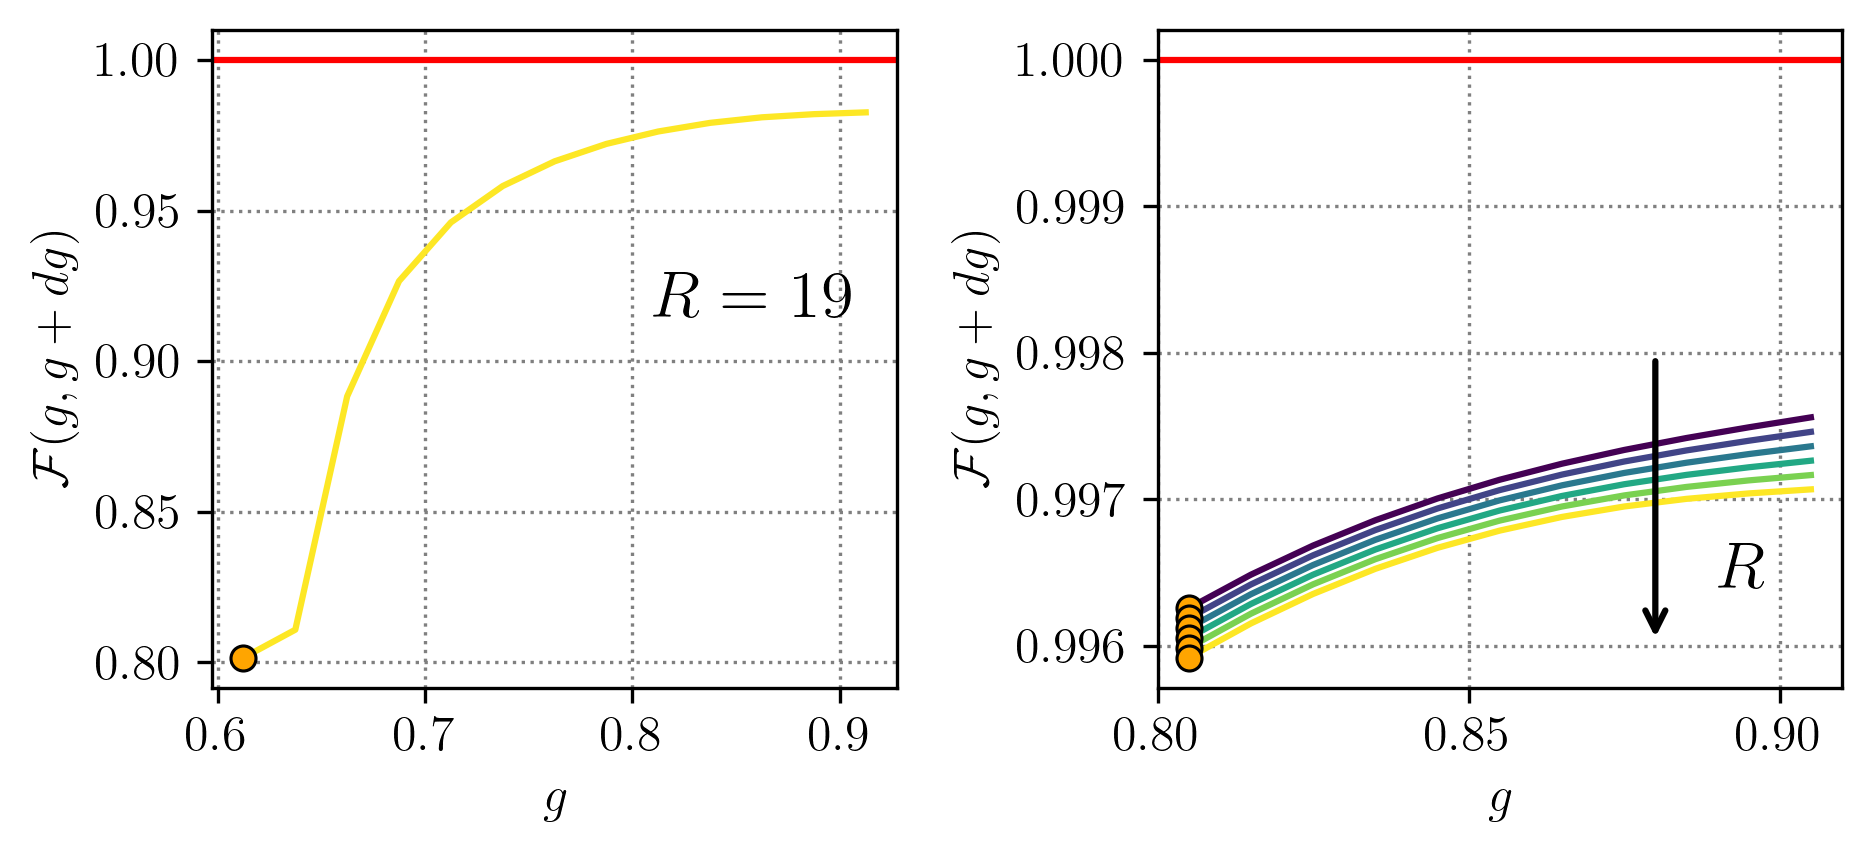

In [129]:
l = 6
L = 30 
bc = "pbc"
# h_i, h_f, npoints = 0.6, 0.95, 15
# Rs = [10,11,13,15,16,17,19,21]
# chi = 256

# h_i, h_f, npoints = 0.4, 1.0, 61
# gs = np.linspace(h_i,h_f,npoints-1)
# Rs = [10,12,13,14,15,16,17,18,19,20]
# chi = 128
# rng = [45,-2]
# x_arrow = 0.92
# y_bottom = -0.5e-5
# y_top = +1.5e-5

# l = 5
# h_i, h_f, npoints = 0.8, 1.0, 41
# gs = np.linspace(h_i,h_f,npoints-1)
# Rs = [10,12,13,14,15,16,17,18,19,20]
# chi = 128
# rng = [5,-5]
# x_arrow = 0.92
# y_bottom = -0.5e-6
# y_top = +1.3e-6

l = 6
h_i, h_f, npoints = 0.8, 0.92, 13
gs = np.linspace(h_i+5*1e-3,h_f-5*1e-3,npoints-1)
Rs = [15,16,17,18,19,20]
chi = 256
rng = [0,-1]
x_arrow = 0.88
y_bottom = 1-4e-3
y_top = 1-2e-3

peaks_opts = dict(
    zorder=20,
    marker="o", 
    facecolors="orange", 
    edgecolors="k",
    linewidths=0.75
)

colors = create_sequential_colors(len(Rs))
log = False
rdm = False
der = False

fig, axs = plt.subplots(1, 2, figsize=(6.4, 3))

for ax in axs:
    ax.grid(color="gray", linestyle=":")

min_g = []
for i, R in enumerate(Rs):
    fidelities = np.load(f"{path}/results/overlap/fidelity_susceptibility_log_{log}_rdm_{rdm}_der_{der}_{model}_{l}x{L}_bc_{bc}_R_{R}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chi}.npy")
    print(len(fidelities), fidelities, gs)
    # Susceptibility
    axs[1].plot(gs[rng[0]:rng[1]], fidelities[rng[0]:rng[1]], color=colors[i])
    axs[1].scatter(gs[rng[0]:rng[1]][np.argmin(fidelities[rng[0]:rng[1]])], np.min(fidelities[rng[0]:rng[1]]), **peaks_opts)
    # axs[1].set_ylabel(r"$\chi_M$")
    axs[1].set_ylabel("$\\mathcal{F}(g,g+dg)$")
    axs[1].set_xlabel(r"$g$")
    min_g.append(gs[rng[0]:rng[1]][np.argmin(fidelities[rng[0]:rng[1]])])

axs[1].axhline(y=1, color='r')
# Double-headed arrow
axs[1].annotate(
    '', xy=(x_arrow, y_bottom), xytext=(x_arrow, y_top),
    arrowprops=dict(arrowstyle='->', color='black', linewidth=1.5)
)

# Label next to the arrow
axs[1].text(
    x_arrow+0.01,(y_top + y_bottom) / 2 - 5e-4,  # small x shift, mid y
    r'$R$', fontsize=16, va='center'
)


l = 6
h_i, h_f, npoints = 0.6, 0.95, 15
R = 19
gs = np.linspace(h_i+0.0125,h_f-0.0125,npoints-1)
fidelities = np.load(f"{path}/results/overlap/fidelity_susceptibility_log_{log}_rdm_{rdm}_der_{der}_{model}_{l}x{L}_bc_{bc}_R_{R}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chi}.npy")
print(len(fidelities), fidelities, gs)
# Susceptibility
axs[0].plot(gs[rng[0]:rng[1]], fidelities[rng[0]:rng[1]], color=colors[i])
axs[0].scatter(gs[rng[0]:rng[1]][np.argmin(fidelities[rng[0]:rng[1]])], np.min(fidelities[rng[0]:rng[1]]), **peaks_opts)
axs[0].axhline(y=1, color='r')
axs[0].set_ylabel("$\\mathcal{F}(g,g+dg)$")
axs[0].set_xlabel(r"$g$")

axs[0].text(
    0.81,0.92,  # small x shift, mid y
    r'$R=19$', fontsize=16, va='center'
)
# err_g = (h_f - h_i) / (npoints - 1)
# labels=dict(
#         fit="$a L^{-1} + b$",
#         theor="$g_r^{\\mathrm{th}}$"
#     )
# theor_y0 = 0.855
# fss_plot_opts = dict(
#     fit_opts = dict(linestyle="--", linewidth=1, color="k"),
#     y0_opts = dict(fmt='s', elinewidth=1, ecolor="k", capsize=6, markersize=5, mfc="red", mec="k", mew=0.5, capthick=2),
#     theor_opts = dict(s=40, marker='X', facecolors="red", edgecolors="k", linewidths=0.5),
#     points_opts = dict(fmt='o', elinewidth=1, ecolor="k", capsize=6, ms=4, mfc="orange", mec="k", mew=0.75, capthick=2)
# )


# # Plot fitted function
# # xrange = np.linspace(0, 1/fss.data[fss.x].min())
# # fitted_fs = fss.fit_func(xrange, *fss.fit_params)
# # fit_plot, = ax.plot(xrange, fitted_fs, label=labels.get("fit", ""), **fit_opts)

# # Plot fss data
# axs[1].errorbar(
#     [1 / R for R in Rs],
#     min_g,
#     err_g,
#     label=labels.get("points", ""),
#     **fss_plot_opts["points_opts"]
# )

# # Theoretical value for y0
# axs[1].scatter([0.0], [theor_y0], label=labels.get("theor"), **fss_plot_opts["theor_opts"], zorder=20)

# # # Plot point at x = 0
# # axs[1].errorbar(0, fss.y0, fss.y0_err, label=labels.get("y0", ""), **y0_opts)

# axs[1].legend(title="$\\chi_M$")
# axs[1].set_ylabel("$g_r^{(R)}$")
# axs[1].set_xlabel(r"$1/R$")

fig.tight_layout()

# # Save figure
fig.savefig(f"{path_figures}/figures/fluxtube/fid_susc_{l}x{L}_different_ranges.pdf", bbox_inches="tight")

In [131]:
bc = "pbc"
l = 6

### Tests, zoom plot

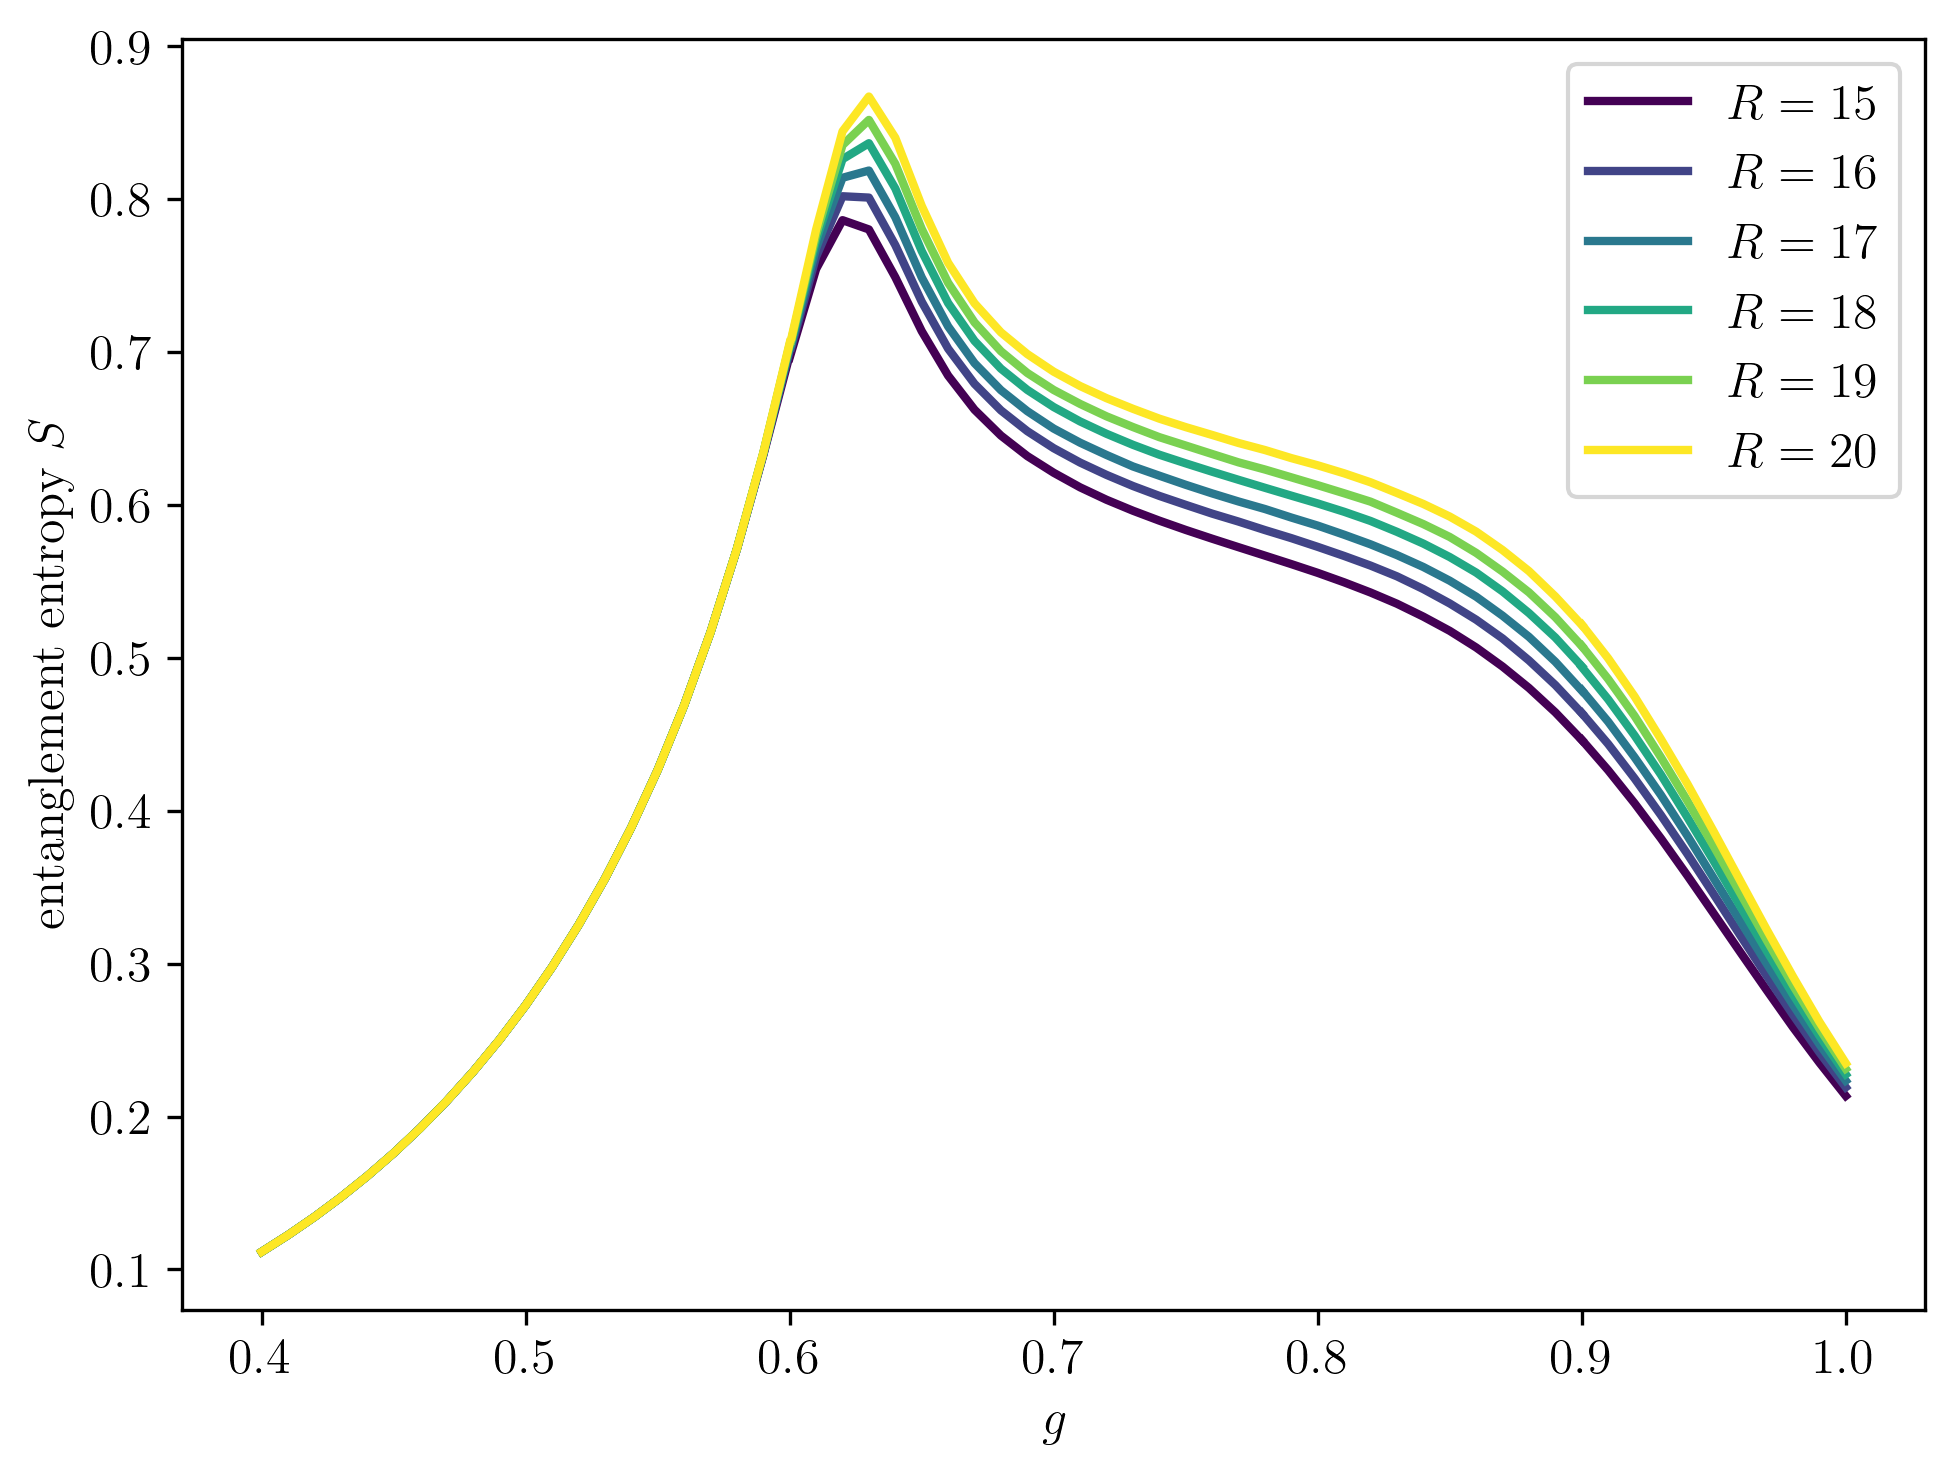

In [137]:
chi = 128
npoints, h_i, h_f = 31, 0.6, 0.9 
gs = np.linspace(h_i,h_f,npoints)
Rs = [15,16,17,18,19,20]
colors = create_sequential_colors(len(Rs))
for i, R in enumerate(Rs):
    s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
    plt.plot(gs,s_pbc, color=colors[i], linewidth=2, linestyle='-', label=f"$R={R}$")

npoints, h_i, h_f = 21, 0.4, 0.6 
gs = np.linspace(h_i,h_f,npoints)
for i, R in enumerate(Rs):
    s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
    plt.plot(gs,s_pbc, color=colors[i], linewidth=2, linestyle='-')

npoints, h_i, h_f = 11, 0.9, 1.0 
gs = np.linspace(h_i,h_f,npoints)
for i, R in enumerate(Rs):
    s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
    plt.plot(gs,s_pbc, color=colors[i], linewidth=2, linestyle='-')

plt.xlabel(r"$g$")
plt.ylabel("entanglement entropy $S$")
plt.legend()

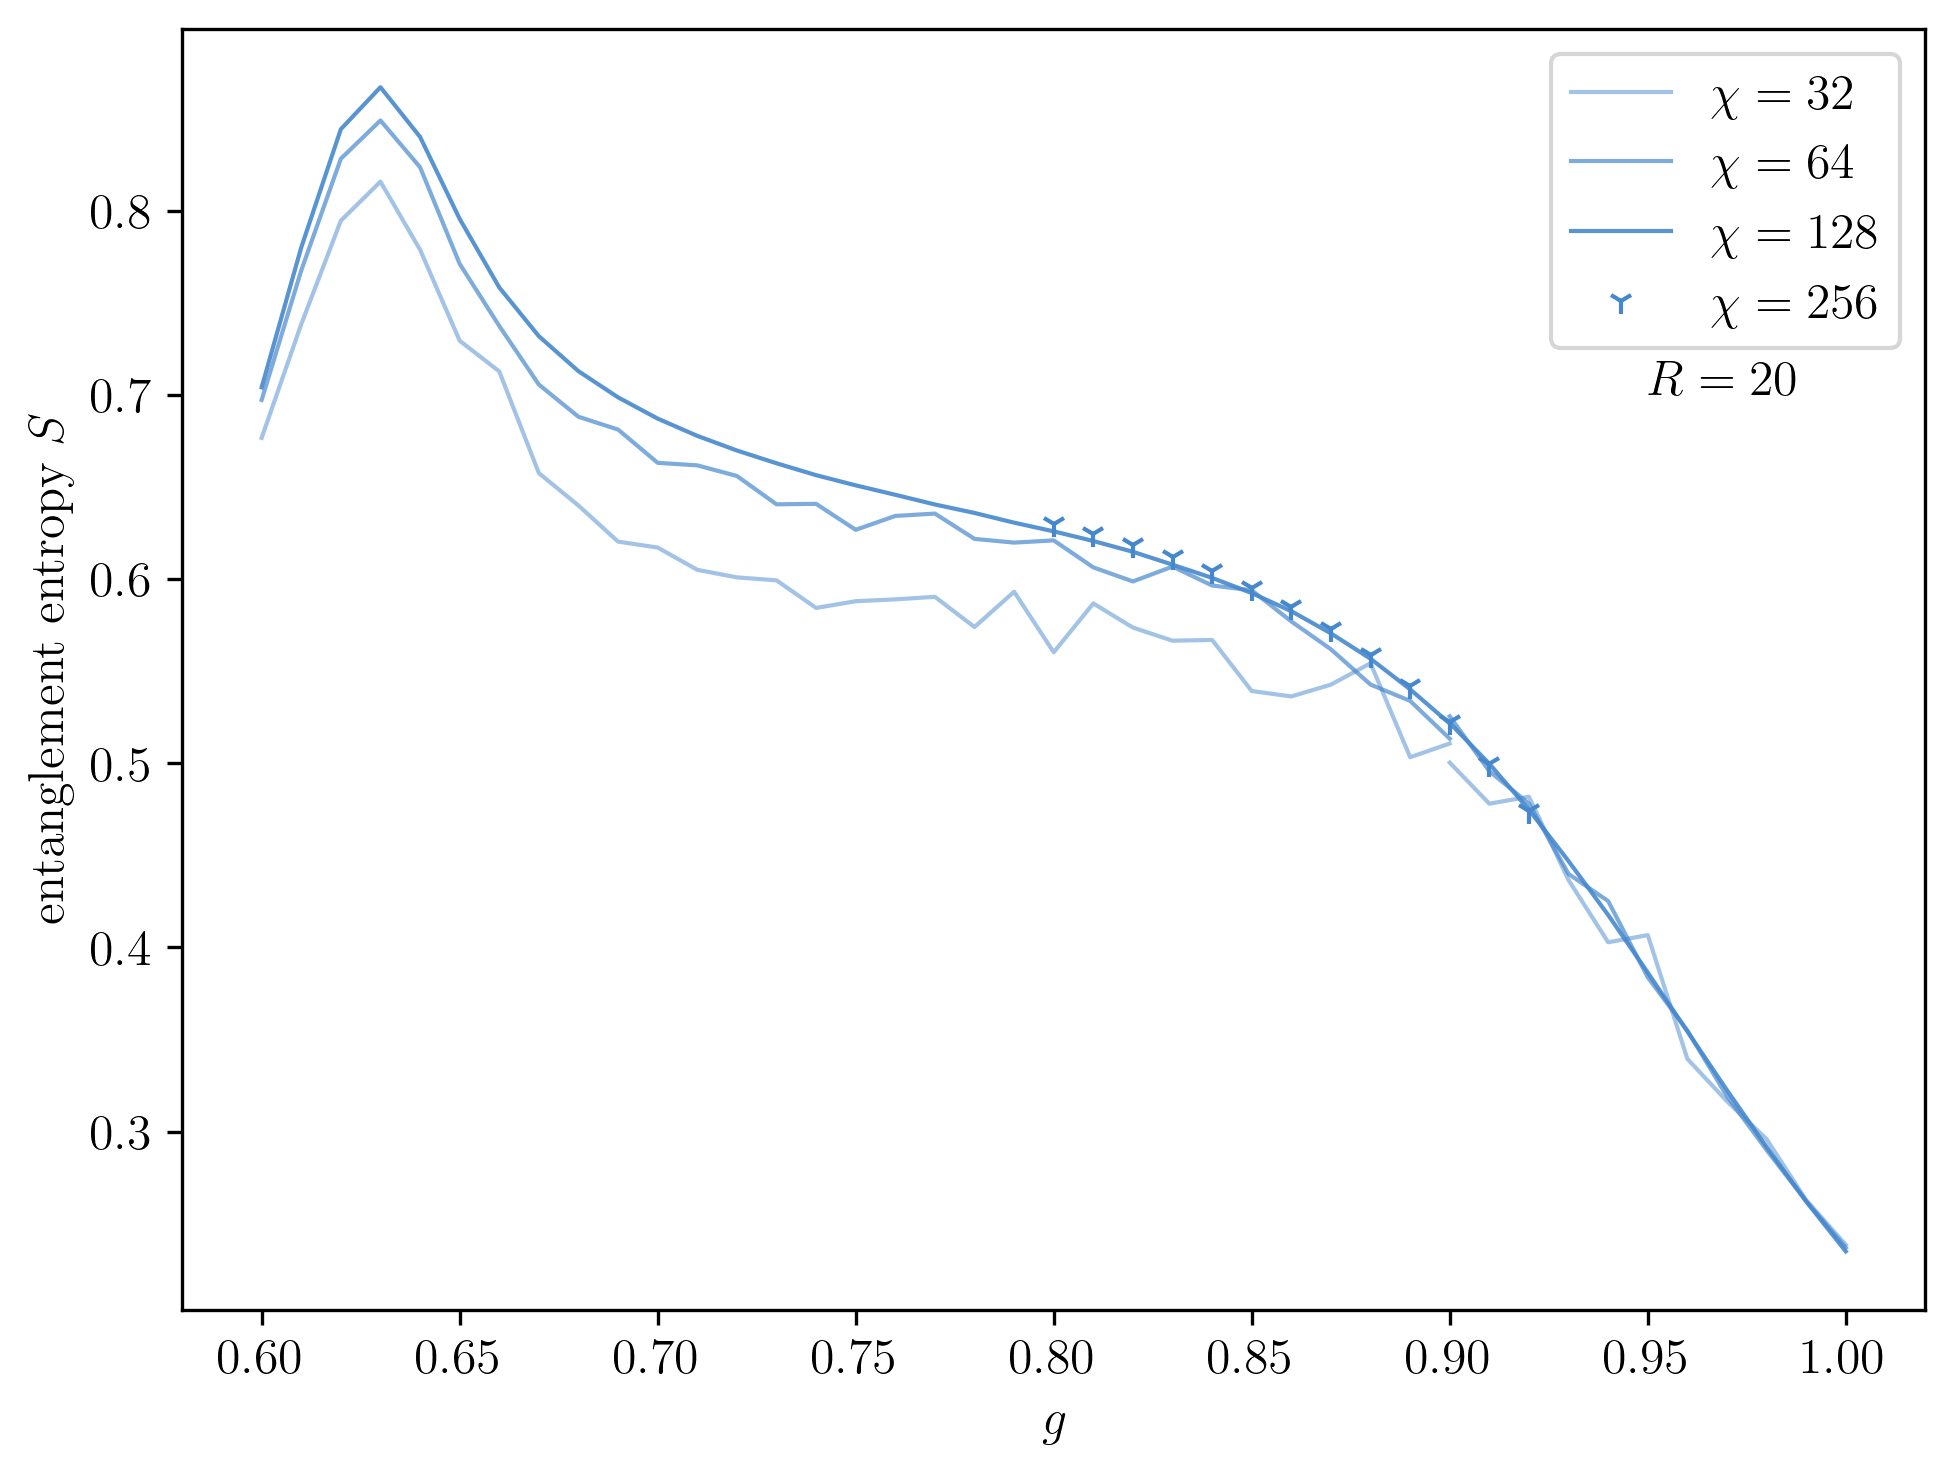

In [88]:
R = 20
chis = [32,64,128]
color = "#4688CE"
npoints, h_i, h_f = 31, 0.6, 0.9
gs = np.linspace(h_i,h_f,npoints)

for j, chi in enumerate(chis):
    s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
    plt.plot(gs,s_pbc, color=color, linewidth=1, alpha=0.5+0.2*j, linestyle='-', label=f"$\\chi = {chi}$")

npoints, h_i, h_f = 11, 0.9, 1.0
gs = np.linspace(h_i,h_f,npoints)

for j, chi in enumerate(chis):
    s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
    plt.plot(gs,s_pbc, color=color, linewidth=1, alpha=0.5+0.2*j, linestyle='-')

npoints, h_i, h_f = 2, 0.8, 0.85 
chi = 256
gs = np.linspace(h_i,h_f,npoints)
s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
plt.plot(gs,s_pbc, color=color, linewidth=1, marker='1', linestyle='', label=f"$\\chi = {chi}$")

npoints, h_i, h_f = 4, 0.81, 0.84 
chi = 256
gs = np.linspace(h_i,h_f,npoints)
s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
plt.plot(gs,s_pbc, color=color, linewidth=1, marker='1', linestyle='')

npoints, h_i, h_f = 4, 0.86, 0.89 
chi = 256
gs = np.linspace(h_i,h_f,npoints)
s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
plt.plot(gs,s_pbc, color=color, linewidth=1, marker='1', linestyle='')

npoints, h_i, h_f = 1, 0.9, 0.9 
chi = 256
gs = np.linspace(h_i,h_f,npoints)
s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
plt.plot(gs,s_pbc, color=color, linewidth=1, marker='1', linestyle='')

npoints, h_i, h_f = 2, 0.91, 0.92 
chi = 256
gs = np.linspace(h_i,h_f,npoints)
s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
plt.plot(gs,s_pbc, color=color, linewidth=1, marker='1', linestyle='')

plt.text(x=0.95, y=0.7, s=f"$R={R}$")
plt.xlabel(r"$g$")
plt.ylabel("entanglement entropy $S$")
plt.legend()

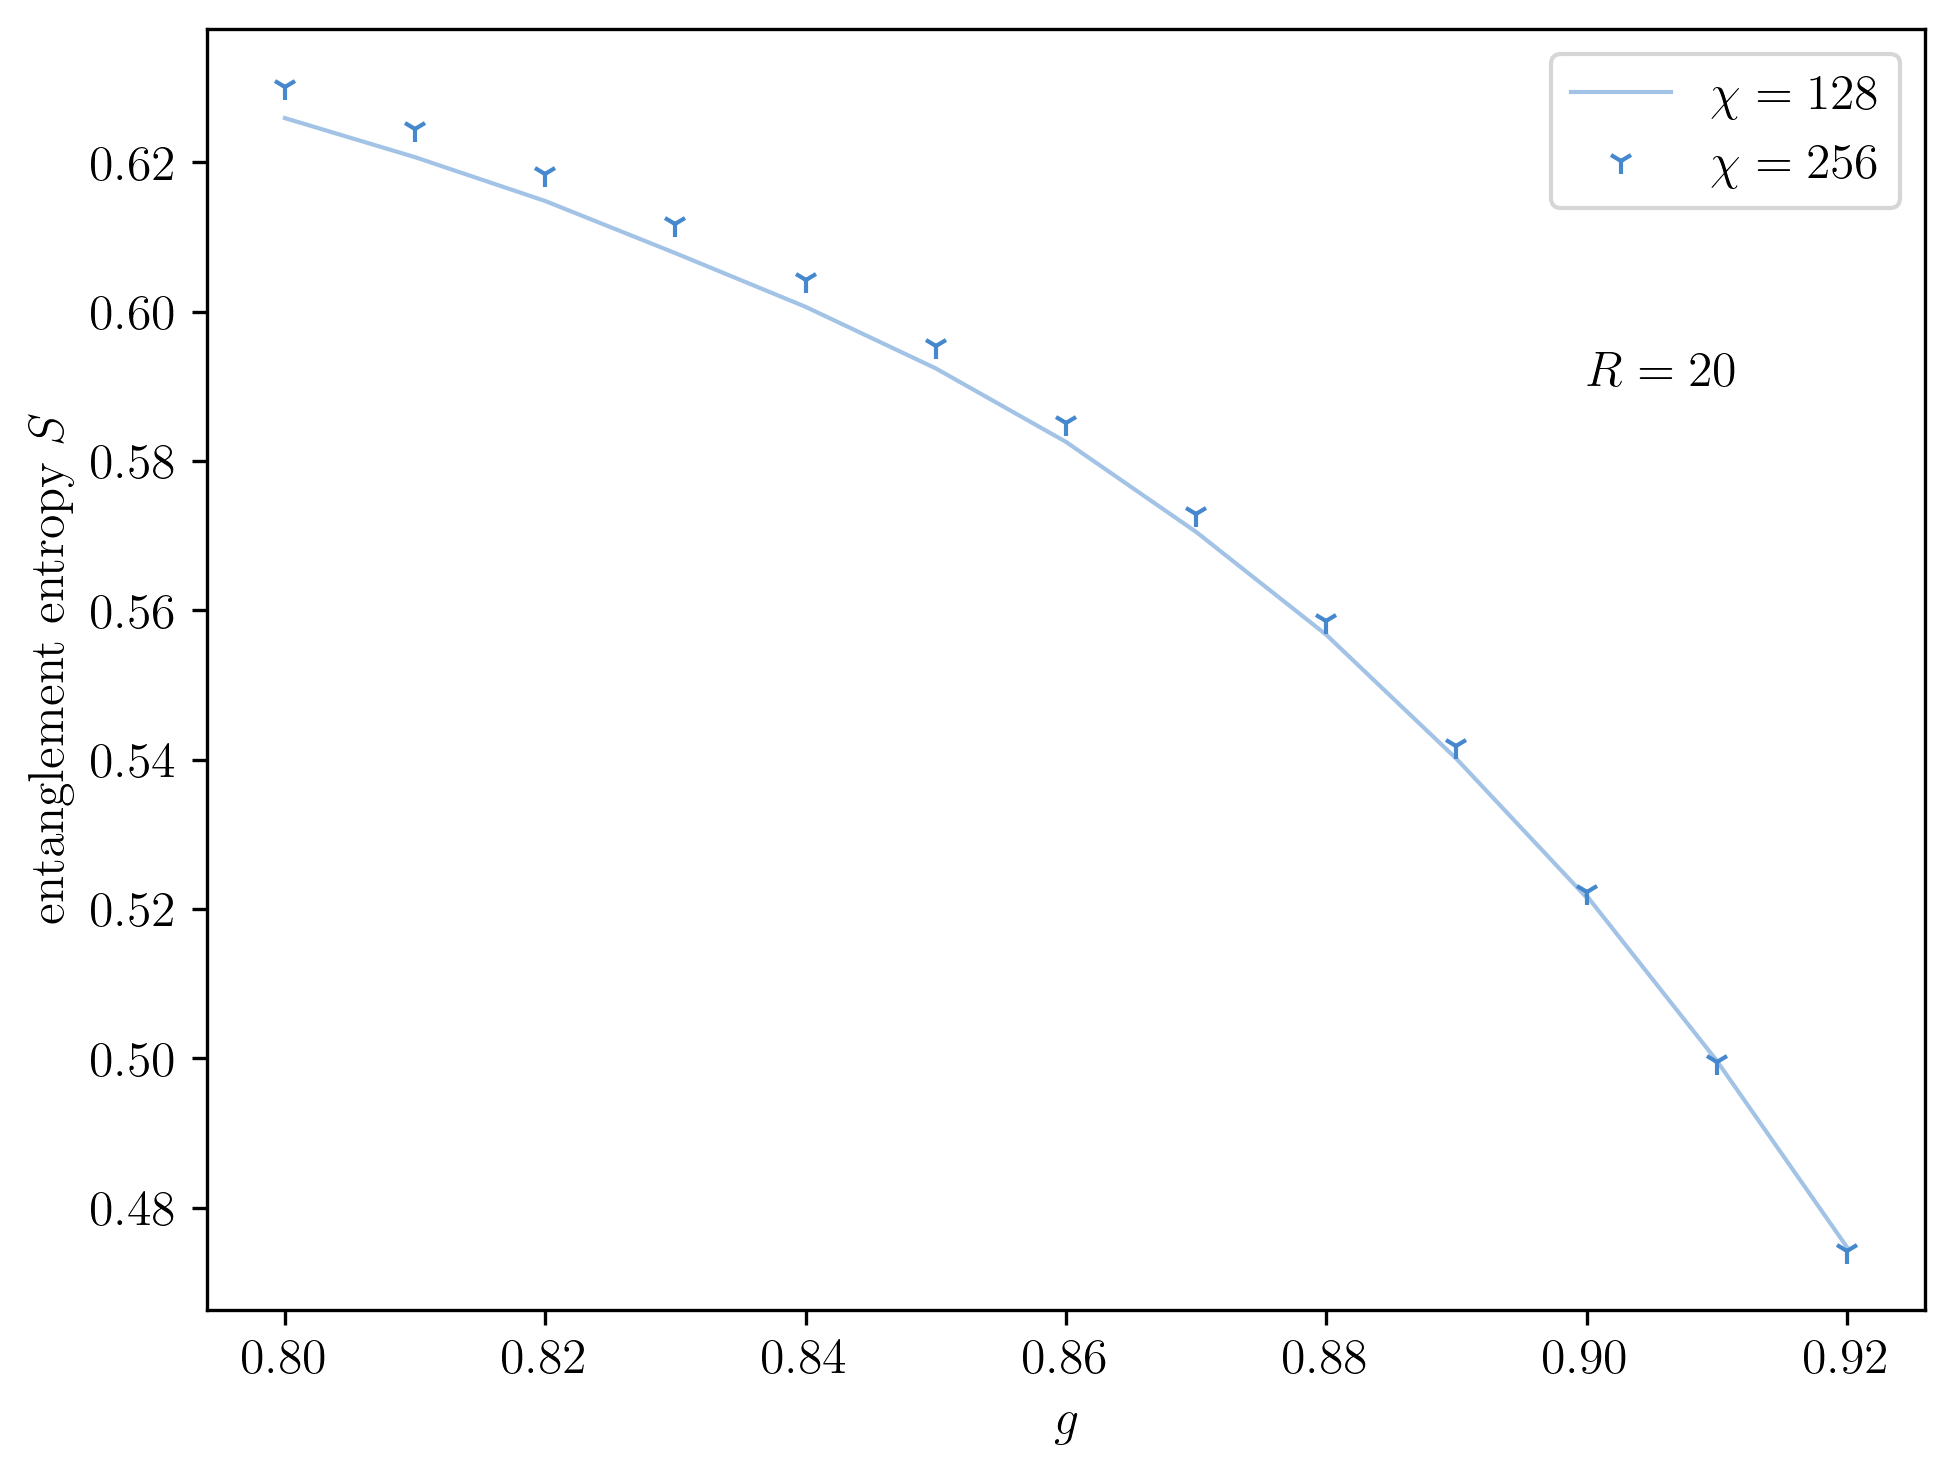

In [92]:
R = 20
chi = 128
color = "#4688CE"
npoints, h_i, h_f = 31, 0.6, 0.9
gs = np.linspace(h_i,h_f,npoints)

s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
plt.plot(gs[20:],s_pbc[20:], color=color, linewidth=1, alpha=0.5, linestyle='-', label=f"$\\chi = {chi}$")

npoints, h_i, h_f = 11, 0.9, 1.0
gs = np.linspace(h_i,h_f,npoints)

s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
plt.plot(gs[:3],s_pbc[:3], color=color, linewidth=1, alpha=0.5, linestyle='-')


npoints, h_i, h_f = 2, 0.8, 0.85 
chi = 256
gs = np.linspace(h_i,h_f,npoints)
s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
plt.plot(gs,s_pbc, color=color, linewidth=1, marker='1', linestyle='', label=f"$\\chi = {chi}$")

npoints, h_i, h_f = 4, 0.81, 0.84 
chi = 256
gs = np.linspace(h_i,h_f,npoints)
s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
plt.plot(gs,s_pbc, color=color, linewidth=1, marker='1', linestyle='')

npoints, h_i, h_f = 4, 0.86, 0.89 
chi = 256
gs = np.linspace(h_i,h_f,npoints)
s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
plt.plot(gs,s_pbc, color=color, linewidth=1, marker='1', linestyle='')

npoints, h_i, h_f = 1, 0.9, 0.9 
chi = 256
gs = np.linspace(h_i,h_f,npoints)
s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
plt.plot(gs,s_pbc, color=color, linewidth=1, marker='1', linestyle='')

npoints, h_i, h_f = 2, 0.91, 0.92
chi = 256
gs = np.linspace(h_i,h_f,npoints)
s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
plt.plot(gs,s_pbc, color=color, linewidth=1, marker='1', linestyle='')

plt.text(x=0.9, y=0.59, s=f"$R={R}$")
plt.xlabel(r"$g$")
plt.ylabel("entanglement entropy $S$")
plt.legend()

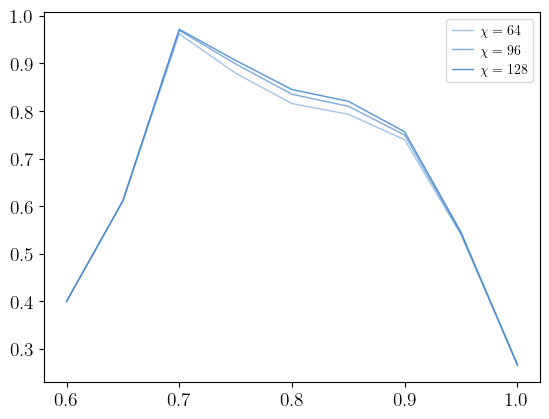

In [14]:
R = 50
chis = [64,96,128]
npoints, h_i, h_f = 9, 0.6, 1.0
gs = np.linspace(h_i,h_f,npoints)
l, L = 4, 70
color = "#4688CE"
for j, chi in enumerate(chis):
    s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
    plt.plot(gs,s_pbc, color=color, linewidth=1, alpha=0.5+0.2*j, linestyle='-', label=f"$\\chi = {chi}$")

# colors = ["yellowgreen", "darkcyan", "firebrick", "darkorchid"]
# Rs = [30,35,40,50]
# for i, R in enumerate(Rs):
#     for j, chi in enumerate(chis):
#         s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
#         plt.plot(gs,s_pbc, color=colors[i], linewidth=1, alpha=0.5+0.2*j, linestyle='-', label=f"$\\chi = {chi}$")
plt.legend()

/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_1308/2655865656.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_1308/2655865656.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


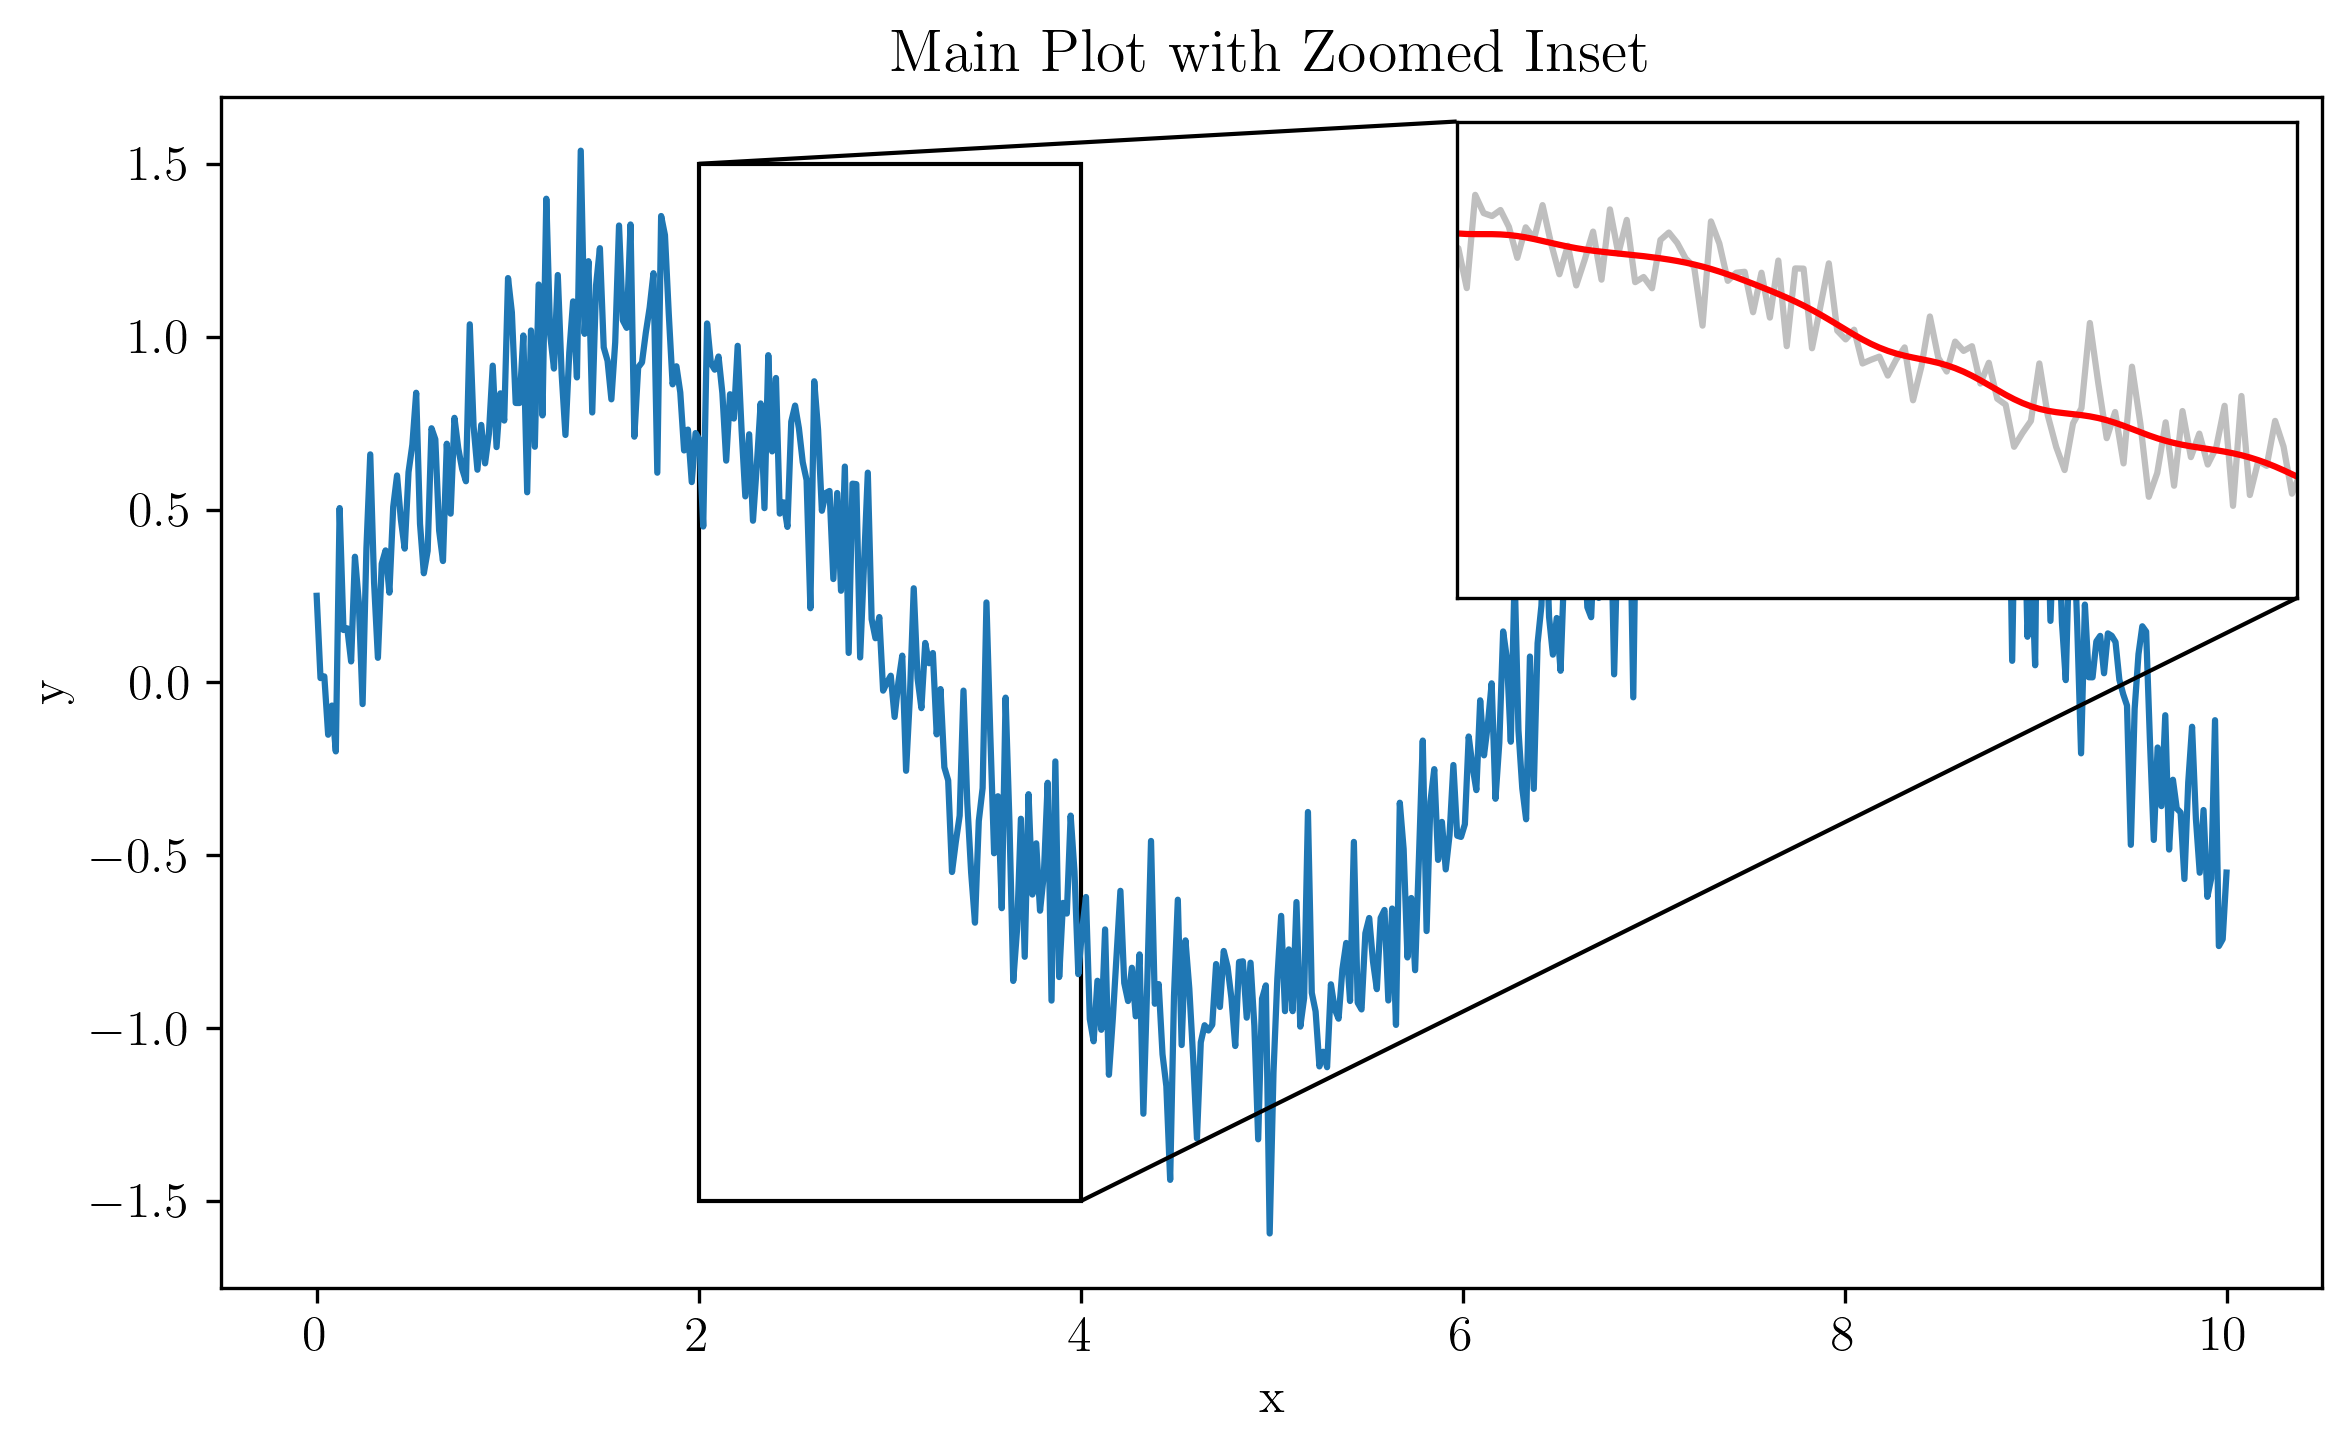

In [ ]:
# Sample data
x = np.linspace(0, 10, 500)
y = np.sin(x) + 0.2 * np.random.randn(500)

# Main plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x, y, label='Noisy Sine Wave')
ax.set_title('Main Plot with Zoomed Inset')
ax.set_xlabel('x')
ax.set_ylabel('y')

# Zoom region
x1, x2 = 2, 4
y1, y2 = -1.5, 1.5

# Inset plot (zoomed)
axins = inset_axes(ax, width="40%", height="40%", loc='upper right')
axins.plot(x, y, color='gray', alpha=0.5)  # Original curve
# Example of "different characteristic": smooth version
from scipy.ndimage import gaussian_filter1d
y_smooth = gaussian_filter1d(y, sigma=5)
axins.plot(x, y_smooth, color='red', label='Smoothed Curve')
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticks([])
axins.set_yticks([])

# Mark the zoomed area with a rectangle and connecting lines
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="black", lw=1)

plt.tight_layout()
plt.show()


/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_1308/3496865228.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_1308/3496865228.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


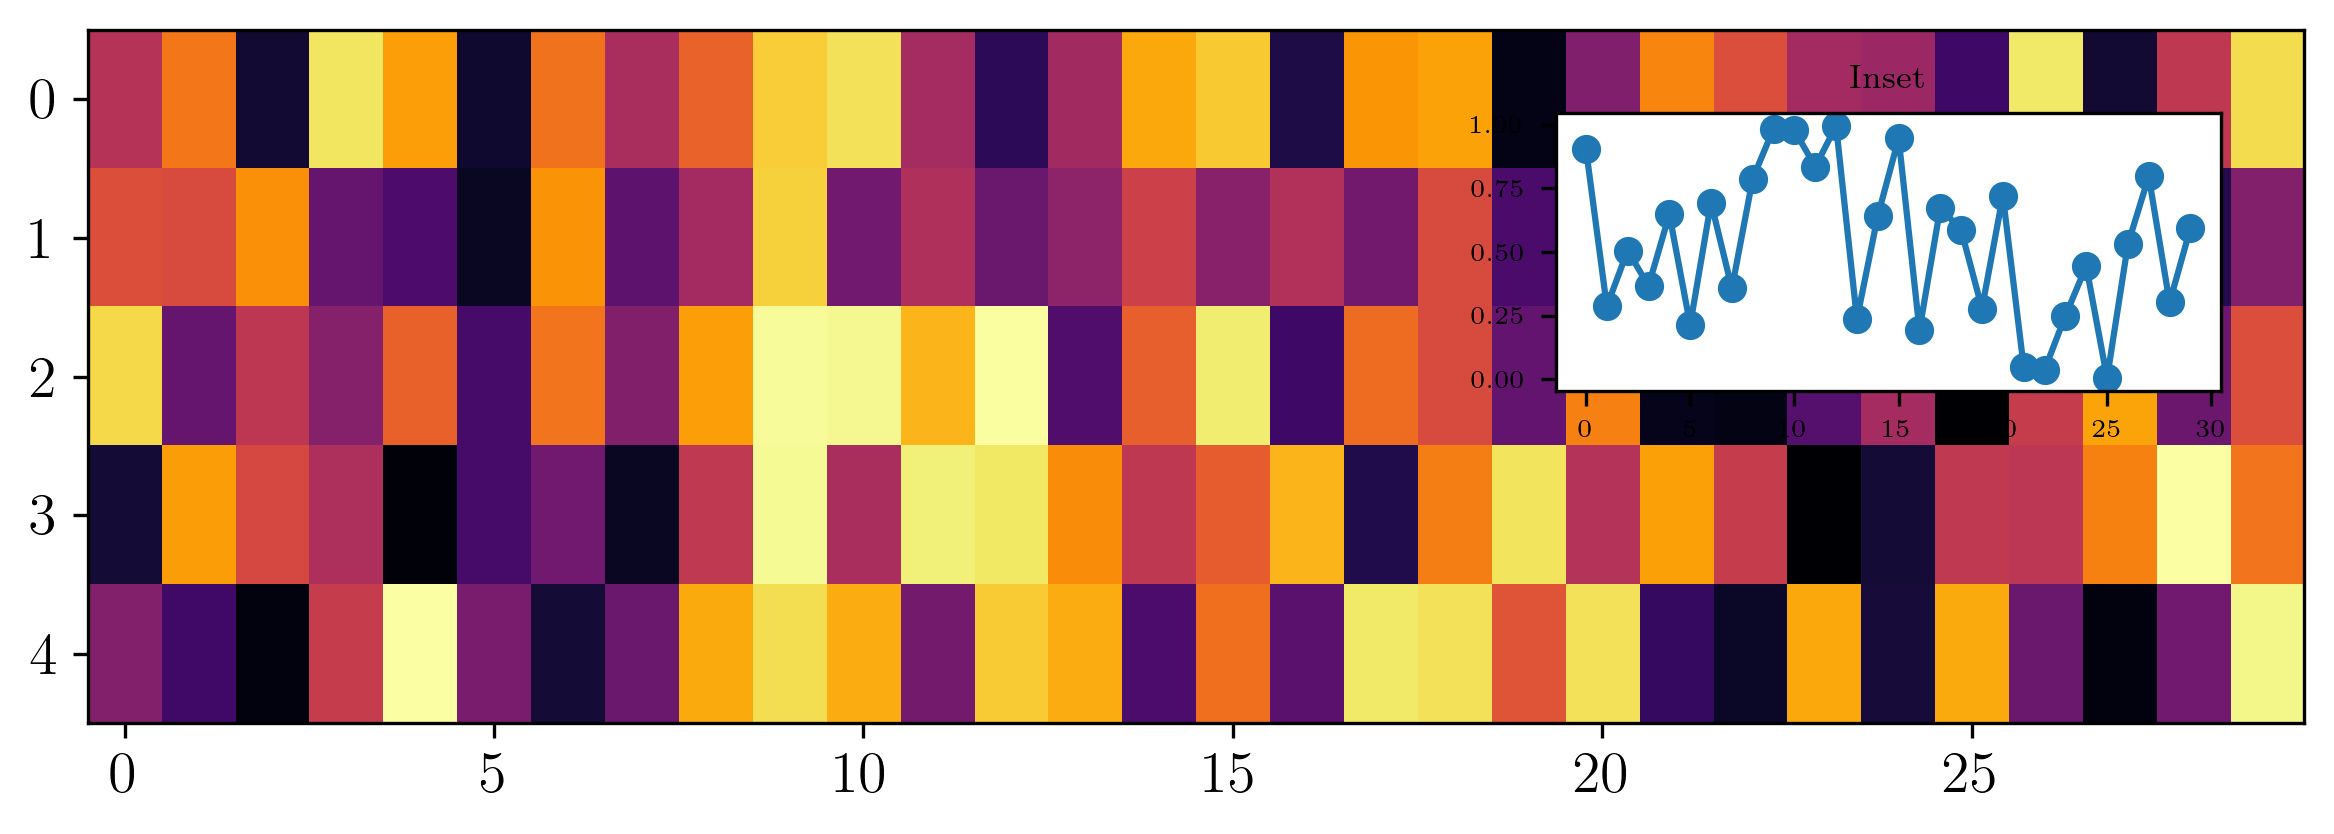

In [767]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np

# Sample data
data = np.random.rand(5, 30)

fig, ax = plt.subplots(figsize=(8, 3))

# Main plot
im = ax.imshow(data, cmap='inferno', vmin=0, vmax=1, aspect='auto')

# Inset plot (small plot inside the main one)
ax_inset = inset_axes(ax, width="30%", height="40%", loc='upper right', borderpad=2)

# Inset content — for example, a slice of the data
ax_inset.plot(data[2], marker='o')
ax_inset.set_title("Inset", fontsize=8)
ax_inset.tick_params(labelsize=6)

plt.tight_layout()
plt.show()

/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_1308/2296221022.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_1308/2296221022.py:96: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


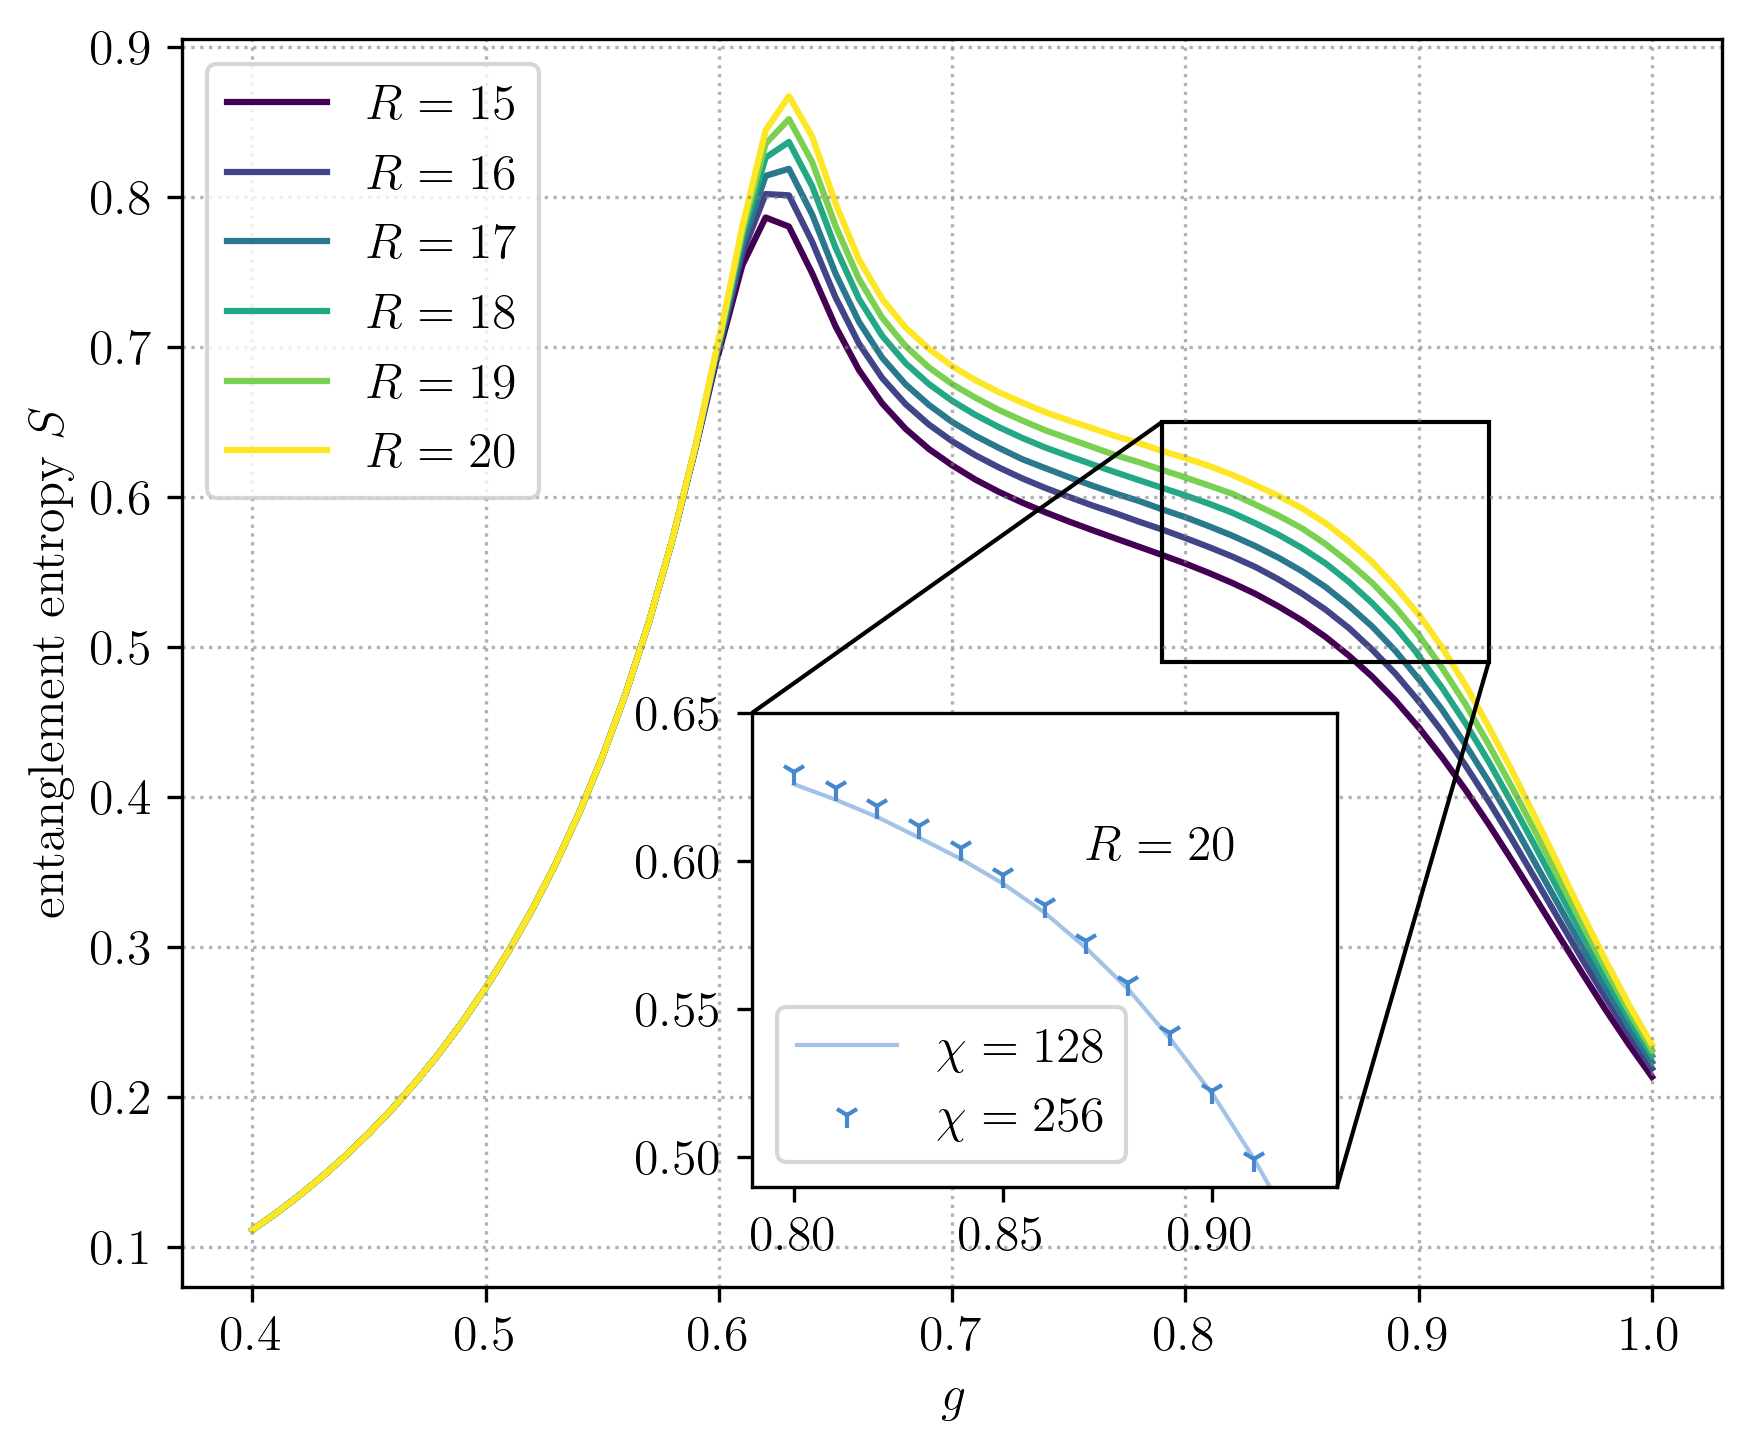

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

fig, ax = plt.subplots(figsize=(6, 5))
ax.grid(color="gray", linestyle=":", alpha=0.6)

chi = 128
npoints, h_i, h_f = 31, 0.6, 0.9 
gs = np.linspace(h_i,h_f,npoints)
Rs = [15,16,17,18,19,20]
colors = create_sequential_colors(len(Rs))
for i, R in enumerate(Rs):
    s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
    ax.plot(gs,s_pbc, color=colors[i], linewidth=1.5, linestyle='-', label=f"$R={R}$", zorder=0)

npoints, h_i, h_f = 21, 0.4, 0.6 
gs = np.linspace(h_i,h_f,npoints)
for i, R in enumerate(Rs):
    s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
    ax.plot(gs,s_pbc, color=colors[i], linewidth=1.5, linestyle='-', zorder=0)

npoints, h_i, h_f = 11, 0.9, 1.0 
gs = np.linspace(h_i,h_f,npoints)
for i, R in enumerate(Rs):
    s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
    ax.plot(gs,s_pbc, color=colors[i], linewidth=1.5, linestyle='-', zorder=0)


# Zoom region
x1, x2 = 0.79, 0.93
y1, y2 = 0.49, 0.65

# Inset plot (zoomed)
axins = inset_axes(ax, width="38%", height="38%", bbox_to_anchor=(0.06, -0.23, 1, 1), 
                   bbox_transform=ax.transAxes, 
                   loc='center')

R = 20
chi = 128
color = "#4688CE"
npoints, h_i, h_f = 31, 0.6, 0.9
gs = np.linspace(h_i,h_f,npoints)

s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
axins.plot(gs[20:],s_pbc[20:], color=color, linewidth=1, alpha=0.5, linestyle='-', label=f"$\\chi = {chi}$")

npoints, h_i, h_f = 11, 0.9, 1.0
gs = np.linspace(h_i,h_f,npoints)

s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
axins.plot(gs[:3],s_pbc[:3], color=color, linewidth=1, alpha=0.5, linestyle='-')


npoints, h_i, h_f = 2, 0.8, 0.85 
chi = 256
gs = np.linspace(h_i,h_f,npoints)
s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
axins.plot(gs,s_pbc, color=color, marker='1', markersize=6, linestyle='', label=f"$\\chi = {chi}$")

npoints, h_i, h_f = 4, 0.81, 0.84 
chi = 256
gs = np.linspace(h_i,h_f,npoints)
s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
axins.plot(gs,s_pbc, color=color, marker='1', markersize=6, linestyle='')

npoints, h_i, h_f = 4, 0.86, 0.89 
chi = 256
gs = np.linspace(h_i,h_f,npoints)
s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
axins.plot(gs,s_pbc, color=color, marker='1', markersize=6, linestyle='')

npoints, h_i, h_f = 1, 0.9, 0.9
chi = 256
gs = np.linspace(h_i,h_f,npoints)
s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
axins.plot(gs,s_pbc, color=color, marker='1', markersize=6, linestyle='')

npoints, h_i, h_f = 2, 0.91, 0.92
chi = 256
gs = np.linspace(h_i,h_f,npoints)
s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
axins.plot(gs,s_pbc, color=color, marker='1', markersize=6, linestyle='')

axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.text(x=0.87, y=0.6, s=f"$R={R}$")

axins.legend()

# Mark the zoomed area with a rectangle and connecting lines
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="black", lw=1)

ax.legend()
ax.set_xlabel(r"$g$")
ax.set_ylabel("entanglement entropy $S$")

fig.tight_layout()
fig.savefig(f"{path_figures}/figures/entropy/entropy_different_Rs_{l}x{L}_chis_128-256.pdf", bbox_inches="tight")


/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_1308/3242603923.py:135: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


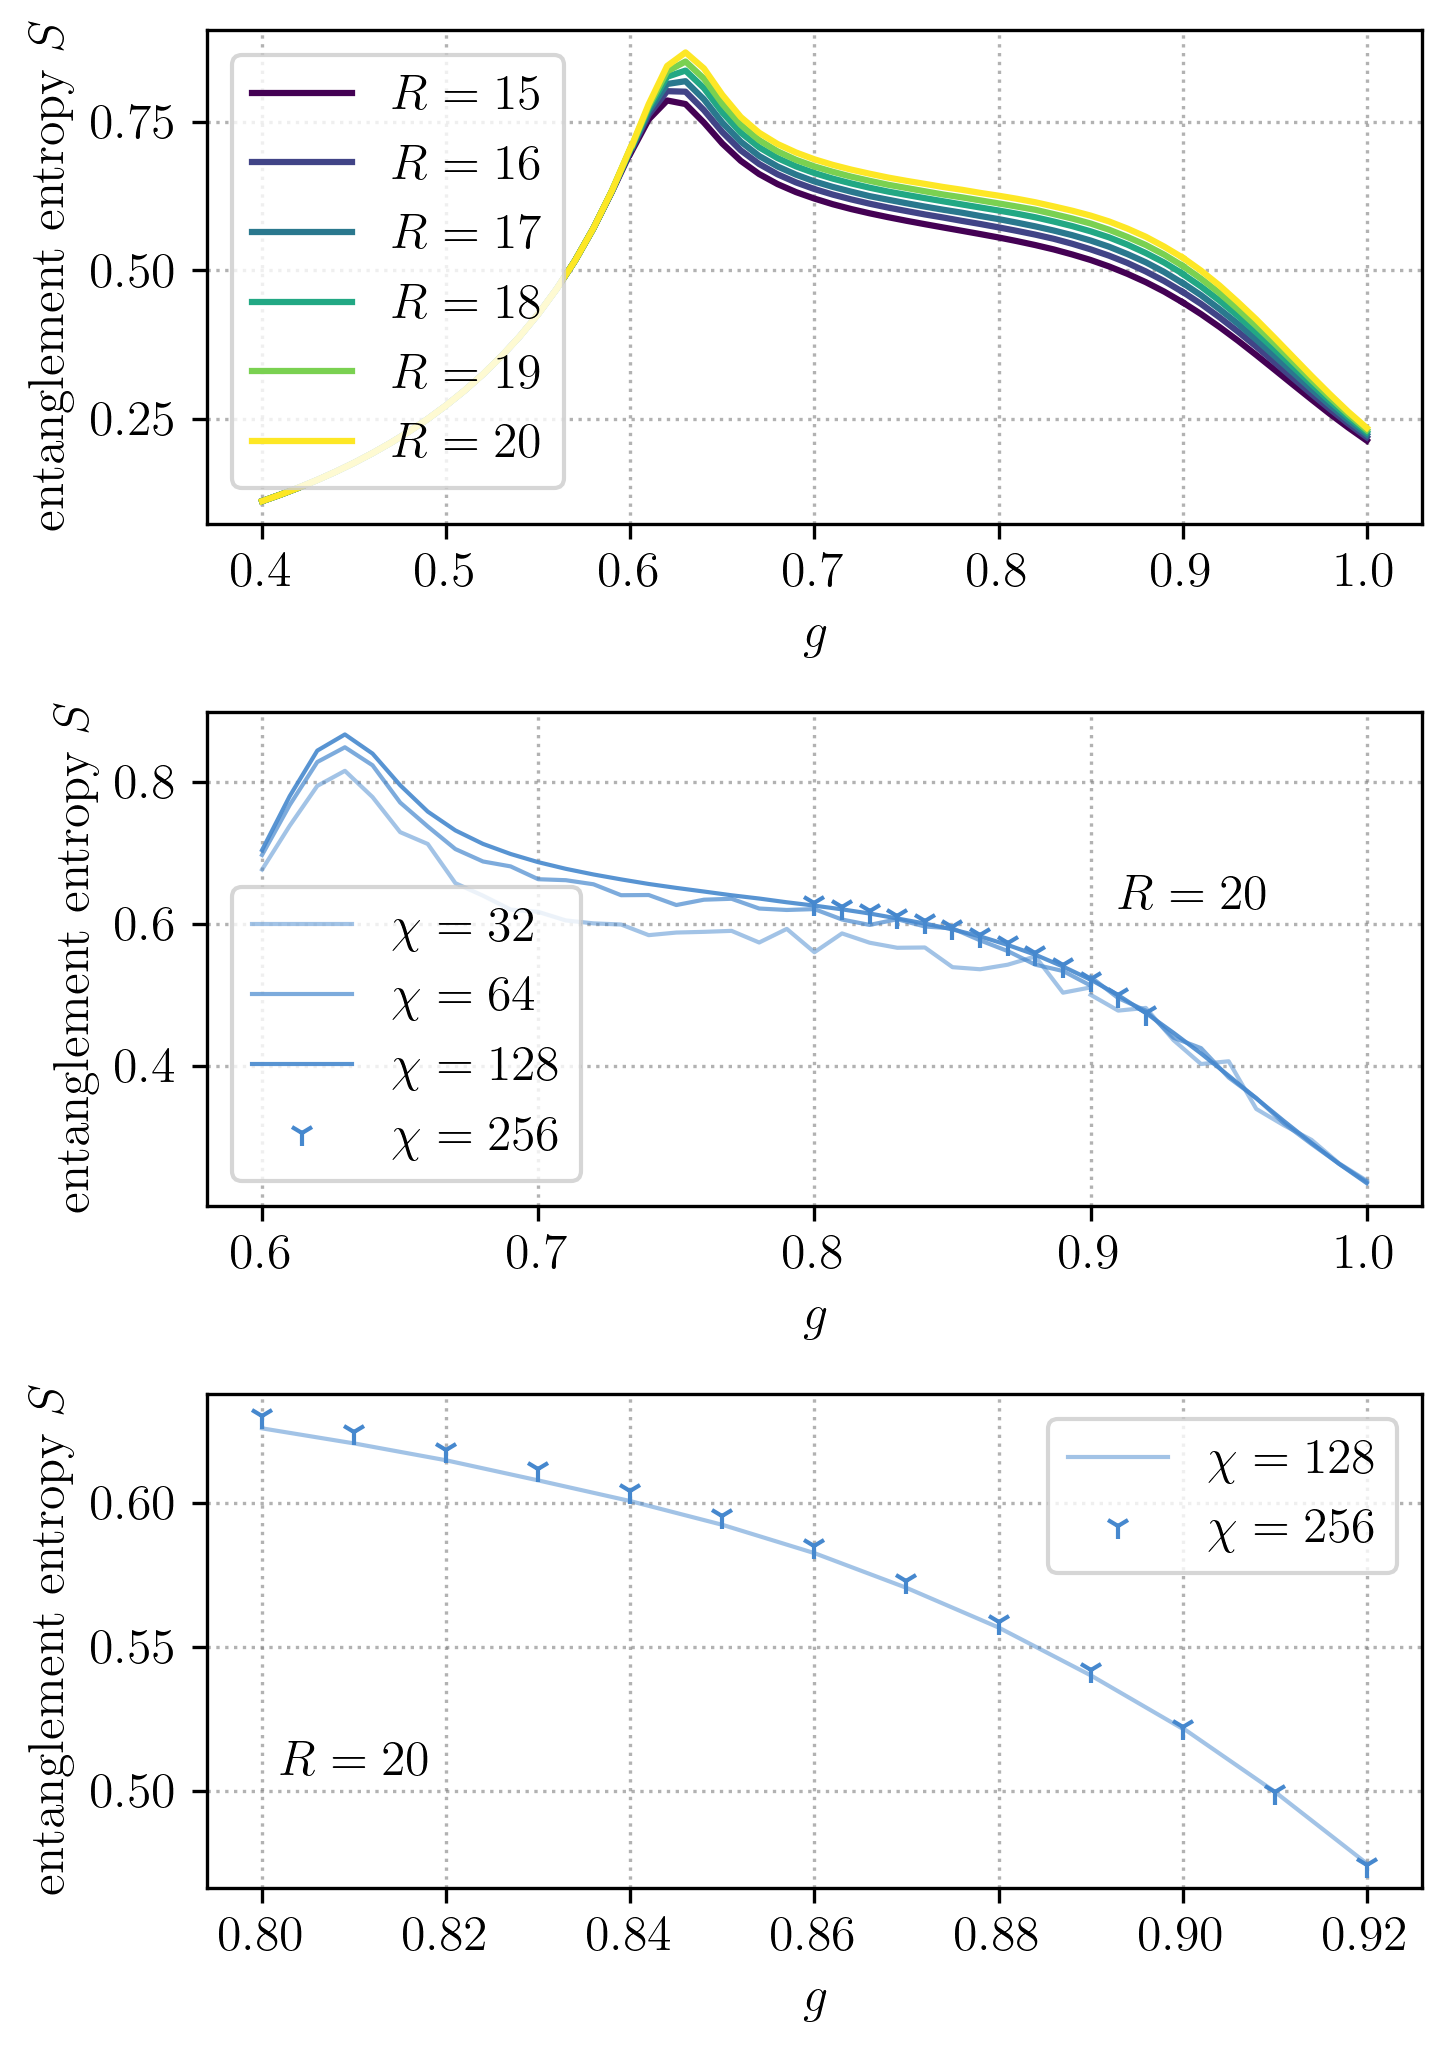

In [406]:
fig, axs = plt.subplots(3, 1, figsize=(5, 7))

for ax in axs:
    ax.grid(color="gray", linestyle=":", alpha=0.6)

chi = 128
npoints, h_i, h_f = 31, 0.6, 0.9 
gs = np.linspace(h_i,h_f,npoints)
Rs = [15,16,17,18,19,20]
colors = create_sequential_colors(len(Rs))
for i, R in enumerate(Rs):
    s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
    axs[0].plot(gs,s_pbc, color=colors[i], linewidth=1.5, linestyle='-', label=f"$R={R}$")

npoints, h_i, h_f = 21, 0.4, 0.6 
gs = np.linspace(h_i,h_f,npoints)
for i, R in enumerate(Rs):
    s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
    axs[0].plot(gs,s_pbc, color=colors[i], linewidth=1.5, linestyle='-')

npoints, h_i, h_f = 11, 0.9, 1.0 
gs = np.linspace(h_i,h_f,npoints)
for i, R in enumerate(Rs):
    s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
    axs[0].plot(gs,s_pbc, color=colors[i], linewidth=1.5, linestyle='-')

axs[0].legend()
axs[0].set_xlabel(r"$g$")
axs[0].set_ylabel("entanglement entropy $S$")


R = 20
chis = [32,64,128]
color = "#4688CE"
npoints, h_i, h_f = 31, 0.6, 0.9
gs = np.linspace(h_i,h_f,npoints)

for j, chi in enumerate(chis):
    s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
    axs[1].plot(gs,s_pbc, color=color, linewidth=1, alpha=0.5+0.2*j, linestyle='-', label=f"$\\chi = {chi}$")

npoints, h_i, h_f = 11, 0.9, 1.0
gs = np.linspace(h_i,h_f,npoints)

for j, chi in enumerate(chis):
    s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
    axs[1].plot(gs,s_pbc, color=color, linewidth=1, alpha=0.5+0.2*j, linestyle='-')

npoints, h_i, h_f = 2, 0.8, 0.85 
chi = 256
gs = np.linspace(h_i,h_f,npoints)
s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
axs[1].plot(gs,s_pbc, color=color, linewidth=1, marker='1', linestyle='', label=f"$\\chi = {chi}$")

npoints, h_i, h_f = 4, 0.81, 0.84 
chi = 256
gs = np.linspace(h_i,h_f,npoints)
s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
axs[1].plot(gs,s_pbc, color=color, linewidth=1, marker='1', linestyle='')

npoints, h_i, h_f = 4, 0.86, 0.89 
chi = 256
gs = np.linspace(h_i,h_f,npoints)
s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
axs[1].plot(gs,s_pbc, color=color, linewidth=1, marker='1', linestyle='')

npoints, h_i, h_f = 1, 0.9, 0.9 
chi = 256
gs = np.linspace(h_i,h_f,npoints)
s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
axs[1].plot(gs,s_pbc, color=color, linewidth=1, marker='1', linestyle='')

npoints, h_i, h_f = 2, 0.91, 0.92 
chi = 256
gs = np.linspace(h_i,h_f,npoints)
s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
axs[1].plot(gs,s_pbc, color=color, linewidth=1, marker='1', linestyle='')

axs[1].legend()
axs[1].set_xlabel(r"$g$")
axs[1].set_ylabel("entanglement entropy $S$")
axs[1].text(x=0.91, y=0.62, s=f"$R={R}$")

R = 20
chi = 128
color = "#4688CE"
npoints, h_i, h_f = 31, 0.6, 0.9
gs = np.linspace(h_i,h_f,npoints)

s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
axs[2].plot(gs[20:],s_pbc[20:], color=color, linewidth=1, alpha=0.5, linestyle='-', label=f"$\\chi = {chi}$")

npoints, h_i, h_f = 11, 0.9, 1.0
gs = np.linspace(h_i,h_f,npoints)

s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
axs[2].plot(gs[:3],s_pbc[:3], color=color, linewidth=1, alpha=0.5, linestyle='-')


npoints, h_i, h_f = 2, 0.8, 0.85 
chi = 256
gs = np.linspace(h_i,h_f,npoints)
s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
axs[2].plot(gs,s_pbc, color=color, linewidth=1, marker='1', linestyle='', label=f"$\\chi = {chi}$")

npoints, h_i, h_f = 4, 0.81, 0.84 
chi = 256
gs = np.linspace(h_i,h_f,npoints)
s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
axs[2].plot(gs,s_pbc, color=color, linewidth=1, marker='1', linestyle='')

npoints, h_i, h_f = 4, 0.86, 0.89 
chi = 256
gs = np.linspace(h_i,h_f,npoints)
s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
axs[2].plot(gs,s_pbc, color=color, linewidth=1, marker='1', linestyle='')

npoints, h_i, h_f = 1, 0.9, 0.9 
chi = 256
gs = np.linspace(h_i,h_f,npoints)
s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
axs[2].plot(gs,s_pbc, color=color, linewidth=1, marker='1', linestyle='')

npoints, h_i, h_f = 2, 0.91, 0.92
chi = 256
gs = np.linspace(h_i,h_f,npoints)
s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
axs[2].plot(gs,s_pbc, color=color, linewidth=1, marker='1', linestyle='')

axs[2].legend()
axs[2].set_xlabel(r"$g$")
axs[2].set_ylabel("entanglement entropy $S$")
axs[2].text(x=0.802, y=0.505, s=f"$R={R}$")

fig.tight_layout()
fig.savefig(f"{path_figures}/figures/entropy/entropy_different_zooms_{l}x{L}_chis_32-64-128-256.pdf", bbox_inches="tight")

### EE obc vs pbc in two-particle sector

0.8500000000000001
0.8300000000000001
cy given: [3, 3]
0.8137931034482759


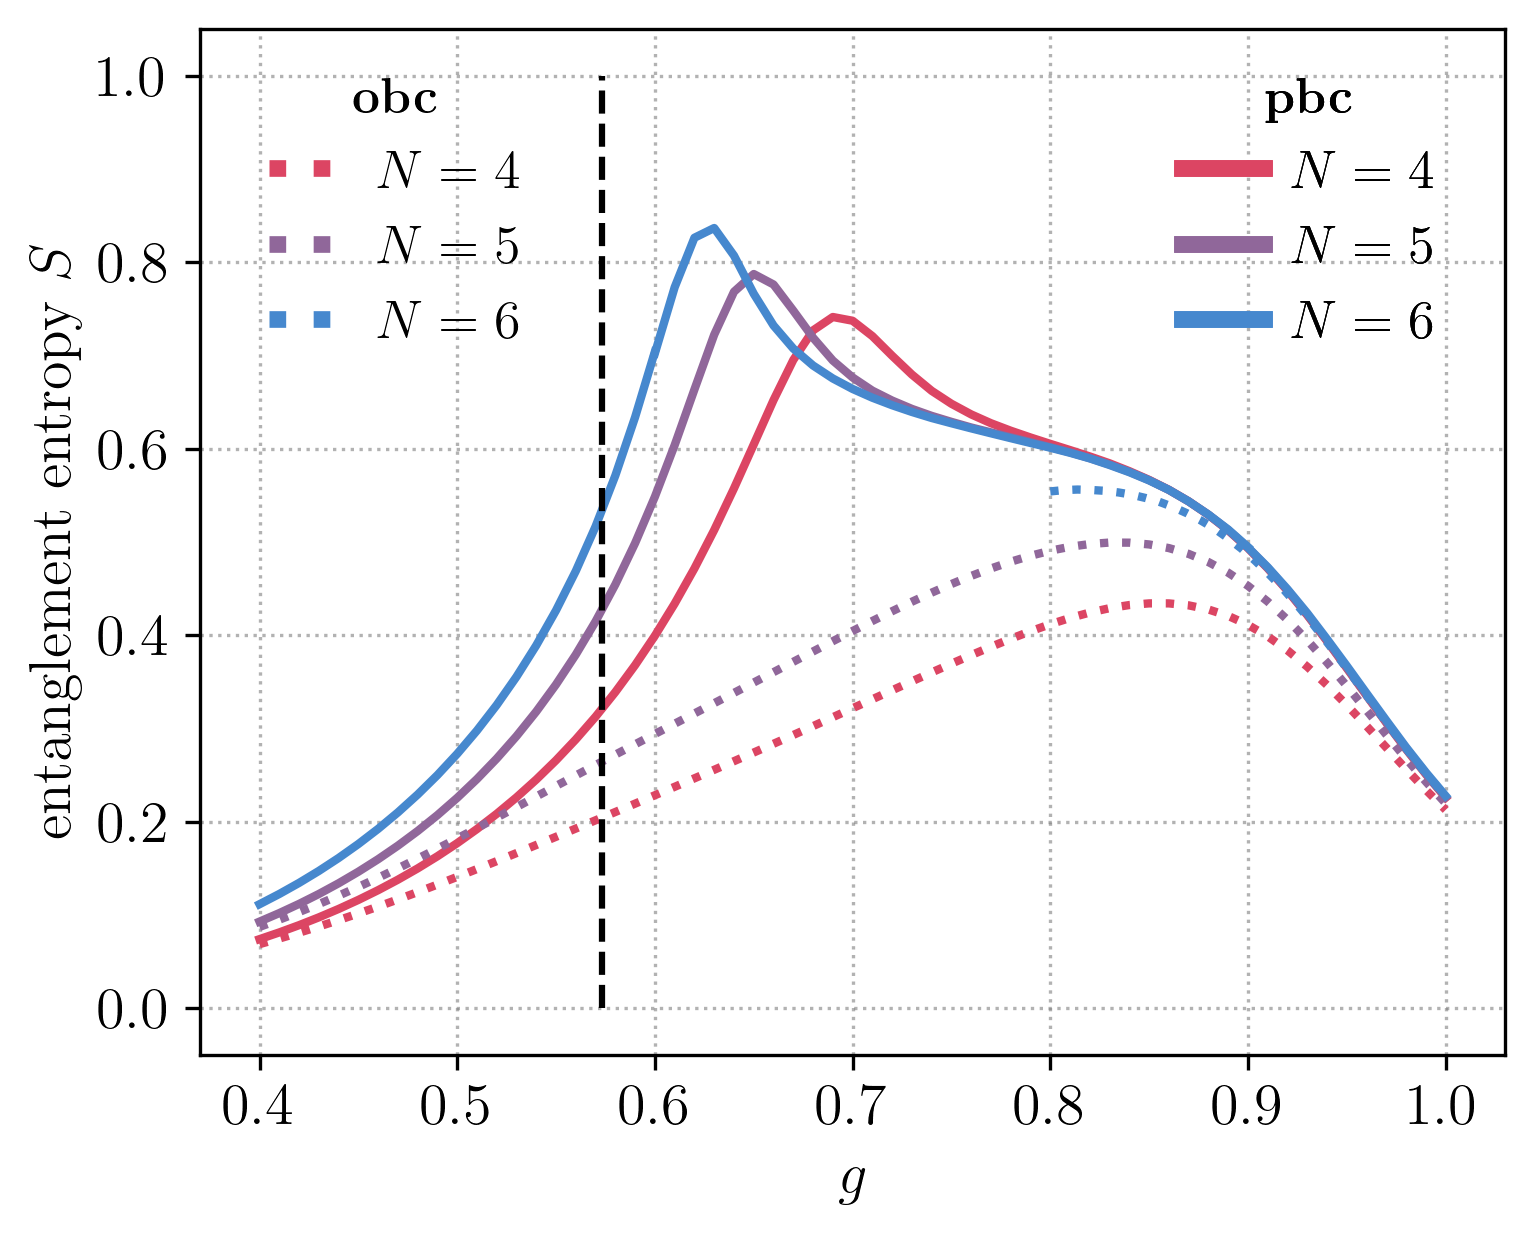

In [760]:
colors = ["yellowgreen", "darkcyan", "firebrick", "darkorchid"]
colorss = [["#4688CE","#4696CE","#46A8CE","#46CACF"],["#AD5A85","#C86799","#E575AF","#FF82C3"],["#90679A","#A979B5","#C78FD5","#DD9FEC"],["#DC4563","#E45A70","#ED7580","#F68F8F"]]
colorss.reverse()

fig, ax = plt.subplots(figsize=(5, 4))
ax.grid(color="gray", linestyle=":", alpha=0.6)

chi = 128
npoints, h_i, h_f = 61, 0.4, 1.0
interval = np.linspace(h_i,h_f,npoints)
gs = interval
ls = [4,5]
L = 30
R_vac = 0
R = 18
Rs = [18, 20, 22, 24]
sector_vac = "vacuum_sector"
sector = "2_particle(s)_sector"
# cx = None
# cy = None


for i, l in enumerate(ls):
    bc = "obc"
    s_obc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
    idx_max = np.argmax(s_obc)
    print(gs[idx_max])
    ax.plot(gs,s_obc, color=colorss[i][0], linewidth=2, markersize=5, linestyle=':', label=f"$l: {l}, \chi: {chi}$")
    
    bc = "pbc"
    # s_vac = entropy(R_vac,l,L,chi,bc,sector_vac,h_i,h_f,npoints,path_tensor)
    s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
    ax.plot(gs,s_pbc, color=colorss[i][0], linewidth=2, markersize=5, linestyle='-', label=f"$l: {l}, \chi: {chi}$")
    # ax.plot(gs,s_vac, color=colors[i], linewidth=1, markersize=5, linestyle='-', label=f"vacuum $l: {l}$")


# free param
L = 30
# secondary fixed params

# fixed params
l = 6
i = 3

bc = "obc"

npoints, h_i, h_f = 30, 0.8, 1.0
# npoints, h_i, h_f = 51, 0.6, 1.2
chi = 128
# chi = 32
gs = np.linspace(h_i,h_f,npoints)
path_drive = "/Users/fradm/Google Drive/My Drive/projects/1_Z2"
s_obc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path_drive, cy=[3,3])
idx_max = np.argmax(s_obc)
print(gs[idx_max])
ax.plot(gs,s_obc, color=colorss[i][0], linewidth=2, markersize=5, linestyle=':', label=f"$l: {l}, \chi: {chi}$")

bc = "pbc"
chi = 128
npoints, h_i, h_f = 21, 0.4, 0.6
gs = np.linspace(h_i,h_f,npoints)
s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
ax.plot(gs,s_pbc, color=colorss[i][0], linewidth=2, markersize=5, linestyle='-', label=f"$l: {l}, \chi: {chi}$")

npoints, h_i, h_f = 31, 0.6, 0.9
gs = np.linspace(h_i,h_f,npoints)
s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
ax.plot(gs,s_pbc, color=colorss[i][0], linewidth=2, markersize=5, linestyle='-')

npoints, h_i, h_f = 11, 0.9, 1.0
gs = np.linspace(h_i,h_f,npoints)
s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
ax.plot(gs,s_pbc, color=colorss[i][0], linewidth=2, markersize=5, linestyle='-')

ax.vlines(x=0.5731, ymin=0, ymax=1, linestyles="--", colors='black', linewidth=1.5, label="deconfinement $g_c$")

ls = [4,5,6]

from matplotlib.lines import Line2D
# Create legend handles
colors = ["#DC4563","#90679A","#4688CE"]
handles1 = [Line2D([0], [0], color=colors[i], lw=4, ls=":", label=f'$N = {ls[i]}$') for i in range(len(ls))]
handles2 = [Line2D([0], [0], color=colors[i], lw=4, label=f'$N = {ls[i]}$') for i in range(len(ls))]

# Create the two separate legends
legend1 = ax.legend(handles=handles1, title='$\\bf{obc}$', loc='upper center',
                    bbox_to_anchor=(0.15, 1), frameon=False, fontsize=13)
legend2 = ax.legend(handles=handles2, title='$\\bf{pbc}$', loc='upper center',
                    bbox_to_anchor=(0.85, 1), frameon=False, fontsize=13)



ax.set_xlabel(r"$g$")
ax.set_ylabel("entanglement entropy $S$")
# Add both legends to the figure manually
fig.add_artist(legend1)
fig.add_artist(legend2)

# fig.tight_layout()
fig.savefig(f"{path_figures}/figures/potential/obc_vs_pbc_entropy.pdf", bbox_inches='tight', format='pdf')

### final plot - EE vs N,R

N = 4, Rmax = 20
N = 5, Rmax = 20
N = 6, Rmax = 20


/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_1308/1787304263.py:147: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


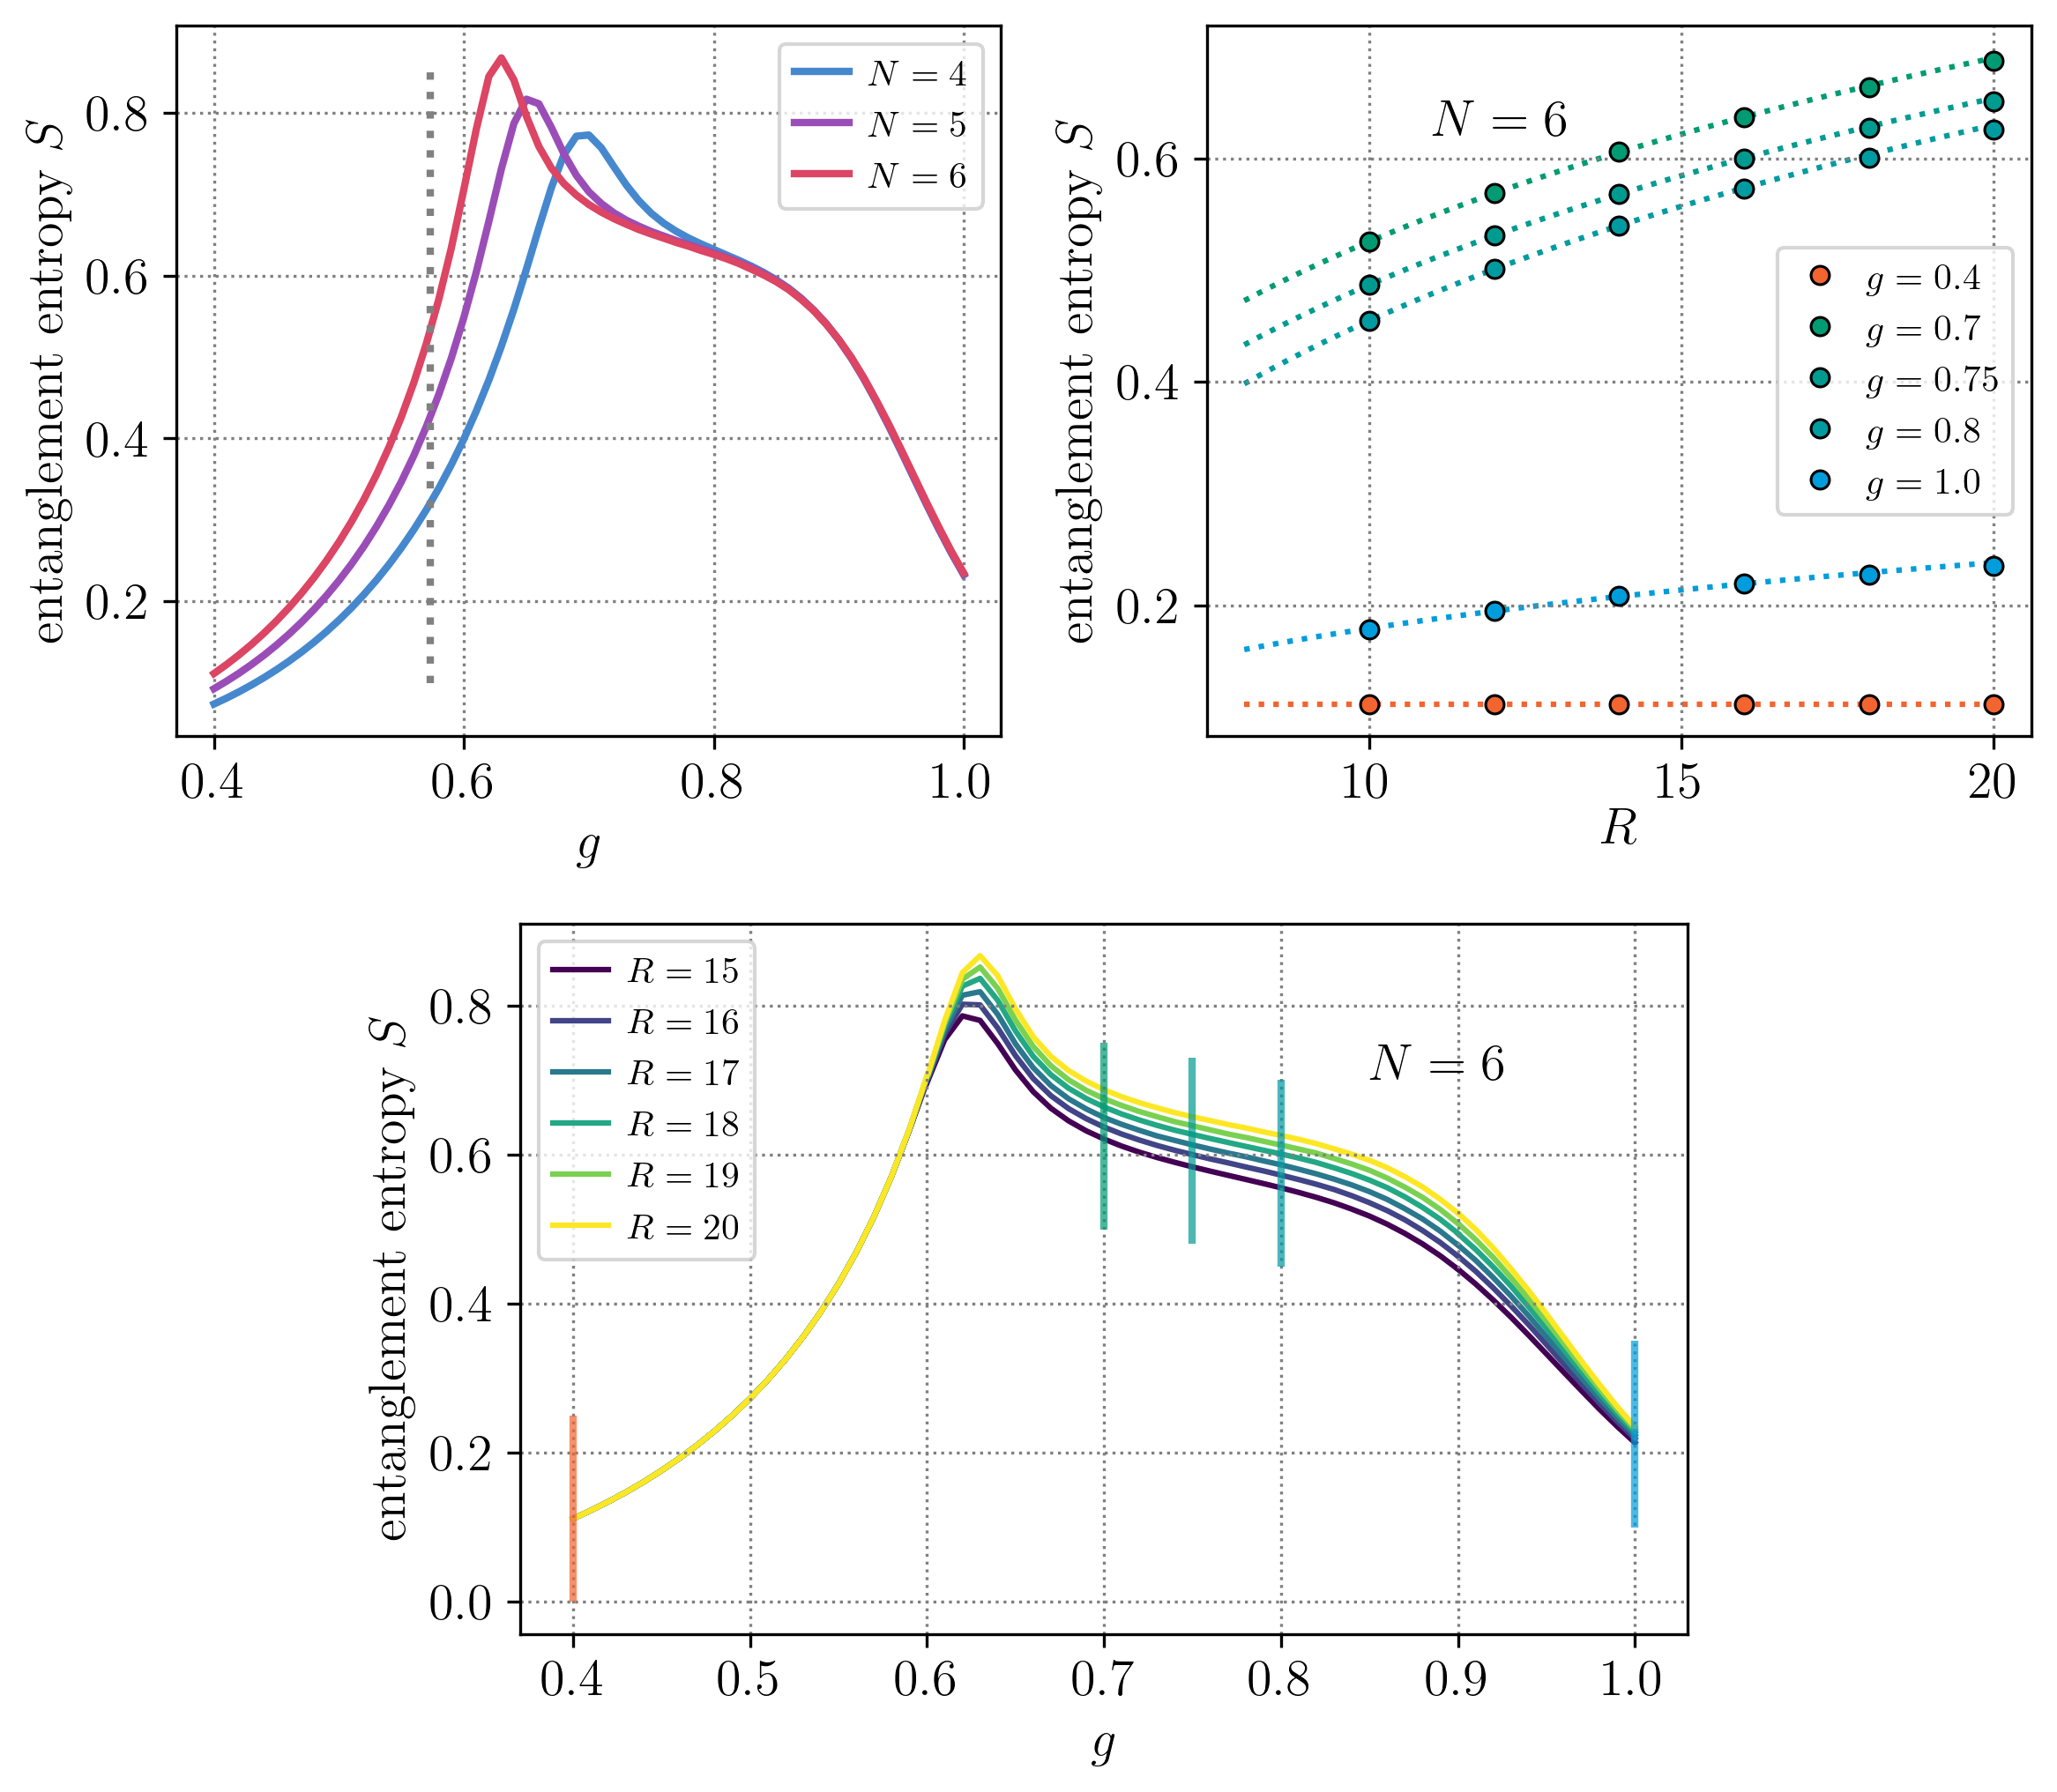

In [ ]:
# Matplotlib settings

plt.rcParams.update({
    'font.family': 'serif', 
    'font.size': 14,
    'text.usetex': True,
    'legend.handlelength': 1.5,
    'legend.handletextpad': 0.5,
    'legend.title_fontsize': 12,
    'legend.fontsize': 10
})

marker_opts = dict(
    marker='o',
    markeredgecolor='k',
    markeredgewidth=0.75,
    markersize=5,
    linestyle='',
)

theor_gc = 1 / np.sqrt(3.04438)
R_max = [20,20,20]

h_i, h_f, npoints = 0.4, 1.0, 61
gs = np.linspace(h_i, h_f, npoints)
chis = [64,128]


# Create the figure
fig = plt.figure(figsize=(8, 7))

# Create a 2x4 grid
grdsp = gridspec.GridSpec(2, 6, width_ratios=[1, 1, 1, 1, 1, 1], height_ratios=[1, 1])


# Top row: two images side by side
ax1 = fig.add_subplot(grdsp[0, 0:3])  # Top-left
ax1.grid(color="gray", linestyle=":")

colors = ["#4688CE","#9B4DB7","#DC4563"]

# String width vs coupling
i = 0
for N in [4, 5, 6]:
    Rmax = R_max[i]
    if N == 6:
        h_i,h_f,npoints=0.4,0.6,21
        s_pbc1 = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)

        h_i,h_f,npoints=0.6,0.9,31
        s_pbc2 = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)

        h_i,h_f,npoints=0.9,1.0,11
        s_pbc3 = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)

        gs = np.linspace(0.4,0.6,21).tolist() + np.linspace(0.6,0.9,31)[1:].tolist() + np.linspace(0.9,1.0,11)[1:].tolist()
        s_pbc = s_pbc1 + s_pbc2[1:] + s_pbc3[1:]
    else:
        s_pbc = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)
    print(f"N = {N}, Rmax = {Rmax}")
    # axs[0].plot(gs,s_pbc, color=colors[i], linewidth=2, markersize=5, linestyle='-', label=f"$N: {N}, \chi: {chi}$")
    ax1.plot(gs, s_pbc, color=colors[i], label=f"$N = {N}$", linewidth=2)
    i += 1
ax1.legend()
ax1.set_xlabel("$g$")
ax1.set_ylabel("entanglement entropy $S$")
ax1.vlines(theor_gc, 0.1, 0.85, 'grey', ':', linewidth=2)
# axs[0].set_ylim(1, 4)


ax2 = fig.add_subplot(grdsp[0, 3:6])  # Top-right
ax2.grid(color="gray", linestyle=":")

colors = ["#F26430", "#009B72", "#009B90", "#009BA1", "#009DDC"]

# String width vs separation R
k = 0
coupls = [1.0, 0.9, 0.8, 0.7, 0.4]
coupls = [1.0, 0.8, 0.7, 0.4]
coupls = [0.4, 0.7, 0.75, 0.8, 1.0]
idxs = [0, 10, 15, 20, 10]
his = [0.4,0.6,0.6,0.6,0.9]
hfs = [0.6,0.9,0.9,0.9,1.0]
npointss = [21,31,31,31,11]
Rs = [10,12,14,16,18,20]

def log_fit(R, a, b):
    return a*np.log(R) + b

for g, h_i, h_f, npoints, idx in zip(coupls, his, hfs, npointss, idxs):

    entrs_g_max = [entropy(R,N,L,chis[1],bc,sector,h_i,h_f,npoints,path)[idx] for R in Rs]
    entrs_g_min = [entropy(R,N,L,chis[0],bc,sector,h_i,h_f,npoints,path)[idx] for R in Rs]
    entrs_g = entrs_g_max.copy()
    entrs_g_err = [np.abs(entrs_g_max[i] - entrs_g_min[i]) for i in range(len(Rs))]
    ax2.plot(Rs, entrs_g, color=colors[k], label=f"$g = {g}$", **marker_opts)
    
    plog, clog = curve_fit(log_fit, Rs, entrs_g, sigma=entrs_g_err)
    x_fit = np.linspace(8,20)
    ax2.plot(x_fit, log_fit(x_fit,*plog), color=colors[k], linestyle=':', zorder=0)
    k += 1

ax2.set_xlabel(r"$R$", labelpad=0)
ax2.set_ylabel("entanglement entropy $S$")
ax2.text(11, 0.62, f"$N = {N}$")
ax2.legend()

# Bottom row: one plot centered in columns [1,2]
fig.add_subplot(grdsp[1, 0]).axis('off')  # left spacer
ax3 = fig.add_subplot(grdsp[1, 1:5])      # centered plot
fig.add_subplot(grdsp[1, 5]).axis('off')  # right spacer
ax3.grid(color="gray", linestyle=":")

chi = 128
npoints, h_i, h_f = 31, 0.6, 0.9 
gs = np.linspace(h_i,h_f,npoints)
Rs = [15,16,17,18,19,20]
colors = create_sequential_colors(len(Rs))
for i, R in enumerate(Rs):
    s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
    ax3.plot(gs,s_pbc, color=colors[i], linewidth=1.5, linestyle='-', label=f"$R={R}$", zorder=0)

npoints, h_i, h_f = 21, 0.4, 0.6 
gs = np.linspace(h_i,h_f,npoints)
for i, R in enumerate(Rs):
    s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
    ax3.plot(gs,s_pbc, color=colors[i], linewidth=1.5, linestyle='-', zorder=0)

npoints, h_i, h_f = 11, 0.9, 1.0 
gs = np.linspace(h_i,h_f,npoints)
for i, R in enumerate(Rs):
    s_pbc = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
    ax3.plot(gs,s_pbc, color=colors[i], linewidth=1.5, linestyle='-', zorder=0)

colors = ["#F26430", "#009B72", "#009B90", "#009BA1", "#009DDC"]
ranges = [(0.00,0.25),(0.50,0.75),(0.48,0.73),(0.45,0.70),(0.10,0.35)]
for i in range(len(coupls)):
    ax3.vlines(coupls[i], ranges[i][0], ranges[i][1], linestyle='-', color=colors[i], alpha=0.7, linewidth=2)

# Add the legend to the main plot instead
ax3.set_xlabel(r"$g$")
ax3.set_ylabel("entanglement entropy $S$")
ax3.text(0.85, 0.7, f"$N = {N}$")
ax3.legend()

fig.tight_layout()
fig.savefig(f"{path_figures}/figures/entropy/entanglement_entropy_2p_sector_three_plots.pdf", bbox_inches='tight', format='pdf')

### central charge

In [ ]:
def cft_entr(R, a,b):
    return a*np.log2(R) + b

l, L = 6, 30
chi = 256
h_i, h_f, npoints = 0.8, 0.9, 11
gs = np.linspace(h_i,h_f,npoints)
Rs = [15,16,17,18,19,20]

l, L = 5, 50
chi = 128
h_i, h_f, npoints = 0.8, 0.9, 11
gs = np.linspace(h_i,h_f,npoints)
Rs = [25,26,27,28,29,30]

where = L // 2

entr_R = []
for i, R in enumerate(Rs):
    cx = get_cx(L,R)
    cy = get_cy(l,bc,R=R)
    # s = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path)
    s = np.load(f"{path}/results/entropy_data/{where}_bond_entropy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")
    entr_R.append(s)

entr_R = np.array(entr_R)
x_data = Rs.copy()

ccs = []
ccs_err = []
for i, g in enumerate(gs):
    print(f"g: {g}")
    y_data = entr_R[:,i]

    popt, copt = curve_fit(cft_entr, x_data, y_data)
    cc = popt[0]*6
    err = np.sqrt(np.diag(copt))[0]
    print(f"central charge is: {cc:.6f}")
    ccs.append(cc)
    ccs_err.append(err)

plt.plot(gs, ccs)
plt.fill_between(gs, np.asarray(ccs)+np.asarray(ccs_err), np.asarray(ccs)+np.asarray(ccs_err))

In [26]:
def cft_entr(R, a,b):
    return a*np.log2(R) + b

def central_charge_plot(Rs, l, chis, L, bc, sector, h_i, h_f, npoints, path_tensor, color, label=True):
    cc = []
    cc_err = []
    entr_g = []
    entr_g_err = []
    x_data = Rs
    for i, R in enumerate(Rs):
        entr_g_chi = []
        for chi in chis:
            s = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path_tensor)
            entr_g_chi.append(s)
        entr_g.append(entr_g_chi[-1])
        if len(chis) > 1:
            entr_g_err.append(np.abs(np.asarray(entr_g_chi[-2]) - np.asarray(entr_g_chi[-1])))
        else:
            entr_g_err = None

    entr_g = np.array(entr_g).T
    entr_g_err = np.array(entr_g_err).T
    for i, g in enumerate(gs):
        y_data = entr_g[i]
        popt, copt = curve_fit(cft_entr, x_data, y_data, sigma=entr_g_err[i])
        err = np.sqrt(np.diag(copt))
        cc.append(popt[0]*6)
        cc_err.append(err[0]*6)
        print(f"g: {g:.3f}", f"c: {popt[0]*6:.6f}", f"err: {err[0]*6:.6f}")

    if label:
        label = f"$l: {l}$"
    plt.plot(gs, cc, color=color, marker='+', linestyle='-', label=label)
    plt.fill_between(x=gs, y1=np.asarray(cc)+np.asarray(cc_err), y2=np.asarray(cc)-np.asarray(cc_err), color=color, alpha=0.4)
    return cc, cc_err

g: 0.600 c: 0.142191 err: 0.012844
g: 0.625 c: 1.153853 err: 0.017164
g: 0.650 c: 1.192936 err: 0.017578
g: 0.675 c: 1.023413 err: 0.013417
g: 0.700 c: 0.992383 err: 0.014416
g: 0.725 c: 0.992189 err: 0.015067
g: 0.750 c: 1.001210 err: 0.015260
g: 0.775 c: 1.013070 err: 0.016813
g: 0.800 c: 1.032867 err: 0.015591
g: 0.825 c: 1.059816 err: 0.017333
g: 0.850 c: 1.083260 err: 0.021272
g: 0.875 c: 1.088500 err: 0.020090
g: 0.900 c: 1.080058 err: 0.010107
g: 0.925 c: 0.959306 err: 0.009576
g: 0.950 c: 0.751616 err: 0.006750
g: 0.600 c: -0.000003 err: 0.000003
g: 0.650 c: 0.001213 err: 0.000422
g: 0.700 c: 0.651817 err: 0.066806
g: 0.750 c: 1.016465 err: 0.014614
g: 0.800 c: 0.944419 err: 0.016431
g: 0.850 c: 0.995466 err: 0.011197
g: 0.900 c: 1.064814 err: 0.009001
g: 0.950 c: 0.714934 err: 0.004247
g: 1.000 c: 0.110960 err: 0.007212


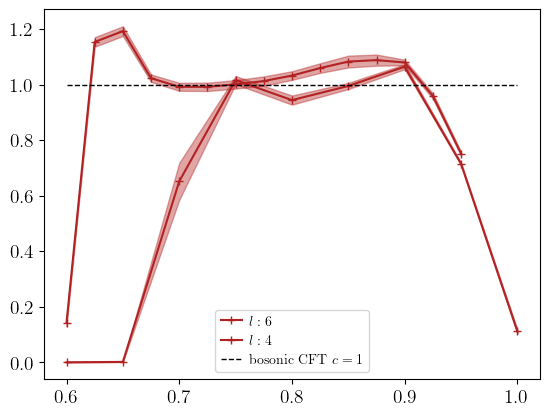

In [27]:
L = 30
npoints, h_i, h_f = 15, 0.6, 0.95
interval = np.linspace(h_i,h_f,npoints)
gs = interval
chi = [128,256]
l = 6
Rs = [14,15,16,17,19]

cc, cc_err = central_charge_plot(Rs, l, chi, L, bc, sector, h_i, h_f, npoints, path, colors[2])

L = 50
npoints, h_i, h_f = 10, 0.7, 0.79
interval = np.linspace(h_i,h_f,npoints)
gs = interval
chi = [64,128]
l = 5
Rs = [25,26,27,28,29,30]

L = 70
npoints, h_i, h_f = 9, 0.6, 1.0
interval = np.linspace(h_i,h_f,npoints)
gs = interval
chi = [96,128]
l = 4
Rs = [30,35,40,45,50]

cc, cc_err = central_charge_plot(Rs, l, chi, L, bc, sector, h_i, h_f, npoints, path, colors[2])

plt.hlines(y=1, xmin=gs[0], xmax=gs[-1], color="k", linestyles="--", linewidths=1, label="bosonic CFT $c=1$")
plt.legend()   


## Time

### Entropy

/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_4422/2687431629.py:134: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


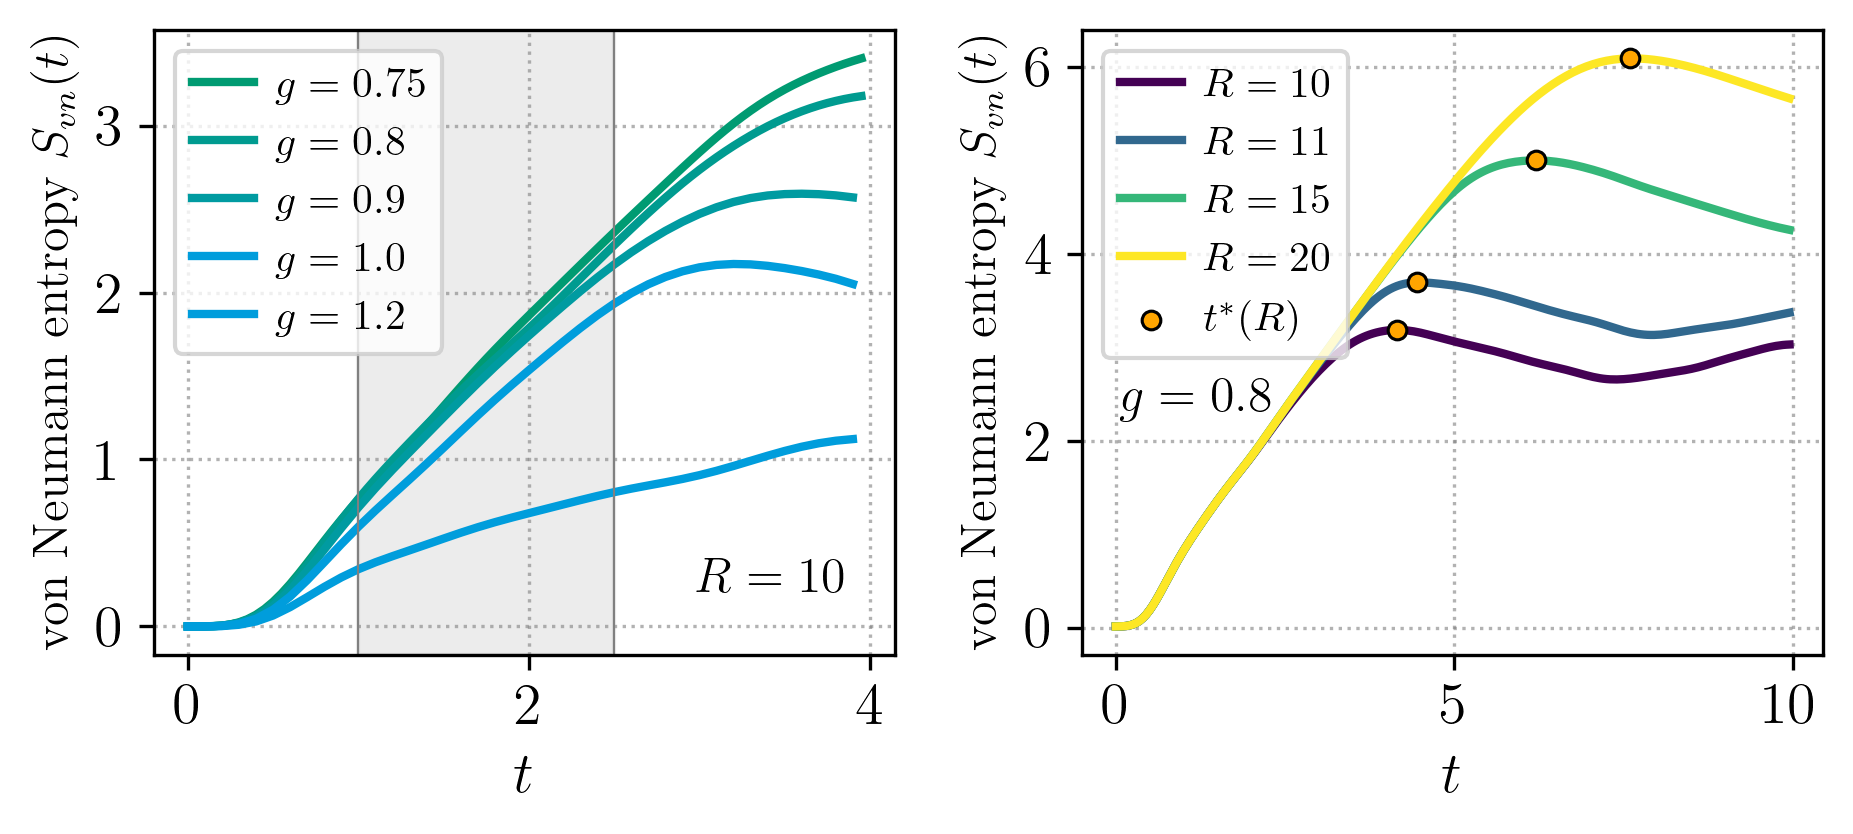

In [510]:
R = 10
chi = 128
of = 0.2

l = 5

plt.rcParams.update({
    'font.family': 'serif', 
    'font.size': 14,
    'text.usetex': True,
    'legend.handlelength': 1.5,
    'legend.handletextpad': 0.5,
    'legend.title_fontsize': 12,
    'legend.fontsize': 10
})

coupls = []
his = [0.75, 0.8]
coupls.append(his)
delta = 0.01
steps = 400

colors = create_sequential_colors(6)

colors = ["#009B72", "#009B90", "#009BA1", "#009DDC", "#009DDC"]

# fig, axs[0] = plt.subplots(figsize=(4.5, 3))
fig, axs = plt.subplots(1, 2, figsize=(6.4, 3))

#################
# ENTROPY vs g
#################
for ax in axs:
    ax.grid(color="gray", linestyle=":", alpha=0.6)

ws_g_rough = []
for j, h_i in enumerate(his):
    h_ev = h_i
    entr_t = time_entropy(R,l,L,chi,bc,sector,h_i,h_ev,path,delta=delta,trotter=steps)
    obs = (entr_t[1:] - entr_t[1])[::int(1/of)]
    ws_g_rough.append(obs)
    axs[0].plot(delta*np.arange(steps)[::int(1/of)], obs, color=colors[j], linestyle="-", linewidth=2, label=f"$g= {h_i}$")
    
delta = 0.02
steps = 200
his = [0.9, 1.0, 1.2]
coupls.append(his)
# his = [0.9, 1.0]

ws_g_conf = []
for i, h_i in enumerate(his):
    h_ev = h_i
    entr_t = time_entropy(R,l,L,chi,bc,sector,h_i,h_ev,path,delta=delta,trotter=steps)
    obs = (entr_t[1:] - entr_t[1])[::int(1/of)]
    ws_g_conf.append(obs)
    # ws_g_rough.append(obs)
    axs[0].plot(delta*np.arange(steps)[::int(1/of)], obs, color=colors[i+j+1], linestyle="-", linewidth=2, label=f"$g = {h_i}$")

x_start = 1.0
x_end = 2.5

# Add vertical lines
axs[0].axvline(x_start, color='gray', linestyle='-', linewidth=0.5)
axs[0].axvline(x_end, color='gray', linestyle='-', linewidth=0.5)

# Add shaded area
axs[0].axvspan(x_start, x_end, color='gray', alpha=0.15, zorder=0)


axs[0].set_xlabel(r"$t$")
# axs[0].set_ylabel("von Neumann entropy $S_{vn}(t)$")
# axs[0].text(delta*np.arange(steps)[-1]-1.0, 0.2, f"$R = {R}$")
axs[0].set_ylabel("von Neumann entropy $S_{vn}(t)$", fontsize=12)
axs[0].text(delta*np.arange(steps)[-1]-1.0, 0.2, f"$R = {R}$", fontsize=12)


# axs[0].text(0, 1.3, "$a t + b \\quad (t < R/2)$", fontsize=10)

axs[0].legend()


#################
# ENTROPY vs R
#################

peaks_opts = dict(
    zorder=20,
    marker="o", 
    facecolors="orange", 
    edgecolors="k",
    linewidths=0.75,
    s=20,
)

h_i, h_ev = 0.8, 0.8
delta = 0.05
steps = 200
chi = 256
l = 6
Rs = [10,11,15,20]

colors = create_sequential_colors(len(Rs))

saturation_idx = []
for i, R in enumerate(Rs):
    entr_t = time_entropy(R,l,L,chi,bc,sector,h_i,h_ev,path,delta=delta,trotter=steps)
    obs = entr_t[1:]
    saturation_idx.append(np.argmax(obs))
    axs[1].plot(delta*np.arange(steps), obs, color=colors[i], linestyle="-", linewidth=2, label=f"$R = {R}$")
    if R == Rs[-1]:
        label="$t^*(R)$"
    else:
        label=None
    axs[1].scatter(delta*np.arange(steps)[np.argmax(obs)], np.max(obs), label=label, **peaks_opts)

# for R in Rs:
#     axs[1].axvline(np.log(R), color='k', linestyle='-', linewidth=0.5)

# axs[1].axvline(10/2, color='k', linestyle='-', linewidth=0.5)
# # axs[1].text(10/2-3.3, 0.2, f"$(t < R/2)$")
# # axs[1].text(10/2+0.45, 0.2, f"$(t > R/2)$")
# axs[1].text(10/2-3.4, 0.2, f"$(t < R/2)$", fontsize=12)
# axs[1].text(10/2+0.45, 0.2, f"$(t > R/2)$", fontsize=12)

axs[1].set_xlabel(r"$t$")
# axs[1].set_ylabel("von Neumann entropy $S_{vn}(t)$")
# axs[1].text(0.05, 2.3, f"$g = {h_ev}$")

axs[1].set_ylabel("von Neumann entropy $S_{vn}(t)$", fontsize=12)
axs[1].text(0.05, 2.3, f"$g = {h_ev}$", fontsize=12)

axs[1].legend()

fig.tight_layout()
fig.savefig(f"{path_figures}/figures/fluxtube/entropy_in_time_{l}x{L}_Rs_{Rs}_gs_{coupls}_with_one_v_line.pdf", bbox_inches="tight")

In [511]:
slope_interval = [1,2.5] # in t
c = 1

def lin_func(x,a,b):
    return a*x + b

delta = 0.01
# delta = 0.02
steps = 400
# steps = 500
his = [ 0.75, 0.8]
# his = [0.8]
slopes = []
slopes_err = []
where_slope = np.argwhere([i if t in slope_interval else 0 for i,t in enumerate(delta*np.arange((steps)+1))])
xs = np.linspace(slope_interval[0], slope_interval[1], int(where_slope[1,0]*of)-int(where_slope[0,0]*of))
for j, ws_t in enumerate(ws_g_rough):
    ys = ws_t[int(where_slope[0,0]*of):int(where_slope[1,0]*of)]
    # plt.plot(xs, ys, marker='^', color=colors[j], label=f"$g: {his[j]}$")
    popt, cov = curve_fit(lin_func, xs, ys)
    err = np.sqrt(np.diag(cov))
    print(f"slope for g: {his[j]} is a: {popt[0]:.3f}+/-{err[0]:.3f}")
    
    slopes.append(popt[0])
    slopes_err.append(err[0])

h_i, h_ev = 0.8, 0.8
delta = 0.05
steps = 200

plin, clin = curve_fit(lin_func, Rs, [delta*np.arange(steps)[idx] for idx in saturation_idx])
err = np.sqrt(np.diag(clin))
for j, R in enumerate(Rs):
    print(f"saturation time t* for R: {Rs[j]} is: {delta*np.arange(steps)[saturation_idx[j]]}")

print(f"avg slope: {np.mean(slopes):.3f}+/-{np.sum(slopes_err):.3f}")
print(f"t* dependency on R: {plin[0]:.3f}+/-{err[0]:.3f}")


slope for g: 0.75 is a: 1.043+/-0.006
slope for g: 0.8 is a: 0.960+/-0.005
saturation time t* for R: 10 is: 4.15
saturation time t* for R: 11 is: 4.45
saturation time t* for R: 15 is: 6.2
saturation time t* for R: 20 is: 7.6000000000000005
avg slope: 1.001+/-0.011
t* dependency on R: 0.352+/-0.026


### String width

[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2.9958962454894505e-14, 0.00046900621017370434, 0.016797477917434724, 0.05554602668593758, 0.1137477216865405, 0.1864128829412328, 0.268151423615342, 0.35431407475392623, 0.4406295857235481, 0.5229580070841058, 0.5982254013769616, 0.6780311391751465, 0.7371324294018149, 0.7914817727764616, 0.8423867987474448, 0.8902912950042566, 0.9351718239544137, 0.9769492933461076, 1.0154469895791278, 1.0501330523254717, 1.0801695518656431, 1.109189529619141, 1.1276950454608776, 1.1421818587348078, 1.154273844276544, 1.1655102910530686, 1.1768113856556364, 1.1882403627324307, 1.1991680771519464, 1.2087334438194208, 1.2163262704578188, 1.222725018778102, 1.2262774759952308, 1.2289304517003086, 1.2313644447850374, 1.2340266308898498, 1.2369243689133735, 1.239533336402349, 1.2409241003914264, 1.2400833876051889, 1.2350934968855674]
[-2, -1, 0, 1, 2]
[5.743789339498105e-14, 0.00037953918497551014, 0.013526890412379368, 0.044242272377285695, 0.08920

/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_4422/2117835751.py:124: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


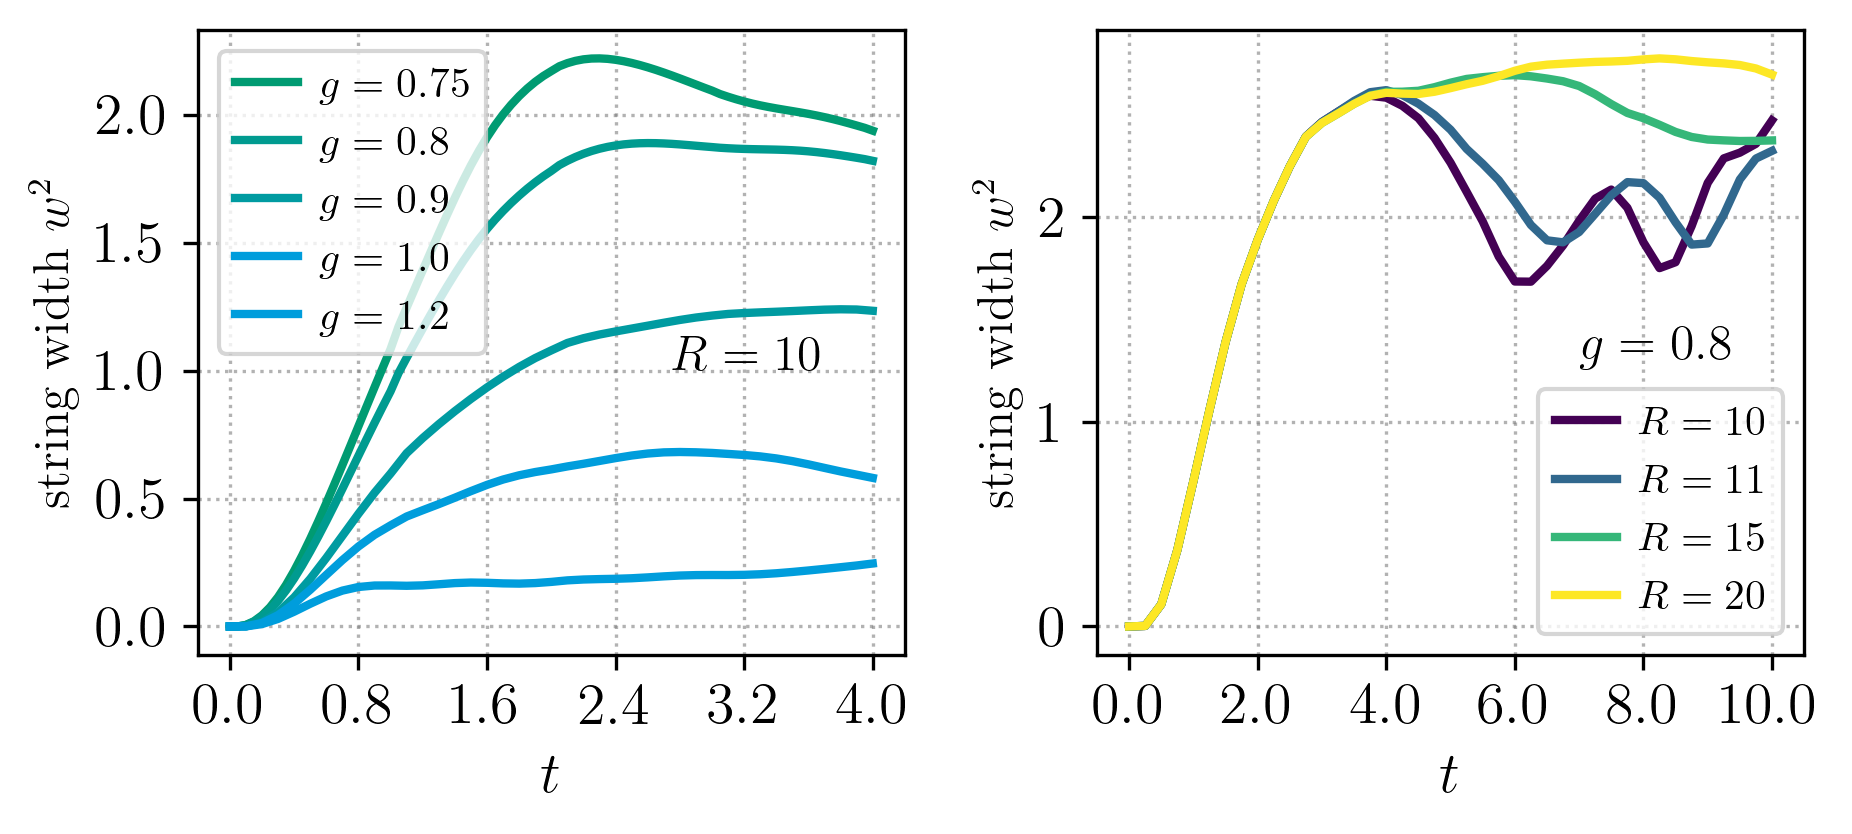

In [512]:
R = 10
chi = 128
of = 0.2

l = 5

coupls = []
his = [0.75, 0.8]
coupls.append(his)
delta = 0.01
steps = 400

colors = create_sequential_colors(6)

colors = ["#009B72", "#009B90", "#009BA1", "#009DDC", "#009DDC"]

# fig, axs[0] = plt.subplots(figsize=(4.5, 3))
fig, axs = plt.subplots(1, 2, figsize=(6.4, 3))

#################
# ENTROPY vs g
#################
for ax in axs:
    ax.grid(color="gray", linestyle=":", alpha=0.6)

ws_g_rough = []
for j, h_i in enumerate(his):
    h_ev = h_i
    entr_t = time_ev_string_width_occupation(R,l,L,chi,bc,sector,h_i,h_ev,1,delta=delta,trotter=steps, path_tensor=path)
    obs = entr_t
    # obs[0] = 1
    ws_g_rough.append(obs)
    axs[0].plot(delta*np.arange((steps*of)+1), obs, color=colors[j], linestyle="-", linewidth=2, label=f"$g= {h_i}$")
    
delta = 0.02
steps = 200
his = [0.9, 1.0, 1.2]
coupls.append(his)
# his = [0.9, 1.0]

ws_g_conf = []
for i, h_i in enumerate(his):
    h_ev = h_i
    entr_t = time_ev_string_width_occupation(R,l,L,chi,bc,sector,h_i,h_ev,1,delta=delta,trotter=steps, path_tensor=path)
    obs = entr_t
    # obs[0] = 1
    print(obs) 
    ws_g_conf.append(obs)
    # ws_g_rough.append(obs)
    axs[0].plot(delta*np.arange((steps*of)+1), obs, color=colors[i+j+1], linestyle="-", linewidth=2, label=f"$g = {h_i}$")

axs[0].set_xticks(ticks=(delta*np.arange(int((steps*of)+1)))[::int((steps*of+1)/5)], labels=delta*np.linspace(0,steps,int((steps*of)+1))[::int((steps*of+1)/5)])
axs[0].set_xlabel(r"$t$")
axs[0].set_ylabel("string width $w^2$", fontsize=12)
axs[0].text(0.55, 1, f"$R = {R}$", fontsize=12)


# x_start = 1.0
# x_end = 2.5

# # Add vertical lines
# axs[0].axvline(x_start, color='gray', linestyle='-', linewidth=0.5)
# axs[0].axvline(x_end, color='gray', linestyle='-', linewidth=0.5)

# # Add shaded area
# axs[0].axvspan(x_start, x_end, color='gray', alpha=0.15, zorder=0)


# axs[0].set_xlabel(r"$t$")
# axs[1].set_ylabel("string width $w^2$")
# axs[0].text(delta*np.arange(steps)[-1]-0.9, 0.2, f"$R = {R}$")
# # axs[0].text(0, 1.3, "$a t + b \\quad (t < R/2)$", fontsize=10)

axs[0].legend()


#################
# ENTROPY vs R
#################

peaks_opts = dict(
    zorder=20,
    marker="o", 
    facecolors="orange", 
    edgecolors="k",
    linewidths=0.75,
    s=20,
)

h_i, h_ev = 0.8, 0.8
delta = 0.05
steps = 200
chi = 256
l = 6
Rs = [10,11,15,20]

colors = create_sequential_colors(len(Rs))

saturation_idx = []
for i, R in enumerate(Rs):
    entr_t = time_ev_string_width_occupation(R,l,L,chi,bc,sector,h_i,h_ev,1,delta=delta,trotter=steps, path_tensor=path)
    obs = entr_t
    # obs[0] = 1
    print(obs) 
    saturation_idx.append(np.argmax(obs))
    axs[1].plot(delta*np.arange((steps*of)+1), obs, color=colors[i], linestyle="-", linewidth=2, label=f"$R = {R}$")
#     if R == Rs[-1]:
#         label="$t^*(R)$"
#     else:
#         label=None
#     axs[1].scatter(delta*np.arange((steps*of)+1)[np.argmax(obs)], np.max(obs), label=label, **peaks_opts)

# axs[1].axvline(10/2, color='k', linestyle='-', linewidth=0.5)
# axs[1].text(10/2-3.3, 0.2, f"$(t < R/2)$")
# axs[1].text(10/2+0.45, 0.2, f"$(t > R/2)$")

axs[1].set_xticks(ticks=(delta*np.arange(int((steps*of)+1)))[::int((steps*of+1)/5)], labels=delta*np.linspace(0,steps,int((steps*of)+1))[::int((steps*of+1)/5)])
axs[1].set_xlabel(r"$t$")
axs[1].set_ylabel("string width $w^2$", fontsize=12)
axs[1].text(1.4, 1.3, f"$g = {h_ev}$", fontsize=12)

axs[1].legend()

fig.tight_layout()
fig.savefig(f"{path_figures}/figures/fluxtube/string_width_in_time_{l}x{L}_Rs_{Rs}_gs_{coupls}_with_one_v_line.pdf", bbox_inches="tight")

### Entropy and string width

[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]


/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_68466/956959583.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


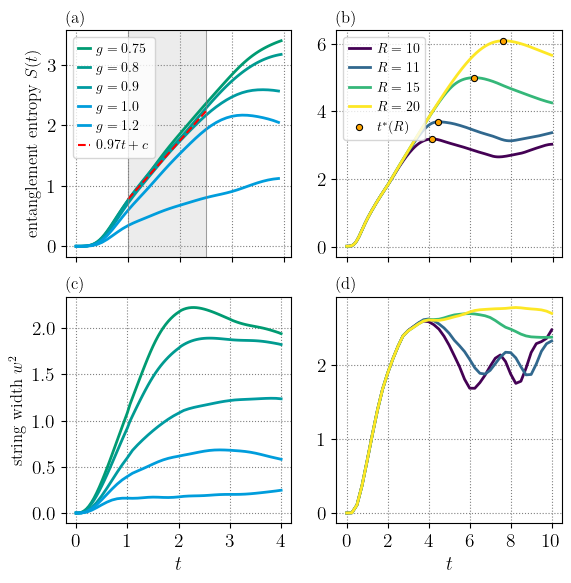

In [156]:
R = 10
chi = 128
of = 0.2

l = 5

plt.rcParams.update({
    'font.family': 'serif', 
    'font.size': 14,
    'text.usetex': True,
    'legend.handlelength': 1.5,
    'legend.handletextpad': 0.5,
    'legend.title_fontsize': 12,
    'legend.fontsize': 10
})

coupls = []
his = [0.75, 0.8]
coupls.append(his)
delta = 0.01
steps = 400

colors = create_sequential_colors(6)

colors = ["#009B72", "#009B90", "#009BA1", "#009DDC", "#009DDC"]

fig, axs = plt.subplots(2, 2, figsize=(6.4, 6.4), gridspec_kw={'hspace':0.18})

#################
# ENTROPY vs g
#################

for ax in axs.flatten():
    ax.grid(color="gray", linestyle=":")

ws_g_rough = []
for j, h_i in enumerate(his):
    h_ev = h_i
    entr_t = time_entropy(R,l,L,chi,bc,sector,h_i,h_ev,path,delta=delta,trotter=steps)
    obs = (entr_t[1:] - entr_t[1])[::int(1/of)]
    ws_g_rough.append(obs)
    axs[0][0].plot(delta*np.arange(steps)[::int(1/of)], obs, color=colors[j], linestyle="-", linewidth=2, label=f"$g= {h_i}$")
    
delta = 0.02
steps = 200
his = [0.9, 1.0, 1.2]
coupls.append(his)
# his = [0.9, 1.0]

ws_g_conf = []
for i, h_i in enumerate(his):
    h_ev = h_i
    entr_t = time_entropy(R,l,L,chi,bc,sector,h_i,h_ev,path,delta=delta,trotter=steps)
    obs = (entr_t[1:] - entr_t[1])[::int(1/of)]
    ws_g_conf.append(obs)
    # ws_g_rough.append(obs)
    axs[0][0].plot(delta*np.arange(steps)[::int(1/of)], obs, color=colors[i+j+1], linestyle="-", linewidth=2, label=f"$g = {h_i}$")

x_start = 1.0
x_end = 2.5

# slope line
axs[0][0].plot(delta*np.arange(steps)[::int(1/of)][10:26], 0.97*delta*np.arange(steps)[::int(1/of)][10:26]-0.19, linestyle='--', color='red', label="$0.97 t + c$")
# axs[0][0].text(delta*np.arange(steps)[::int(1/of)][20], 1.2, , rotation=0, fontsize=12)
# Add vertical lines
axs[0][0].axvline(x_start, color='gray', linestyle='-', linewidth=0.5)
axs[0][0].axvline(x_end, color='gray', linestyle='-', linewidth=0.5)

# Add shaded area
axs[0][0].axvspan(x_start, x_end, color='gray', alpha=0.15, zorder=0)
axs[0][0].legend(handlelength=0.8)

# axs[0][0].set_xlabel(r"$t$")
# axs[0][0].set_ylabel("entanglement entropy $S(t)$")
# axs[0][0].text(delta*np.arange(steps)[-1]-1.0, 0.2, f"$R = {R}$")
axs[0][0].set_ylabel("entanglement entropy $S(t)$", fontsize=12)
# axs[0][0].text(3.03, 0.2, f"$R = {R}$", fontsize=12)
axs[0][0].set_xticks(ticks=(delta*np.arange(steps+1))[::int((steps+1)/4)], labels=['', '', '', '', ''])


# axs[0][0].text(0, 1.3, "$a t + b \\quad (t < R/2)$", fontsize=10)

# axs[0][0].legend()


#################
# ENTROPY vs R
#################

peaks_opts = dict(
    zorder=20,
    marker="o", 
    facecolors="orange", 
    edgecolors="k",
    linewidths=0.75,
    s=20,
)

h_i, h_ev = 0.8, 0.8
delta = 0.05
steps = 200
chi = 256
l = 6
Rs = [10,11,15,20]

colors = create_sequential_colors(len(Rs))

saturation_idx_entr = []
for i, R in enumerate(Rs):
    entr_t = time_entropy(R,l,L,chi,bc,sector,h_i,h_ev,path,delta=delta,trotter=steps)
    obs = entr_t[1:]
    saturation_idx_entr.append(np.argmax(obs))
    axs[0][1].plot(delta*np.arange(steps), obs, color=colors[i], linestyle="-", linewidth=2, label=f"$R = {R}$")
    if R == Rs[-1]:
        label="$t^*(R)$"
    else:
        label=None
    axs[0][1].scatter(delta*np.arange(steps)[np.argmax(obs)], np.max(obs), label=label, **peaks_opts)

# axs[0][1].axvline(10/2, color='k', linestyle='-', linewidth=0.5)
# axs[0][1].text(10/2-3.4, 0.2, f"$(t < R/2)$", fontsize=12)
# axs[0][1].text(10/2+0.45, 0.2, f"$(t > R/2)$", fontsize=12)
# axs[0][1].set_xlabel(r"$t$")
# axs[0][1].set_ylabel("entanglement entropy $S(t)$", fontsize=12)
# axs[0][1].text(0.05, 2.3, f"$g = {h_ev}$", fontsize=12)
# axs[0][1].text(7, 0.4, f"$g = {h_ev}$", fontsize=12)
axs[0][1].set_xticks(ticks=(delta*np.arange(steps+1))[::int((steps+1)/5)], labels=['', '', '', '', '', ''])

axs[0][1].legend()

#################
# string width vs g
#################

R = 10
chi = 128
of = 0.2

l = 5

coupls = []
his = [0.75, 0.8]
coupls.append(his)
delta = 0.01
steps = 400

colors = create_sequential_colors(6)

colors = ["#009B72", "#009B90", "#009BA1", "#009DDC", "#009DDC"]

coord_times = [(2.3,2.23),(2,1.8)]
for j, h_i in enumerate(his):
    h_ev = h_i
    entr_t = time_ev_string_width_occupation(R,l,L,chi,bc,sector,h_i,h_ev,1,delta=delta,trotter=steps, path_tensor=path)
    obs = entr_t
    axs[1][0].plot(delta*np.arange((steps*of)+1), obs, color=colors[j], linestyle="-", linewidth=2, label=f"$g= {h_i}$")
    # where_slope = np.argwhere([i if np.isclose(t,[coord_times[j][0]]) else 0 for i,t in enumerate(delta*np.arange(int((steps)+1))[::int(1/of)])])
    # axs[1][0].scatter(delta*np.arange((steps*of)+1)[where_slope[0]], coord_times[j][1], label=None, **peaks_opts)

delta = 0.02
steps = 200
his = [0.9, 1.0, 1.2]
coupls.append(his)

coord_times = [(1.6,0.96),(1.4,0.51),(0.8,0.16)]
for i, h_i in enumerate(his):
    h_ev = h_i
    entr_t = time_ev_string_width_occupation(R,l,L,chi,bc,sector,h_i,h_ev,1,delta=delta,trotter=steps, path_tensor=path)
    obs = entr_t
    axs[1][0].plot(delta*np.arange((steps*of)+1), obs, color=colors[i+j+1], linestyle="-", linewidth=2, label=f"$g = {h_i}$")
    if h_i == his[-1]:
        label="$t^*(g)$"
    else:
        label=None
    # where_slope = np.argwhere([j if np.isclose(t,[coord_times[i][0]]) else 0 for j,t in enumerate(delta*np.arange(int((steps)+1))[::int(1/of)])])
    # axs[1][0].scatter(delta*np.arange((steps*of)+1)[where_slope[0]], coord_times[i][1], label=label, **peaks_opts)
    # # axs[1][0].scatter(delta*np.arange(steps)[np.argmax(obs)], np.max(obs), label=None, **peaks_opts)


# axs[1][0].set_xticks(ticks=(delta*np.arange(int((steps*of)+1)))[::int((steps*of+1)/5)], labels=delta*np.linspace(0,steps,int((steps*of)+1))[::int((steps*of+1)/5)])
axs[1][0].set_xticks(ticks=(delta*np.arange(int((steps*of)+1)))[::int((steps*of+1)/4)], labels=[int(delta*s) for s in np.linspace(0,steps,int((steps*of)+1))][::int((steps*of+1)/4)])
axs[1][0].set_xlabel(r"$t$")
axs[1][0].set_ylabel("string width $w^2$", fontsize=12)
# axs[1][0].text(3.03*of, 1, f"$R = {R}$", fontsize=12)

# axs[1][0].legend(handlelength=0.8)


#################
# string width vs R
#################

peaks_opts = dict(
    zorder=20,
    marker="o", 
    facecolors="orange", 
    edgecolors="k",
    linewidths=0.75,
    s=20,
)

h_i, h_ev = 0.8, 0.8
delta = 0.05
steps = 200
chi = 256
l = 6
Rs = [10,11,15,20]

colors = create_sequential_colors(len(Rs))

saturation_idx_string = []
for i, R in enumerate(Rs):
    entr_t = time_ev_string_width_occupation(R,l,L,chi,bc,sector,h_i,h_ev,1,delta=delta,trotter=steps, path_tensor=path)
    obs = entr_t
    saturation_idx_string.append(np.argmax(obs))
    axs[1][1].plot(delta*np.arange((steps*of)+1), obs, color=colors[i], linestyle="-", linewidth=2, label=f"$R = {R}$")

axs[1][1].set_xticks(ticks=(delta*np.arange(int((steps*of)+1)))[::int((steps*of+1)/5)], labels=[int(delta*s) for s in np.linspace(0,steps,int((steps*of)+1))][::int((steps*of+1)/5)])
axs[1][1].set_xlabel(r"$t$")
# axs[1][1].set_ylabel("string width $w^2$", fontsize=12)
# axs[1][1].text(1.4, 1.3, f"$g = {h_ev}$", fontsize=12)

# axs[1][1].legend()

axs[0][0].set_title("(a)", loc='left', fontsize=12)
axs[0][1].set_title("(b)", loc='left', fontsize=12)
axs[1][0].set_title("(c)", loc='left', fontsize=12)
axs[1][1].set_title("(d)", loc='left', fontsize=12)

# handles1, labels1 = axs[1][0].get_legend_handles_labels()

# # Merge and show the legend only in ax1
# axs[0][0].legend(handles1, labels1, loc='best', handlelength=0.8)
fig.tight_layout()
fig.savefig(f"{path_figures}/figures/fluxtube/entropy_vs_string_width_in_time_{l}x{L}_Rs_{Rs}_gs_{coupls}.pdf", bbox_inches="tight")

### Lin $vs$ Log growth of entanglement

In [41]:
def lin_func(x,a,b):
    return a*x + b

def log_func(x,a,b):
    return a*np.log(x) + b

def lin_log_ent_growth(l,L,R,chi,delta,steps,h_i,bc,sector,path, slope_interval,color):
    h_ev = h_i
    entr_t = time_entropy(R,l,L,chi,bc,sector,h_i,h_ev,path,delta=delta,trotter=steps)
    obs = (entr_t[1:] - entr_t[1])[::int(1/of)]

    

    where_slope = np.argwhere([i if g in slope_interval else 0 for i,g in enumerate(delta*np.arange((steps)+1))])
    xs = np.linspace(slope_interval[0], slope_interval[1], int(where_slope[1,0]*of)-int(where_slope[0,0]*of))
    ys = obs[int(where_slope[0,0]*of):int(where_slope[1,0]*of)]
    ys_err = [delta]*len(ys)

    # plt.plot(xs, ys, marker='1', color=colors[-1], linestyle='', markersize=10, label=f"$g: {his[-1]}$")
    plt.errorbar(x=xs, y=ys, yerr=ys_err, color=color, marker='x', linestyle='', capsize=8, linewidth=1, markersize=5, label=f"$g= {h_ev:.2f}$", zorder=0)

    popt, cov = curve_fit(log_func, xs, ys, sigma=ys_err)
    y_fit = log_func(xs,*popt)
    residuals = (ys - y_fit)/ys_err
    RSS = np.sum(residuals**2)/(len(ys)-len(popt))
    RMSE = np.sqrt(np.mean(residuals**2))
    plt.plot(xs, log_func(xs,*popt), label="log fit $\\hspace{0.8cm}$"+f"$-$ WRMSE = ${RMSE:.4f}$")

    print(f"slope log = {popt[0]:.7f}, offset log = {popt[1]:.7f}")
    print(f"RSS log = {RSS:.7f}, RMSE log = {RMSE:.7f}")

    popt, cov = curve_fit(lin_func, xs, ys, sigma=ys_err)
    y_fit = lin_func(xs,*popt)
    residuals = (ys - y_fit)/ys_err
    RSS = np.sum(residuals**2)/(len(ys)-len(popt))
    RMSE = np.sqrt(np.mean(residuals**2))
    plt.plot(xs, lin_func(xs,*popt), label="lin fit $\\hspace{0.865cm}$"+f"$-$ WRMSE = ${RMSE:.4f}$")

    print(f"slope lin = {popt[0]:.7f}, offset lin = {popt[1]:.7f}")
    print(f"RSS lin = {RSS:.7f}, RMSE lin = {RMSE:.7f}")

    plt.xlabel("$t$")
    plt.ylabel("entanglement entropy $S(t)$")
    plt.legend()
    plt.show()

slope log = 1.7291995, offset log = 0.6484121
RSS log = 22.0193000, RMSE log = 4.5333593
slope lin = 1.0425744, offset lin = -0.2686701
RSS lin = 1.9005581, RMSE lin = 1.3318612


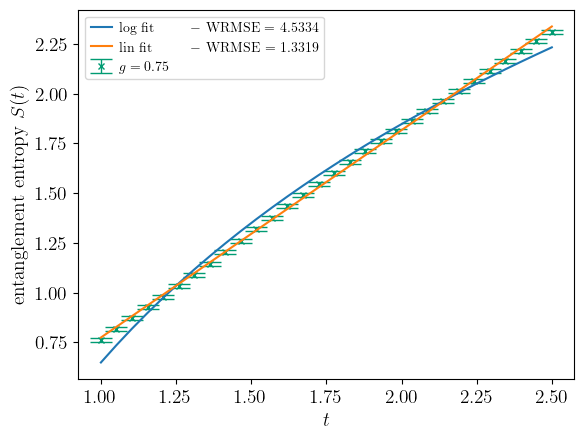

slope log = 1.5918264, offset log = 0.6824590
RSS log = 18.9135178, RMSE log = 4.2015017
slope lin = 0.9598180, offset lin = -0.1618879
RSS lin = 1.5799582, RMSE lin = 1.2143425


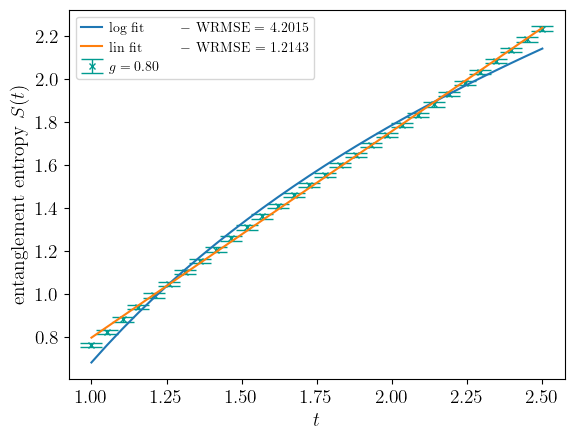

slope log = 1.5199170, offset log = 0.6416067
RSS log = 3.5524193, RMSE log = 1.7546405
slope lin = 0.9177840, offset lin = -0.1708239
RSS lin = 0.9785328, RMSE lin = 0.9209027


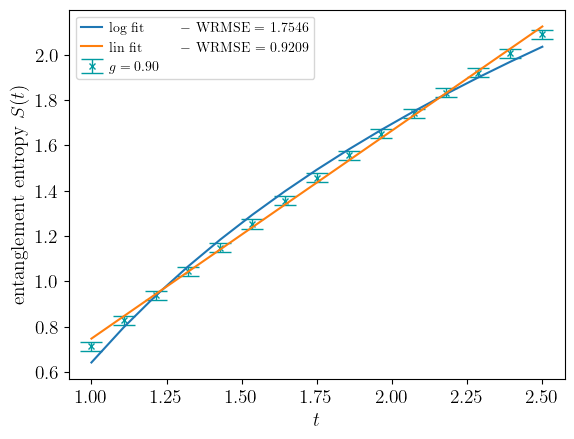

slope log = 1.4089934, offset log = 0.5139591
RSS log = 4.5708601, RMSE log = 1.9903296
slope lin = 0.8526756, offset lin = -0.2424554
RSS lin = 0.3883385, RMSE lin = 0.5801379


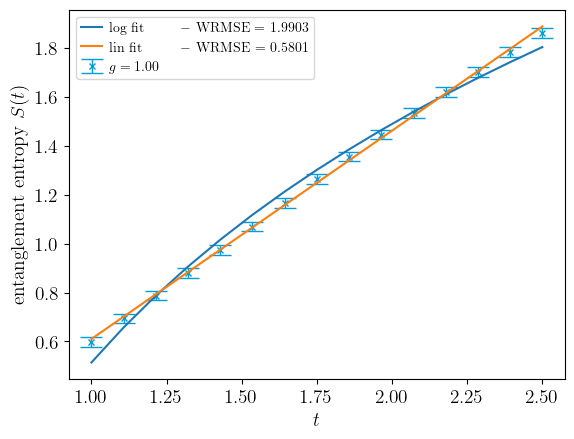

slope log = 0.4833854, offset log = 0.3276871
RSS log = 0.1385033, RMSE log = 0.3464624
slope lin = 0.2906780, offset lin = 0.0714215
RSS lin = 0.3133928, RMSE lin = 0.5211594


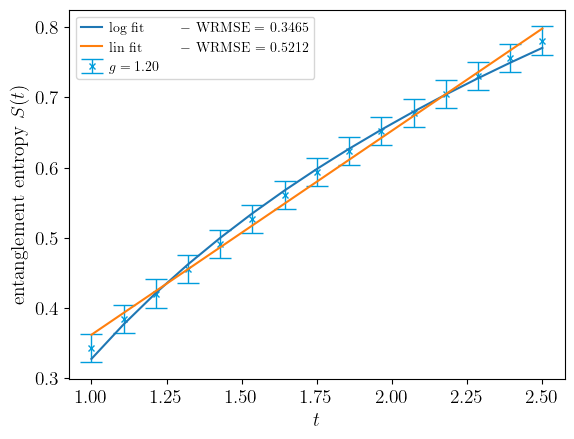

In [42]:
slope_interval = [1.0,2.5]
colors = ["#009B72", "#009B90", "#009BA1", "#009DDC", "#009DDC"]
i = 0
l, chi, R = 5, 128, 10
delta, steps = 0.01, 400
for h_i in [0.75,0.8]:
    lin_log_ent_growth(l,L,R,chi,delta,steps,h_i,bc,sector,path,slope_interval,colors[i])
    i += 1
delta, steps = 0.02, 200
for h_i in [0.9,1.0,1.2]:
    lin_log_ent_growth(l,L,R,chi,delta,steps,h_i,bc,sector,path,slope_interval,colors[i])
    i += 1

### Ehrenfest time scale nature

16.927419354838655
RSS lin = 33.8548387, RMSE lin = 2.9092456
7.4019351236851065
RSS sqrt(R) = 14.8038702, RMSE sqrt(R) = 1.9237899
4.2560755336620435
RSS log(R) = 8.5121511, RMSE log(R) = 1.4587795


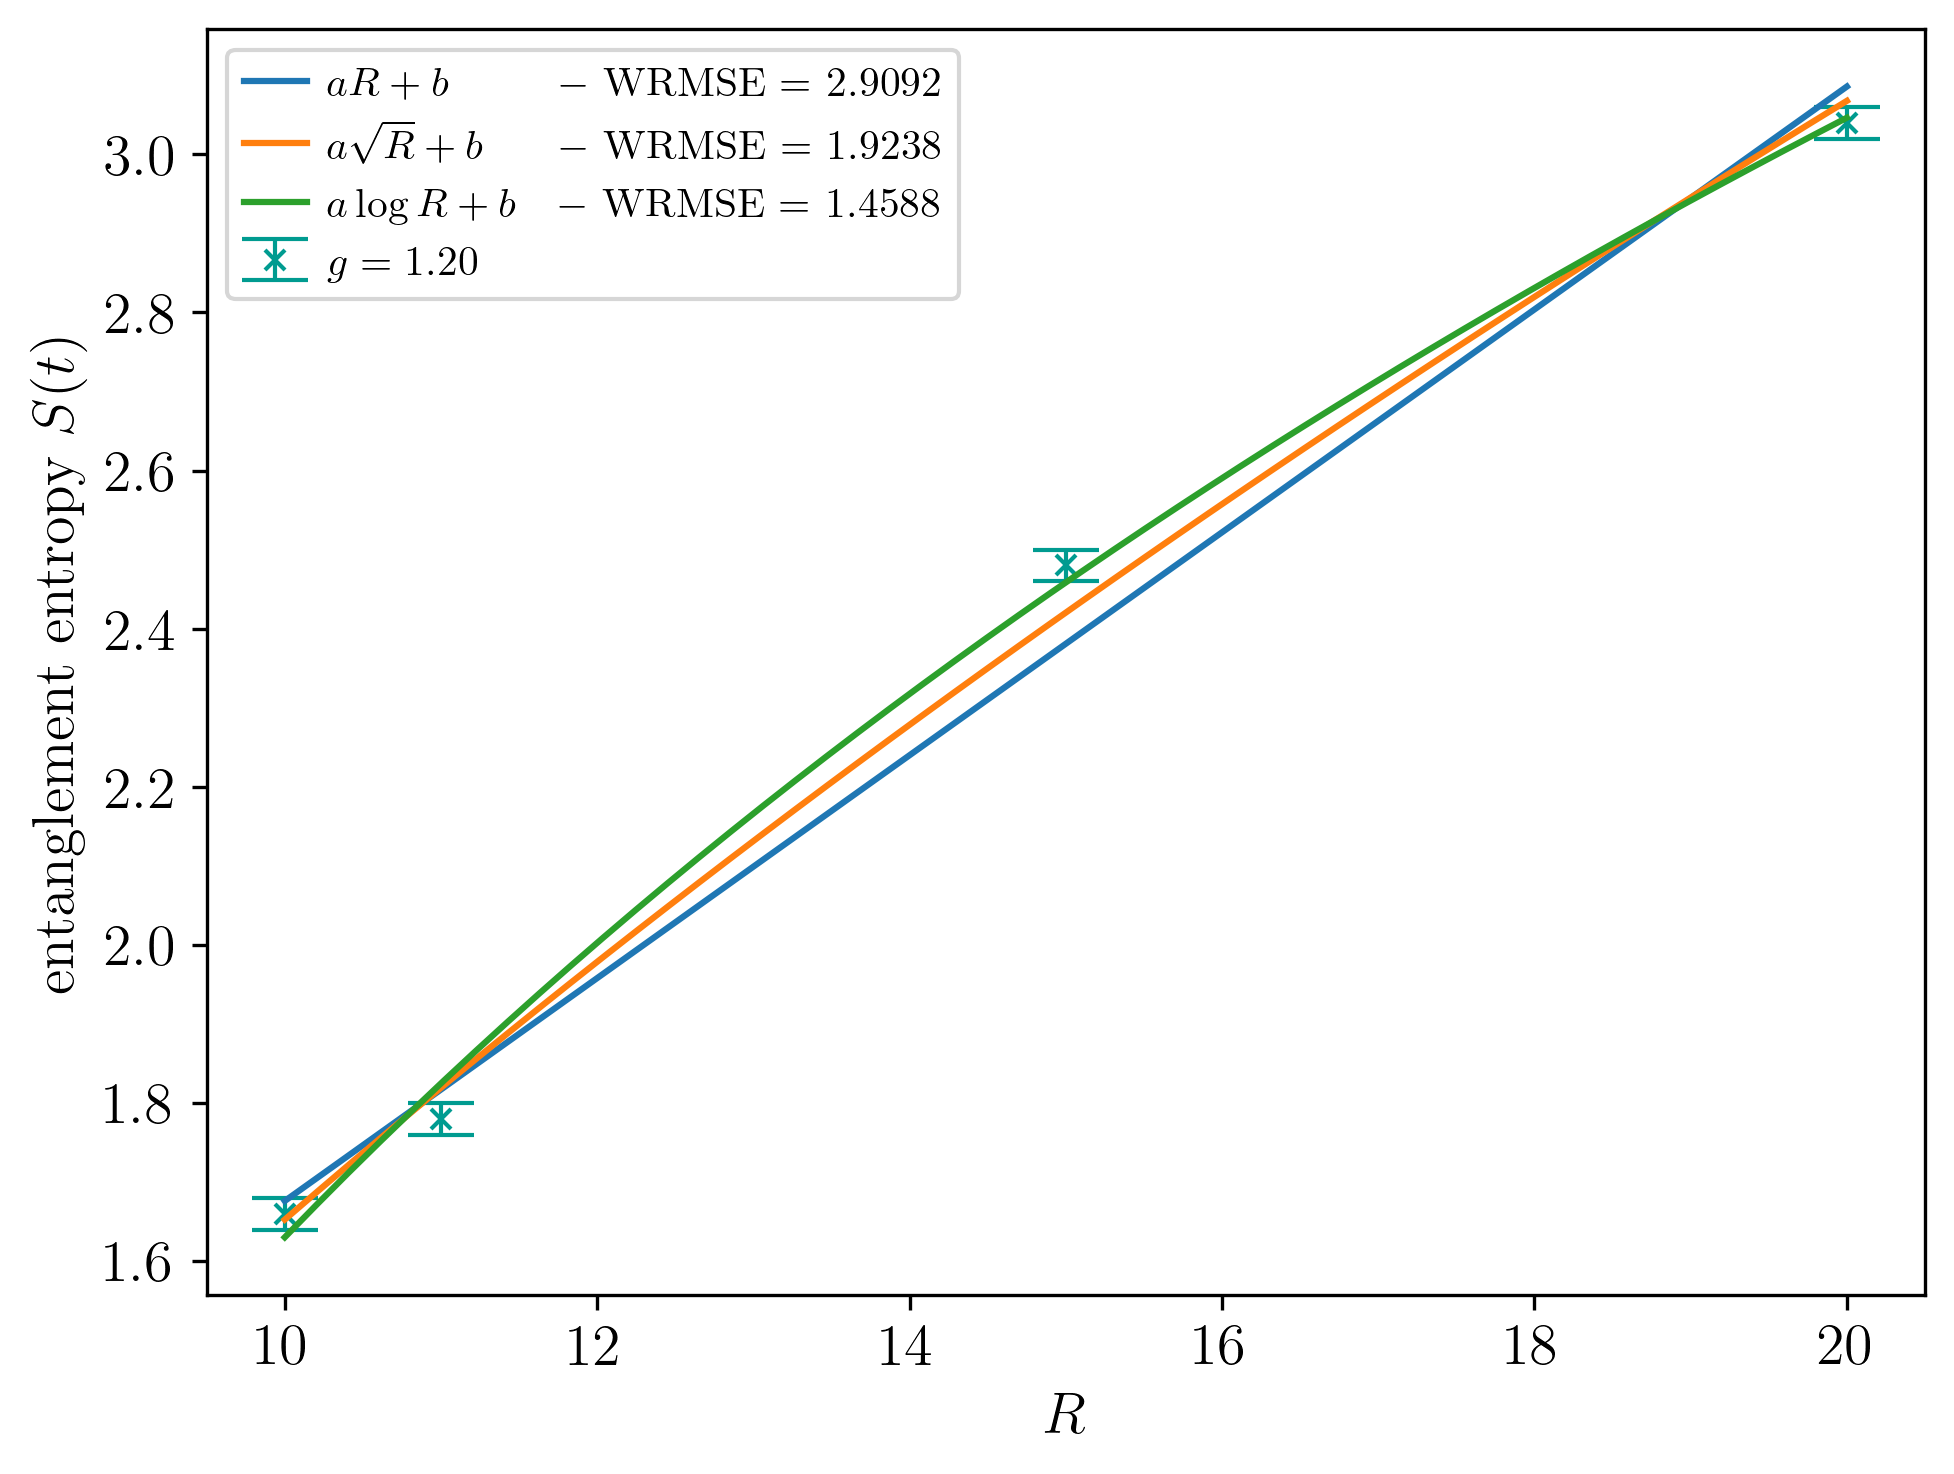

In [576]:
delta = 0.02
saturation_times = delta*np.arange(steps)[saturation_idx_entr]

def saturation_eq(R, a, b):
    return a*R + b

def log_func(R, a, b):
    return a*np.log(R) + b

def sqrt_func(R, a, b):
    return a*np.sqrt(R) + b


x_data = np.array(Rs)
y_data = saturation_times
y_data_err = [delta]*len(y_data)
# plt.plot(x_data, y_data, 'x', color="#009B90")
plt.errorbar(x=x_data, y=y_data, yerr=y_data_err, color="#009B90", marker='x', linestyle='', capsize=8, linewidth=1, markersize=5, label=f"$g= {h_ev:.2f}$", zorder=0)

popt, copt = curve_fit(saturation_eq, x_data, y_data, sigma=y_data_err)
xs = np.linspace(Rs[0], Rs[-1])

y_fit = saturation_eq(x_data,*popt)
residuals = y_data - y_fit
residuals = (y_data - y_fit)/y_data_err
RSS = np.sum(residuals**2)
RCS = np.sum(residuals**2)/(len(y_data) - len(popt))
print(RCS)
RMSE = np.sqrt(np.mean(residuals**2))
plt.plot(xs, saturation_eq(xs, *popt), '-', label="$a R + b$ $\\hspace{0.8cm}$"+f"$-$ WRMSE = ${RMSE:.4f}$")
print(f"RSS lin = {RSS:.7f}, RMSE lin = {RMSE:.7f}")

popt, copt = curve_fit(sqrt_func, x_data, y_data, sigma=y_data_err)
y_fit = sqrt_func(x_data,*popt)
residuals = y_data - y_fit
residuals = (y_data - y_fit)/y_data_err
RSS = np.sum(residuals**2)
RCS = np.sum(residuals**2)/(len(y_data) - len(popt))
RMSE = np.sqrt(np.mean(residuals**2))
plt.plot(xs, sqrt_func(xs, *popt), '-', label="$a \\sqrt{R} + b$ $\\hspace{0.51cm}$"+f"$-$ WRMSE = ${RMSE:.4f}$")
print(RCS)
print(f"RSS sqrt(R) = {RSS:.7f}, RMSE sqrt(R) = {RMSE:.7f}")

popt, copt = curve_fit(log_func, x_data, y_data, sigma=y_data_err)

y_fit = log_func(x_data,*popt)
residuals = y_data - y_fit
residuals = (y_data - y_fit)/y_data_err
RSS = np.sum(residuals**2)
RCS = np.sum(residuals**2)/(len(y_data) - len(popt))
RMSE = np.sqrt(np.mean(residuals**2))
plt.plot(xs, log_func(xs, *popt), '-', label="$a \\log{R} + b$ $\\hspace{0.22cm}$"+f"$-$ WRMSE = ${RMSE:.4f}$")
print(RCS)
print(f"RSS log(R) = {RSS:.7f}, RMSE log(R) = {RMSE:.7f}")
plt.xlabel(r'$R$')
plt.ylabel('entanglement entropy $S(t)$')
plt.legend()

## String Tension of Potential

### a lot of stuff

[15, 16, 17, 18, 19, 20]
[16, 17, 18, 19, 20]
Weighted Average: 0.9956039553304852
Error in the Average: 7.370061484818923e-06
Weighted Average: 1.036550686658304
Error in the Average: 5.91815025663172e-06
Weighted Average: 1.076978057200136
Error in the Average: 6.169270947132676e-06
Weighted Average: 1.1168870692870712
Error in the Average: 6.856726740013073e-06
Weighted Average: 1.156279709381435
Error in the Average: 5.909057610949202e-06
Weighted Average: 1.195156740755132
Error in the Average: 5.683865586532996e-06
Weighted Average: 1.2335205185052465
Error in the Average: 4.096857771748959e-06
Weighted Average: 1.2713713937709519
Error in the Average: 2.9806324393245914e-06
Weighted Average: 1.3087094580305272
Error in the Average: 1.4206165289024916e-06
Weighted Average: 1.3455322672150245
Error in the Average: 1.3760249569715673e-06
Weighted Average: 1.3818339763673877
Error in the Average: 2.13216993643226e-06
[15, 16, 17, 18, 19, 20]
[16, 17, 18, 19, 20]
Weighted Average: 0.

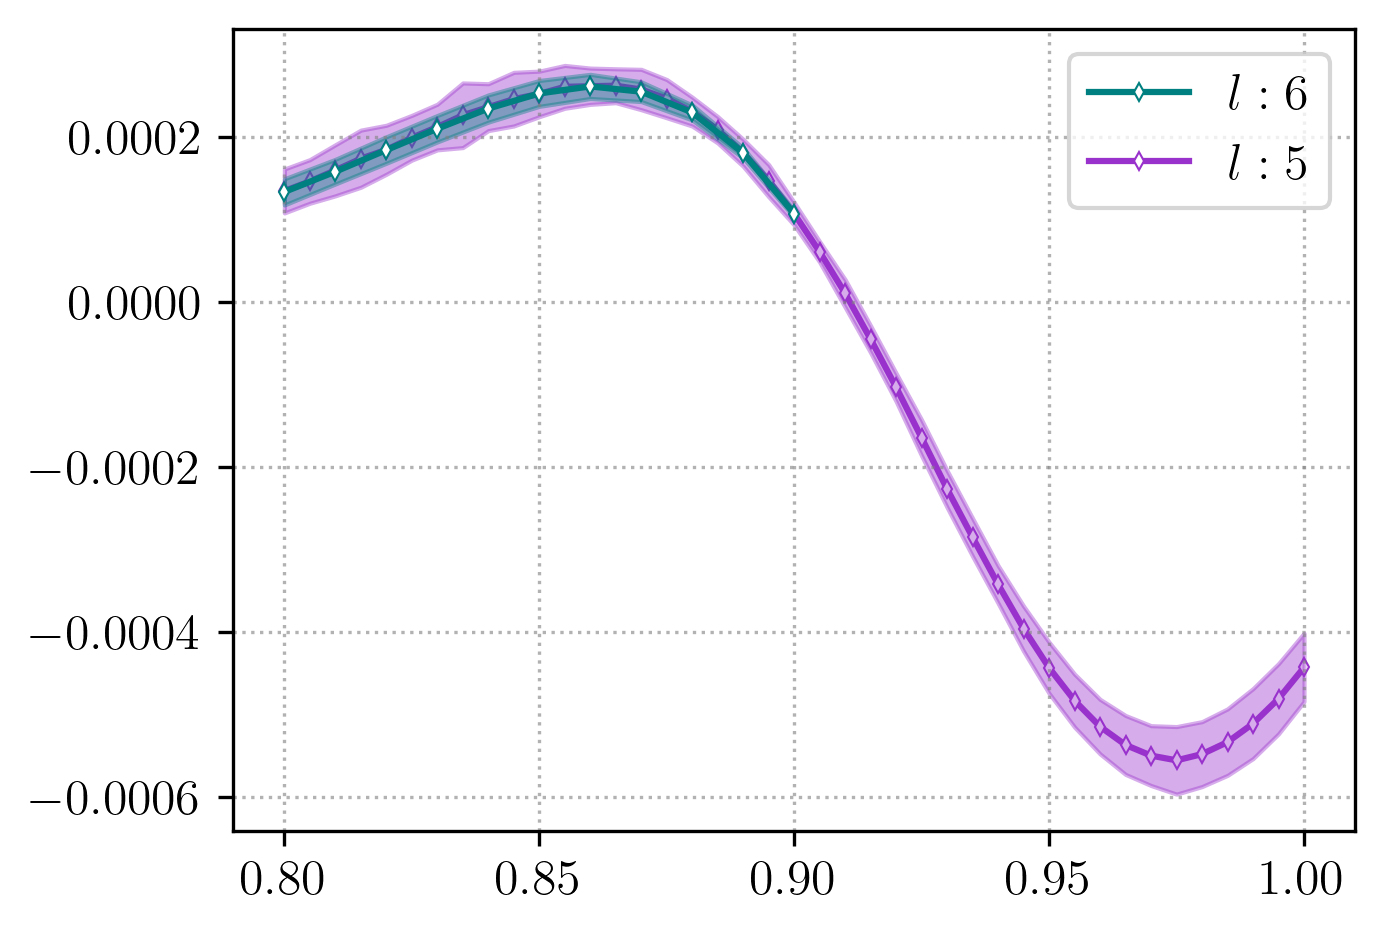

In [ ]:
param = 0
fit = 1
l = 6
h_i, h_f, npoints = 0.6, 0.95, 15
h_i, h_f, npoints = 0.8, 0.9, 11
gs = np.linspace(h_i,h_f,npoints)
chis = [128,256]
idx = 0
# chis = [64,128]
# idx = 8
Rss = [12,13,14,15,16,17,19]
Rss = [15,16,17,18,19,20]
euclidean = True
manhatten = False

# l = 5
# h_i, h_f, npoints = 0.8, 1.0, 41
# gs = np.linspace(h_i,h_f,npoints)
# chis = [64,128]
# Rss = [12,13,14,15,16,17,18,19,20]

cx = None
sigmas_on, sigmas_on_err = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit)
Rss = [12,13,14,15,16,17,19]
cx = None
Rss = [15,16,17,18,19,20]
sigmas_off, sigmas_off_err = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten)

obs = np.array(sigmas_off) - np.array(sigmas_on)
obs_err = np.array(sigmas_off_err) + np.array(sigmas_on_err)

fig, ax = plt.subplots(figsize=(4.5, 3))
ax.grid(color="gray", linestyle=":", alpha=0.6)

ax.plot(gs[idx:], obs[idx:], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$l: {l}$")
ax.fill_between(x=gs[idx:], y1=obs[idx:]-obs_err[idx:], y2=obs[idx:]+obs_err[idx:], color="teal", alpha=0.4)
ax.legend()


# h_i, h_f, npoints = 0.91, 0.94, 4
# gs = np.linspace(h_i,h_f,npoints)
# cx = None
# Rss = [15,16,17,18,19,20]
# sigmas_on, sigmas_on_err = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit)
# cx = None
# Rss = [15,16,17,18,19,20]
# sigmas_off, sigmas_off_err = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten)

# obs = np.array(sigmas_off) - np.array(sigmas_on)
# obs_err = np.array(sigmas_off_err) + np.array(sigmas_on_err)

# fig, ax = plt.subplots(figsize=(4.5, 3))
# ax.grid(color="gray", linestyle=":", alpha=0.6)

# ax.plot(gs[idx:], obs[idx:], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w')
# ax.fill_between(x=gs[idx:], y1=obs[idx:]-obs_err[idx:], y2=obs[idx:]+obs_err[idx:], color="teal", alpha=0.4)


# l = 5
# h_i, h_f, npoints = 1.0, 2.0, 11
# gs = np.linspace(h_i,h_f,npoints)
# chis = [64,128]
# Rss = [12,13,14,15,16,17,18,19,20]

l = 5
h_i, h_f, npoints = 0.8, 1.0, 41
gs = np.linspace(h_i,h_f,npoints)
chis = [64,128]
Rss = [12,13,14,15,16,17,19]
Rss = [15,16,17,18,19,20]

cx = None

sigmas_on, sigmas_on_err = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit)
Rss = [12,13,14,15,16,17,19]
Rss = [15,16,17,18,19,20]
cx = None
sigmas_off, sigmas_off_err = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten)

obs = np.array(sigmas_off) - np.array(sigmas_on)
obs_err = np.array(sigmas_off_err) + np.array(sigmas_on_err)

ax.plot(gs[0:], obs[0:], markersize=3, color="darkorchid", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$l: {l}$", zorder=0)
ax.fill_between(x=gs[0:], y1=obs[0:]-obs_err[0:], y2=obs[0:]+obs_err[0:], color="darkorchid", alpha=0.4, zorder=0)
ax.legend()

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[12, 13, 14, 15, 16, 17, 18, 19, 20]
[13, 14, 15, 16, 17, 18, 19, 20]
[14, 15, 16, 17, 18, 19, 20]
[15, 16, 17, 18, 19, 20]
Weighted Average: 0.995530876372104
Error in the Average: 9.892967390370126e-06
Weighted Average: 1.0160848503190145
Error in the Average: 9.455263118619837e-06
Weighted Average: 1.0365053722133821
Error in the Average: 1.0429147874472248e-05
Weighted Average: 1.0567940591711635
Error in the Average: 8.955909642034624e-06
Weighted Average: 1.0769526234398965
Error in the Average: 1.003792234228994e-05
Weighted Average: 1.09697854869524
Error in the Average: 9.490750208485053e-06
Weighted Average: 1.1168802561580715
Error in the Average: 5.542382619284372e-06
Weighted Average: 1.136637218712493
Error in the Average: 1.2427910452840316e-05
Weighted Average: 1.1562748572151131
Error in the Average: 8.194532649965191e-06
Weighted Average: 1.1757762399224077
Error in the Average: 1.16

/Users/fradm/Desktop/qs-mps/src/qs_mps/applications/Z2/relevant_observables.py:494: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(potential_fit_2, Rs, potentials, sigma=errors, p0=guess)
/Users/fradm/Desktop/qs-mps/src/qs_mps/applications/Z2/relevant_observables.py:492: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(potential_fit_1, Rs, potentials, sigma=errors, p0=guess)


Weighted Average: 3.1378169411388677
Error in the Average: 5.8339043457934414e-08
Weighted Average: 3.3483684162958975
Error in the Average: 1.8283492853238268e-08
Weighted Average: 3.5566351288010916
Error in the Average: 5.5055393447574276e-08
Weighted Average: 3.763211574364582
Error in the Average: 5.5199973962201634e-08
Weighted Average: 3.968513218666262
Error in the Average: 5.2721313024404604e-08
[[1.71368199 1.99462342 2.24615516 2.48110786 2.70590858 2.92410729
  3.13781702 3.34836841 3.55663511 3.76321164 3.96851321]
 [1.7136882  1.99462306 2.24615513 2.4811078  2.70590843 2.92410726
  3.13781702 3.34836842 3.55663521 3.76321176 3.96851324]
 [1.71369324 1.99462053 2.24615527 2.48110775 2.70590858 2.9241071
  3.13781712 3.34836812 3.5566351  3.76321157 3.9685132 ]
 [1.71369748 1.99462052 2.24615502 2.48110773 2.70590837 2.9241074
  3.13781682 3.34836824 3.55663532 3.76321155 3.96851316]
 [1.71370099 1.99462018 2.24615534 2.48110775 2.70590845 2.92410728
  3.13781685 3.3483682

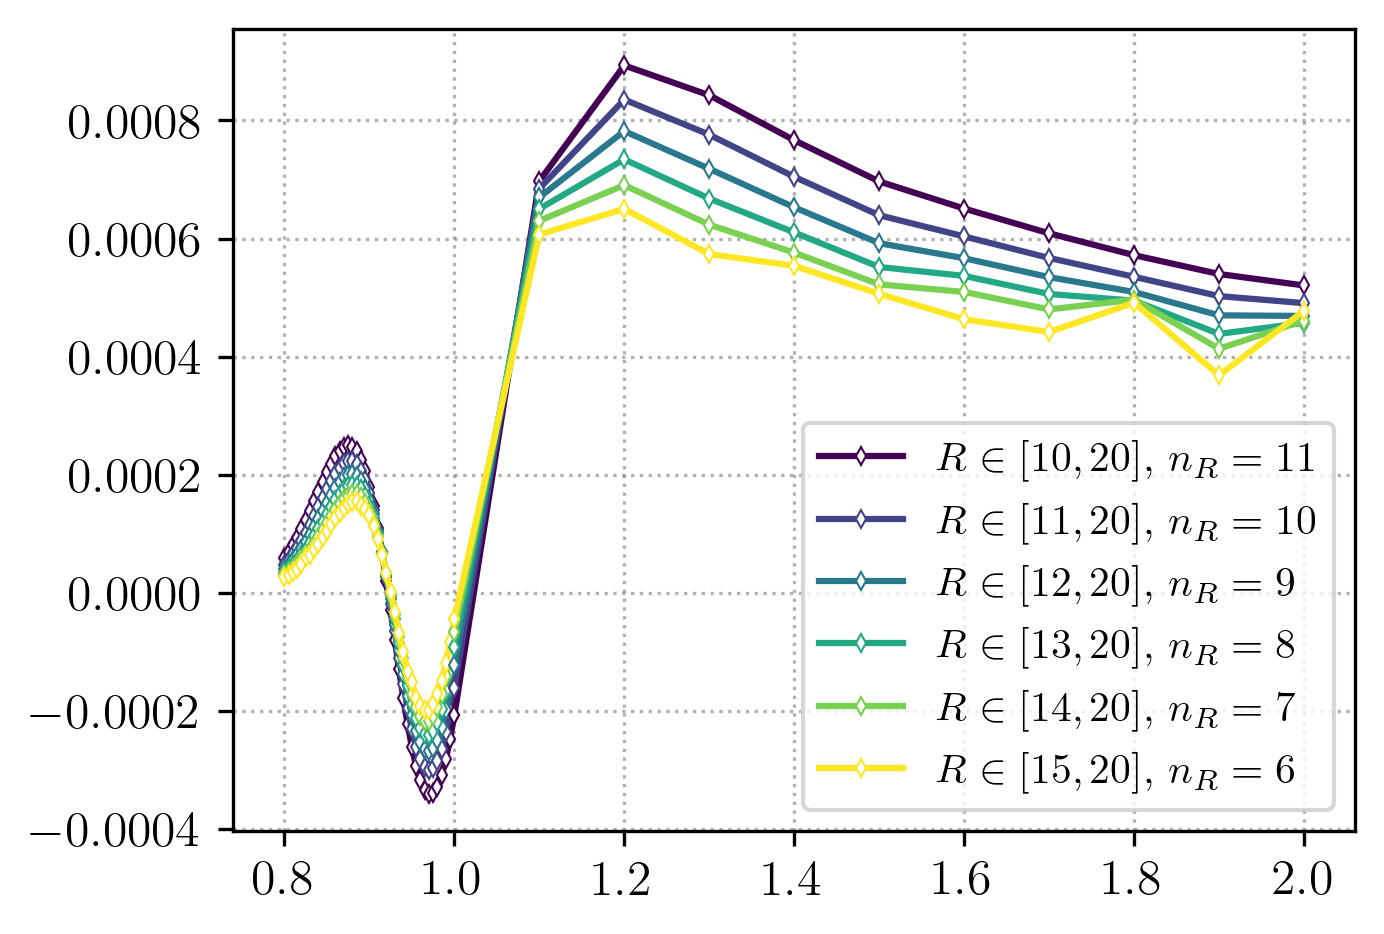

In [422]:
fit = 2
param = 0

fig, ax = plt.subplots(figsize=(4.5, 3))
ax.grid(color="gray", linestyle=":", alpha=0.6)

euclidean = True
manhatten = False

l = 5
h_i, h_f, npoints = 0.8, 1.0, 41
gs = np.linspace(h_i,h_f,npoints)
chis = [64,128]
# Rss = [12,13,14,15,16,17,18,19,20]
Rss = [10,11,12,13,14,15,16,17,18,19,20]

sigmas_on, sigmas_on_err, sigmas_on_ris, sigmas_on_ris_err, list_ris = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, ris=True)
print(sigmas_on_ris, np.asarray(sigmas_on_ris).shape)
Rss = [10,11,12,13,14,15,16,17,18,19,20]
cx = None
sigmas_off, sigmas_off_err, sigmas_off_ris, sigmas_off_ris_err, list_ris = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=True)
print(sigmas_off_ris, np.asarray(sigmas_off_ris).shape)

# obs = np.array(sigmas_off) - np.array(sigmas_on)
# obs_err = np.array(sigmas_off_err) + np.array(sigmas_on_err)


# ax.plot(gs[0:], obs[0:], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$\\sigma_{{off}} - \\sigma_{{on}}$")
# ax.fill_between(x=gs[0:], y1=obs[0:]-obs_err[0:], y2=obs[0:]+obs_err[0:], color="teal", alpha=0.4)


i = 0
colors = create_sequential_colors(len(list_ris))
for sigmas_on_ri, sigmas_off_ri, ri in zip(sigmas_on_ris, sigmas_off_ris, list_ris):
    obs = np.array(sigmas_off_ri) - np.array(sigmas_on_ri)

    ax.plot(gs[0:], obs[0:], markersize=3, color=colors[i], marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$R \\in [{ri[0]},{ri[-1]}]$, $n_R={len(ri)}$")
    i += 1

l = 5
h_i, h_f, npoints = 1.0, 2.0, 11
gs = np.linspace(h_i,h_f,npoints)
chis = [64,128]
Rss = [10,11,12,13,14,15,16,17,18,19,20]

cx = None
sigmas_on, sigmas_on_err, sigmas_on_ris, sigmas_on_ris_err, list_ris = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, ris=True)
print(sigmas_on_ris, np.asarray(sigmas_on_ris).shape)
Rss = [10,11,12,13,14,15,16,17,18,19,20]
cx = None
sigmas_off, sigmas_off_err, sigmas_off_ris, sigmas_off_ris_err, list_ris = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=True)

# obs = np.array(sigmas_off) - np.array(sigmas_on)
# obs_err = np.array(sigmas_off_err) + np.array(sigmas_on_err)

# ax.plot(gs[0:], obs[0:], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w')
# ax.fill_between(x=gs[0:], y1=obs[0:]-obs_err[0:], y2=obs[0:]+obs_err[0:], color="teal", alpha=0.4)


i = 0
colors = create_sequential_colors(len(list_ris))
for sigmas_on_ri, sigmas_off_ri, ri in zip(sigmas_on_ris, sigmas_off_ris, list_ris):
    obs = np.array(sigmas_off_ri) - np.array(sigmas_on_ri)

    ax.plot(gs[0:], obs[0:], markersize=3, color=colors[i], marker='d', fillstyle=None, mew=0.5, mfc='w')
    i += 1

ax.legend(fontsize=10)

[25, 26, 27, 28, 29, 30]
[26, 27, 28, 29, 30]
Weighted Average: 0.9955394700149398
Error in the Average: 3.940007436634039e-05
Weighted Average: 1.1951834178786263
Error in the Average: 2.536872223628358e-05
Weighted Average: 1.381819168740942
Error in the Average: 5.5601258747783336e-05
Weighted Average: 1.5551153917681266
Error in the Average: 8.366991541719988e-06
Weighted Average: 1.7137090298589985
Error in the Average: 1.468082501639959e-06
[[0.99553902 1.19518301 1.38181905 1.55511496 1.71370867]
 [0.9955396  1.19518482 1.38181941 1.55511581 1.71370964]] (2, 5)
[25, 26, 27, 28, 29, 30]
[26, 27, 28, 29, 30]
Weighted Average: 0.995571704602765
Error in the Average: 0.0001220331948489278
Weighted Average: 1.1952623567197314
Error in the Average: 4.622449997376244e-05
Weighted Average: 1.381898123860692
Error in the Average: 3.087137770242288e-05
Weighted Average: 1.5549724640324782
Error in the Average: 2.2843150798447336e-05
Weighted Average: 1.7136883017678726
Error in the Averag

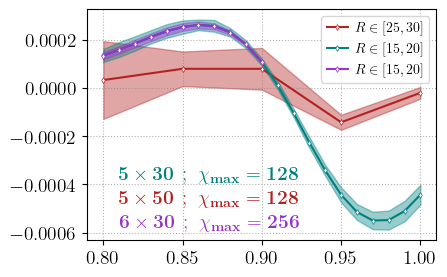

In [71]:
fit = 1
param = 0
fig, ax = plt.subplots(figsize=(4.5, 3))
ax.grid(color="gray", linestyle=":", alpha=0.6)

euclidean = True
manhatten = False

l = 5
L = 50
h_i, h_f, npoints = 0.8, 1.0, 5
gs = np.linspace(h_i,h_f,npoints)
chis = [64,128]
Rs = [25,26,27,28,29,30]
cx = None

sigmas_on, sigmas_on_err, sigmas_on_ris, sigmas_on_ris_err, list_ris = fit_params_sys(Rs, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, ris=True)
print(sigmas_on_ris, np.asarray(sigmas_on_ris).shape)
Rs = [25,26,27,28,29,30]
cx = None
sigmas_off, sigmas_off_err, sigmas_off_ris, sigmas_off_ris_err, list_ris = fit_params_sys(Rs, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=True)
print(sigmas_off_ris, np.asarray(sigmas_off_ris).shape)

obs = np.array(sigmas_off) - np.array(sigmas_on)
obs_err = np.array(sigmas_off_err) + np.array(sigmas_on_err)

Rs = [25,26,27,28,29,30]

ax.plot(gs[0:], obs[0:], markersize=3, color="firebrick", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$R \in [{Rs[0]},{Rs[-1]}]$")
ax.fill_between(x=gs[0:], y1=obs[0:]-obs_err[0:], y2=obs[0:]+obs_err[0:], color="firebrick", alpha=0.4)

l = 5
L = 30
h_i, h_f, npoints = 0.8, 1.0, 41
gs = np.linspace(h_i,h_f,npoints)
chis = [64,128]
# Rs = [12,13,14,15,16,17,18,19,20]
Rs = [15,16,17,18,19,20]

sigmas_on, sigmas_on_err, sigmas_on_ris, sigmas_on_ris_err, list_ris = fit_params_sys(Rs, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, ris=True)
print(sigmas_on_ris, np.asarray(sigmas_on_ris).shape)
Rs = [15,16,17,18,19,20]
cx = None
sigmas_off, sigmas_off_err, sigmas_off_ris, sigmas_off_ris_err, list_ris = fit_params_sys(Rs, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=True)
print(sigmas_off_ris, np.asarray(sigmas_off_ris).shape)

obs = np.array(sigmas_off) - np.array(sigmas_on)
obs_err = np.array(sigmas_off_err) + np.array(sigmas_on_err)

Rs = [15,16,17,18,19,20]

ax.plot(gs[0::2], obs[0::2], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$R \in [{Rs[0]},{Rs[-1]}]$")
ax.fill_between(x=gs[0::2], y1=obs[0::2]-obs_err[0::2], y2=obs[0::2]+obs_err[0::2], color="teal", alpha=0.4)


h_i, h_f, npoints = 0.8, 0.9, 11
gs = np.linspace(h_i,h_f,npoints)
chis = [128,256]
idx = 0
l, L = 6, 30
cx = None
Rs = [15,16,17,18,19,20]
sigmas_on, sigmas_on_err = fit_params_sys(Rs, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit)
cx = None
Rs = [15,16,17,18,19,20]
sigmas_off, sigmas_off_err = fit_params_sys(Rs, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten)

obs = np.array(sigmas_off) - np.array(sigmas_on)
obs_err = np.array(sigmas_off_err) + np.array(sigmas_on_err)

Rs = [15,16,17,18,19,20]
ax.plot(gs[idx:], obs[idx:], markersize=3, color="darkorchid", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$R \in [{Rs[0]},{Rs[-1]}]$")
ax.fill_between(x=gs[idx:], y1=obs[idx:]-obs_err[idx:], y2=obs[idx:]+obs_err[idx:], color="darkorchid", alpha=0.4)
ax.legend()

ax.text(x=0.81, y=-0.00038, s="$\\bf{5 \\times 30 \\hspace{0.2cm} ; \\hspace{0.2cm} \\chi_{max}=128}$", color="teal")
ax.text(x=0.81, y=-0.00048, s="$\\bf{5 \\times 50 \\hspace{0.2cm} ; \\hspace{0.2cm} \\chi_{max}=128}$", color="firebrick")
ax.text(x=0.81, y=-0.00058, s="$\\bf{6 \\times 30 \\hspace{0.2cm} ; \\hspace{0.2cm} \\chi_{max}=256}$", color="darkorchid")
ax.legend()


# i = 0
# colors = create_sequential_colors(len(list_ris))
# for sigmas_on_ri, sigmas_off_ri, ri in zip(sigmas_on_ris, sigmas_off_ris, list_ris):
#     obs = np.array(sigmas_off_ri) - np.array(sigmas_on_ri)

#     ax.plot(gs[0:], obs[0:], markersize=3, color=colors[i], marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$R \\in [{ri[0]},{ri[-1]}]$, $n_R={len(ri)}$")
#     i += 1



sigma on 256

[15, 16, 17, 18, 19, 20]
Weighted Average: 0.9956493820098042
Error in the Average: 1.9499663188130688e-05
Weighted Average: 1.03659906955077
Error in the Average: 1.0291491215644997e-05
Weighted Average: 1.077028861534872
Error in the Average: 4.680385903044563e-06
Weighted Average: 1.1169385589121388
Error in the Average: 1.1783693071870903e-05
Weighted Average: 1.1563287887243328
Error in the Average: 6.858474170075499e-06
Weighted Average: 1.1952004645206886
Error in the Average: 1.1906965542773778e-05
Weighted Average: 1.2335550673328834
Error in the Average: 4.127629936997735e-06
Weighted Average: 1.2713936849925407
Error in the Average: 4.632555766442842e-06
Weighted Average: 1.3087175468358407
Error in the Average: 2.2790463272637374e-06
Weighted Average: 1.3455258650194575
Error in the Average: 7.268567592050473e-06
Weighted Average: 1.381815659476979
Error in the Average: 6.522515551462481e-06
[[0.99564938 1.03659907 1.07702886 1.11693856 1.15632879 1.19520046


/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_1308/54154181.py:95: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


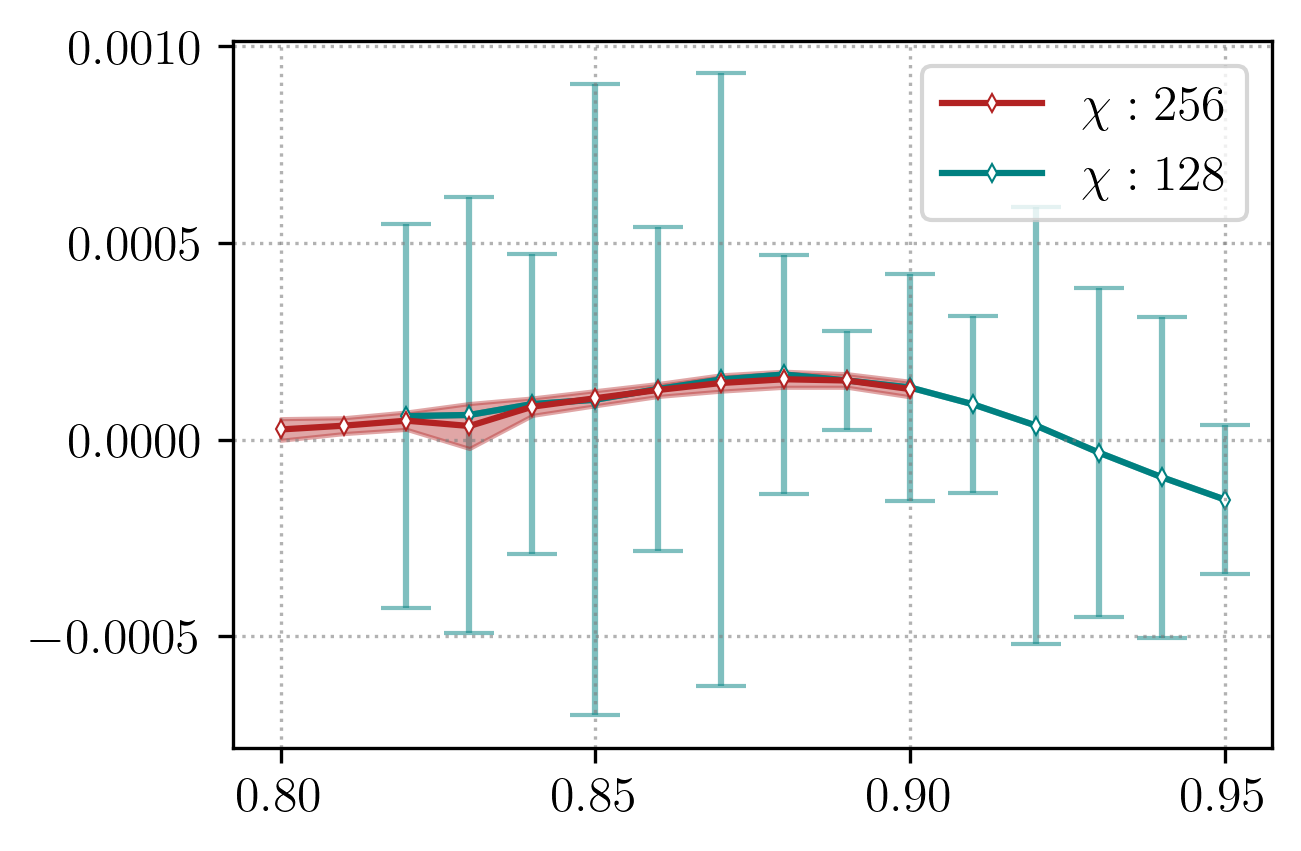

In [213]:
fit = 2
param = 0

l = 6
euclidean = True
manhatten = False
sector = "2_particle(s)_sector"

h_i, h_f, npoints = 0.8, 0.90, 11
gs = np.linspace(h_i,h_f,npoints)
chis = [128,256]
Rss = [15,16,17,18,19,20]

# l = 5
# h_i, h_f, npoints = 0.8, 1.0, 41
# gs = np.linspace(h_i,h_f,npoints)
# chis = [64,128]
# Rss = [13,14,15,16,17,18,19,20]
cx = None
print("\nsigma on 256\n")
sigmas_on, sigmas_on_err, sigmas_on_ris, list_Rs = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, ris=True)
# Rss = [13,14,15,16,17,18,19,20]
print(sigmas_on_ris)
# Rss = [12,13,14,15,16,17,19]
Rss = [15,16,17,18,19,20]
print("\nsigma off 256\n")
cx = None
sigmas_off, sigmas_off_err, sigmas_off_ris, _ = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=True)

obs = np.array(sigmas_off) - np.array(sigmas_on)
obs_err = np.array(sigmas_off_err) + np.array(sigmas_on_err)

fig, ax = plt.subplots(figsize=(4.5, 3))
ax.grid(color="gray", linestyle=":", alpha=0.6)

ax.plot(gs[0:], obs[0:], markersize=3, color="firebrick", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$\\chi: {chis[-1]}$")
# ax.plot(gs[0:], obs[0:], markersize=3, color="firebrick", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$\\sigma_{{off}} - \\sigma_{{on}}$")
ax.fill_between(x=gs[0:], y1=obs[0:]-obs_err[0:], y2=obs[0:]+obs_err[0:], color="firebrick", alpha=0.4)
ax.legend()


h_i, h_f, npoints = 0.8, 0.90, 11
h_i, h_f, npoints = 0.8, 0.95, 16
# h_i, h_f, npoints = 0.6, 0.95, 15
gs = np.linspace(h_i,h_f,npoints)
chis = [64,128]
cx = None
idx = 2

Rss = [15,16,17,18,19,20]
# Rss = [12,13,14,15,16,17,19]
euclidean = True
manhatten = False


print("\nsigma on 128\n")
sigmas_on, sigmas_on_err, sigmas_on_ris, list_Rs = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, ris=True)
Rss = [15,16,17,18,19,20]
# Rss = [12,13,14,15,16,17,19]
print("\nsigma off 128\n")
cx = None
sigmas_off, sigmas_off_err, sigmas_off_ris, _ = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=True)

obs = np.array(sigmas_off) - np.array(sigmas_on)
obs_err = np.array(sigmas_off_err) + np.array(sigmas_on_err)

ax.plot(gs[idx:], obs[idx:], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$\\chi: {chis[-1]}$", zorder=1)
ax.errorbar(x=gs[idx:], y=obs[idx:], yerr=obs_err[idx:], color="teal", alpha=0.5, capsize=6, zorder=0)


# h_i, h_f, npoints = 0.6, 0.95, 15
# gs = np.linspace(h_i,h_f,npoints)
# chis = [64,128]
# Rss = [12,13,14,15,16,17,19]
# euclidean = True
# manhatten = False


# print("\nsigma on 128\n")
# sigmas_on, sigmas_on_err, sigmas_on_ris, list_Rs = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, ris=True)
# Rss = [12,13,14,15,16,17,19]
# print("\nsigma off 128\n")
# cx = None
# sigmas_off, sigmas_off_err, sigmas_off_ris, _ = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=True)

# obs = np.array(sigmas_off) - np.array(sigmas_on)
# obs_err = np.array(sigmas_off_err) + np.array(sigmas_on_err)

# ax.plot(gs[idx:], obs[2:], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w')
# # ax.plot(gs, obs, markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$\\sigma_{{off}} - \\sigma_{{on}}$")
# # ax.fill_between(x=gs, y1=obs-obs_err, y2=obs+obs_err, color="teal", alpha=0.4)
# ax.errorbar(x=gs[2:], y=obs[2:], yerr=obs_err[2:], color="teal", alpha=0.5, capsize=6, zorder=0)

ax.legend()
fig.tight_layout()
fig.savefig(f"{path_figures}/figures/potential/string_tension_difference_on_off-axis_fit_{fit}_{l}x{L}_chis_128-256.pdf", bbox_inches="tight")


sigma on 128

[15, 16, 17, 18, 19, 20]
Weighted Average: 0.10284404955512996
Error in the Average: 0.023988344626499652
Weighted Average: 0.5583142280443657
Error in the Average: 0.0005599985809867841
Weighted Average: 0.9956618130943989
Error in the Average: 0.00016356861533637826
Weighted Average: 1.0365981969076976
Error in the Average: 0.00031237401298900703
Weighted Average: 1.0770306761124353
Error in the Average: 0.00029227258971244483
Weighted Average: 1.1169461379226473
Error in the Average: 0.00022952986237340575
Weighted Average: 1.1563319228413567
Error in the Average: 6.049897792430812e-05
Weighted Average: 1.1952063730148124
Error in the Average: 4.5791429579152045e-05
Weighted Average: 1.2335569173912522
Error in the Average: 0.00016373668417824037
Weighted Average: 1.2713946851226718
Error in the Average: 0.00031297297981666716
Weighted Average: 1.308717703980292
Error in the Average: 0.00010240187638094868
Weighted Average: 1.3455284852484712
Error in the Average: 3.8

/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_1308/2017095429.py:63: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


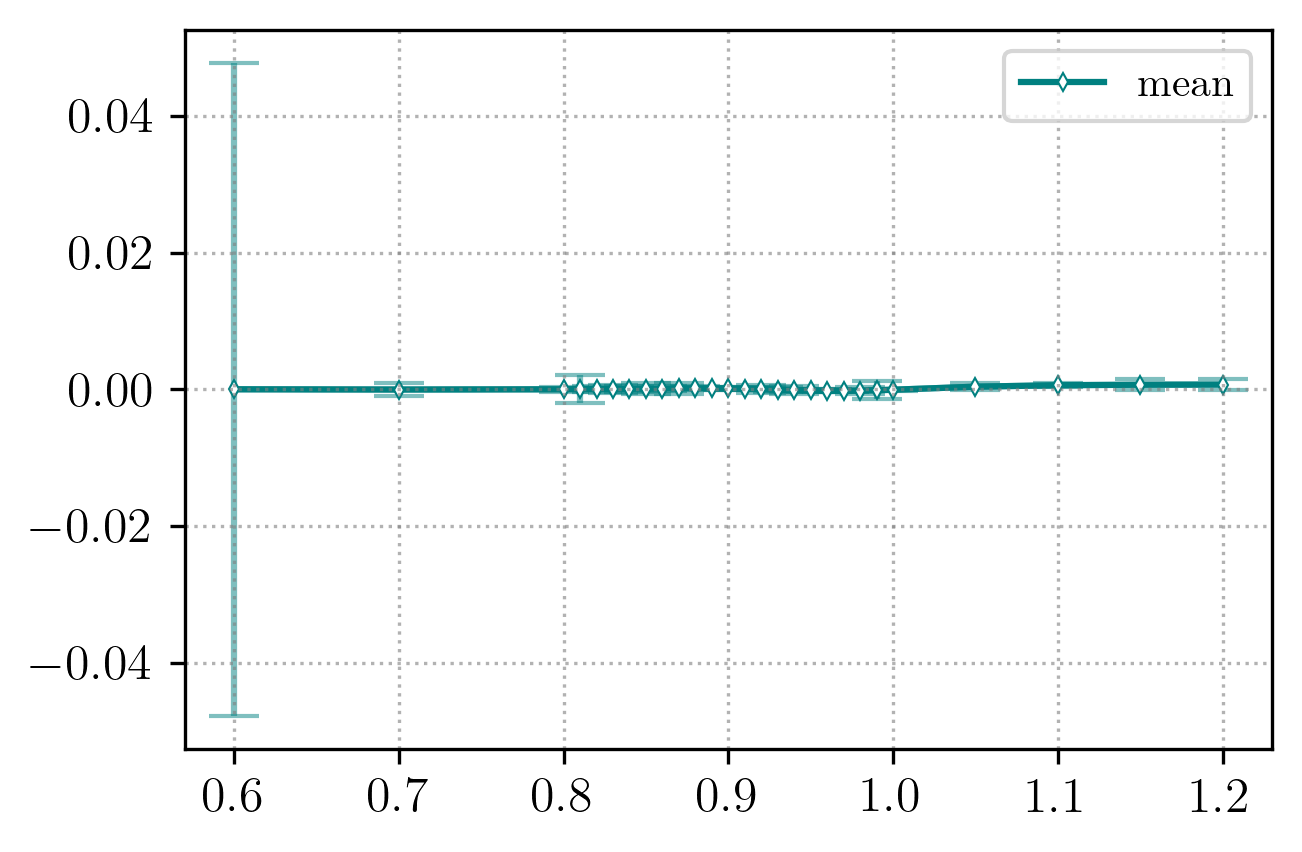

In [303]:
l = 6
h_i, h_f, npoints = 0.8, 0.90, 11
h_i, h_f, npoints = 0.8, 0.95, 16
# h_i, h_f, npoints = 0.6, 0.95, 15
gs = np.linspace(h_i,h_f,npoints)
chis = [64,128]
idx = 0

fig, ax = plt.subplots(figsize=(4.5, 3))
ax.grid(color="gray", linestyle=":", alpha=0.6)
fit = 2

euclidean = True
manhatten = False


h_i, h_f, npoints = 0.6, 0.7, 2
gs1 = np.linspace(h_i,h_f,npoints)

h_i, h_f, npoints = 0.8, 0.95, 16
gs2 = np.linspace(h_i,h_f,npoints)

h_i, h_f, npoints = 0.96, 1.0, 5
gs3 = np.linspace(h_i,h_f,npoints)

h_i, h_f, npoints = 1.05, 1.2, 4
gs4 = np.linspace(h_i,h_f,npoints)

gs = gs1.tolist() + gs2.tolist() + gs3.tolist() + gs4.tolist() 
chis = [64,128]
idx = 0

h_i, h_f, npoints = 0.6, 1.2, 27
print("\nsigma on 128\n")
cx = None
Rss = [15,16,17,18,19,20]
sigmas_on, sigmas_on_err, sigmas_on_ris, sigmas_on_ris_err, list_ris = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, ris=True)
# Rss = [12,13,14,15,16,17,19]
print("\nsigma off 128\n")
Rss = [15,16,17,18,19,20]
cx = None
sigmas_off, sigmas_off_err, sigmas_off_ris, sigmas_off_ris_err, _ = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=True)

obs = np.array(sigmas_off) - np.array(sigmas_on)
obs_err = np.array(sigmas_off_err) + np.array(sigmas_on_err)

ax.plot(gs[idx:], obs[idx:], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w', label="mean", zorder=1)
ax.errorbar(x=gs[idx:], y=obs[idx:], yerr=obs_err[idx:], color="teal", alpha=0.5, capsize=6, zorder=0)
# ax.set_yscale('log')

# i = 0
# colors = create_sequential_colors(len(list_ris))
# for sigmas_on_ri, sigmas_off_ri, sigmas_on_ri_err, sigmas_off_ri_err, ri in zip(sigmas_on_ris, sigmas_off_ris, sigmas_on_ris_err, sigmas_off_ris_err, list_ris):
#     obs = np.array(sigmas_off_ri) - np.array(sigmas_on_ri)
#     obs_err = np.array(sigmas_off_ri_err) + np.array(sigmas_on_ri_err)

#     ax.plot(gs[0:], obs[0:], markersize=3, color=colors[i], marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$R \\in [{ri[0]},{ri[-1]}]$, $n_R={len(ri)}$")
#     # ax.errorbar(x=gs[idx:], y=obs[idx:], yerr=obs_err[idx:], color=colors[i], alpha=0.5, capsize=6, zorder=0)
#     i += 1

ax.legend(fontsize=10)

fig.tight_layout()
fig.savefig(f"{path_figures}/figures/potential/string_tension_difference_on_off-axis_fit_{fit}_different_Rs_set_{l}x{L}_chis_128.pdf", bbox_inches="tight")

In [224]:
## unify energies
from qs_mps.utils import get_cx

l = 6
R = 18
h_i, h_f, npoints = 0.8, 0.85, 2
cx = get_cx(L,R)
cy = [0,0]
chi = 256

energy_80_85_R_20 = np.load(
    f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
)

h_i, h_f, npoints = 0.9, 0.9, 1
energy_90_R_20 = np.load(
    f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
)
h_i, h_f, npoints = 0.81, 0.84, 4
energy_81_84_R_20 = np.load(
    f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
)

h_i, h_f, npoints = 0.86, 0.89, 4
energy_86_89_R_20 = np.load(
    f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
)

# h_i, h_f, npoints = 0.91, 0.94, 4
# energy_91_94_R_20 = np.load(
#     f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
# )

# h_i, h_f, npoints = 0.8, 0.9, 11
# energy_80_90_R_20 = [energy_80_85_R_20[0]] + energy_81_84_R_20.tolist() + [energy_80_85_R_20[1]] + energy_86_89_R_20.tolist() + energy_90_R_20.tolist()
# print(len(energy_80_90_R_20), energy_80_90_R_20)
# np.save(f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy", energy_80_90_R_20)

In [ ]:
R = 15
cx = get_cx(L,R)
cy = [0,0]
chi = 256

h_i, h_f, npoints = 0.6, 0.95, 15
energy_60_95_R_17 = np.load(
    f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
)
h_i, h_f, npoints = 0.81, 0.84, 4
energy_81_84_R_17 = np.load(
    f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
)

h_i, h_f, npoints = 0.86, 0.89, 4
energy_86_89_R_17 = np.load(
    f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
)
h_i, h_f, npoints = 0.91, 0.94, 4
energy_91_94_R_17 = np.load(
    f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
)
# h_i, h_f, npoints = 0.8, 0.9, 11
# energy_80_90_R_17 = [energy_60_95_R_17[8]] + energy_81_84_R_17.tolist() + [energy_60_95_R_17[10]] + energy_86_89_R_17.tolist() + [energy_60_95_R_17[12]]
# print(len(energy_80_90_R_17), energy_80_90_R_17)
# np.save(f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy", energy_80_90_R_17)

In [ ]:
vac = None
chi = 128

# h_i, h_f, npoints = 0.6, 0.95, 15
# energy_vacuum_60_95 = np.load(
#     f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_vacuum_sector_bc_{bc}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
# )

vac = np.nan
h_i, h_f, npoints = 0.81, 0.84, 4
h_i, h_f, npoints = 0.6, 0.9, 31
# energy_vacuum_81_84 = np.load(
energy_vacuum_60_90 = np.load(
    f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_vacuum_sector_bc_{bc}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
)

# h_i, h_f, npoints = 0.86, 0.89, 4
h_i, h_f, npoints = 0.9, 1.0, 11
# energy_vacuum_86_89 = np.load(
energy_vacuum_90_100 = np.load(
    f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_vacuum_sector_bc_{bc}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
)

# h_i, h_f, npoints = 0.8, 0.95, 16
# energy_vacuum_80_95 = energy_vacuum_60_90[20:].tolist() + energy_vacuum_90_100[1:6].tolist()
# print(len(energy_vacuum_80_95), energy_vacuum_80_95)
# print(energy_vacuum_60_90[20:], energy_vacuum_90_100[:6].tolist())
# np.save(f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_vacuum_sector_bc_{bc}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy", energy_vacuum_80_95)

h_i, h_f, npoints = 0.8, 0.9, 11
# energy_vacuum_80_90 = [energy_vacuum_60_95[8]] + energy_vacuum_81_84.tolist() + [energy_vacuum_60_95[10]] + energy_vacuum_86_89.tolist() + [energy_vacuum_60_95[12]]
energy_vacuum_80_90 = energy_vacuum_60_90[20:]
print(len(energy_vacuum_80_90), energy_vacuum_80_90)
np.save(f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_vacuum_sector_bc_{bc}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy", energy_vacuum_80_90)

11 [-337.2869593  -339.29319093 -341.38137988 -343.54642299 -345.78360294
 -348.08855354 -350.45722865 -352.88587437 -355.37100406 -357.90937583
 -360.49797226]


In [766]:
R = 20
cx = get_cx(L,R)
cy = [0,0]
chi = 64

h_i, h_f, npoints = 0.6, 0.9, 31
energy_60_90_R_17 = np.load(
    f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
)
h_i, h_f, npoints = 0.9, 1.0, 11
energy_90_100_R_17 = np.load(
    f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
)

# h_i, h_f, npoints = 0.8, 0.95, 16
# energy_80_95_R_17 = energy_60_90_R_17[20:].tolist() + energy_90_100_R_17[1:6].tolist()
# print(len(energy_80_95_R_17), energy_80_95_R_17)
# print(energy_60_90_R_17[20:], energy_90_100_R_17[:6].tolist())
# np.save(f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy", energy_80_95_R_17)

h_i, h_f, npoints = 0.8, 0.9, 11
energy_80_90_R_17 = energy_60_90_R_17[20:]
print(len(energy_80_90_R_17), energy_80_90_R_17)
print(energy_60_90_R_17[20:])
np.save(f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy", energy_80_90_R_17)

11 [-316.99884335 -318.19576656 -319.485693   -320.86353843 -322.32456561
 -323.8644477  -325.47914736 -327.16493493 -328.9183809  -330.73626548
 -332.61563123]
[-316.99884335 -318.19576656 -319.485693   -320.86353843 -322.32456561
 -323.8644477  -325.47914736 -327.16493493 -328.9183809  -330.73626548
 -332.61563123]


In [257]:
R = 15
cx = get_cx(L,R)
cy = [0,0]
chi = 128

h_i, h_f, npoints = 0.6, 0.7, 2
energy_60_70_R = np.load(
    f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
)
h_i, h_f, npoints = 0.8, 0.95, 16
energy_80_95_R = np.load(
    f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
)
h_i, h_f, npoints = 0.96, 1.0, 5
energy_96_100_R = np.load(
    f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
)
h_i, h_f, npoints = 1.05, 1.2, 4
energy_105_120_R = np.load(
    f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
)

# h_i, h_f, npoints = 0.8, 0.95, 16
# energy_80_95_R = energy_60_90_R[20:].tolist() + energy_90_100_R[1:6].tolist()
# print(len(energy_80_95_R), energy_80_95_R)
# print(energy_60_90_R[20:], energy_90_100_R[:6].tolist())
# np.save(f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy", energy_80_95_R)

h_i, h_f, npoints = 0.6, 1.2, 27
energy_60_120_R = energy_60_70_R.tolist() + energy_80_95_R.tolist() + energy_96_100_R.tolist() + energy_105_120_R.tolist()
np.save(f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy", energy_60_120_R)

In [264]:
cy = [0,0]
chi = 64

vac = None
h_i, h_f, npoints = 0.6, 0.7, 2
energy_60_70_vac = np.load(
    f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_vacuum_sector_bc_{bc}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
)
vac = np.nan
h_i, h_f, npoints = 0.8, 0.95, 16
energy_80_95_vac = np.load(
    f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_vacuum_sector_bc_{bc}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
)
vac = None
h_i, h_f, npoints = 0.96, 1.0, 5
energy_96_100_vac = np.load(
    f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_vacuum_sector_bc_{bc}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
)
vac = np.nan
h_i, h_f, npoints = 1.05, 1.2, 4
energy_105_120_vac = np.load(
    f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_vacuum_sector_bc_{bc}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
)
# h_i, h_f, npoints = 0.8, 0.95, 16
# energy_80_95_vac = energy_60_90_vac[20:].tolist() + energy_90_100_vac[1:6].tolist()
# print(len(energy_80_95_vac), energy_80_95_vac)
# print(energy_60_90_vac[20:], energy_90_100_vac[:6].tolist())
# np.save(f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_vacuum_sector_bc_{bc}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy", energy_80_95_vac)

h_i, h_f, npoints = 0.6, 1.2, 27
energy_60_120_vac = energy_60_70_vac.tolist() + energy_80_95_vac.tolist() + energy_96_100_vac.tolist() + energy_105_120_vac.tolist()
np.save(f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_vacuum_sector_bc_{bc}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy", energy_60_120_vac)

[10, 12, 13, 14, 15, 16, 17, 19]
[12, 13, 14, 15, 16, 17, 19]
[13, 14, 15, 16, 17, 19]
Weighted Average: 0.9956367093110354
Error in the Average: 5.573876142763573e-06
Weighted Average: 1.1951778643617277
Error in the Average: 4.851903218852794e-06
Weighted Average: 1.3818111110585338
Error in the Average: 1.0630329826690032e-06
[15, 16, 17, 18, 19, 20]
Weighted Average: 0.995674923107789
Error in the Average: 8.211316135265528e-06
Weighted Average: 1.195305478399308
Error in the Average: 7.395458266248035e-06
Weighted Average: 1.3819439763225554
Error in the Average: 1.3615046095600843e-05
[10, 12, 13, 14, 15, 16, 17, 19]
[12, 13, 14, 15, 16, 17, 19]
[13, 14, 15, 16, 17, 19]
Weighted Average: 0.9956367093110354
Error in the Average: 5.573876142763573e-06
Weighted Average: 1.1951778643617277
Error in the Average: 4.851903218852794e-06
Weighted Average: 1.3818111110585338
Error in the Average: 1.0630329826690032e-06
[15, 16, 17, 18, 19, 20]
Weighted Average: 0.995674923107789
Error in t

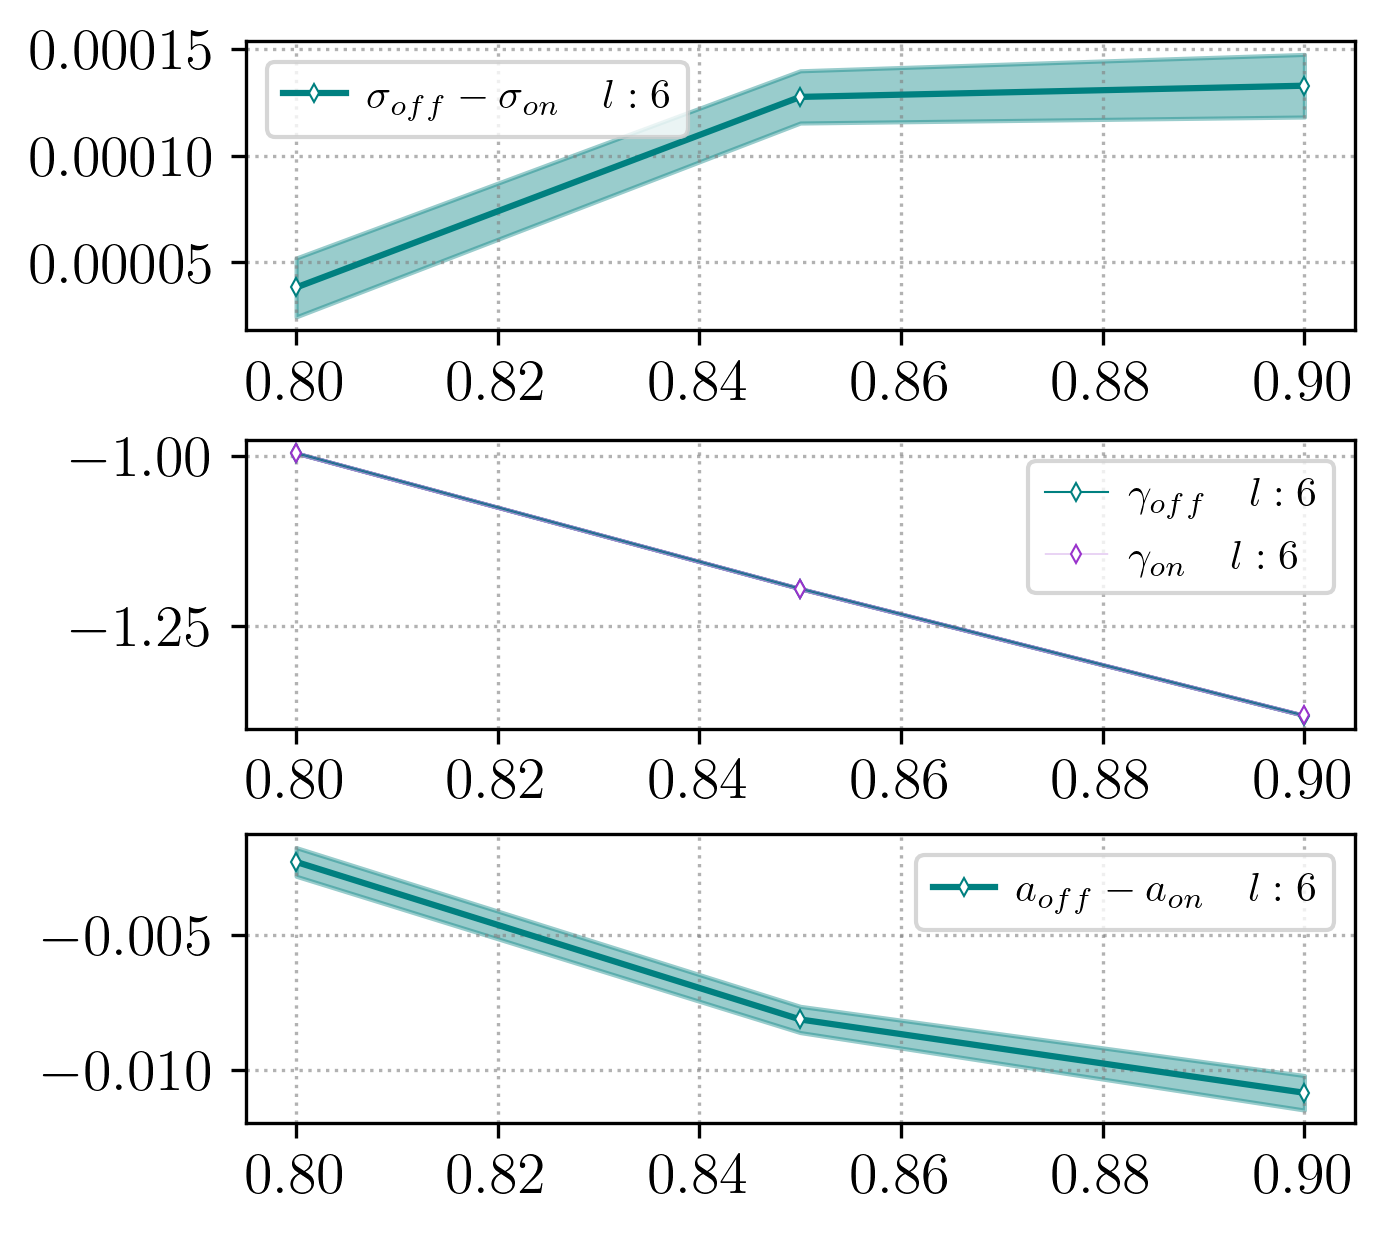

In [344]:
fit = 2
l = 6
h_i, h_f, npoints = 0.6, 0.95, 15
gs = np.linspace(h_i,h_f,npoints)
chis = [128,256]
# chis = [64,128]
Rss = [10,12,13,14,15,16,17,19]
euclidean = True
manhatten = False

# l = 5
# h_i, h_f, npoints = 0.8, 1.0, 41
# gs = np.linspace(h_i,h_f,npoints)
# chis = [64,128]
# Rss = [13,14,15,16,17,18,19,20]

h_i, h_f, npoints = 0.8, 0.9, 3
gs = np.linspace(h_i,h_f,npoints)

param = 0
sigmas_on, sigmas_on_err, sigmas_on_ris, list_Rs = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, ris=True)
Rss = [10,12,13,14,15,16,17,19]

fit = 2
param = 0
h_i, h_f, npoints = 0.8, 0.9, 3
gs = np.linspace(h_i,h_f,npoints)
Rss = [15,16,17,18,19,20]
sigmas_off, sigmas_off_err, sigmas_off_ris, _ = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=True)

obs = np.array(sigmas_off) - np.array(sigmas_on)
obs_err = np.array(sigmas_off_err) + np.array(sigmas_on_err)

fig, axs = plt.subplots(3,1, figsize=(4.5, 4))
for ax in axs:
    ax.grid(color="gray", linestyle=":", alpha=0.6)

axs[0].plot(gs[0:], obs[0:], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$\\sigma_{{off}} - \\sigma_{{on}} \\quad l: {l}$")
# axs[0].plot(gs[0:], obs[0:], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$\\sigma_{{off}} - \\sigma_{{on}}$")
axs[0].fill_between(x=gs[0:], y1=obs[0:]-obs_err[0:], y2=obs[0:]+obs_err[0:], color="teal", alpha=0.4)
axs[0].legend()

# param = 1
# Rss = [10,12,13,14,15,16,17,19]
# lusch_on, lusch_on_err, lusch_on_ris, list_Rs = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, ris=True)
# Rss = [10,12,13,14,15,16,17,19]
# lusch_off, lusch_off_err, lusch_off_ris, _ = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=True)

# obs = np.array(lusch_off) - np.array(lusch_on)
# obs_err = np.array(lusch_off_err) + np.array(lusch_on_err)

# axs[1].plot(gs[0:], obs[0:], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$\\gamma_{{off}} - \\gamma_{{on}} \\quad l: {l}$")
# # axs[0].plot(gs[0:], obs[0:], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$\\sigma_{{off}} - \\sigma_{{on}}$")
# axs[1].fill_between(x=gs[0:], y1=obs[0:]-obs_err[0:], y2=obs[0:]+obs_err[0:], color="teal", alpha=0.4)
# axs[1].legend()

chis = [128,256]
param = 0
Rss = [10,12,13,14,15,16,17,19]
sigmas_on, sigmas_on_err, sigmas_on_ris, list_Rs = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, ris=True)

fit = 2
param = 0
h_i, h_f, npoints = 0.8, 0.9, 3
gs = np.linspace(h_i,h_f,npoints)
Rss = [15,16,17,18,19,20]
sigmas_off, sigmas_off_err, sigmas_off_ris, _ = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=True)

obs_off = np.array(sigmas_off)
obs_on = np.array(sigmas_on)
obs_err_off = np.array(sigmas_off_err)
obs_err_on = np.array(sigmas_on_err)

axs[1].plot(gs[0:], -obs_off[0:], markersize=3, color="teal", marker='d', linewidth=0.5, fillstyle=None, mew=0.5, mfc='w', label=f"$\\gamma_{{off}} \\quad l: {l}$")
axs[1].fill_between(x=gs[0:], y1=-obs_off[0:]-obs_err_off[0:], y2=-obs_off[0:]+obs_err_off[0:], color="teal", alpha=0.4)

# h_i, h_f, npoints = 0.6, 0.95, 15
# gs = np.linspace(h_i,h_f,npoints)

axs[1].plot(gs[0:], -obs_on[0:], markersize=3, color="darkorchid", marker='d', linewidth=0.1, fillstyle=None, mew=0.5, mfc='w', label=f"$\\gamma_{{on}} \\quad l: {l}$")
axs[1].fill_between(x=gs[0:], y1=-obs_on[0:]-obs_err_on[0:], y2=-obs_on[0:]+obs_err_on[0:], color="darkorchid", alpha=0.4)

axs[1].legend()

h_i, h_f, npoints = 0.8, 0.9, 3
gs = np.linspace(h_i,h_f,npoints)

param = -1
Rss = [10,12,13,14,15,16,17,19]
const_on, const_on_err, const_on_ris, list_Rs = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, ris=True)
Rss = [10,12,13,14,15,16,17,19]
Rss = [15,16,17,18,19,20]
const_off, const_off_err, const_off_ris, _ = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=True)

obs = np.array(const_off) - np.array(const_on)
obs_err = np.array(const_off_err) + np.array(const_on_err)

axs[2].plot(gs[0:], obs[0:], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$a_{{off}} - a_{{on}} \\quad l: {l}$")
# axs[0].plot(gs[0:], obs[0:], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$\\sigma_{{off}} - \\sigma_{{on}}$")
axs[2].fill_between(x=gs[0:], y1=obs[0:]-obs_err[0:], y2=obs[0:]+obs_err[0:], color="teal", alpha=0.4)
axs[2].legend()

[15, 16, 17, 18, 19, 20]
[16, 17, 18, 19, 20]
Weighted Average: 0.9956039553304852
Error in the Average: 7.370061484818923e-06
Weighted Average: 1.036550686658304
Error in the Average: 5.91815025663172e-06
Weighted Average: 1.076978057200136
Error in the Average: 6.169270947132676e-06
Weighted Average: 1.1168870692870712
Error in the Average: 6.856726740013073e-06
Weighted Average: 1.156279709381435
Error in the Average: 5.909057610949202e-06
Weighted Average: 1.195156740755132
Error in the Average: 5.683865586532996e-06
Weighted Average: 1.2335205185052465
Error in the Average: 4.096857771748959e-06
Weighted Average: 1.2713713937709519
Error in the Average: 2.9806324393245914e-06
Weighted Average: 1.3087094580305272
Error in the Average: 1.4206165289024916e-06
Weighted Average: 1.3455322672150245
Error in the Average: 1.3760249569715673e-06
Weighted Average: 1.3818339763673877
Error in the Average: 2.13216993643226e-06
[15, 16, 17, 18, 19, 20]
[16, 17, 18, 19, 20]
Weighted Average: 0.

/Users/fradm/Desktop/qs-mps/src/qs_mps/applications/Z2/relevant_observables.py:502: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(potential_fit_3, Rs, potentials, sigma=errors, p0=guess)
/Users/fradm/Desktop/qs-mps/src/qs_mps/applications/Z2/utils.py:80: RuntimeWarning: invalid value encountered in scalar divide
  av = np.sum(np.asarray(data) * weights) / np.sum(weights)
/Users/fradm/Desktop/qs-mps/src/qs_mps/applications/Z2/utils.py:83: RuntimeWarning: divide by zero encountered in scalar divide
  av_err = np.sqrt(1 / np.sum(weights))


(0.79, 0.905)

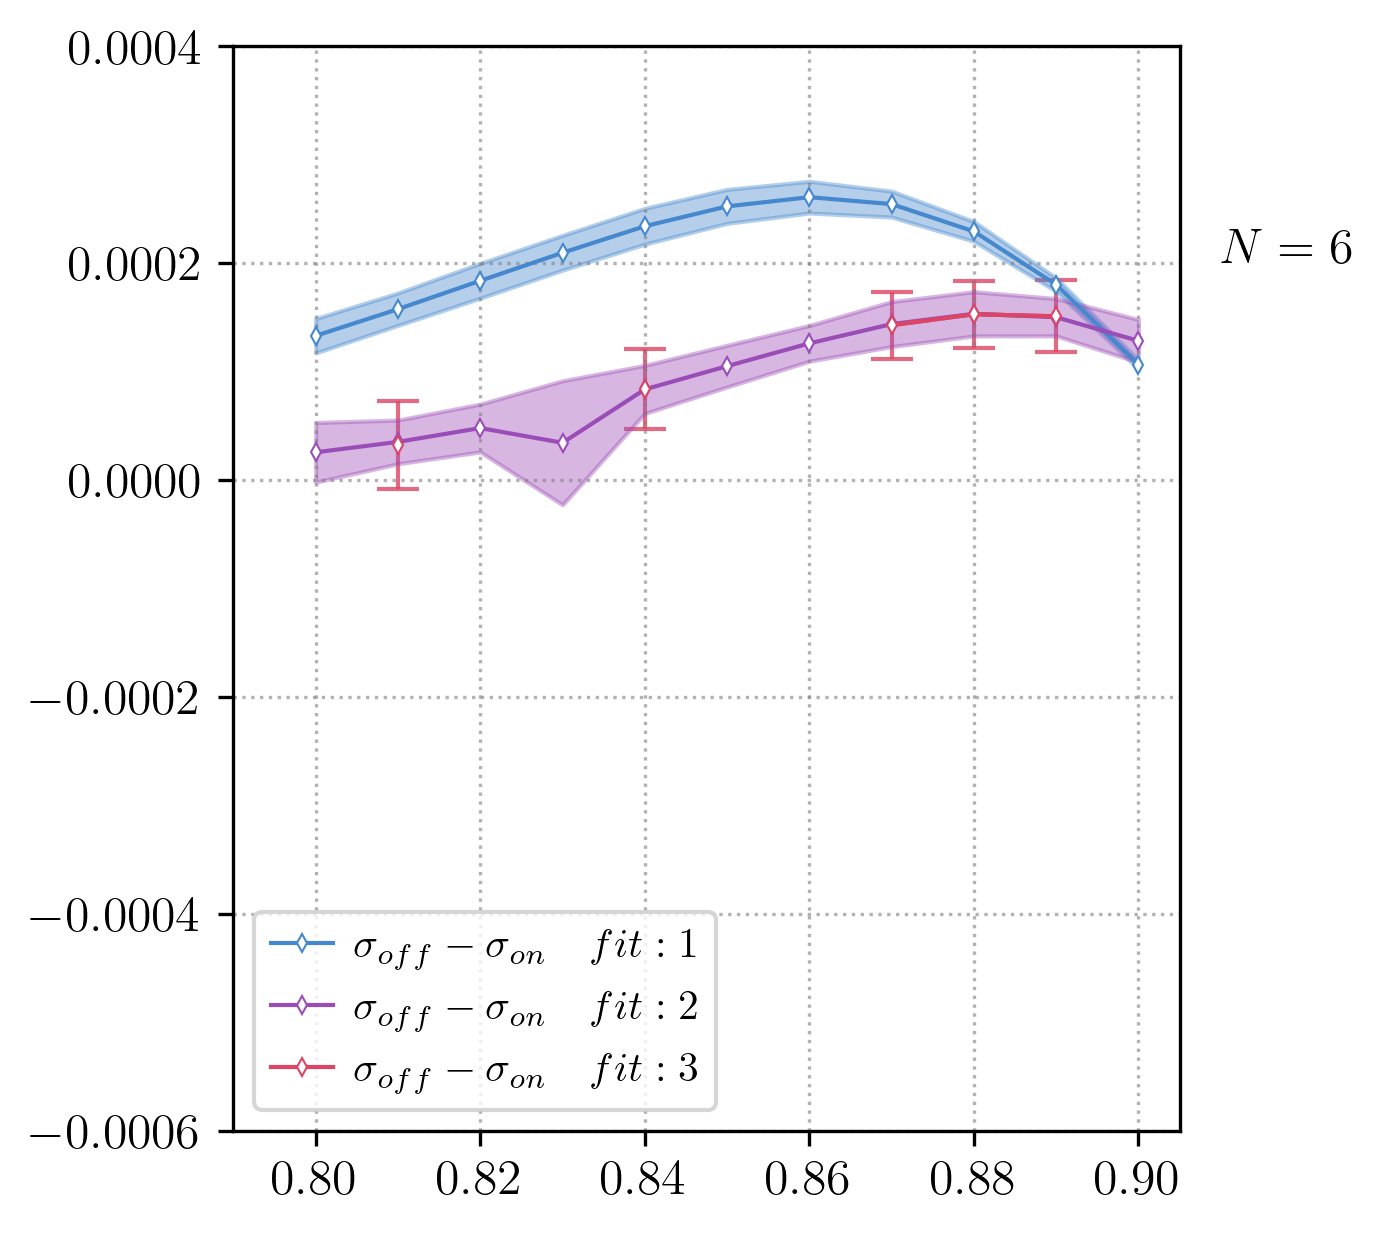

In [772]:
fit = 1
l = 6
h_i, h_f, npoints = 0.8, 0.9, 11
gs = np.linspace(h_i,h_f,npoints)
chis = [128,256]
# chis = [64,128]
Rss = [10,12,13,14,15,16,17,19]
euclidean = True
manhatten = False

# l = 5
# h_i, h_f, npoints = 0.8, 1.0, 41
# gs = np.linspace(h_i,h_f,npoints)
# chis = [64,128]
# Rss = [10,11,12,13,14,15,16,17,18,19,20]
colors = ["#4688CE","#9B4DB7","#DC4563"]
fig, ax = plt.subplots(figsize=(4.5, 4))
ax.grid(color="gray", linestyle=":", alpha=0.6)

for fit in range(1,4):
    param = 0
    Rss = [10,12,13,14,15,16,17,19]
    Rss = [15,16,17,18,19,20]
    # Rss = [10,11,12,13,14,15,16,17,18,19,20]
    sigmas_on, sigmas_on_err, sigmas_on_ris, list_Rs = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, ris=True)
    Rss = [10,12,13,14,15,16,17,19]
    Rss = [15,16,17,18,19,20]
    # Rss = [10,11,12,13,14,15,16,17,18,19,20]
    sigmas_off, sigmas_off_err, sigmas_off_ris, _ = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=True)

    obs = np.array(sigmas_off) - np.array(sigmas_on)
    obs_err = np.array(sigmas_off_err) + np.array(sigmas_on_err)

    ax.plot(gs[0:], obs[0:], markersize=3, color=colors[fit-1], marker='d', linewidth=1, fillstyle=None, mew=0.5, mfc='w', label=f"$\\sigma_{{off}} - \\sigma_{{on}} \\quad fit: {fit}$")
    # ax.plot(gs[0:], obs[0:], markersize=3, color=colors[fit-1], marker='d', linewidth=1, fillstyle=None, mew=0.5, mfc='w', label=f"$\\sigma_{{off}} - \\sigma_{{on}}$")
    if fit == 1 or fit == 2:
        ax.fill_between(x=gs[0:], y1=obs[0:]-obs_err[0:], y2=obs[0:]+obs_err[0:], color=colors[fit-1], alpha=0.4)
    if fit == 3:
        ax.errorbar(x=gs[0:], y=obs[0:], yerr=obs_err[0:], color=colors[fit-1],linewidth=1, capsize=5, alpha=0.8, zorder=0)

# l = 5
# h_i, h_f, npoints = 0.2, 1.0, 21
# gs = np.linspace(h_i,h_f,npoints)
# chis = [64,128]
# Rss = [10,11,12,13,14,15,16,17,18,19,20]

# for fit in range(1,4):
#     param = 0
#     # Rss = [10,12,13,14,15,16,17,19]
#     Rss = [10,11,12,13,14,15,16,17,18,19,20]
#     sigmas_on, sigmas_on_err, sigmas_on_ris, list_Rs = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, ris=True)
#     # Rss = [10,12,13,14,15,16,17,19]
#     Rss = [10,11,12,13,14,15,16,17,18,19,20]
#     sigmas_off, sigmas_off_err, sigmas_off_ris, _ = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=True)

#     obs = np.array(sigmas_off) - np.array(sigmas_on)
#     obs_err = np.array(sigmas_off_err) + np.array(sigmas_on_err)

#     ax.plot(gs[12:16], obs[12:16], markersize=3, color=colors[fit-1], marker='d', linewidth=1, fillstyle=None, mew=0.5, mfc='w')
#     # ax.plot(gs[12:16], obs[12:16], markersize=3, color=colors[fit-1], marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$\\sigma_{{off}} - \\sigma_{{on}}$")
#     ax.fill_between(x=gs[12:16], y1=obs[12:16]-obs_err[12:16], y2=obs[12:16]+obs_err[12:16], color=colors[fit-1], alpha=0.4)
#     # ax.errorbar(x=gs[12:16], y=obs[12:16], yerr=obs_err[12:16], color=colors[fit-1], linewidth=1, capsize=5, alpha=0.8, zorder=0)

ax.legend()
ax.text(x=0.91, y=0.0002, s=f"$N={l}$")
ax.set_ylim(-0.0006,0.0004)
ax.set_xlim(left=0.79)

[25, 26, 27, 28, 29, 30]
[26, 27, 28, 29, 30]
Weighted Average: 0.27939203224421066
Error in the Average: 0.021828393479343032
Weighted Average: 0.3105202496514403
Error in the Average: 0.027641373143862894
Weighted Average: 0.322222147892166
Error in the Average: 0.03668577091003899
Weighted Average: 0.1539725252313983
Error in the Average: 0.004603018264603654
Weighted Average: 0.015136473437323507
Error in the Average: 0.0008897770045194274
[25, 26, 27, 28, 29, 30]
Weighted Average: 0.27742118268867944
Error in the Average: 0.9672666744238788
Weighted Average: 0.30618777133591346
Error in the Average: 0.6918666004225641
Weighted Average: 0.31977019629627274
Error in the Average: 0.05078933778743175
Weighted Average: 0.1527184766581775
Error in the Average: 0.005208132474883468
Weighted Average: 0.01869900881652674
Error in the Average: 0.00642322963439846
[10, 12, 13, 14, 15, 16, 17, 19]
[12, 13, 14, 15, 16, 17, 19]
[13, 14, 15, 16, 17, 19]
[14, 15, 16, 17, 19]
Weighted Average: -0.

(-1.0, 0.0)

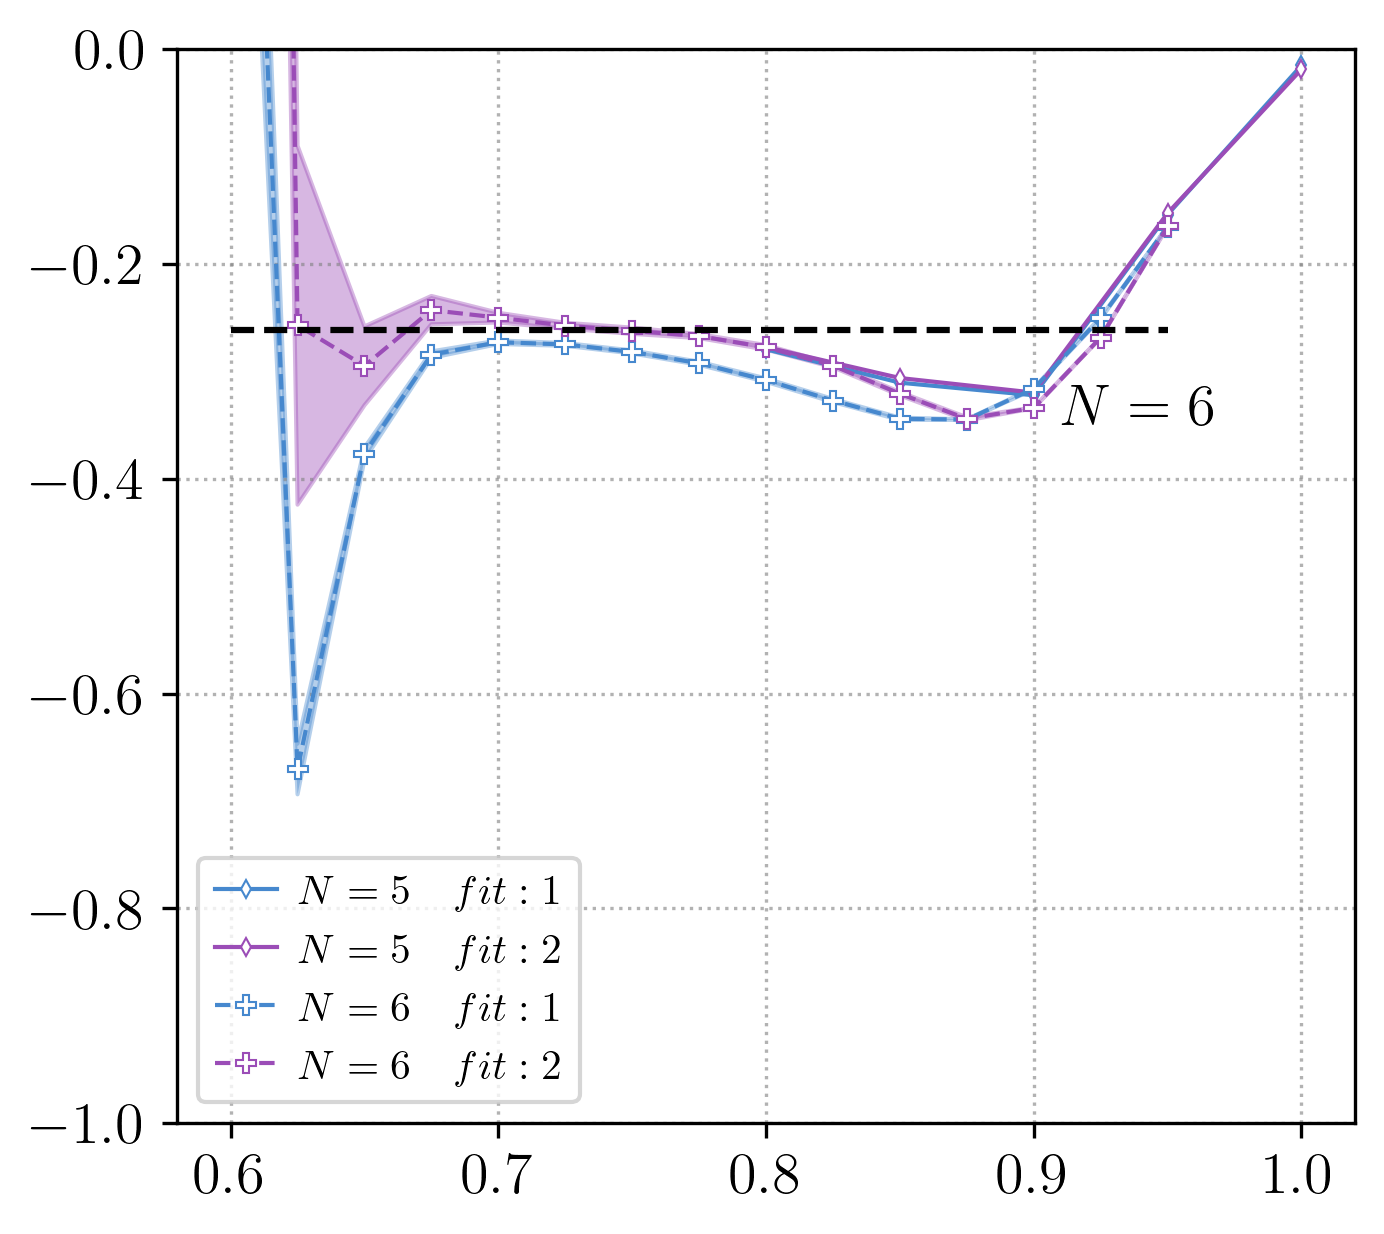

In [875]:
fit = 1
l = 6
h_i, h_f, npoints = 0.6, 0.95, 15
gs = np.linspace(h_i,h_f,npoints)
chis = [128,256]
# chis = [64,128]
Rss = [10,12,13,14,15,16,17,19]
euclidean = False
manhatten = False

l, L = 5, 50
h_i, h_f, npoints = 0.8, 1.0, 5
gs = np.linspace(h_i,h_f,npoints)
chis = [64,128]
Rss = [25,26,27,28,29,30]

# l = 5
# h_i, h_f, npoints = 0.8, 1.0, 41
# gs = np.linspace(h_i,h_f,npoints)
# chis = [64,128]
# Rss = [10,11,12,13,14,15,16,17,18,19,20]
colors = ["#4688CE","#9B4DB7","#DC4563"]
fig, ax = plt.subplots(figsize=(4.5, 4))
ax.grid(color="gray", linestyle=":", alpha=0.6)

for fit in range(1,3):
    param = 1
    # Rss = [10,11,12,13,14,15,16,17,18,19,20]
    Rss = [25,26,27,28,29,30]
    sigmas_on, sigmas_on_err, sigmas_on_ris, sigmas_on_ris_err, list_Rs = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=True)
    # Rss = [10,11,12,13,14,15,16,17,18,19,20]
    # sigmas_off, sigmas_off_err, sigmas_off_ris, _ = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=True)

    obs = -np.array(sigmas_on)
    obs_err = np.array(sigmas_on_err)

    ax.plot(gs[0:], obs[0:], markersize=3, color=colors[fit-1], marker='d', linewidth=1, fillstyle=None, mew=0.5, mfc='w', label=f"$N={l} \\quad fit: {fit}$")
    # ax.plot(gs[0:], obs[0:], markersize=3, color=colors[fit-1], marker='d', linewidth=1, fillstyle=None, mew=0.5, mfc='w', label=f"$\\sigma_{{off}} - \\sigma_{{on}}$")
    # if fit == 1 or fit == 2:
        # ax.fill_between(x=gs[0:], y1=obs[0:]-obs_err[0:], y2=obs[0:]+obs_err[0:], color=colors[fit-1], alpha=0.4)
    # if fit == 3:
        # ax.errorbar(x=gs[0:], y=obs[0:], yerr=obs_err[0:], color=colors[fit-1],linewidth=1, capsize=5, alpha=0.8, zorder=0)
        # ax.fill_between(x=gs[0:], y1=obs[0:]-obs_err[0:], y2=obs[0:]+obs_err[0:], color=colors[fit-1], alpha=0.4)


l, L = 6, 30
h_i, h_f, npoints = 0.6, 0.95, 15
gs = np.linspace(h_i,h_f,npoints)
chis = [128,256]
# chis = [64,128]
for fit in range(1,3):
    param = 1
    # Rss = [10,11,12,13,14,15,16,17,18,19,20]
    Rss = [10,12,13,14,15,16,17,19]
    sigmas_on, sigmas_on_err, sigmas_on_ris, sigmas_on_ris_err, list_Rs = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=True)
    # Rss = [10,11,12,13,14,15,16,17,18,19,20]
    # sigmas_off, sigmas_off_err, sigmas_off_ris, _ = fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=True)

    obs = -np.array(sigmas_on)
    obs_err = np.array(sigmas_on_err)

    ax.plot(gs[0:], obs[0:], markersize=5, color=colors[fit-1], marker='P', linewidth=1, fillstyle=None, mew=0.5, mfc='w', linestyle='--', label=f"$N={l} \\quad fit: {fit}$")
    ax.fill_between(x=gs[0:], y1=obs[0:]-obs_err[0:], y2=obs[0:]+obs_err[0:], color=colors[fit-1], alpha=0.4)
ax.hlines(y=-np.pi/12, xmin=gs[0], xmax=gs[-1], color='k', linestyle='--')
ax.legend()
ax.text(x=0.91, y=-0.35, s=f"$N={l}$")
ax.set_ylim(-1,0)
# ax.set_xlim(0.89,0.96)


sigma on 256

[15, 16, 17, 18, 19, 20]
Weighted Average: 0.9956493820098042
Error in the Average: 1.9499663188130688e-05
Weighted Average: 1.03659906955077
Error in the Average: 1.0291491215644997e-05
Weighted Average: 1.077028861534872
Error in the Average: 4.680385903044563e-06
Weighted Average: 1.1169385589121388
Error in the Average: 1.1783693071870903e-05
Weighted Average: 1.1563287887243328
Error in the Average: 6.858474170075499e-06
Weighted Average: 1.1952004645206886
Error in the Average: 1.1906965542773778e-05
Weighted Average: 1.2335550673328834
Error in the Average: 4.127629936997735e-06
Weighted Average: 1.2713936849925407
Error in the Average: 4.632555766442842e-06
Weighted Average: 1.3087175468358407
Error in the Average: 2.2790463272637374e-06
Weighted Average: 1.3455258650194575
Error in the Average: 7.268567592050473e-06
Weighted Average: 1.381815659476979
Error in the Average: 6.522515551462481e-06
[[1.71368199 1.99462342 2.24615516 2.48110786 2.70590858 2.92410729


/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_1308/1870086714.py:44: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_1308/1870086714.py:71: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_1308/1870086714.py:98: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Weighted Average: 0.2546947792644185
Error in the Average: 0.09781595704587812
Weighted Average: -0.20346620902853194
Error in the Average: 0.18127184526752335
Weighted Average: -0.5876549665777107
Error in the Average: 0.15867149805256775
[[1.71368199 1.99462342 2.24615516 2.48110786 2.70590858 2.92410729
  3.13781702 3.34836841 3.55663511 3.76321164 3.96851321]
 [1.7136882  1.99462306 2.24615513 2.4811078  2.70590843 2.92410726
  3.13781702 3.34836842 3.55663521 3.76321176 3.96851324]
 [1.71369324 1.99462053 2.24615527 2.48110775 2.70590858 2.9241071
  3.13781712 3.34836812 3.5566351  3.76321157 3.9685132 ]
 [1.71369748 1.99462052 2.24615502 2.48110773 2.70590837 2.9241074
  3.13781682 3.34836824 3.55663532 3.76321155 3.96851316]
 [1.71370099 1.99462018 2.24615534 2.48110775 2.70590845 2.92410728
  3.13781685 3.34836824 3.55663491 3.76321113 3.96851304]
 [1.71370385 1.99462163 2.24615505 2.48110762 2.70590854 2.92410333
  3.1378171  3.34836801 3.55663466 3.76321125 3.96851251]]

sigm

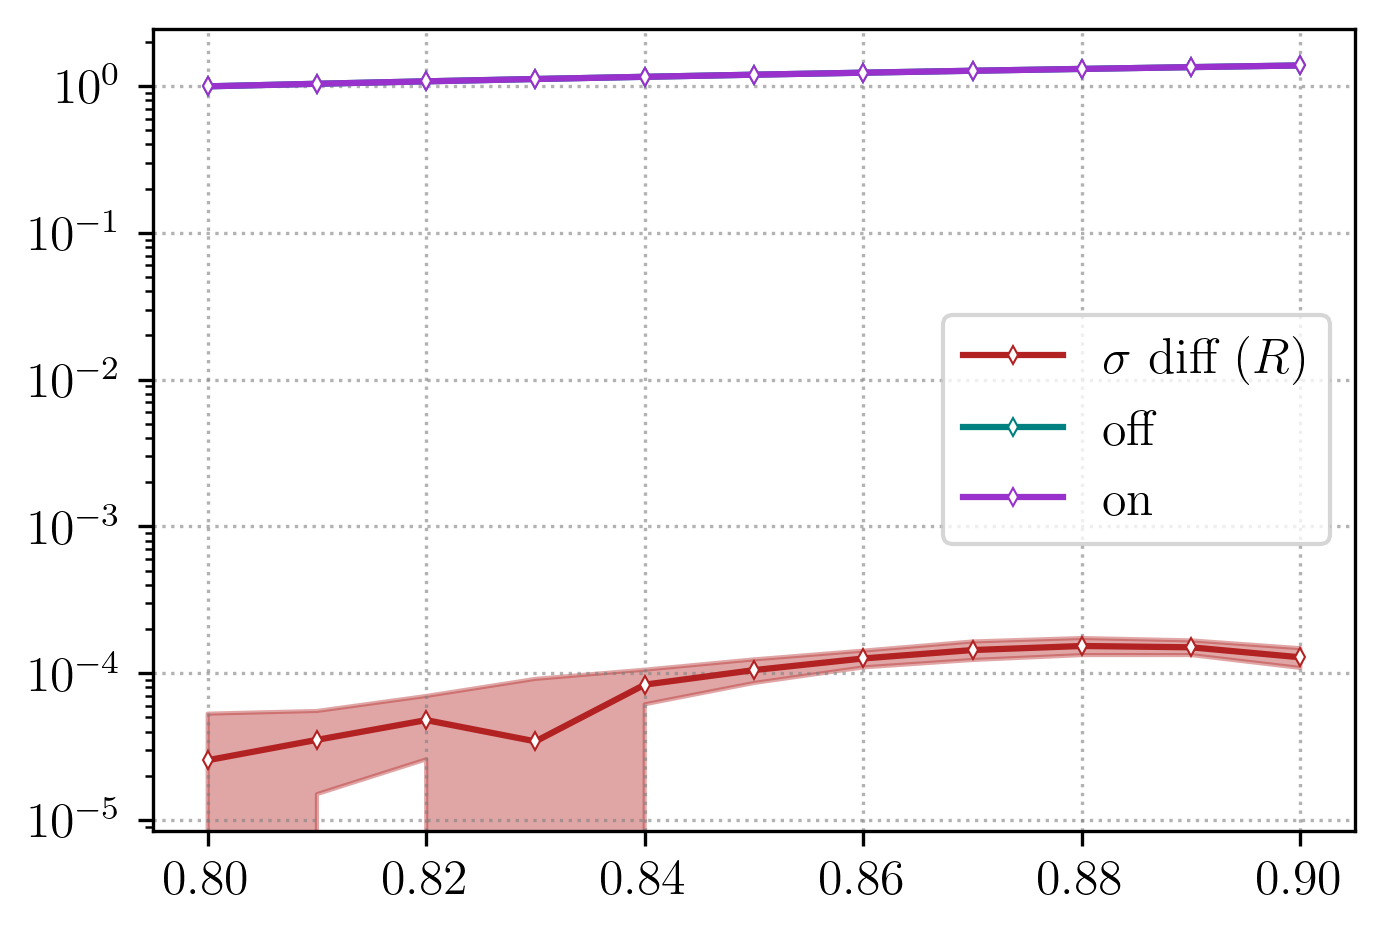

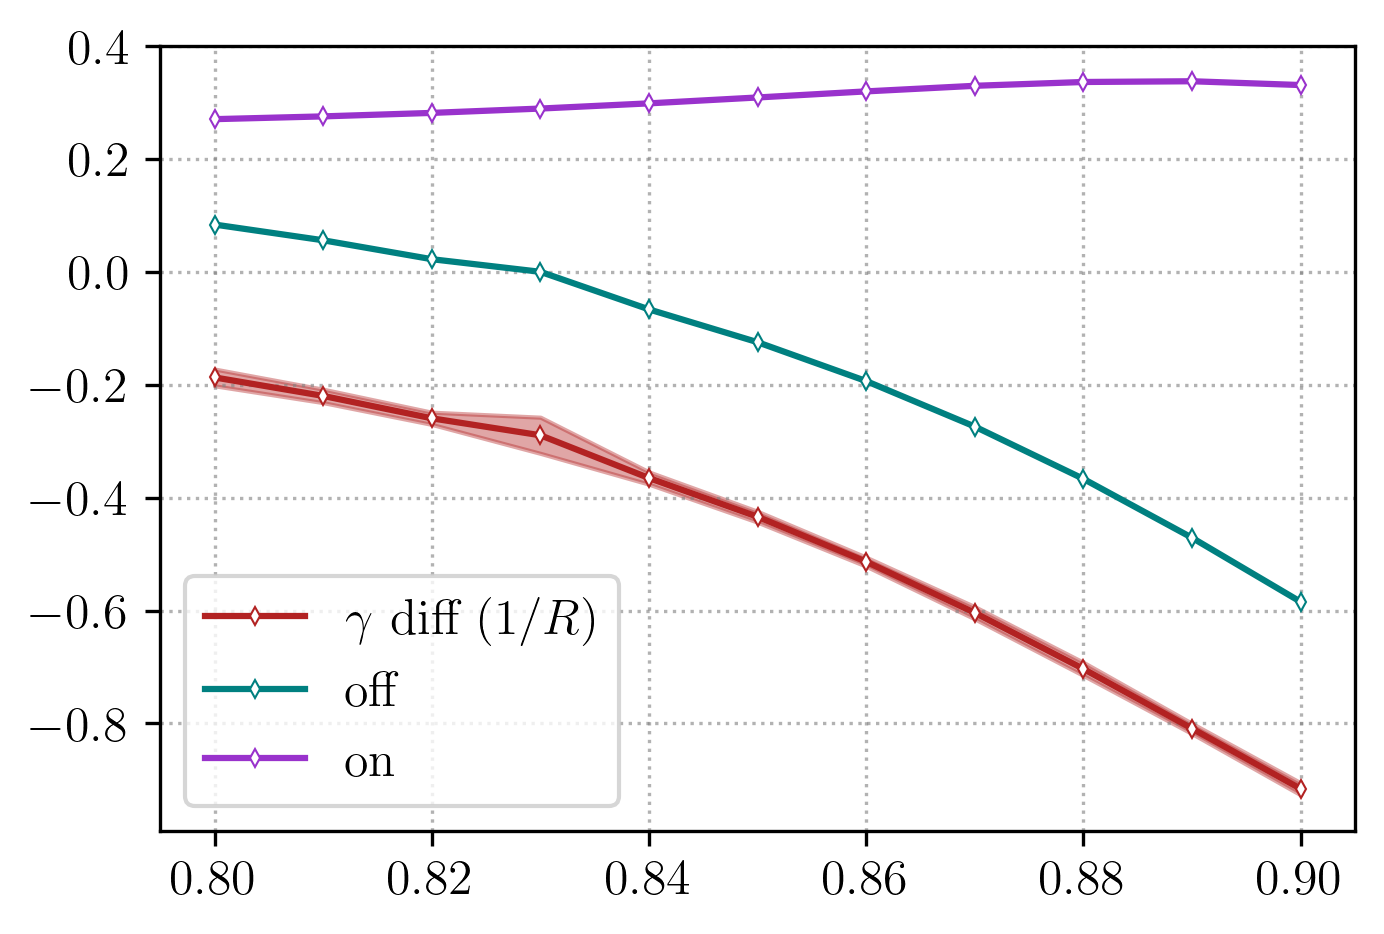

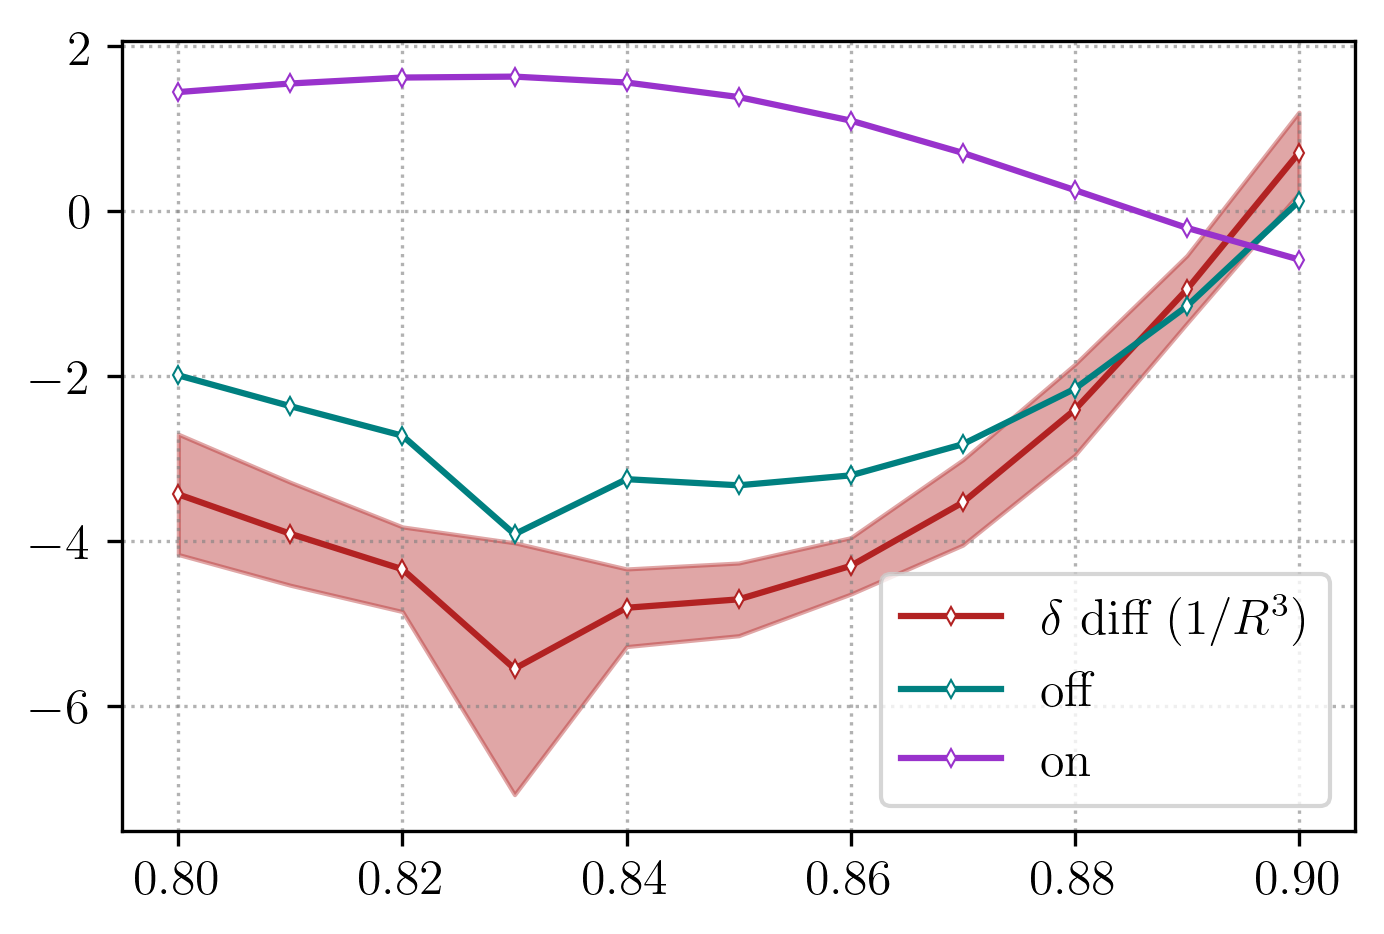

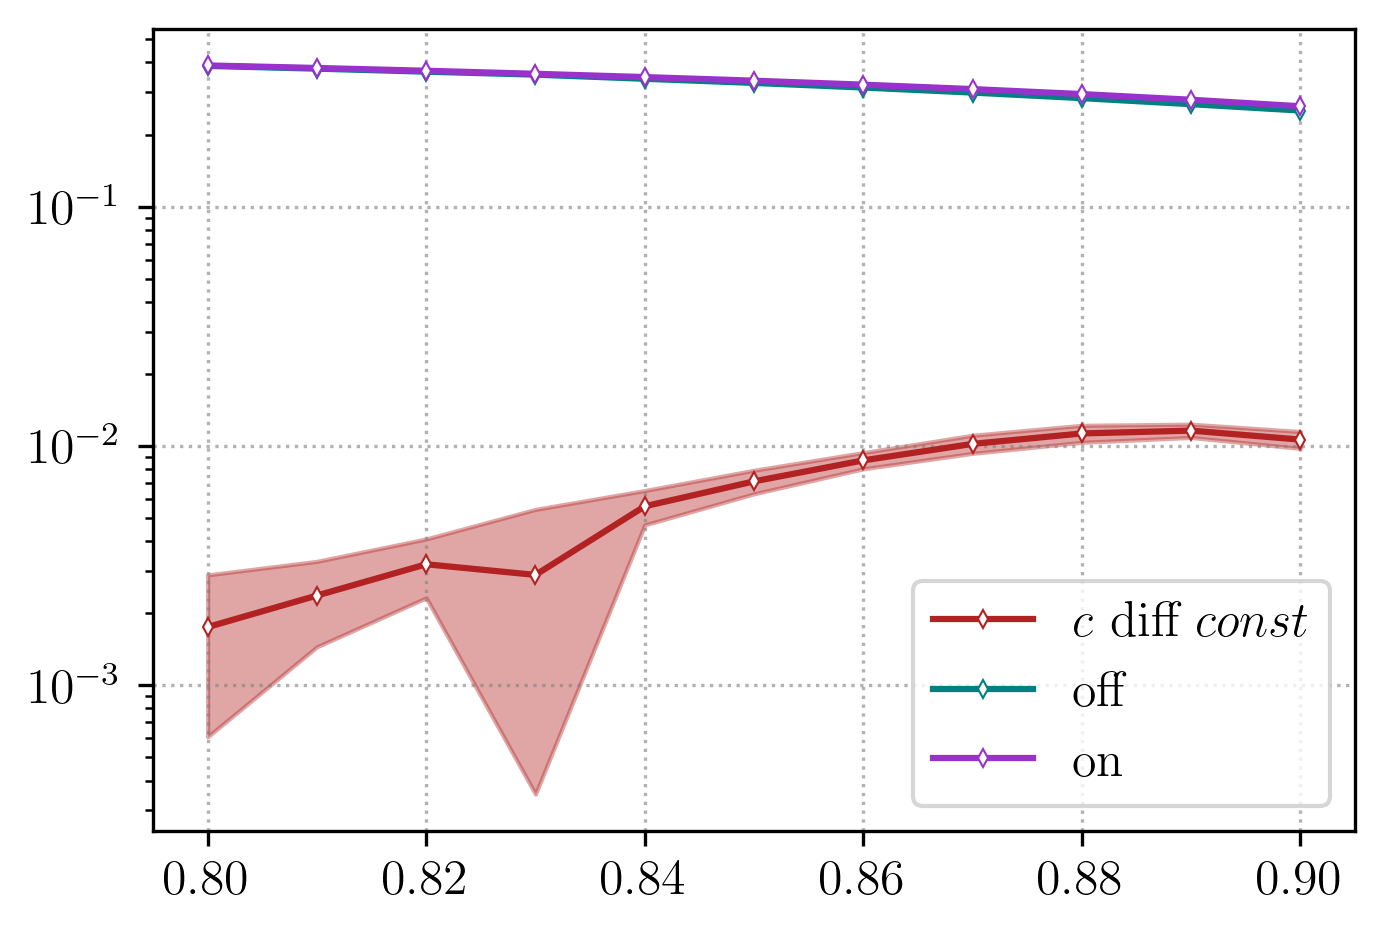

In [288]:
fit = 2

l = 6
euclidean = True
manhatten = False
sector = "2_particle(s)_sector"

h_i, h_f, npoints = 0.8, 0.90, 11
gs = np.linspace(h_i,h_f,npoints)
chis = [128,256]
Rss = [15,16,17,18,19,20]

# l = 5
# h_i, h_f, npoints = 0.8, 1.0, 41
# gs = np.linspace(h_i,h_f,npoints)
# chis = [64,128]
# Rss = [13,14,15,16,17,18,19,20]
param = 0

cx = None
print("\nsigma on 256\n")
sigmas_on, sigmas_on_err= fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, ris=False)
# Rss = [13,14,15,16,17,18,19,20]
print(sigmas_on_ris)
# Rss = [12,13,14,15,16,17,19]
Rss = [15,16,17,18,19,20]
print("\nsigma off 256\n")
cx = None
sigmas_off, sigmas_off_err= fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=False)

obs = np.array(sigmas_off) - np.array(sigmas_on)
obs_err = np.array(sigmas_off_err) + np.array(sigmas_on_err)

fig, ax = plt.subplots(figsize=(4.5, 3))
ax.grid(color="gray", linestyle=":", alpha=0.6)

ax.plot(gs[0:], obs[0:], markersize=3, color="firebrick", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$\\sigma$ diff $(R)$")
ax.plot(gs[0:], sigmas_off[0:], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"off")
ax.plot(gs[0:], sigmas_on[0:], markersize=3, color="darkorchid", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"on")
ax.set_yscale('log')
# ax.plot(gs[0:], obs[0:], markersize=3, color="firebrick", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$\\sigma_{{off}} - \\sigma_{{on}}$")
ax.fill_between(x=gs[0:], y1=obs[0:]-obs_err[0:], y2=obs[0:]+obs_err[0:], color="firebrick", alpha=0.4)
ax.legend()
fig.show()

param = 1

cx = None
print("\nsigma on 256\n")
sigmas_on, sigmas_on_err= fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, ris=False)
# Rss = [13,14,15,16,17,18,19,20]
print(sigmas_on_ris)
# Rss = [12,13,14,15,16,17,19]
Rss = [15,16,17,18,19,20]
print("\nsigma off 256\n")
cx = None
sigmas_off, sigmas_off_err= fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=False)

obs = np.array(sigmas_off) - np.array(sigmas_on)
obs_err = np.array(sigmas_off_err) + np.array(sigmas_on_err)

fig, ax = plt.subplots(figsize=(4.5, 3))
ax.grid(color="gray", linestyle=":", alpha=0.6)

ax.plot(gs[0:], obs[0:], markersize=3, color="firebrick", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$\\gamma$ diff $(1/R)$")
ax.plot(gs[0:], sigmas_off[0:], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"off")
ax.plot(gs[0:], sigmas_on[0:], markersize=3, color="darkorchid", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"on")
# ax.plot(gs[0:], obs[0:], markersize=3, color="firebrick", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$\\sigma_{{off}} - \\sigma_{{on}}$")
ax.fill_between(x=gs[0:], y1=obs[0:]-obs_err[0:], y2=obs[0:]+obs_err[0:], color="firebrick", alpha=0.4)
ax.legend()
fig.show()

param = 2

cx = None
print("\nsigma on 256\n")
sigmas_on, sigmas_on_err= fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, ris=False)
# Rss = [13,14,15,16,17,18,19,20]
print(sigmas_on_ris)
# Rss = [12,13,14,15,16,17,19]
Rss = [15,16,17,18,19,20]
print("\nsigma off 256\n")
cx = None
sigmas_off, sigmas_off_err= fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=False)

obs = np.array(sigmas_off) - np.array(sigmas_on)
obs_err = np.array(sigmas_off_err) + np.array(sigmas_on_err)

fig, ax = plt.subplots(figsize=(4.5, 3))
ax.grid(color="gray", linestyle=":", alpha=0.6)

ax.plot(gs[0:], obs[0:], markersize=3, color="firebrick", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$\\delta$ diff $(1/R^3)$")
ax.plot(gs[0:], sigmas_off[0:], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"off")
ax.plot(gs[0:], sigmas_on[0:], markersize=3, color="darkorchid", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"on")
# ax.plot(gs[0:], obs[0:], markersize=3, color="firebrick", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$\\sigma_{{off}} - \\sigma_{{on}}$")
ax.fill_between(x=gs[0:], y1=obs[0:]-obs_err[0:], y2=obs[0:]+obs_err[0:], color="firebrick", alpha=0.4)
ax.legend()
fig.show()

param = 3

cx = None
print("\nsigma on 256\n")
sigmas_on, sigmas_on_err= fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, ris=False)
# Rss = [13,14,15,16,17,18,19,20]
print(sigmas_on_ris)
# Rss = [12,13,14,15,16,17,19]
Rss = [15,16,17,18,19,20]
print("\nsigma off 256\n")
cx = None
sigmas_off, sigmas_off_err= fit_params_sys(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=False)

obs = abs(np.array(sigmas_off) - np.array(sigmas_on))
obs_err = abs(np.array(sigmas_off_err) + np.array(sigmas_on_err))

fig, ax = plt.subplots(figsize=(4.5, 3))
ax.grid(color="gray", linestyle=":", alpha=0.6)

ax.plot(gs[0:], obs[0:], markersize=3, color="firebrick", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$c$ diff $const$")
ax.plot(gs[0:], sigmas_off[0:], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"off")
ax.plot(gs[0:], sigmas_on[0:], markersize=3, color="darkorchid", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"on")
ax.set_yscale('log')
# ax.plot(gs[0:], obs[0:], markersize=3, color="firebrick", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$\\sigma_{{off}} - \\sigma_{{on}}$")
ax.fill_between(x=gs[0:], y1=obs[0:]-obs_err[0:], y2=obs[0:]+obs_err[0:], color="firebrick", alpha=0.4)
ax.legend()

### possible plot

In [35]:
def pot_diff_plots(ax, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, color=None, label=True):
    gs = np.linspace(h_i,h_f,npoints)
    cx = None
    cy = None
    Rs = [25,26,27,28,29,30]
    # Rs = [30,35,40,45,50]
    sigmas_on, sigmas_on_err, sigmas_on_ris, sigmas_on_ris_err, list_ris = fit_params_sys(Rs, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, ris=True)

    cx = None
    Rs = [25,26,27,28,29,30]
    # Rs = [30,35,40,45,50]
    sigmas_off, sigmas_off_err, sigmas_off_ris, sigmas_off_ris_err, list_ris = fit_params_sys(Rs, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=True)

    obs = np.array(sigmas_off) - np.array(sigmas_on)
    obs_err = np.array(sigmas_off_err) + np.array(sigmas_on_err)

    Rs = [25,26,27,28,29,30]
    # Rs = [30,35,40,45,50]
    if label:
        if param == 0:
            label="$\\sigma_{off} - \\sigma_{on}$"
        elif param == 1:
            label="$\\gamma_{off} - \\gamma_{on}$"
        elif param == -1:
            label="$\\beta_{off} - \\beta_{on}$"

    ax.plot(gs[0:], obs[0:], markersize=3, color=color, marker='d', fillstyle=None, mew=0.5, mfc='w', label=label)
    # ax.fill_between(x=gs[0:], y1=obs[0:]-obs_err[0:], y2=obs[0:]+obs_err[0:], color=color, alpha=0.4)

[25, 26, 27, 28, 29, 30]
[26, 27, 28, 29, 30]
Weighted Average: 0.9955394686300543
Error in the Average: 3.944513980622905e-05
Weighted Average: 1.0365174113646105
Error in the Average: 8.044608587345685e-05
Weighted Average: 1.0769684642691002
Error in the Average: 5.1286618829235755e-05
Weighted Average: 1.116895389012028
Error in the Average: 5.544859374847477e-05
Weighted Average: 1.1562999453957428
Error in the Average: 4.158022958437558e-05
Weighted Average: 1.1951834196380635
Error in the Average: 2.531501541233309e-05
Weighted Average: 1.2335476418613538
Error in the Average: 4.6480249775135154e-05
Weighted Average: 1.2713938261558984
Error in the Average: 1.9981786385978952e-05
Weighted Average: 1.3087211329032895
Error in the Average: 2.148237791182616e-05
Weighted Average: 1.3455298738425743
Error in the Average: 3.0335573046167525e-05
Weighted Average: 1.3818191694730773
Error in the Average: 5.5581063054790436e-05
Weighted Average: 1.4175817470480263
Error in the Average: 

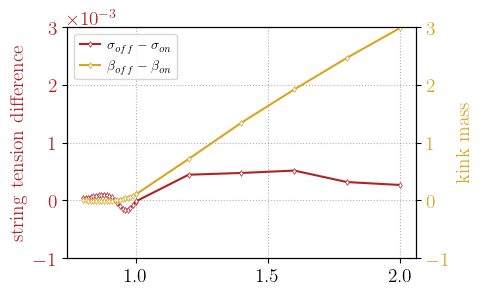

In [36]:
l = 5
L = 50
fit = 1

chis = [64,128]
Rs = [25,26,27,28,29,30]


# l = 4
# L = 70
# fit = 1

# chis = [64,96,128]
# Rs = [30,35,40,45,50]

euclidean = True
manhatten = False

fig, ax = plt.subplots(figsize=(4.5, 3))
ax.grid(color="gray", linestyle=":", alpha=0.6)

param = 0


# h_i, h_f, npoints = 0.6, 1.0, 9
# pot_diff_plots(ax, l, L, chis, bc, sector, h_i, h_f, npoints, path,  cx, cy, param, color='firebrick', fit=fit)

h_i, h_f, npoints = 0.8, 1.0, 21
pot_diff_plots(ax, l, L, chis, bc, sector, h_i, h_f, npoints, path,  cx, cy, param, color='firebrick', fit=fit)

h_i, h_f, npoints = 1.0, 2.0, 6
pot_diff_plots(ax, l, L, chis, bc, sector, h_i, h_f, npoints, path,  cx, cy, param, color='firebrick', fit=fit, label=None)

ax.set_ylabel('string tension difference', color='firebrick')
ax.tick_params(axis='y', labelcolor='firebrick')

# Force exponential notation on the x-axis
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 1))  # Force scientific notation outside this range
formatter.set_useOffset(False)

# Do the same for y-axis if desired
ax.yaxis.set_major_formatter(formatter)

ax.ticklabel_format(style='sci', axis='y')

# Create a second y-axis sharing the same x-axis
ax2 = ax.twinx()
ax2.set_ylabel('kink mass', color='goldenrod')
ax2.tick_params(axis='y', labelcolor='goldenrod')

param = -1

# h_i, h_f, npoints = 0.6, 1.0, 9
# pot_diff_plots(ax, l, L, chis, bc, sector, h_i, h_f, npoints, path,  cx, cy, param, color='firebrick', fit=fit)

h_i, h_f, npoints = 0.8, 1.0, 21
pot_diff_plots(ax2, l, L, chis, bc, sector, h_i, h_f, npoints, path,  cx, cy, param, color='goldenrod', fit=fit)

h_i, h_f, npoints = 1.0, 2.0, 6
pot_diff_plots(ax2, l, L, chis, bc, sector, h_i, h_f, npoints, path,  cx, cy, param, color='goldenrod', fit=fit, label=None)

ax2.set_ylim(bottom=-1,top=3)
ax.set_ylim(-1e-3,3e-3)

# ax2.set_ylim(bottom=-2e-2-1e-3-5e-4)
# ax.set_ylim(-2e-4,1e-3)

# Do the same for y-axis if desired
ax2.yaxis.set_major_formatter(formatter)

ax2.ticklabel_format(style='sci', axis='y')

handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Merge and show the legend only in ax1
ax.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

## Transverse evolution

In [116]:
def load_el_field_chis(l,L,R,bc,sector,model,h_i,h_ev,delta,steps,path,charges_y=None):
    ele_fields = []
    for chi in chis:
        try:
            elf = np.load(
                f"{path}/results/electric_field/electric_field_quench_dynamics_{model}_direct_lattice_{l}x{L}_{sector}_bc_{bc}_R_{R}_h_{h_i}-{h_ev}_delta_{delta}_trotter_steps_{steps}_chi_{chi}.npy")
        except:
            elf = np.load(
                f"{path}/results/electric_field/electric_field_quench_dynamics_{model}_direct_lattice_{l}x{L}_{sector}_bc_{bc}_R_{R}_off-{charges_y}_h_{h_i}-{h_ev}_delta_{delta}_trotter_steps_{steps}_chi_{chi}.npy")
        ele_fields.append(elf)
    return ele_fields

In [128]:
of = 0.2
R = 10
l = 5
steps = 400
delta = 0.01
h_i, h_ev = 0.75, 0.75
chis = [64,128]

# steps = 200
# delta = 0.05
# h_i, h_ev = 0.8, 0.8
# chis = [128]

elfs = load_el_field_chis(l,L,R,bc,sector,model,h_i,h_ev,delta,steps,path,charges_y=[0,0])
elf = elfs[-1]

[-2, -1, 0, 1, 2]


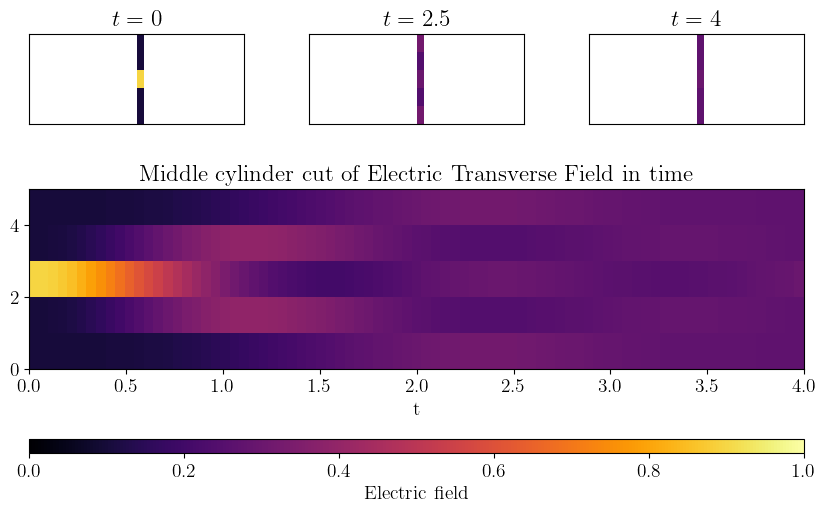

In [132]:
import matplotlib.gridspec as gridspec
import numpy as np

# Dummy data setup (replace with your actual data)
nx, ny = 30, 5  # grid size
times = [0, 2.5, 4]

arr = [*range(-(ny - 1)//2, ny//2 + 1)]
of = 0.2

if (ny%2) == 0:
    arr.pop(0)
print(arr)

data = [[(1-np.asarray(elf[int(t/delta*of)][0::2,1::2])[x])/2 for x in arr] for t in times]
cut_data = np.asarray([[(1-np.asarray(elf[i][0::2,2*(nx//2)+1])[x])/2 for x in arr] for i in range(int(steps*of)+1)]).T

# Create the figure and subplots
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1.5], hspace=0.1)

# Top row: 3 snapshots
gs_top = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[0], wspace=0.3)
for i, (t, d) in enumerate(zip(times, data)):
    ax = fig.add_subplot(gs_top[i])
    im = ax.imshow(d, aspect=2.5, origin='lower', cmap='inferno', vmin=0, vmax=1)
    # ax.axvline(nx // 2, color='green')  # vertical cut line
    ax.set_title(rf"$t = {t}$")
    ax.set_xticks([])
    ax.set_yticks([])

# Bottom plot: evolution of the middle slice
ax_bottom = fig.add_subplot(gs[1])
im2 = ax_bottom.imshow(cut_data, aspect='auto', origin='lower', vmin=0, vmax=1,
                       extent=[times[0], times[-1], 0, ny], cmap='inferno')
ax_bottom.set_title("Middle cylinder cut of Electric Transverse Field in time")
ax_bottom.set_xlabel("t")


divider = make_axes_locatable(ax_bottom)
cax = divider.append_axes("bottom", size="8%", pad=0.7)

cbar = fig.colorbar(im2, cax=cax, orientation='horizontal')
cbar.set_label("Electric field")
cbar.set_ticks(ticks=[0.0,0.2,0.4,0.6,0.8,1.0], labels=[0.0,0.2,0.4,0.6,0.8,1.0])
plt.show()


(5, 81)
(5, 41)
(5, 41)


/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_68466/2706196535.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.92, 1])  # leave space on the right for the colorbar


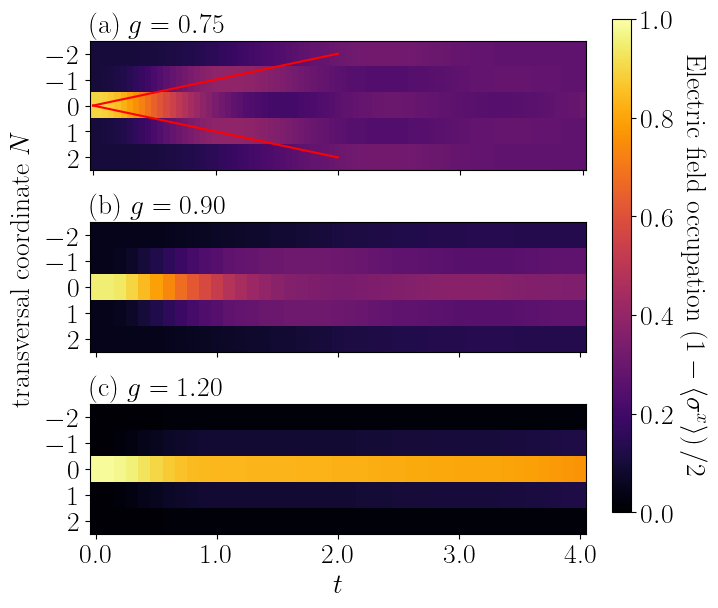

In [171]:
fig, axs = plt.subplots(3,1, figsize=(6.4,6.4), gridspec_kw={'hspace':0.4})

def velocity(xs,a,N):
    return np.array([a*x if a*x <= N//2 else np.nan for x in xs])
    
coupls = []
of = 0.2
R = 10
steps = 400
delta = 0.01
h_i = 0.75
coupls.append(his)
l = 5
chis = [128]

h_ev = h_i
elfs = load_el_field_chis(l,L,R,bc,sector,model,h_i,h_ev,delta,steps,path)
elf = elfs[-1]
cut_data = np.asarray([[(1-np.asarray(elf[i][0::2,2*(nx//2)+1])[x])/2 for x in arr] for i in range(int(steps*of)+1)]).T
print(cut_data.shape)
axs[0].imshow(cut_data, vmin=0, vmax=1, cmap='inferno', aspect='auto')

xs_t = delta*np.arange(int(steps+1))[::int(1/of)]
xs = np.arange(int(steps+1))[::int(1/of)]
axs[0].set_xticks(ticks=range(int(steps*of)+1)[::len(xs)//4], labels=['','','','',''], fontsize=20)
axs[0].set_yticks(ticks=[0,1,2,3,4], labels=[f"$-2$",f"$-1$",f"$0$",f"$1$",f"$2$"], fontsize=20)
axs[0].set_title(f"(a) $g = {h_i:.2f}$", loc='left', fontsize=20)
axs[0].plot(range(int(steps*of)+1), velocity(xs_t,1,N=l) + l//2, 'r')
axs[0].plot(range(int(steps*of)+1), - velocity(xs_t,1,N=l) + l//2, 'r')
# axs[0].vlines(40, 0, 4)


steps = 200
delta = 0.02
his = [0.9,1.2]
coupls.append(his)
i = 1
slopes = [0.9,0.3]
for h_i in his:
    h_ev = h_i
    elfs = load_el_field_chis(l,L,R,bc,sector,model,h_i,h_ev,delta,steps,path)
    elf = elfs[-1]
    cut_data = np.asarray([[(1-np.asarray(elf[i][0::2,2*(nx//2)+1])[x])/2 for x in arr] for i in range(int(steps*of)+1)]).T
    print(cut_data.shape)
    axs[i].imshow(cut_data, vmin=0, vmax=1, cmap='inferno', aspect='auto')
    
    xs_t = delta*np.arange(int(steps+1))[::int(1/of)]
    xs = np.arange(int(steps+1))[::int(1/of)]
    if i == 1:
        labels = ['','','','','']
        letter = 'b'
    else:
        labels = xs_t[::len(xs)//4]
        letter = 'c'
    axs[i].set_xticks(ticks=range(int(steps*of)+1)[::len(xs)//4], labels=labels, fontsize=20)
    axs[i].set_yticks(ticks=[0,1,2,3,4], labels=[f"$-2$",f"$-1$",f"$0$",f"$1$",f"$2$"], fontsize=20)
    axs[i].set_title(f"({letter}) $g = {h_i:.2f}$", loc='left', fontsize=20)
    # axs[i].plot(range(int(steps*of)+1), velocity(xs_t,slopes[i-1],N=l) + l//2, 'r')
    # axs[i].plot(range(int(steps*of)+1), - velocity(xs_t,slopes[i-1],N=l) + l//2, 'r')
    i += 1

axs[-1].set_xlabel(r'$t$', fontsize=20)

# fig.tight_layout()

fig.tight_layout(rect=[0, 0, 0.92, 1])  # leave space on the right for the colorbar
fig.text(0, 0.522, r"transversal coordinate $N$", va='center', rotation='vertical', fontsize=20)

# Create a new axis for the colorbar
cbar_ax = fig.add_axes([0.94, 0.143, 0.03, 0.771])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=20)
# cbar.set_label('Electric field occupation $(1 - \langle \\sigma_{(L/2,y)\\hat{1}}^x\\rangle)/2$', fontsize=20, labelpad=25, rotation=270)
cbar.set_label('Electric field occupation $\left(1 - \langle \\sigma^x\\rangle\\right)/2$', fontsize=20, labelpad=25, rotation=270)

fig.savefig(f"{path_figures}/figures/fluxtube/electric_field_cuts_in_time_{l}x{L}_R_{R}.pdf", bbox_inches="tight")

In [ ]:
xs = np.arange((int(steps*of)+1))
xs[::len(xs)//5]

array([ 0,  8, 16, 24, 32, 40])

In [ ]:
def velocity(xs,a,N):
    return [a*x if a*x < N else N for x in xs]

xs = np.linspace(0.1,2, 100)
velocity(xs,3,N=5)

[0.30000000000000004,
 0.3575757575757576,
 0.41515151515151516,
 0.4727272727272728,
 0.5303030303030303,
 0.5878787878787879,
 0.6454545454545455,
 0.703030303030303,
 0.7606060606060605,
 0.8181818181818181,
 0.8757575757575757,
 0.9333333333333333,
 0.990909090909091,
 1.0484848484848486,
 1.106060606060606,
 1.1636363636363636,
 1.2212121212121212,
 1.2787878787878788,
 1.3363636363636364,
 1.393939393939394,
 1.4515151515151516,
 1.5090909090909093,
 1.5666666666666664,
 1.624242424242424,
 1.6818181818181817,
 1.7393939393939393,
 1.7969696969696969,
 1.8545454545454545,
 1.9121212121212117,
 1.9696969696969693,
 2.027272727272727,
 2.0848484848484845,
 2.142424242424242,
 2.1999999999999997,
 2.2575757575757573,
 2.315151515151515,
 2.3727272727272726,
 2.4303030303030297,
 2.4878787878787874,
 2.545454545454545,
 2.6030303030303026,
 2.66060606060606,
 2.718181818181818,
 2.7757575757575754,
 2.833333333333333,
 2.8909090909090907,
 2.9484848484848483,
 3.006060606060606,
 3.0

## Plottone

In [67]:
marker_opts = dict(
    markeredgecolor='k',
    markeredgewidth=0.75,
    linestyle='',
)
markers = ["o","P","X","d","h"]
markersizes=[6,7,7,6,7]

theor_gc = 1 / np.sqrt(3.04438)

##################################################################
# A
##################################################################

def string_width_g_plot(ax):
    ax.grid(color="gray", linestyle=":")

    colors = ["#4688CE","#9B4DB7","#DC4563"]
    R_max = [20,20,20]
    h_i, h_f, npoints = 0.4, 1.0, 61
    gs = np.linspace(h_i, h_f, npoints)
    chis = [64,128]
    L = 30
    # L = 70
    # R_max = [50,50,50]

    # String width vs coupling
    i = 0
    xs_max = []
    for N in [4, 5, 6]:
        Rmax = R_max[i]
        # if N == 4:
        #     chis = [128,192]
        #     h_i, h_f, npoints = 0.6, 1.0, 21
        # elif N == 5:
        #     chis = [192,256]
        #     h_i, h_f, npoints = 0.7, 1.0, 16
        # elif N == 6:
        #     chis = [200,300]
        #     h_i, h_f, npoints = 0.7, 1.0, 16
        
        gs = np.linspace(h_i, h_f, npoints)
        string_width, _ = string_width_varying_g(gs, Rmax, N, L, chis, bc, sector, h_i, h_f, npoints, path, occupation=True)
        print(f"N = {N}, Rmax = {Rmax}")
        ax.plot(gs, string_width, color=colors[i], label=f"$N = {N}$", linewidth=2.5)
        # ax.plot(gs, -10*np.gradient(string_width), color=colors[i], linestyle='--', linewidth=1)
        idx_max = np.argmax(-np.gradient(string_width))
        xs_max.append(gs[idx_max])
        ax.text(gs[0]+0.02,string_width[0]+0.1, f"$\\bf{{N = {N}}}$", color=colors[i], fontsize=12)
        i += 1

    ax_inset = inset_axes(ax, width="38%", height="38%", loc='upper right', bbox_to_anchor=(-0.02, -0.02, 1, 1), bbox_transform=ax.transAxes)
    string_width_inset_plot(ax_inset)

    # ax.legend()
    # ax.set_xlabel(r"$g$", fontsize=14)
    ax.set_ylabel("string width $w^2$", fontsize=14)
    theor_gc = 1 / np.sqrt(3.04438)
    ax.vlines(theor_gc, 0.2, 3.5, 'grey', ':', linewidth=2)
    ax.set_ylim(top=3.5)
    ax.set_xticks(ticks=[0.4,0.6,0.8,1.0], labels=[0.4,0.6,0.8,1.0])
    ax.set_yticks(ticks=[1,2,3], labels=[1,2,3])
    # ax.text(0.4, 3.9, "$\\bf{(a)}$")
    ax.set_title("(a)", loc='left', fontsize=14)
    return xs_max

def string_width_inset_plot(ax):

    N, L = 6, 30
    chis = [64,128]
    h_i, h_f, npoints = 0.4, 1.0, 61
    Rs = [10,12,14,16,18,20]
    # N, L = 6, 70
    # chis = [200,300]
    # h_i, h_f, npoints = 0.7, 1.0, 16
    # Rs = [45,46,47,48,49,50]

    gs = np.linspace(h_i, h_f, npoints)
    colors = create_sequential_colors(len(Rs))
    
    # String width vs coupling
    i = 0
    for R in Rs:
        string_width, _ = string_width_varying_g(gs, R, N, L, chis, bc, sector, h_i, h_f, npoints, path, occupation=True)
        ax.plot(gs, string_width, color=colors[i], label=f"$R = {R}$", linewidth=1)
        i += 1

    # ax.legend()
    # x_arrow = 0.7
    # y_bottom = 1
    # y_top = 2.5
    # ax.annotate(
    #     '', xy=(x_arrow, y_top), xytext=(x_arrow, y_bottom),
    #     arrowprops=dict(arrowstyle='->', color='black', linewidth=1.5)
    # )

    # # Label next to the arrow
    # ax.text(
    #     x_arrow+0.02,(y_top + y_bottom) / 2 + 0.05,  # small x shift, mid y
    #     r'$R$', fontsize=16, va='center'
    # )
    # ax.set_title("string width $w^2$", pad=0, fontsize=10)
    # ax.set_xlim(0.6,0.8)
    # ax.set_ylim(0.8,3.2)
    ax.set_xlim(0.7,0.71)
    ax.set_ylim(1.92,2.1)
    ax.set_facecolor((1, 1, 1, 0.4))
    # ax.set_xticks(ticks=[0.4,0.6,0.8,1.0], labels=[0.4,0.6,0.8,1.0])
    # ax.set_yticks(ticks=[1,2,3], labels=[1,2,3])
    # ax.text(0.4, 3.9, "$\\bf{(a)}$")

##################################################################
# B
##################################################################

def string_width_R_plot(ax):
    ax.grid(color="gray", linestyle=":")

    colors = ["#F26430", "#009B72", "#009B90", "#009BA1", "#009DDC"]
    h_i, h_f, npoints = 0.4, 1.0, 61
    chis = [64,128]
    N, L = 6, 30

    h_i, h_f, npoints = 0.7, 1.0, 16
    chis = [200,300]
    N, L = 6, 70

    # String width vs separation R
    k = 0
    coupls = [0.4, 0.7, 0.75, 0.8, 1.0]
    coupls = [0.7, 0.76, 0.8, 1.0]
    Rs = [10,12,14,16,18,20]
    Rs = [45,46,47,48,49,50]

    def log_fit(R, a, b):
        return a*np.log(R) + b

    for g in coupls:
        string_width, string_width_err = string_width_varying_R(g, Rs, N, L, chis, bc, sector, h_i, h_f, npoints, path, occupation=True)
        ax.plot(Rs, string_width, color=colors[k], label=f"$g = {g}$", marker=markers[k], markersize=markersizes[k], **marker_opts)
        
        plog, clog = curve_fit(log_fit, Rs, string_width, sigma=string_width_err)
        x_fit = np.linspace(8,20)
        x_fit = np.linspace(43,52)
        ax.plot(x_fit, log_fit(x_fit,*plog), color=colors[k], linestyle=':', zorder=0)
        k += 1

    # ax.set_xlabel(r"$R$", fontsize=14)
    ax.set_yticks(ticks=[1,2,3], labels=[1,2,3])
    # ax.set_ylabel("string width $w^2$", fontsize=14)
    ax.legend(loc="center left", bbox_to_anchor=(0,0.68))
    ax.set_ylim(top=3.5)
    # ax.text(16, 0.4, f"$N = {N}$")
    # ax.text(8.1, 3.5, "$\\bf{(b)}$")
    ax.set_title("(b)", loc='left', fontsize=14)


##################################################################
# C
##################################################################

def ee_g_plot(ax):

    N, L = 6, 30
    N, L = 6, 70
    ax.grid(color="gray", linestyle=":")
    chi = 128
    chi = 300
    npoints, h_i, h_f = 31, 0.6, 0.9 
    npoints, h_i, h_f = 16, 0.7, 1.0 
    gs = np.linspace(h_i,h_f,npoints)
    Rs = [15,16,17,18,19,20]
    Rs = [45,46,47,48,49]
    colors = create_sequential_colors(len(Rs))
    for i, R in enumerate(Rs):
        s_pbc = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)
        ax.plot(gs,s_pbc, color=colors[i], linewidth=1.5, linestyle='-', label=f"$R={R}$", zorder=0)

    # npoints, h_i, h_f = 21, 0.4, 0.6 
    # gs = np.linspace(h_i,h_f,npoints)
    # for i, R in enumerate(Rs):
    #     s_pbc = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)
    #     ax.plot(gs,s_pbc, color=colors[i], linewidth=1.5, linestyle='-', zorder=0)

    # npoints, h_i, h_f = 11, 0.9, 1.0 
    # gs = np.linspace(h_i,h_f,npoints)
    # for i, R in enumerate(Rs):
    #     s_pbc = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)
    #     ax.plot(gs,s_pbc, color=colors[i], linewidth=1.5, linestyle='-', zorder=0)

    # colors = ["#F26430", "#009B72", "#009B90", "#009BA1", "#009DDC"]
    # ranges = [(0.00,0.25),(0.50,0.75),(0.48,0.73),(0.45,0.70),(0.10,0.35)]
    # coupls = [0.4,0.7,0.75,0.8,1.0]
    # for i in range(len(coupls)):
    #     ax.vlines(coupls[i], ranges[i][0], ranges[i][1], linestyle='-', color=colors[i], alpha=0.7, linewidth=2)


    ax_inset = inset_axes(ax, width="50%", height="40%", loc='lower right', bbox_to_anchor=(-0.05, 0.08, 1, 1.15), bbox_transform=ax.transAxes)
    inset_ee_g_N_plot(ax_inset)

    # Add the legend to the main plot instead
    ax.set_xlabel(r"$g$", fontsize=14)
    ax.set_ylabel("entanglement entropy $S$", fontsize=14)
    # ax.text(0.85, 0.7, f"$N = {N}$")
    ax.legend(loc='upper left', handlelength=0.8)
    ax.set_ylim(bottom=0.08)
    # ax.text(0.4, 0.97, "$\\bf{(e)}$")
    ax.vlines(theor_gc, 0.1, 0.88, 'grey', ':', linewidth=2)
    ax.set_title("(c)", loc='left', fontsize=14)
    ax.set_yticks(ticks=[0.2,0.4,0.6,0.8], labels=[0.2,0.4,0.6,0.8])

def inset_ee_g_N_plot(ax):
    # ax.grid(color="gray", linestyle=":")
    colors = ["#4688CE","#9B4DB7","#DC4563"]
    R_max = [20,20,20]
    L = 30
    chi = 128
    theor_gc = 1 / np.sqrt(3.04438)

    # String width vs coupling
    i = 0
    coords = [(0.73,0.73),(0.7,0.79),(0.65,0.84)]
    for N in [4, 5, 6]:
        Rmax = R_max[i]
        if N == 6:
            h_i,h_f,npoints=0.4,0.6,21
            s_pbc1 = entropy(Rmax,N,L,chi,bc,sector,h_i,h_f,npoints,path)

            h_i,h_f,npoints=0.6,0.9,31
            s_pbc2 = entropy(Rmax,N,L,chi,bc,sector,h_i,h_f,npoints,path)

            h_i,h_f,npoints=0.9,1.0,11
            s_pbc3 = entropy(Rmax,N,L,chi,bc,sector,h_i,h_f,npoints,path)

            gs = np.linspace(0.4,0.6,21).tolist() + np.linspace(0.6,0.9,31)[1:].tolist() + np.linspace(0.9,1.0,11)[1:].tolist()
            s_pbc = s_pbc1 + s_pbc2[1:] + s_pbc3[1:]
        else:
            h_i, h_f, npoints = 0.4, 1.0, 61
            gs = np.linspace(h_i,h_f,npoints)
            s_pbc = entropy(Rmax,N,L,chi,bc,sector,h_i,h_f,npoints,path)
        # axs[0].plot(gs,s_pbc, color=colors[i], linewidth=2, markersize=5, linestyle='-', label=f"$N: {N}, \chi: {chi}$")
        ax.plot(gs, s_pbc, color=colors[i], linewidth=2)
        ax.text(coords[i][0],coords[i][1], f"$\\bf{{N = {N}}}$", color=colors[i], fontsize=12)
        i += 1
    
    # ax.legend(loc="upper right", fontsize=9)
    ax.tick_params(labelsize=13)
    ax.set_xlim(0.53, 0.93)
    # ax.set_ylim(0.6, 0.9)
    ax.set_facecolor((1, 1, 1, 0.4))


##################################################################
# D
##################################################################

def log_fit(R, a, b):
    return a*np.log(R) + b

def cft_entr(R, a, b):
    return a*np.log2(R) + b

def ee_R_plot(ax):
    ax.grid(color="gray", linestyle=":")
    colors = ["#F26430", "#009B72", "#009B90", "#009BA1", "#009DDC"]

    # String width vs separation R
    k = 0
    # N, L = 6, 70
    # chis = [200,300]
    # coupls = [0.7, 0.76, 0.8, 1.0]
    # idxs = [0,3,6,15]
    # his = [0.7]*5
    # hfs = [1.0]*5
    # npointss = [16,16,16,16,16]
    # Rs = [45,46,47,48,49,50]

    N, L = 6, 30
    chis = [64,128]
    coupls = [0.4, 0.7, 0.75, 0.8, 1.0]
    idxs = [0, 10, 15, 20, 10]
    his = [0.4,0.6,0.6,0.6,0.9]
    hfs = [0.6,0.9,0.9,0.9,1.0]
    npointss = [21,31,31,31,11]
    Rs = [10,12,14,16,18,20]

    for g, h_i, h_f, npoints, idx in zip(coupls, his, hfs, npointss, idxs):

        entrs_g_max = [entropy(R,N,L,chis[-1],bc,sector,h_i,h_f,npoints,path)[idx] for R in Rs]
        entrs_g_min = [entropy(R,N,L,chis[-2],bc,sector,h_i,h_f,npoints,path)[idx] for R in Rs]
        entrs_g = entrs_g_max.copy()
        entrs_g_err = [np.abs(entrs_g_max[i] - entrs_g_min[i]) for i in range(len(Rs))]
        ax.plot(Rs, entrs_g, color=colors[k], label=f"$g = {g}$", marker=markers[k], markersize=markersizes[k], **marker_opts)
        print(g, entrs_g)

        plog, clog = curve_fit(log_fit, Rs, entrs_g, sigma=entrs_g_err)
        x_fit = np.linspace(8,20)
        x_fit = np.linspace(43,52)
        ax.plot(x_fit, log_fit(x_fit,*plog), color=colors[k], linestyle=':', zorder=0)
        # ax.text(8, 0.6-0.05*k, f"$c = {plog[0]*6} \\pm {np.sqrt(np.diag(clog))[0]}$", color=colors[k])
        k += 1
        
    # ax_inset = inset_axes(ax, width="50%", height="23%", loc='upper left', bbox_to_anchor=(0.15, 0.04, 0.86, 0.9), bbox_transform=ax.transAxes)
    ax_inset = inset_axes(ax, width="50%", height="23%", loc='center left', bbox_to_anchor=(0.15, 0.04, 0.86, 0.9), bbox_transform=ax.transAxes)
    inset_central_charge_plot(ax_inset)

    ax.set_xlabel(r"$R$", fontsize=14)
    # ax.set_ylabel("entanglement entropy $S$", fontsize=14)
    # ax.text(11, 0.62, f"$N = {N}$")
    # ax.legend(loc="lower left")
    # ax.text(8.1, 0.74, "$\\bf{(f)}$")
    # ax.set_ylim(0.15, 0.85)
    ax.set_yticks(ticks=[0.2,0.4,0.6,0.8], labels=[0.2,0.4,0.6,0.8])
    ax.set_title("(d)", loc='left', fontsize=14)

def central_charge_plot(Rs, l, chi, L, bc, sector, h_i, h_f, npoints, path_tensor):
    cc = []
    cc_err = []
    entr_g = []
    x_data = Rs
    gs = np.linspace(h_i,h_f,npoints)

    for i, R in enumerate(Rs):
        s = entropy(R,l,L,chi,bc,sector,h_i,h_f,npoints,path_tensor)
        entr_g.append(s)

    entr_g = np.array(entr_g).T
    for i, g in enumerate(gs):
        y_data = entr_g[i]

        popt, copt = curve_fit(cft_entr, x_data, y_data)
        err = np.sqrt(np.diag(copt))
        cc.append(popt[0]*6)
        cc_err.append(err[0]*6)

    return cc, cc_err

def inset_central_charge_plot(ax):
    # N, L = 6, 70
    # npoints, h_i, h_f = 16, 0.7, 1.0
    # chi = 300
    # Rs = [45,46,47,48,49]
    
    N, L = 6, 30
    npoints, h_i, h_f = 15, 0.6, 0.95
    gs = np.linspace(h_i,h_f,npoints)
    chi = 256
    Rs = [14,15,16,17,19]

    cc, cc_err = central_charge_plot(Rs, N, chi, L, bc, sector, h_i, h_f, npoints, path)
    ax.plot(gs, cc, marker='o', markersize=4, color="#DC4563", markeredgecolor='k', label=f"$N = {N}$")
    ax.fill_between(x=gs, y1=np.asarray(cc)+np.asarray(cc_err), y2=np.asarray(cc)-np.asarray(cc_err), color=colors[2], alpha=0.4)
    ax.hlines(y=1, xmin=gs[0], xmax=gs[-1], color="k", linestyles="--", linewidths=1, label="$c=1$")
    ax.hlines(y=2, xmin=gs[0], xmax=gs[-1], color="k", linestyles="-.", linewidths=1, label="$c=2$")
    # ax.legend(fontsize=9)   
    # ax.set_xlabel(r"$g$", labelpad=0, fontsize=13)
    ax.set_title("central charge vs. $g$", pad=0, fontsize=13)
    # ax.set_ylim(0.75,1.4)
    # ax.set_yticks(ticks=[0.8,1.0,1.2], labels=[0.8,1.0,1.2])
    ax.tick_params(labelsize=13)
    ax.set_facecolor((1, 1, 1, 0.6))

[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0

FileNotFoundError: [Errno 2] No such file or directory: '/Users/fradm/Desktop/projects/1_Z2/results/electric_field/electric_field_Z2_dual_direct_lattice_6x30_2_particle(s)_sector_bc_pbc_[6, 24]-[0, 0]_h_0.4-1.0_delta_61_chi_128.npy'

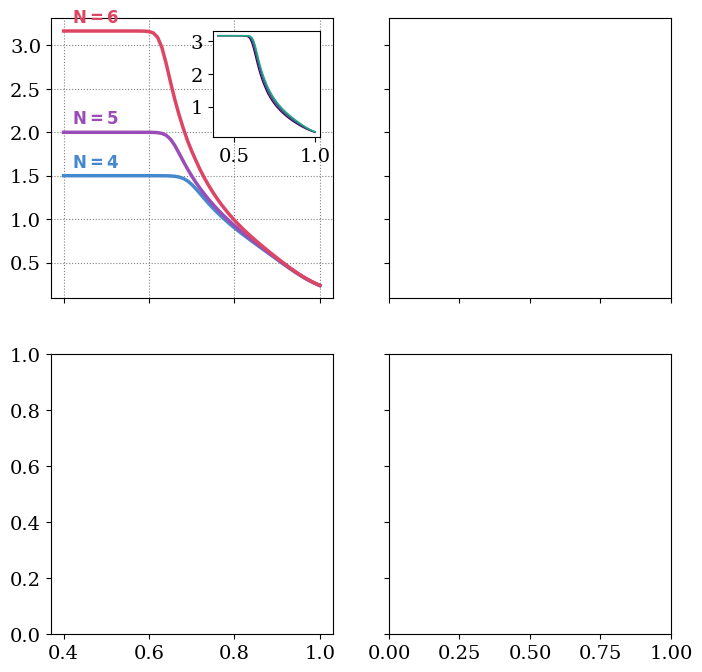

In [68]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), gridspec_kw={'wspace':0.2, 'hspace':0.2}, sharex='col', sharey='row')

for i, ax in enumerate(axs):
    if i == 0:
        xs_max = string_width_g_plot(ax[0])
        string_width_R_plot(ax[1])
    elif i == 1:
        ee_g_plot(ax[0])
        ee_R_plot(ax[1])

fig.align_ylabels(axs)
fig.savefig(f"{path_figures}/figures/fluxtube/w_and_ee_static_share_axis.pdf", bbox_inches='tight', format='pdf')

In [61]:
##################################################################
# Left
##################################################################

def string_tension_g_plot(ax):
    ax.grid(color="gray", linestyle=":")

    colors = ["#4688CE","#9B4DB7","#DC4563"]
    h_i, h_f, npoints = 0.4, 1.0, 61
    chis = [64,128]
    Rss = [15,16,17,18,19,20]
    N, L = 6, 30
    # h_i, h_f, npoints = 0.7, 1.0, 16
    # chis = [200,300]
    # Rss = [45,46,47,48,49,50]
    # N, L = 6, 70
    
    gs = np.linspace(h_i, h_f, npoints)
    
    # String width vs coupling
    i = 2
    string_tension, string_tension_err = fit_params_sys(Rss, N, L, chis, bc, sector, h_i, h_f, npoints, path, cx=None, cy=None, param=0, fit=1)
    ax.plot(gs, string_tension, color=colors[i], linewidth=2.5)
    # ax.scatter(gs[::4], string_tension[::4], marker='s', s=50, color=colors[i], edgecolor='k', label=f"$N = {N}$", linewidth=0.5)
    ax.fill_between(gs, y1=np.asarray(string_tension) - np.asarray(string_tension_err), y2=np.asarray(string_tension) + np.asarray(string_tension_err), color=colors[i], alpha=0.4)
    ax.set_xlabel(r"$g$")
    ax.set_ylabel("string tension $\\sigma$")
    theor_gc = 1 / np.sqrt(3.04438)
    # ax.vlines(theor_gc, 0, 1.5, 'grey', ':', linewidth=2)
    # ax.text(0.4, 1.92, "$\\bf{(c)}$")
    # Inset plot (small plot inside the main one)
    ax_inset = inset_axes(ax, width="40%", height="45%", loc='upper left', bbox_to_anchor=(0.087, -0.1, 1, 1.1), bbox_transform=ax.transAxes)
    inset_plot_strong_couping(ax_inset)
    # Inset content — for example, a slice of the data
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax_inset.get_legend_handles_labels()

    # Merge and show the legend only in ax1
    ax.legend(handles1 + handles2, labels1 + labels2, loc='lower right')
    ax.set_xticks(ticks=[0.4,0.6,0.8,1.0], labels=[0.4,0.6,0.8,1.0])
    ax.set_yticks(ticks=[0,0.5,1,1.5], labels=[0.,0.5,1,1.5])
    ax.set_title("(a)", loc='left', fontsize=14)

# Plot right range (4–5)
def inset_plot_strong_couping(ax):
    h_i, h_f, npoints = 0.4, 5.0, 33
    gs = np.linspace(h_i,h_f,npoints)
    chis = [128]
    Rss = [14,16,18,20]
    # Rss = [15,16,17,18,19,20]
    colors = ["#4688CE","#9B4DB7","#DC4563"]
    N, L = 6, 30
    
    string_tension, string_tension_err = fit_params_sys(Rss, N, L, chis, bc, sector, h_i, h_f, npoints, path, cx=None, cy=None, param=0, fit=1)
    ax.scatter(gs[4::2], string_tension[4::2], marker='o', s=25, color=colors[-1], edgecolor='k', label=f"$N = {N}$", linewidth=0.5)
    ax.plot(gs, 2*gs, linestyle='-', color='k', linewidth=1.5, label='$\\sigma = 2g$', zorder=0)
    # ax.plot(gs, 2*gs, linestyle=(0, (1.5,1.5)), color='k', linewidth=2, label='$2g$ limit', zorder=0)
    # ax.fill_between(gs, y1=np.asarray(string_tension) - np.asarray(string_tension_err), y2=np.asarray(string_tension) + np.asarray(string_tension_err), color=colors[i], alpha=0.4)
    ax.set_xlim(0.8, 4.1)
    ax.set_ylim(1, 8.5)
    # ax.grid(color="gray", linestyle=":")
    ax.set_xlabel(r'$g$', labelpad=0, fontsize=10)
    ax.set_xticks(ticks=[1,2,3,4], labels=[1,2,3,4])
    ax.set_yticks(ticks=[2,4,6,8], labels=[2,4,6,8])
    ax.tick_params(labelsize=10)
    ax.set_facecolor((1, 1, 1, 0.6))


##################################################################
# Center
##################################################################

def luscher_g_plot(ax, xs_max=None):
    ax.grid(color="gray", linestyle=":")

    colors = ["#4688CE","#9B4DB7","#DC4563"]
    h_i, h_f, npoints = 0.6, 0.9, 31
    chis = [32,64,128,256]
    L = 30
    # h_i, h_f, npoints = 0.7, 1.0, 16
    # chis = [200,300]
    # L = 70
    fit = 1
    
    gs = np.linspace(h_i,h_f,npoints)

    # String width vs coupling
    for i, N in enumerate([5]):
        print(f"\nN: {N}\n")
        if N == 4:
            Rs = [6,7,8,9,10,11,12,14,16,18,20,22]
            # Rs = [45,46,47,48,49,50]
            # h_i, h_f, npoints = 0.6, 1.0, 21
            # chis = [128,192]
        elif N == 5:
            Rs = [6,7,8,9,10,11,13,15,17,19,21]
            # Rs = [45,46,47,48,49,50]
            # h_i, h_f, npoints = 0.7, 1.0, 16
            # chis = [192,256]
        elif N == 6:
            Rs = [6,7,8,9,10,11,13,15,17,19,21]
            # Rs = [45,46,47,48,49,50]
            # h_i, h_f, npoints = 0.7, 1.0, 16
            # chis = [200,300]

        gs = np.linspace(h_i,h_f,npoints)
        idx = np.argmin(np.abs(gs - xs_max[i]))
        # idx = 0
        luscher_term, luscher_term_err = fit_params_sys(Rs, N, L, chis, bc, sector, h_i, h_f, npoints, path, cx=None, cy=None, param=1, fit=fit)
        ax.plot(gs[idx:], -np.asarray(luscher_term)[idx:], color=colors[i], label=f"$N = {N}$", linewidth=2.5)
        ax.fill_between(gs[idx:], y1=-np.asarray(luscher_term)[idx:] - np.asarray(luscher_term_err)[idx:], y2=-np.asarray(luscher_term)[idx:] + np.asarray(luscher_term_err)[idx:], color=colors[i], alpha=0.4)
    
    # h_i, h_f, npoints = 0.6, 0.95, 15
    # gs = np.linspace(h_i,h_f,npoints)
    # chis = [32,64,128,256]
    # Rs = [6,7,8,9,10,11,12,13,14,15,16,17,19,21]
    # N = 6
    # i += 1

    # idx = np.argmin(np.abs(gs - xs_max[i]))
    # luscher_term, luscher_term_err = fit_params_sys(Rs, N, L, chis, bc, sector, h_i, h_f, npoints, path, cx=None, cy=None, param=1, fit=fit)
    # ax.plot(gs[idx:], -np.asarray(luscher_term)[idx:], color=colors[i], label=f"$N = {N}$", linewidth=2.5)
    # ax.fill_between(gs[idx:], y1=-np.asarray(luscher_term)[idx:] - np.asarray(luscher_term_err)[idx:], y2=-np.asarray(luscher_term)[idx:] + np.asarray(luscher_term_err)[idx:], color=colors[i], alpha=0.4)
    ax.hlines(-np.pi/12, xmin=gs[0], xmax=gs[-1], linewidth=2, linestyle='--', color='k', label="$-\\pi/12$")

    ax.legend(loc="lower right")
    ax.set_xlabel(r"$g$")
    ax.set_ylabel("Lüscher term $\\gamma$")
    ax.set_ylim((-0.65,0))
    ax.set_xlim(0.64,0.96)
    ax.set_yticks(ticks=[0,-0.2,-0.4,-0.6], labels=["0","$-0.2$","$-0.4$","$-0.6$"])
    ax.text(0.67, -0.1, "$V = \\sigma R + \\beta + \\frac{\\gamma}{R} + O(R^{-3})$", fontsize=11)
    # ax.text(0.6, 0.03, "$\\bf{(d)}$")
    ax.set_title("(b)", loc='left', fontsize=14)
    

##################################################################
# Right
##################################################################

def pot_diff_plots(l, L, chis, bc, sector, h_i, h_f, npoints, path, param, fit):
    euclidean = True
    manhatten = False
    
    cx = None
    cy = None
    Rs = [25,26,27,28,29,30]
    sigmas_on, sigmas_on_err, sigmas_on_ris, sigmas_on_ris_err, list_ris = fit_params_sys(Rs, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, ris=True)

    cx = None
    cy = None
    Rs = [25,26,27,28,29,30]
    sigmas_off, sigmas_off_err, sigmas_off_ris, sigmas_off_ris_err, list_ris = fit_params_sys(Rs, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=True)

    obs = np.array(sigmas_off) - np.array(sigmas_on)
    obs_err = np.array(sigmas_off_err) + np.array(sigmas_on_err)

    return obs, obs_err

def rri_plot(ax):
    ax.grid(color="gray", linestyle=":")
    ax.patch.set_facecolor('none')
    
    colors = ["#ff0f7b", "#f89b29"]
    colors = ["#4A8FE7", "#D95D39"]
    colors = ["firebrick", "teal"]

    l = 5
    L = 50
    fit = 1

    left_axis_limits = (-0.5e-3,1.5e-3)
    right_axis_limits = (-0.5,1.5)

    chis = [64,128]


    param = 0

    if param == 0:
        label='$\\sigma_{\\mathrm{off}} - \\sigma_{\\mathrm{on}}$'
    elif param == 1:
        label="$\\gamma_{\\mathrm{off}} - \\gamma_{\\mathrm{on}}$"
    elif param == -1:
        label="$\\beta_{\\mathrm{off}} - \\beta_{\\mathrm{on}}$"
    
    rescale = 1
    h_i, h_f, npoints = 0.8, 1.0, 21
    gs = np.linspace(h_i,h_f,npoints)
    obs, obs_err = pot_diff_plots(l, L, chis, bc, sector, h_i, h_f, npoints, path, param, fit=fit)
    ax.plot(gs[0:], rescale*obs[0:], markersize=5, color=colors[0], marker='d', fillstyle=None, mew=0.5, mfc='w', label=label, zorder=3)
    ax.fill_between(x=gs[0:], y1=rescale*(obs[0:]-obs_err[0:]), y2=rescale*(obs[0:]+obs_err[0:]), color=colors[0], alpha=0.4, zorder=2)

    h_i, h_f, npoints = 1.0, 2.0, 6
    gs = np.linspace(h_i,h_f,npoints)
    label = None
    obs, obs_err = pot_diff_plots(l, L, chis, bc, sector, h_i, h_f, npoints, path, param, fit=fit)
    ax.plot(gs[0:], rescale*obs[0:], markersize=5, color=colors[0], marker='d', fillstyle=None, mew=0.5, mfc='w', label=label, zorder=3)
    ax.fill_between(x=gs[0:], y1=rescale*(obs[0:]-obs_err[0:]), y2=rescale*(obs[0:]+obs_err[0:]), color=colors[0], alpha=0.4, zorder=2)
    
    # Create a second y-axis sharing the same x-axis
    ax2 = ax.twinx()

    ax2.set_zorder(ax.get_zorder() - 1)
    # ax2.patch.set_visible(False)

    param = -1

    if param == 0:
        label=r'$\sigma{\mathrm{off}} - \sigma{\mathrm{on}}$'
    elif param == 1:
        label=r"$\\gamma_{\\mathrm{off}} - \\gamma_{\\mathrm{on}}$"
    elif param == -1:
        label='$\\beta_{\\mathrm{off}} - \\beta_{\\mathrm{on}}$'
    
    h_i, h_f, npoints = 0.8, 1.0, 21
    gs = np.linspace(h_i,h_f,npoints)
    obs, obs_err = pot_diff_plots(l, L, chis, bc, sector, h_i, h_f, npoints, path, param, fit=fit)
    ax2.plot(gs[0:], obs[0:], markersize=7, color=colors[1], marker='P', fillstyle=None, mew=0.5, mfc='w', label=label, zorder=1)
    ax2.fill_between(x=gs[0:], y1=obs[0:]-obs_err[0:], y2=obs[0:]+obs_err[0:], color=colors[1], alpha=0.4, zorder=0)

    h_i, h_f, npoints = 1.0, 2.0, 6
    gs = np.linspace(h_i,h_f,npoints)
    label = None
    obs, obs_err = pot_diff_plots(l, L, chis, bc, sector, h_i, h_f, npoints, path, param, fit=fit)
    ax2.plot(gs[0:], obs[0:], markersize=7, color=colors[1], marker='P', fillstyle=None, mew=0.5, mfc='w', label=label, zorder=1)
    ax2.fill_between(x=gs[0:], y1=obs[0:]-obs_err[0:], y2=obs[0:]+obs_err[0:], color=colors[1], alpha=0.4, zorder=0)


    # Force exponential notation on the x-axis
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))  # Force scientific notation outside this range
    formatter.set_useOffset(False)

    ax.yaxis.set_major_formatter(formatter)
    ax.ticklabel_format(style='sci', axis='y')
    ax.set_ylabel("$\\sigma_{\\mathrm{off}} - \\sigma_{\\mathrm{on}}$", color=colors[0])
    ax.tick_params(axis='y', labelcolor=colors[0])

    ax2.yaxis.set_major_formatter(formatter)
    ax2.ticklabel_format(style='sci', axis='y')
    ax2.set_ylabel("$\\beta_{\\mathrm{off}} - \\beta_{\\mathrm{on}}$", color=colors[1])
    ax2.tick_params(axis='y', labelcolor=colors[1])

    ax2.set_ylim((right_axis_limits[0], right_axis_limits[1]+right_axis_limits[1]*0.05))
    ax.set_ylim((left_axis_limits[0], left_axis_limits[1]+left_axis_limits[1]*0.05))
    ax.set_xlim(right=1.5)
    ax2.set_xlim(right=1.5)
    ax.set_yticks(ticks=np.linspace(left_axis_limits[0],left_axis_limits[1],5), labels=["$-0.0005$","0","$0.0005$","$0.0010$","$0.0015$"])
    ax.set_xticks(ticks=[0.8,1.0,1.2,1.4], labels=[0.8,1.0,1.2,1.4])
    ax2.set_yticks(ticks=np.linspace(right_axis_limits[0],right_axis_limits[1],5), labels=["$-0.5$","0","$0.5$","$1$","$1.5$"])


    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    # Merge and show the legend only in ax1
    ax.legend(handles1 + handles2, labels1 + labels2, loc='upper left')
    ax.set_xlabel(r"$g$")
    ax.set_title("(c)", loc='left', fontsize=14)


[15, 16, 17, 18, 19, 20]
[16, 17, 18, 19, 20]
Weighted Average: 4.054988284183002e-05
Error in the Average: 9.695762471442201e-09
Weighted Average: 5.685989907996528e-05
Error in the Average: 2.5010268239247414e-08
Weighted Average: 7.959343860068689e-05
Error in the Average: 4.540798326024454e-08
Weighted Average: 0.00011128629572172923
Error in the Average: 1.294069704233196e-07
Weighted Average: 0.0001555455104074349
Error in the Average: 1.714306456895376e-07
Weighted Average: 0.00021754111771349357
Error in the Average: 4.011648476236347e-07
Weighted Average: 0.0003047784666147419
Error in the Average: 8.727909978168933e-07
Weighted Average: 0.00042830414070421327
Error in the Average: 1.8819635227482087e-06
Weighted Average: 0.0006046433327771909
Error in the Average: 4.062260763455881e-06
Weighted Average: 0.0008601558939291754
Error in the Average: 8.561929268622724e-06
Weighted Average: 0.0012362981272867244
Error in the Average: 1.7278587134192677e-05
Weighted Average: 0.0018

FileNotFoundError: [Errno 2] No such file or directory: '/Users/fradm/Desktop/projects/1_Z2/results/energy_data/energy_Z2_dual_direct_lattice_6x30_2_particle(s)_sector_bc_pbc_[8, 22]-[0, 0]_h_0.4-5.0_delta_33_chi_128.npy'

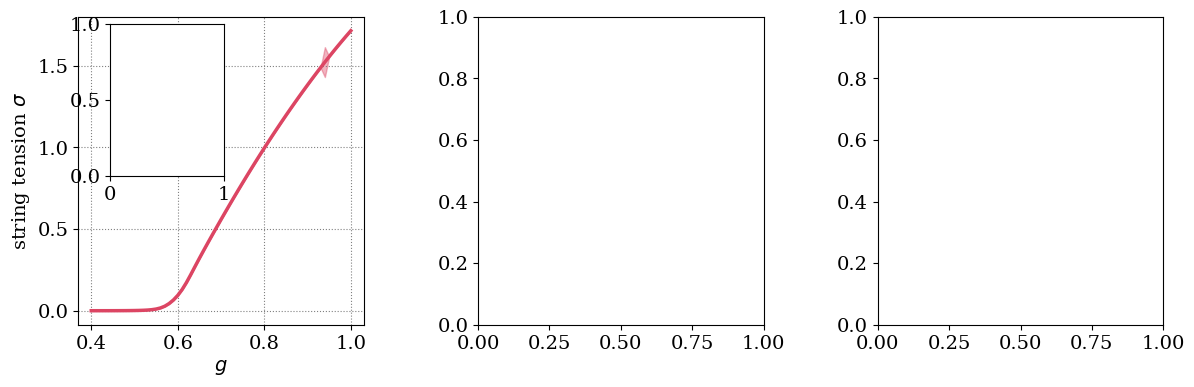

In [62]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4), gridspec_kw={'wspace':0.4})

for i, ax in enumerate(axs):
    # ax.set_aspect('equal')
    if i == 0:
        string_tension_g_plot(ax)
    elif i == 1:
        luscher_g_plot(ax, xs_max=xs_max)
    elif i == 2:
        rri_plot(ax)

fig.savefig(f"{path_figures}/figures/fluxtube/sigma_gamma_potential_static.pdf", bbox_inches='tight', format='pdf')

### Load and save cells

In [ ]:
l, L, R = 6, 30, 15
chi = 128


l, L, R = 5, 50, 20
chi = 128

cx = get_cx(L,R)
cy = get_cy(l,bc=bc,R=R)

h_i, h_f, npoints = 0.4, 0.6, 21
interval = np.linspace(h_i,h_f,npoints)
try:
    vac = None
    ev_1 = np.load(
        f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_vacuum_sector_bc_{bc}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
    )
except:
    vac = np.nan
    ev_1 = np.load(
        f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_vacuum_sector_bc_{bc}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
    )
ep_1 = np.load(
        f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
    )

h_i, h_f, npoints = 0.6, 0.9, 31
interval = np.linspace(h_i,h_f,npoints)
try:
    vac = None
    ev_2 = np.load(
        f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_vacuum_sector_bc_{bc}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
    )
except:
    vac = np.nan
    ev_2 = np.load(
        f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_vacuum_sector_bc_{bc}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
    )
ep_2 = np.load(
        f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
    )

h_i, h_f, npoints = 0.9, 1.0, 11
interval = np.linspace(h_i,h_f,npoints)
try:
    vac = None
    ev_3 = np.load(
        f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_vacuum_sector_bc_{bc}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
    )
except:
    vac = np.nan
    ev_3 = np.load(
        f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_vacuum_sector_bc_{bc}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
    )
ep_3 = np.load(
        f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
    )

h_i, h_f, npoints = 0.4, 1.0, 61
ev = np.array(ev_1.tolist() + ev_2[1:].tolist() + ev_3[1:].tolist()).flatten()
ep = np.array(ep_1.tolist() + ep_2[1:].tolist() + ep_3[1:].tolist()).flatten()
print(ev.shape, ep.shape)
np.save(f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_vacuum_sector_bc_{bc}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy", ev)
np.save(f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy", ep)


(61,) (61,)


In [ ]:
f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"

'/Users/fradm/Desktop/projects/1_Z2/results/energy_data/energy_Z2_dual_direct_lattice_6x30_2_particle(s)_sector_bc_pbc_[6, 24]-[0, 0]_h_0.4-1.0_delta_61_chi_64.npy'

In [1106]:
l, L, R = 5, 50, 25
chi = 128

cx = get_cx(L,R)
cy = get_cy(l,bc=bc,R=R)
cy = [0,0]

h_i, h_f, npoints = 0.81, 0.84, 2
interval = np.linspace(h_i,h_f,npoints)
ep_2 = np.load(
        f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
    )

h_i, h_f, npoints = 0.82, 0.83, 2
interval = np.linspace(h_i,h_f,npoints)
ep_3 = np.load(
        f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
    )

h_i, h_f, npoints = 0.81, 0.84, 4
interval = np.linspace(h_i,h_f,npoints)
try:
    vac = None
    ev_2 = np.load(
        f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_vacuum_sector_bc_{bc}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
    )
except:
    vac = np.nan
    ev_2 = np.load(
        f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_vacuum_sector_bc_{bc}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
    )

h_i, h_f, npoints = 0.8, 1.0, 5
interval = np.linspace(h_i,h_f,npoints)
try:
    vac = None
    ev_1 = np.load(
        f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_vacuum_sector_bc_{bc}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
    )
except:
    vac = np.nan
    ev_1 = np.load(
        f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_vacuum_sector_bc_{bc}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
    )
ep_1 = np.load(
        f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
    )

h_i, h_f, npoints = 0.86, 0.89, 4
interval = np.linspace(h_i,h_f,npoints)
try:
    vac = None
    ev_3 = np.load(
        f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_vacuum_sector_bc_{bc}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
    )
except:
    vac = np.nan
    ev_3 = np.load(
        f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_vacuum_sector_bc_{bc}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
    )
ep_4 = np.load(
        f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
    )


h_i, h_f, npoints = 0.91, 0.94, 4
interval = np.linspace(h_i,h_f,npoints)
try:
    vac = None
    ev_4 = np.load(
        f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_vacuum_sector_bc_{bc}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
    )
except:
    vac = np.nan
    ev_4 = np.load(
        f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_vacuum_sector_bc_{bc}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
    )
ep_5 = np.load(
        f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
    )

h_i, h_f, npoints = 0.96, 0.99, 4
interval = np.linspace(h_i,h_f,npoints)
try:
    vac = None
    ev_5 = np.load(
        f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_vacuum_sector_bc_{bc}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
    )
except:
    vac = np.nan
    ev_5 = np.load(
        f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_vacuum_sector_bc_{bc}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
    )
ep_6 = np.load(
        f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy"
    )

h_i, h_f, npoints = 0.8, 1.0, 21
ev = np.array([ev_1[0]] + ev_2.tolist() + [ev_1[1]] + ev_3.tolist() + [ev_1[2]] + ev_4.tolist() + [ev_1[3]] + ev_5.tolist() + [ev_1[4]]).flatten()
ep = np.array([ep_1[0]] + [ep_2[0]] + ep_3.tolist() + [ep_2[-1]] + [ep_1[1]] + ep_4.tolist() + [ep_1[2]] + ep_5.tolist() + [ep_1[3]] + ep_6.tolist() + [ep_1[4]]).flatten()
print(ev.shape, ep.shape)
print(ep)
np.save(f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_vacuum_sector_bc_{bc}_{vac}-{vac}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy", ev)
np.save(f"{path}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy", ep)


(21,) (21,)
[-440.54453059 -442.28082594 -444.14493802 -446.12972886 -448.22860802
 -450.43548645 -452.74473562 -455.15115128 -457.64992005 -460.23658865
 -462.90703325 -465.65742737 -468.48420748 -471.3840343  -474.35375107
 -477.39034164 -480.49089247 -483.65256465 -486.87257866 -490.14821254
 -493.47680988]


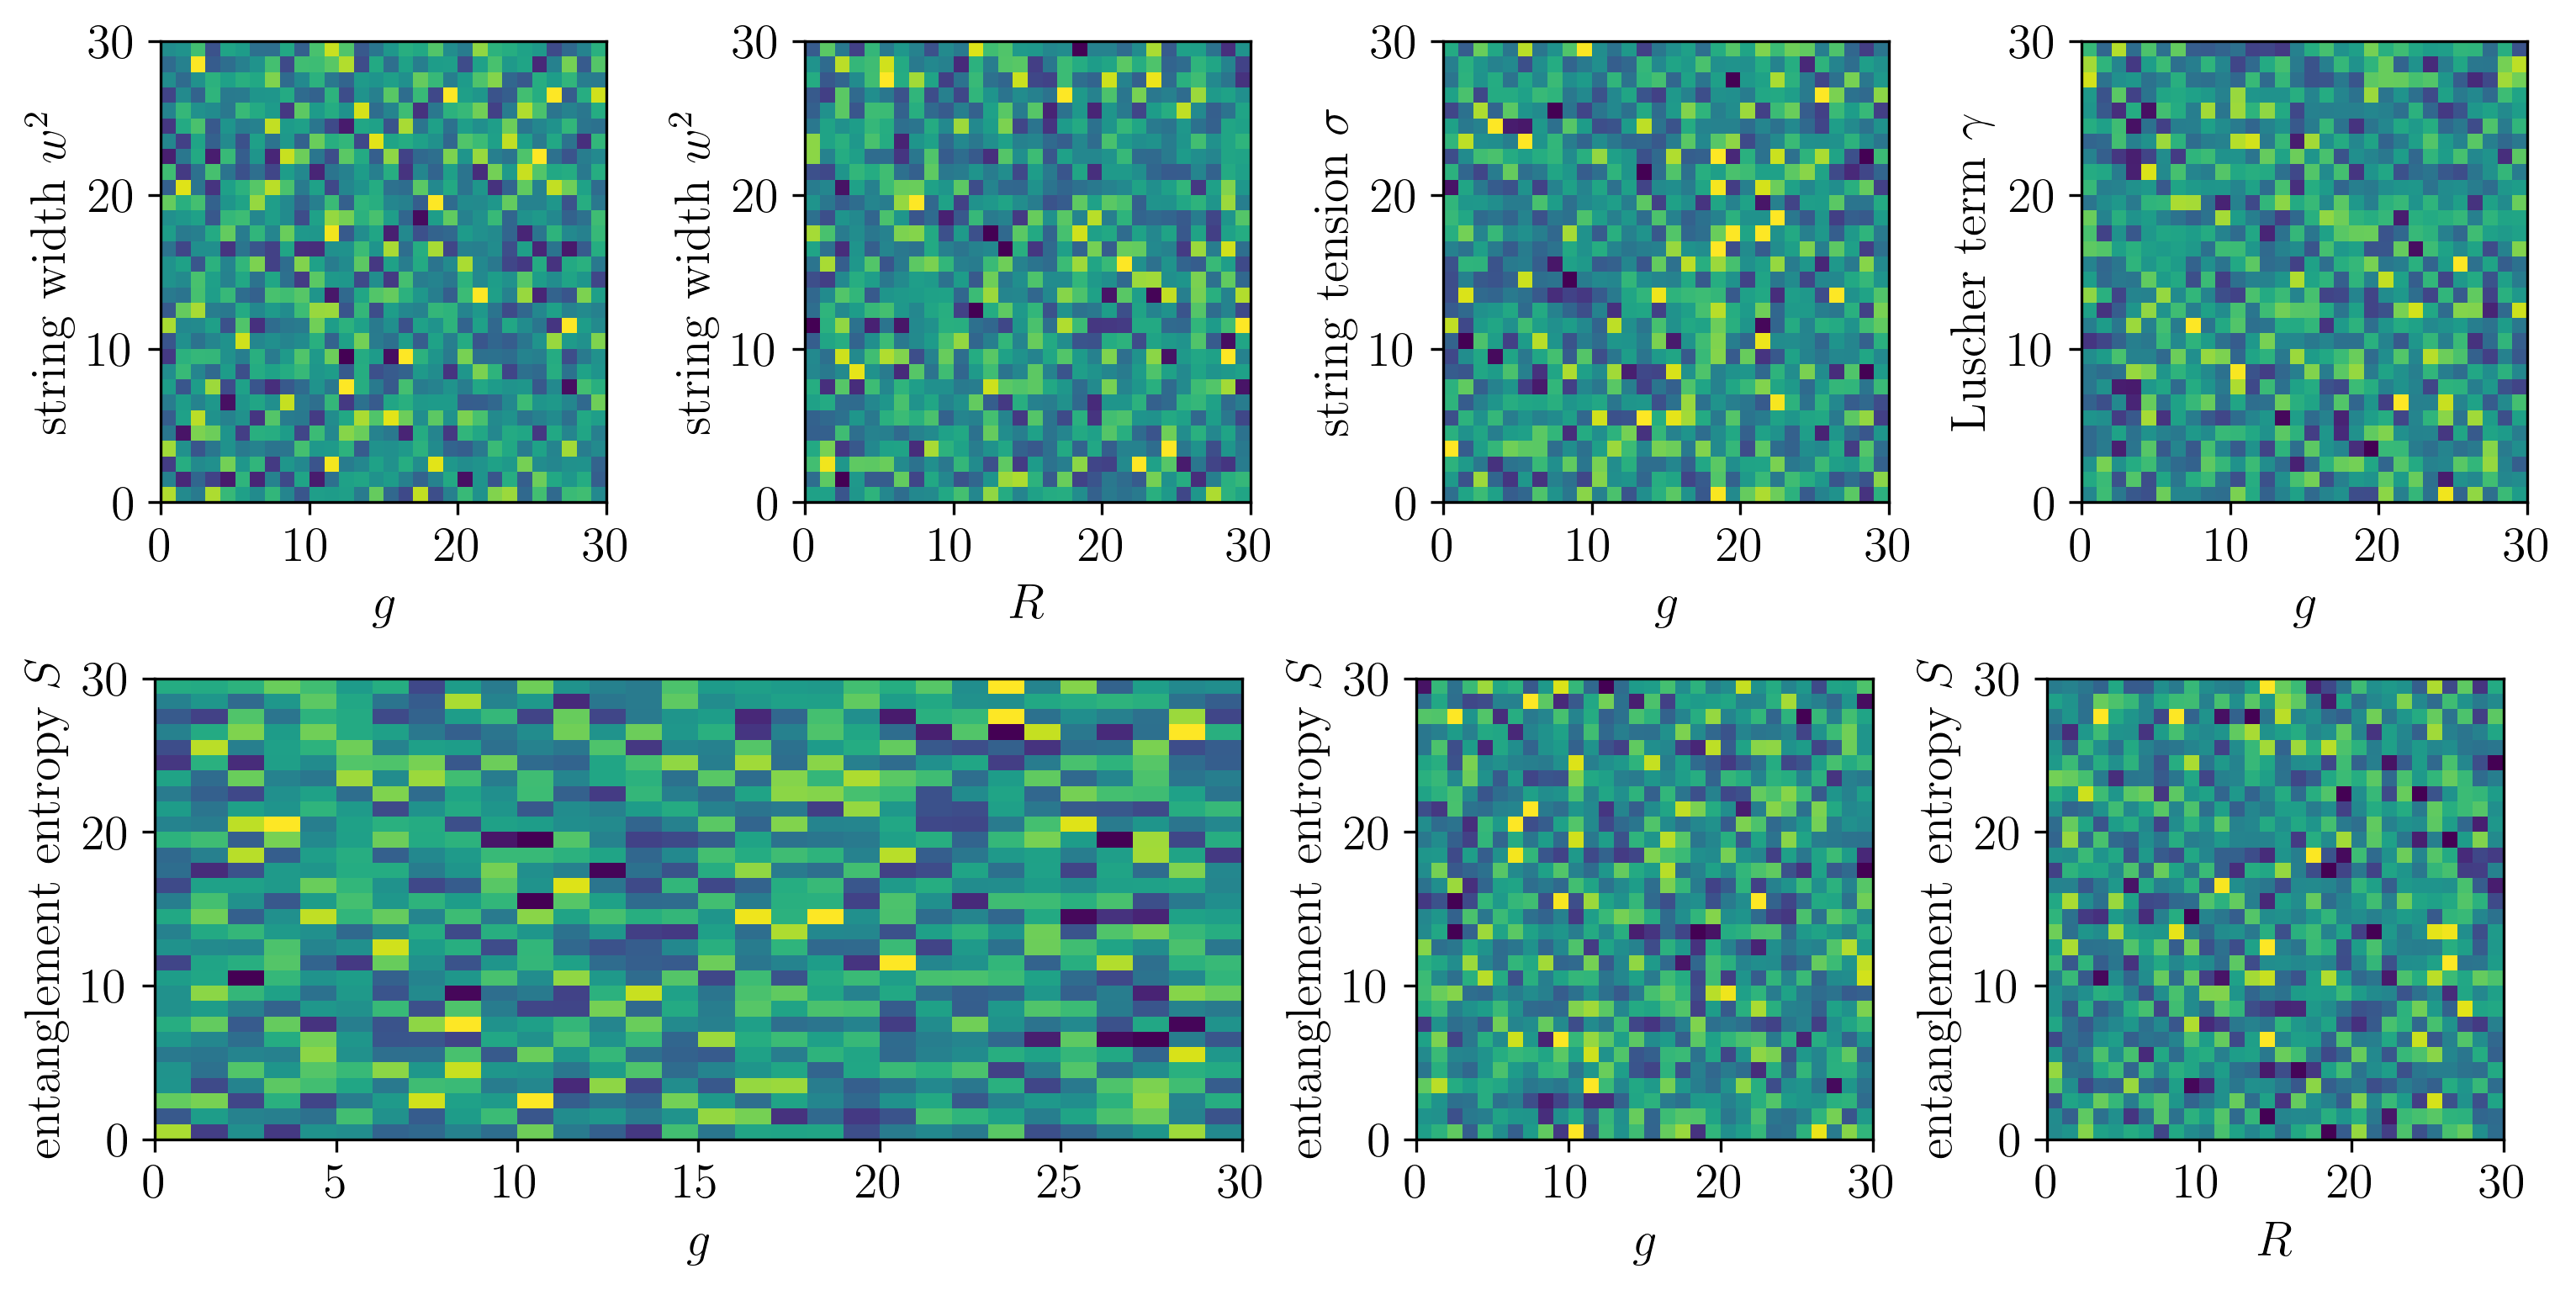

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def example_plot(ax):
    pc = ax.pcolormesh(np.random.randn(30, 30), vmin=-2.5, vmax=2.5)
    return pc

np.random.seed(19680808)

fig = plt.figure(layout="constrained", figsize=(10, 5))

# Split the figure into two subfigures (top and bottom)
subfigs = fig.subfigures(2, 1, height_ratios=[1, 1])

# --- Top row with 4 subplots and spacing ---
axsUp = subfigs[0].subplots(1, 4, gridspec_kw={'wspace': 0.1})  # Correct spacing here
for i, ax in enumerate(axsUp):
    pc = example_plot(ax)
    ax.set_xlabel(r'$R$' if i == 1 else r'$g$')
    if i < 2:
        ax.set_ylabel('string width $w^2$')
    elif i == 2:
        ax.set_ylabel('string tension $\\sigma$')
    else:
        ax.set_ylabel('Luscher term $\\gamma$')

# --- Bottom row with 3 subplots: 1 + (1+1) ---
subfigsnest = subfigs[1].subfigures(1, 2, wspace=0)  # No wspace here

# Left subplot
axsDownLeft = subfigsnest[0].subplots(1)
example_plot(axsDownLeft)
axsDownLeft.set_xlabel(r'$g$')
axsDownLeft.set_ylabel('entanglement entropy $S$')

fig_kw={'figsize':(5,2.5)}

# Right two subplots with spacing
axsDownRight = subfigsnest[1].subplots(1, 2, gridspec_kw={'wspace': 0.0, 'hspace':2})  # Correct spacing here
for nn, ax in enumerate(axsDownRight):
    example_plot(ax)
    ax.set_xlabel(r'$g$' if nn == 0 else r'$R$')
    ax.set_ylabel('entanglement entropy $S$')

plt.show()


Bbox(x0=0.125, y0=0.10999999999999999, x1=0.3529411764705882, y1=0.88)
Bbox(x0=0.3985294117647059, y0=0.10999999999999999, x1=0.6264705882352941, y1=0.88)
Bbox(x0=0.6720588235294118, y0=0.10999999999999999, x1=0.9, y1=0.88)


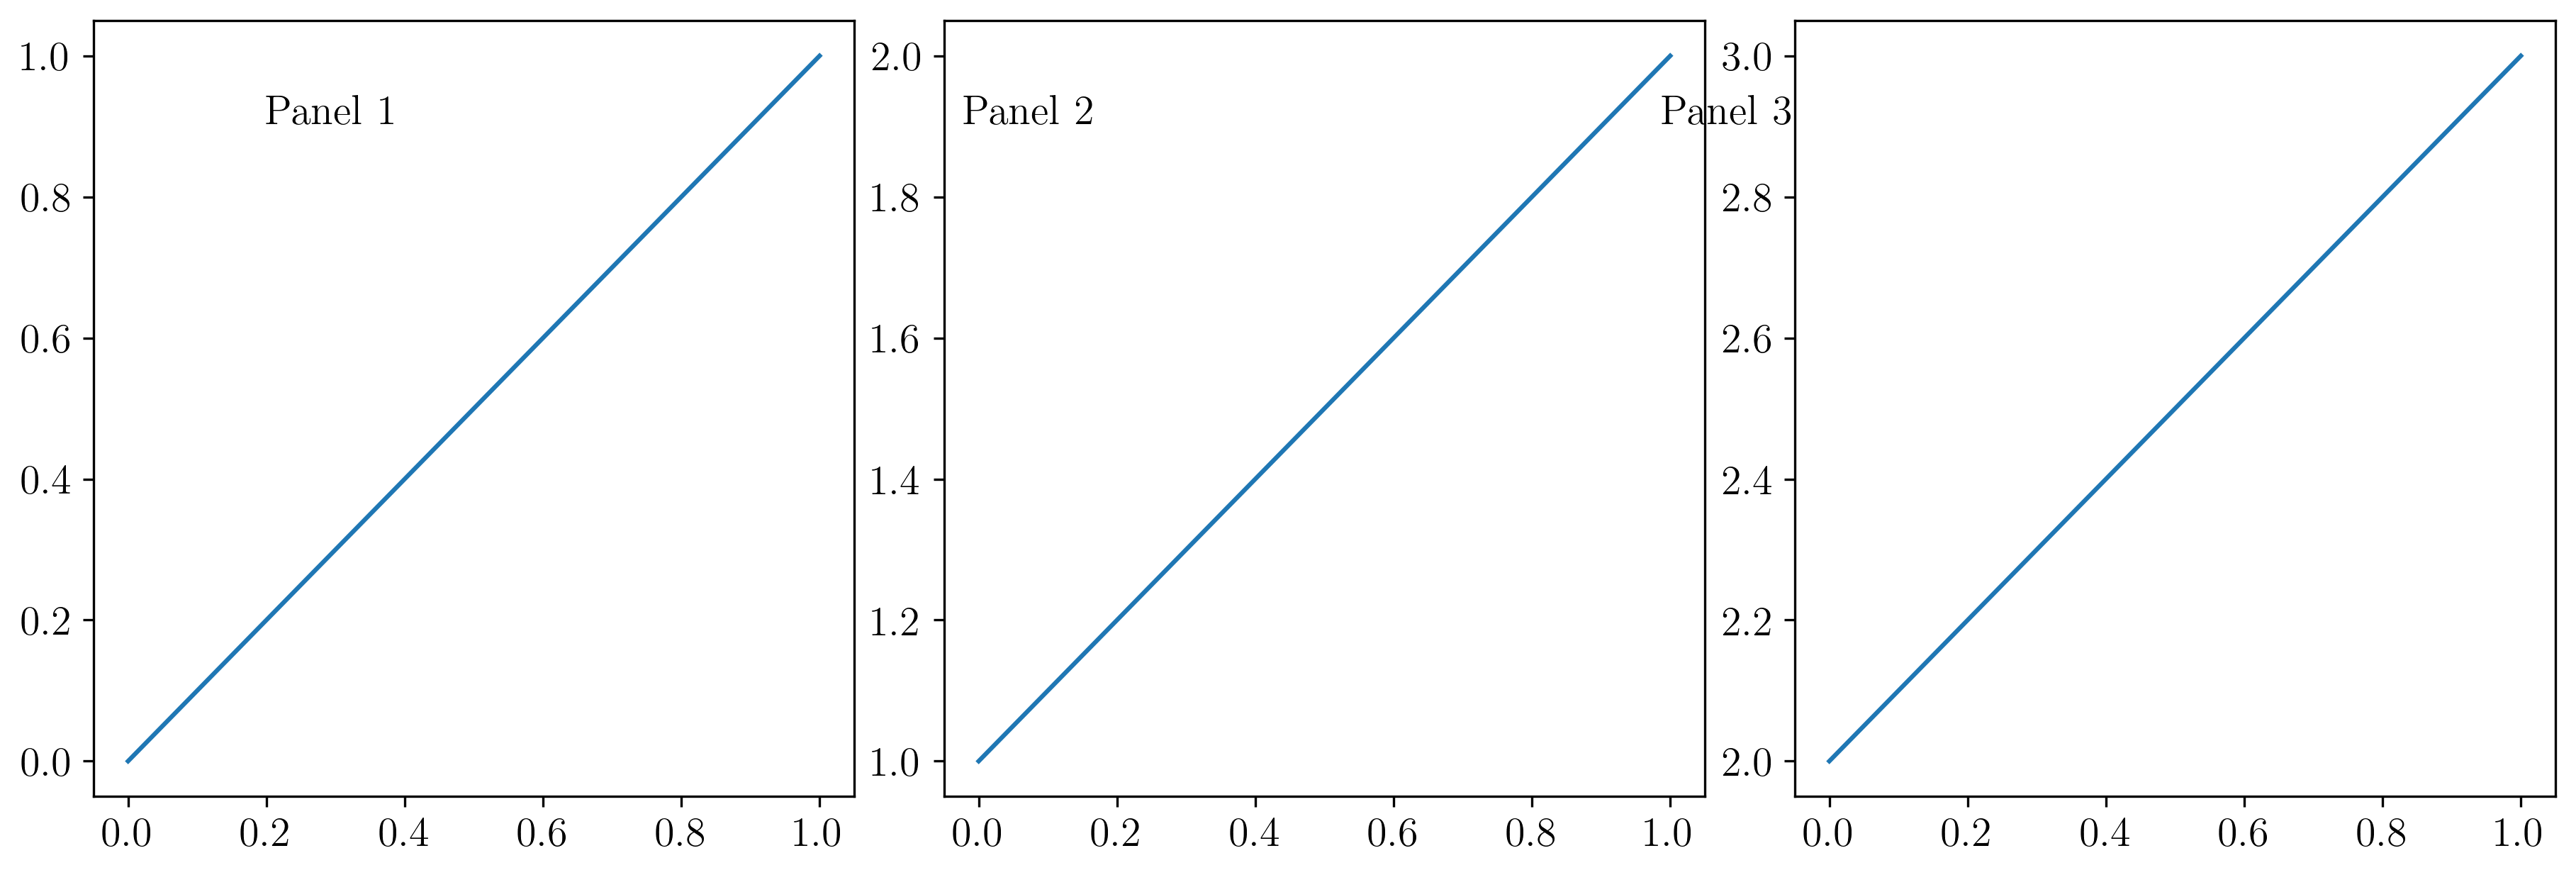

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(12, 4), layout="constrained")

for i, ax in enumerate(axs):
    ax.plot([0, 1], [i, i + 1])  # dummy data

    # Get the position of the axis in figure coordinates
    bbox = ax.get_position()
    print(bbox)
    # Place text just above the top-left corner of the axis
    fig.text(bbox.x0, bbox.y1, f'Panel {i+1}', ha='center', va='center')
    # ↑ you can increase 0.01 if you want more spacing

plt.show()

[    1.05023664 -1042.68721645   -45.0922342 ]


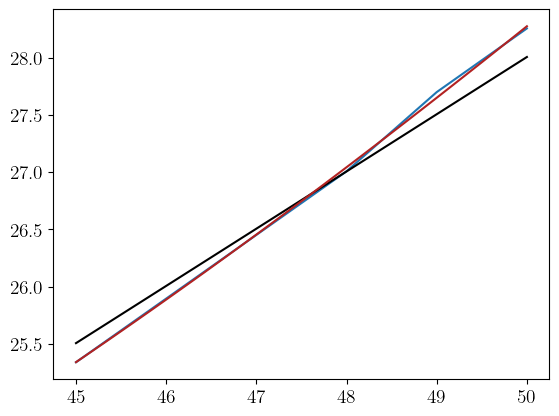

In [105]:
from qs_mps.applications.Z2.relevant_observables import potential_fit_1
Rs = [45,46,47,48,49,50]
pot = np.array([25.33835436, 25.89444941, 26.4505374 , 27.00662145, 27.69825089, 28.25432415])
plt.plot(Rs, pot)
x = np.linspace(45,50)
plt.plot(x, potential_fit_1(x, 1/2, -0.24, +3), color='k')

popt, pcov = curve_fit(potential_fit_1, Rs, pot)

plt.plot(x, potential_fit_1(x, *popt), color='firebrick')
print(popt)

## Error section

### Statics

In [2]:
def string_width_g_R_plot(ax):
    ax.grid(color="gray", linestyle=":")

    Rs = [15,16,17,18,19,20]
    colors = create_sequential_colors(len(Rs))
    h_i, h_f, npoints = 0.4, 1.0, 61
    gs = np.linspace(h_i, h_f, npoints)
    chis = [64,128]
    N, L = 6, 30

    Rs = [19]
    colors = create_sequential_colors(len(Rs))
    h_i, h_f, npoints = 0.6, 0.95, 15
    gs = np.linspace(h_i, h_f, npoints)
    chis = [128,256]
    N, L = 6, 30

    # String width vs coupling
    i = 0
    xs_max = []
    for R in Rs:
        string_width, err = string_width_varying_g(gs, R, N, L, chis, bc, sector, h_i, h_f, npoints, path, occupation=True)
        # ax.plot(gs, string_width, color=colors[i], label=f"$R = {R}$", linewidth=1)
        ax.plot(gs, np.asarray(err)/np.asarray(string_width))
        print(np.max(np.asarray(err)/np.asarray(string_width)))
        i += 1

    ax.legend()
    ax.set_xlabel(r"$g$", fontsize=14)
    ax.set_ylabel("string width $w^2$", fontsize=14)
    theor_gc = 1 / np.sqrt(3.04438)
    # ax.vlines(theor_gc, 0.2, 3.5, 'grey', ':', linewidth=2)
    # ax.set_ylim(top=1.1)
    # ax.set_xlim(left=0.8)
    # ax.set_xlim(0.6,0.8)
    # ax.set_ylim(0.8,3.2)
    # ax.set_xticks(ticks=[0.4,0.6,0.8,1.0], labels=[0.4,0.6,0.8,1.0])
    # ax.set_yticks(ticks=[1,2,3], labels=[1,2,3])
    # ax.text(0.4, 3.9, "$\\bf{(a)}$")
    ax.set_title("(a)", loc='left', fontsize=14)
    return xs_max

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
0.00046874665479337916
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0,

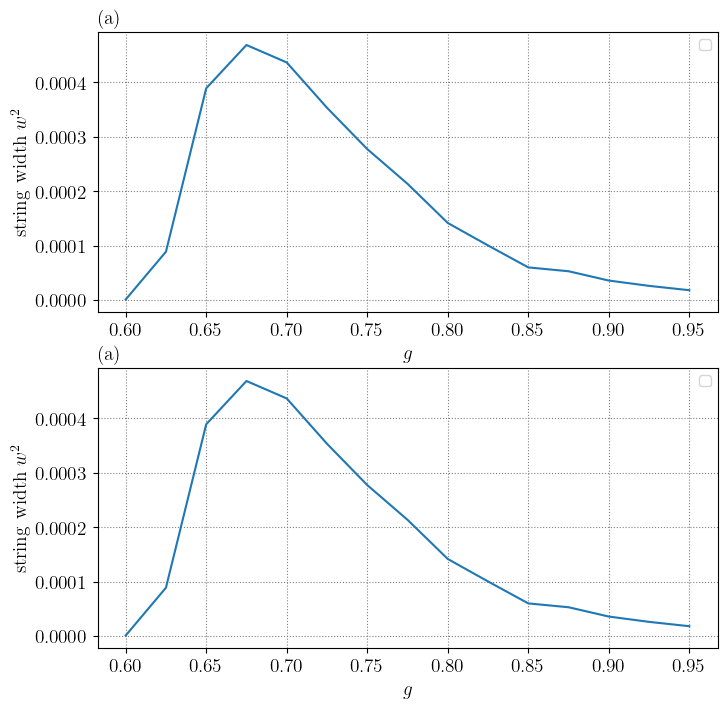

In [3]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'wspace':0.2})

for i, ax in enumerate(axs):
    if i == 0:
        xs_max = string_width_g_R_plot(ax)
    elif i == 1:
        xs_max = string_width_g_R_plot(ax)

# fig.savefig(f"{path_figures}/figures/fluxtube/w_and_ee_static_share_axis.pdf", bbox_inches='tight', format='pdf')

In [ ]:
def ee_bond_dim_6x30_plot(ax):
    ax.grid(color="gray", linestyle=":")
    R = 20
    chi = 128
    N, L = 6, 30
    color = "#DC4563"
    npoints, h_i, h_f = 31, 0.6, 0.9
    gs = np.linspace(h_i,h_f,npoints)

    s_pbc = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)
    ax.plot(gs[20:],s_pbc[20:], color=color, linewidth=1, alpha=0.5, linestyle='-', label=f"$\\chi = {chi}$")

    npoints, h_i, h_f = 11, 0.9, 1.0
    gs = np.linspace(h_i,h_f,npoints)

    s_pbc = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)
    ax.plot(gs[:3],s_pbc[:3], color=color, linewidth=1, alpha=0.5, linestyle='-')


    npoints, h_i, h_f = 2, 0.8, 0.85 
    chi = 256
    gs = np.linspace(h_i,h_f,npoints)
    s_pbc = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)
    ax.plot(gs,s_pbc, color=color, linewidth=1, marker='1', linestyle='', markersize=12, mew=1.5, alpha=0.7, label=f"$\\chi = {chi}$")

    npoints, h_i, h_f = 4, 0.81, 0.84 
    chi = 256
    gs = np.linspace(h_i,h_f,npoints)
    s_pbc = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)
    ax.plot(gs,s_pbc, color=color, linewidth=1, marker='1', linestyle='', markersize=12, mew=1.5, alpha=0.7)

    npoints, h_i, h_f = 4, 0.86, 0.89 
    chi = 256
    gs = np.linspace(h_i,h_f,npoints)
    s_pbc = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)
    ax.plot(gs,s_pbc, color=color, linewidth=1, marker='1', linestyle='', markersize=12, mew=1.5, alpha=0.7)

    npoints, h_i, h_f = 1, 0.9, 0.9 
    chi = 256
    gs = np.linspace(h_i,h_f,npoints)
    s_pbc = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)
    ax.plot(gs,s_pbc, color=color, linewidth=1, marker='1', linestyle='', markersize=12, mew=1.5, alpha=0.7)

    npoints, h_i, h_f = 2, 0.91, 0.92
    chi = 256
    gs = np.linspace(h_i,h_f,npoints)
    s_pbc = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)
    ax.plot(gs,s_pbc, color=color, linewidth=1, marker='1', linestyle='', markersize=12, mew=1.5, alpha=0.7)

    npoints, h_i, h_f = 1, 0.8, 0.8
    chi = 512
    gs = np.linspace(h_i,h_f,npoints)
    s_pbc = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)
    ax.plot(gs,s_pbc, color=color, linewidth=1, marker='2', linestyle='', markersize=10, mew=2, label=f"$\\chi = {chi}$")

    npoints, h_i, h_f = 1, 0.85, 0.85
    chi = 512
    gs = np.linspace(h_i,h_f,npoints)
    s_pbc = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)
    ax.plot(gs,s_pbc, color=color, linewidth=1, marker='2', linestyle='', markersize=10, mew=2)

    # npoints, h_i, h_f = 1, 0.75, 0.75
    # chi = 512
    # gs = np.linspace(h_i,h_f,npoints)
    # s_pbc = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)
    # ax.plot(gs,s_pbc, color=color, linewidth=1, marker='3', linestyle='', markersize=10)

    # npoints, h_i, h_f = 1, 0.7, 0.7
    # chi = 512
    # gs = np.linspace(h_i,h_f,npoints)
    # s_pbc = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)
    # ax.plot(gs,s_pbc, color=color, linewidth=1, marker='3', linestyle='', markersize=10)

    npoints, h_i, h_f = 1, 0.9, 0.9
    chi = 512
    gs = np.linspace(h_i,h_f,npoints)
    s_pbc = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)
    ax.plot(gs,s_pbc, color=color, linewidth=1, marker='2', linestyle='', markersize=10, mew=2)

    ax.text(x=0.905, y=0.565, s=f"$\\bf{{{N} \\times {L}}}$", color=color)
    ax.text(x=0.904, y=0.551, s=f"$\\bf{{R={R}}}$")
    ax.set_xlabel(r"$g$")
    ax.set_ylabel("entanglement entropy $S$", fontsize=14)
    ax.legend(fontsize=12)


def ee_bond_dim_4x70_plot(ax):
    ax.grid(color="gray", linestyle=":")
    R = 50
    chis = [64,96,128,192]
    npoints, h_i, h_f = 9, 0.6, 1.0
    gs = np.linspace(h_i,h_f,npoints)
    N, L = 4, 70
    color = "#4688CE"
    for j, chi in enumerate(chis):
        s_pbc = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)
        ax.plot(gs,s_pbc, color=color, linewidth=1.5, alpha=0.4+0.2*j, linestyle='-', label=f"$\\chi = {chi}$")

    ax.text(x=0.955, y=0.62, s=f"$\\bf{{{N} \\times {L}}}$", color=color)
    ax.text(x=0.952, y=0.55, s=f"$\\bf{{R={R}}}$")
    ax.set_xlabel(r"$g$")
    ax.set_ylabel("entanglement entropy $S$", fontsize=14)
    ax.legend(fontsize=12)

def ee_bond_dim_6x30_plot(ax):
    ax.grid(color="gray", linestyle=":")
    R = 50
    chi = 100
    N, L = 6, 70
    color = "#DC4563"
    npoints, h_i, h_f = 16, 0.6, 1.0
    gs = np.linspace(h_i,h_f,npoints)

    s_pbc = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)
    ax.plot(gs,s_pbc, color=color, linewidth=1, alpha=0.5, linestyle='-', label=f"$\\chi = {chi}$")

    chi = 200
    s_pbc = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)
    ax.plot(gs,s_pbc, color=color, linewidth=1, alpha=0.5, linestyle='-')


    npoints, h_i, h_f = 2, 0.8, 0.85 
    chi = 300
    gs = np.linspace(h_i,h_f,npoints)
    s_pbc = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)
    ax.plot(gs,s_pbc, color=color, linewidth=1, marker='1', linestyle='', markersize=12, mew=1.5, alpha=0.7, label=f"$\\chi = {chi}$")

    npoints, h_i, h_f = 4, 0.81, 0.84 
    chi = 256
    gs = np.linspace(h_i,h_f,npoints)
    s_pbc = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)
    ax.plot(gs,s_pbc, color=color, linewidth=1, marker='1', linestyle='', markersize=12, mew=1.5, alpha=0.7)

    npoints, h_i, h_f = 4, 0.86, 0.89 
    chi = 256
    gs = np.linspace(h_i,h_f,npoints)
    s_pbc = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)
    ax.plot(gs,s_pbc, color=color, linewidth=1, marker='1', linestyle='', markersize=12, mew=1.5, alpha=0.7)

    npoints, h_i, h_f = 1, 0.9, 0.9 
    chi = 256
    gs = np.linspace(h_i,h_f,npoints)
    s_pbc = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)
    ax.plot(gs,s_pbc, color=color, linewidth=1, marker='1', linestyle='', markersize=12, mew=1.5, alpha=0.7)

    npoints, h_i, h_f = 2, 0.91, 0.92
    chi = 256
    gs = np.linspace(h_i,h_f,npoints)
    s_pbc = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)
    ax.plot(gs,s_pbc, color=color, linewidth=1, marker='1', linestyle='', markersize=12, mew=1.5, alpha=0.7)

    npoints, h_i, h_f = 1, 0.8, 0.8
    chi = 512
    gs = np.linspace(h_i,h_f,npoints)
    s_pbc = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)
    ax.plot(gs,s_pbc, color=color, linewidth=1, marker='2', linestyle='', markersize=10, mew=2, label=f"$\\chi = {chi}$")

    npoints, h_i, h_f = 1, 0.85, 0.85
    chi = 512
    gs = np.linspace(h_i,h_f,npoints)
    s_pbc = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)
    ax.plot(gs,s_pbc, color=color, linewidth=1, marker='2', linestyle='', markersize=10, mew=2)

    # npoints, h_i, h_f = 1, 0.75, 0.75
    # chi = 512
    # gs = np.linspace(h_i,h_f,npoints)
    # s_pbc = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)
    # ax.plot(gs,s_pbc, color=color, linewidth=1, marker='3', linestyle='', markersize=10)

    # npoints, h_i, h_f = 1, 0.7, 0.7
    # chi = 512
    # gs = np.linspace(h_i,h_f,npoints)
    # s_pbc = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)
    # ax.plot(gs,s_pbc, color=color, linewidth=1, marker='3', linestyle='', markersize=10)

    npoints, h_i, h_f = 1, 0.9, 0.9
    chi = 512
    gs = np.linspace(h_i,h_f,npoints)
    s_pbc = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)
    ax.plot(gs,s_pbc, color=color, linewidth=1, marker='2', linestyle='', markersize=10, mew=2)

    ax.text(x=0.905, y=0.565, s=f"$\\bf{{{N} \\times {L}}}$", color=color)
    ax.text(x=0.904, y=0.551, s=f"$\\bf{{R={R}}}$")
    ax.set_xlabel(r"$g$")
    ax.set_ylabel("entanglement entropy $S$", fontsize=14)
    ax.legend(fontsize=12)

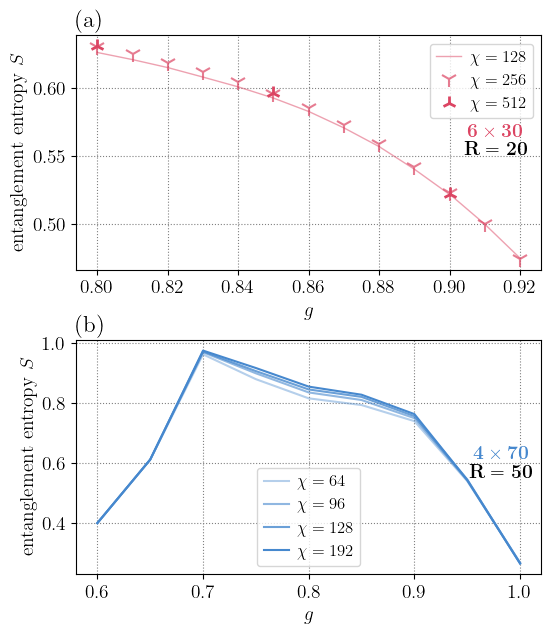

In [148]:
fig, axs = plt.subplots(2, 1, figsize=(6, 7), gridspec_kw={'hspace':0.3})

for i, ax in enumerate(axs):
    if i == 0:
        xs_max = ee_bond_dim_6x30_plot(ax)
        ax.set_title("(a)", loc='left')
    elif i == 1:
        xs_max = ee_bond_dim_4x70_plot(ax)
        ax.set_title("(b)", loc='left')

fig.savefig(f"{path_figures}/figures/fluxtube/ee_bond_dim.pdf", bbox_inches='tight', format='pdf')

In [75]:
def gamma_diff_R(params, ax, color, markersize=3, marker='d', zorder=None, label=True):
    h_i = params.get('h_i')
    h_f = params.get('h_f')
    npoints = params.get('npoints')
    chis = params.get('chis')
    Rs = params.get('Rs')
    N = params.get('N')
    L = params.get('L')
    idx_lim = params.get('idx_lim')
    Rs_copy = Rs.copy()
    gs = np.linspace(h_i,h_f,npoints)
    cx = None
    cy = None
    obs, obs_err = fit_params_sys(Rs,N,L,chis,bc,sector,h_i,h_f,npoints,path,cx,cy,param=1,fit=1)
    Rs = Rs_copy
    if label:
        label = f"$R \\in [{Rs[0]},{Rs[-1]}], \\; {N} \\times {L}$"
    ax.plot(gs[idx_lim:],-np.asarray(obs)[idx_lim:], markersize=markersize, color=color, marker=marker, linewidth=1, fillstyle=None, mew=0.5, mfc='w', label=label, zorder=zorder)
    if (N == 5 and L == 50) or (N == 4 and L == 70) or (N == 6 and L == 70):
        ax.errorbar(gs[idx_lim:], -np.asarray(obs)[idx_lim:], np.asarray(obs_err)[idx_lim:], capsize=5, color=color, zorder=zorder-1)
    else:
        ax.fill_between(gs[idx_lim:], -np.asarray(obs)[idx_lim:]+np.asarray(obs_err)[idx_lim:], -np.asarray(obs)[idx_lim:]-np.asarray(obs_err)[idx_lim:], color=color, alpha=0.4, zorder=zorder-1)

def cft_entr(R, a,b):
    return a*np.log2(R) + b

def cc_diff_R(params, ax, color, markersize=3, marker='d', zorder=None, label=True):
    h_i = params.get('h_i')
    h_f = params.get('h_f')
    npoints = params.get('npoints')
    chis = params.get('chis')
    Rs = params.get('Rs')
    N = params.get('N')
    L = params.get('L')
    idx_lim = params.get('idx_lim')
    gs = np.linspace(h_i,h_f,npoints)

    cc = []
    cc_err = []
    entr_g = []
    entr_g_err = []
    x_data = Rs
    for i, R in enumerate(Rs):
        entr_g_chi = []
        for chi in chis:
            s = entropy(R,N,L,chi,bc,sector,h_i,h_f,npoints,path)
            entr_g_chi.append(s)
        entr_g.append(entr_g_chi[-1])
        if len(chis) > 1:
            entr_g_err.append(np.abs(np.asarray(entr_g_chi[-2]) - np.asarray(entr_g_chi[-1])))
        else:
            entr_g_err = None

    entr_g = np.array(entr_g).T
    entr_g_err = np.array(entr_g_err).T
    for i, g in enumerate(gs):
        y_data = entr_g[i]
        popt, copt = curve_fit(cft_entr, x_data, y_data, sigma=entr_g_err[i])
        err = np.sqrt(np.diag(copt))
        cc.append(popt[0]*6)
        cc_err.append(err[0]*6)
        print(f"g: {g:.3f}", f"c: {popt[0]*6:.6f}", f"err: {err[0]*6:.6f}")
    
    if label:
        label = f"$R \\in [{Rs[0]},{Rs[-1]}], \\; {N} \\times {L}$"
    ax.plot(gs[idx_lim:],np.asarray(cc)[idx_lim:], markersize=markersize, color=color, marker=marker, fillstyle=None, mew=0.5, mfc='w', label=label, zorder=zorder)
    if (N == 5 and L == 50) or (N == 4 and L == 70) or (N == 6 and L == 70):
        ax.errorbar(gs[idx_lim:], np.asarray(cc)[idx_lim:], np.asarray(cc_err)[idx_lim:], capsize=5, color=color, zorder=zorder-1)
    else:
        ax.fill_between(gs[idx_lim:], np.asarray(cc)[idx_lim:]+np.asarray(cc_err)[idx_lim:], np.asarray(cc)[idx_lim:]-np.asarray(cc_err)[idx_lim:], color=color, alpha=0.4, zorder=zorder-1)


def pot_diff_plot(ax):
    fit = 1
    param = 0
    ax.grid(color="gray", linestyle=":", alpha=0.6)

    euclidean = True
    manhatten = False

    l = 5
    L = 50
    h_i, h_f, npoints = 0.8, 1.0, 5
    gs = np.linspace(h_i,h_f,npoints)
    chis = [64,128]
    Rs = [25,26,27,28,29,30]
    cx = None

    sigmas_on, sigmas_on_err, sigmas_on_ris, sigmas_on_ris_err, list_ris = fit_params_sys(Rs, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, ris=True)
    print(sigmas_on_ris, np.asarray(sigmas_on_ris).shape)
    Rs = [25,26,27,28,29,30]
    cx = None
    sigmas_off, sigmas_off_err, sigmas_off_ris, sigmas_off_ris_err, list_ris = fit_params_sys(Rs, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=True)
    print(sigmas_off_ris, np.asarray(sigmas_off_ris).shape)

    obs = np.array(sigmas_off) - np.array(sigmas_on)
    obs_err = np.array(sigmas_off_err) + np.array(sigmas_on_err)

    Rs = [25,26,27,28,29,30]

    ax.plot(gs[0:], obs[0:], markersize=3, color="firebrick", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$R \in [{Rs[0]},{Rs[-1]}]$")
    ax.fill_between(x=gs[0:], y1=obs[0:]-obs_err[0:], y2=obs[0:]+obs_err[0:], color="firebrick", alpha=0.4)

    l = 5
    L = 30
    h_i, h_f, npoints = 0.8, 1.0, 41
    gs = np.linspace(h_i,h_f,npoints)
    chis = [64,128]
    # Rs = [12,13,14,15,16,17,18,19,20]
    Rs = [15,16,17,18,19,20]

    sigmas_on, sigmas_on_err, sigmas_on_ris, sigmas_on_ris_err, list_ris = fit_params_sys(Rs, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, ris=True)
    print(sigmas_on_ris, np.asarray(sigmas_on_ris).shape)
    Rs = [15,16,17,18,19,20]
    cx = None
    sigmas_off, sigmas_off_err, sigmas_off_ris, sigmas_off_ris_err, list_ris = fit_params_sys(Rs, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=True)
    print(sigmas_off_ris, np.asarray(sigmas_off_ris).shape)

    obs = np.array(sigmas_off) - np.array(sigmas_on)
    obs_err = np.array(sigmas_off_err) + np.array(sigmas_on_err)

    Rs = [15,16,17,18,19,20]

    ax.plot(gs[0::2], obs[0::2], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$R \in [{Rs[0]},{Rs[-1]}]$")
    ax.fill_between(x=gs[0::2], y1=obs[0::2]-obs_err[0::2], y2=obs[0::2]+obs_err[0::2], color="teal", alpha=0.4)


    h_i, h_f, npoints = 0.8, 0.9, 11
    gs = np.linspace(h_i,h_f,npoints)
    chis = [128,256]
    idx = 0
    l, L = 6, 30
    cx = None
    Rs = [15,16,17,18,19,20]
    sigmas_on, sigmas_on_err = fit_params_sys(Rs, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit)
    cx = None
    Rs = [15,16,17,18,19,20]
    sigmas_off, sigmas_off_err = fit_params_sys(Rs, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten)

    obs = np.array(sigmas_off) - np.array(sigmas_on)
    obs_err = np.array(sigmas_off_err) + np.array(sigmas_on_err)

    Rs = [15,16,17,18,19,20]
    ax.plot(gs[idx:], obs[idx:], markersize=3, color="darkorchid", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$R \in [{Rs[0]},{Rs[-1]}]$")
    ax.fill_between(x=gs[idx:], y1=obs[idx:]-obs_err[idx:], y2=obs[idx:]+obs_err[idx:], color="darkorchid", alpha=0.4)
    ax.legend()

    ax.text(x=0.81, y=-0.00038, s="$\\bf{5 \\times 30 \\hspace{0.2cm} ; \\hspace{0.2cm} \\chi_{max}=128}$", color="teal")
    ax.text(x=0.81, y=-0.00048, s="$\\bf{5 \\times 50 \\hspace{0.2cm} ; \\hspace{0.2cm} \\chi_{max}=128}$", color="firebrick")
    ax.text(x=0.81, y=-0.00058, s="$\\bf{6 \\times 30 \\hspace{0.2cm} ; \\hspace{0.2cm} \\chi_{max}=256}$", color="darkorchid")
    ax.legend()

<>:101: SyntaxWarning: invalid escape sequence '\i'
<>:124: SyntaxWarning: invalid escape sequence '\i'
<>:144: SyntaxWarning: invalid escape sequence '\i'
<>:101: SyntaxWarning: invalid escape sequence '\i'
<>:124: SyntaxWarning: invalid escape sequence '\i'
<>:144: SyntaxWarning: invalid escape sequence '\i'
C:\Users\HP\AppData\Local\Temp\ipykernel_29292\1681850479.py:101: SyntaxWarning: invalid escape sequence '\i'
  ax.plot(gs[0:], obs[0:], markersize=3, color="firebrick", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$R \in [{Rs[0]},{Rs[-1]}]$")
C:\Users\HP\AppData\Local\Temp\ipykernel_29292\1681850479.py:124: SyntaxWarning: invalid escape sequence '\i'
  ax.plot(gs[0::2], obs[0::2], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$R \in [{Rs[0]},{Rs[-1]}]$")
C:\Users\HP\AppData\Local\Temp\ipykernel_29292\1681850479.py:144: SyntaxWarning: invalid escape sequence '\i'
  ax.plot(gs[idx:], obs[idx:], markersize=3, color="darkorchid", marker='

In [76]:
params_6_r = dict(
h_i = 0.6,
h_f = 0.9, 
npoints = 31,
chis = [64,128],
Rs = [12,14,16,18,20],
N = 6,
L = 30,
idx_lim = 3)

params_5_r = dict(
h_i = 0.6,
h_f = 0.9, 
npoints = 31,
chis = [32,64,128,256],
Rs = [7,8,9,10,11,13,15,17,19,21],
N = 5,
L = 30,
idx_lim = 7)

params_4_r = dict(
h_i = 0.6,
h_f = 0.9, 
npoints = 31,
chis = [64,128,256],
# Rs = [7,8,9,10,11,12,14,16,18,20,22],
# Rs = [7,8,9,10,11,12,14,16],
Rs = [12,14,16,18,20],
N = 4,
L = 30,
idx_lim = 12)

params_6_R = dict(
h_i = 0.7,
h_f = 1.0, 
npoints = 16,
chis = [100,200,300],
Rs = [45,46,47,48,49,50],
N = 6,
L = 70,
idx_lim = 0)

params_5_R = dict(
h_i = 0.8,
h_f = 1.0, 
npoints = 21,
chis = [64,128],
Rs = [25,26,27,28,29,30],
N = 5,
L = 50,
idx_lim = 0)

params_4_R = dict(
h_i = 0.74,
h_f = 1.0, 
npoints = 14,
chis = [96,128,192],
Rs = [45,46,47,48,49,50],
N = 4,
L = 70,
idx_lim = 0)

# params_4_R = dict(
# h_i = 0.6,
# h_f = 1.0, 
# npoints = 9,
# chis = [64,96,128],
# Rs = [30,35,40,45,50],
# N = 4,
# L = 70,
# idx_lim = 2)

[12, 14, 16, 18, 20]
Weighted Average: -1.469796551571279
Error in the Average: 0.58420596112371
Weighted Average: -1.202087964340318
Error in the Average: 0.5349029990452596
Weighted Average: -0.7280601339205794
Error in the Average: 0.4240345150207395
Weighted Average: -0.2527993909398954
Error in the Average: 0.3033023998977501
Weighted Average: 0.1528839473535093
Error in the Average: 0.2088402482058597
Weighted Average: 0.5006571186410054
Error in the Average: 0.14254496655973792
Weighted Average: 0.7941272691271138
Error in the Average: 0.08821736843734859
Weighted Average: 0.9975366376533018
Error in the Average: 0.03502945097532112
Weighted Average: 1.0628154462934454
Error in the Average: 0.015986718719641503
Weighted Average: 0.9845972772589447
Error in the Average: 0.03903331445370195
Weighted Average: 0.8214914807575004
Error in the Average: 0.03843634651653045
Weighted Average: 0.6514350307311867
Error in the Average: 0.025527682607159395
Weighted Average: 0.51929492781895

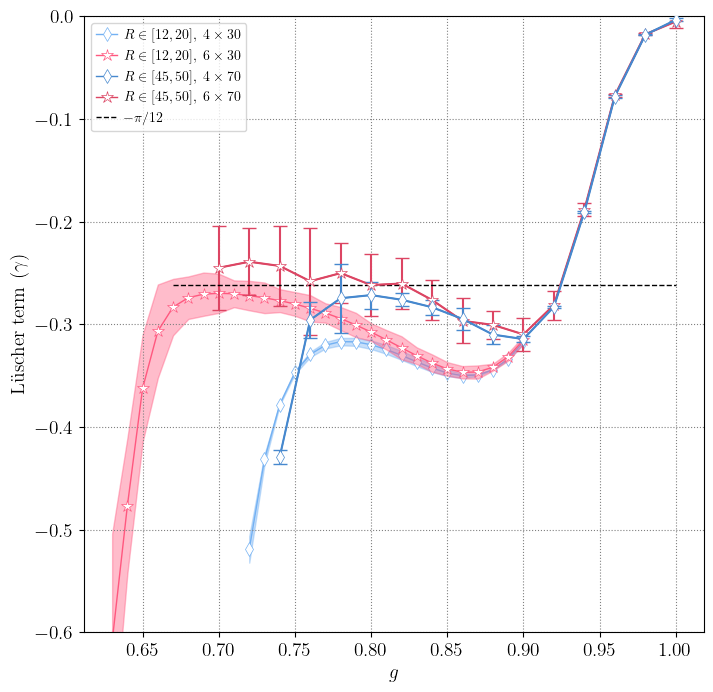

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8), gridspec_kw={'wspace':0.2})
ax.grid(color="gray", linestyle=":")

gamma_diff_R(params_4_r, ax, color="#73B1F3", marker='d', markersize=7, zorder=1)
# gamma_diff_R(params_5_r, ax, color="#D374F5", marker='P', markersize=8, zorder=2)
gamma_diff_R(params_6_r, ax, color="#FF587F", marker='*', markersize=9, zorder=2)

gamma_diff_R(params_4_R, ax, color="#4688CE", marker='d', markersize=7, zorder=4)
# gamma_diff_R(params_5_R, ax, color="#9B4DB7", marker='P', markersize=8, zorder=3)
gamma_diff_R(params_6_R, ax, color="#DC4563", marker='*', markersize=9, zorder=3)


ax.hlines(y=-2*np.pi/24, xmin=0.67, xmax=1, linestyles="--", colors='black', linewidth=1, label="$-\\pi/12$")
ax.set_ylim((-0.6,0))
# ax.set_xlim((0.675,0.94))
ax.set_xlabel(r"$g$")
ax.set_ylabel("Lüscher term $(\\gamma)$")
ax.legend()
fig.savefig(f"{path_figures}/figures/fluxtube/luscher_term_vs_different_Rs_{4,5,6}.png")

In [9]:
params_5_r = dict(
h_i = 0.6,
h_f = 0.9, 
npoints = 31,
chis = [32,64,128,256],
Rs = [7,8,9,11,13,15,17,19,21],
N = 5,
L = 30,
idx_lim = 0)

params_4_r = dict(
h_i = 0.6,
h_f = 0.9, 
npoints = 31,
chis = [64,128,256],
# Rs = [7,8,9,10,11,12,14,16,18,20,22],
Rs = [7,8,9,10,11,12,14,16],
N = 4,
L = 30,
idx_lim = 0)

params_5_R = dict(
h_i = 0.8,
h_f = 1.0, 
npoints = 5,
chis = [64,128],
Rs = [25,26,27,28,29,30],
N = 5,
L = 50,
idx_lim = 0)

params_5_R_1 = dict(
h_i = 0.7,
h_f = 0.79, 
npoints = 10,
chis = [64,128],
Rs = [25,26,27,28,29,30],
N = 5,
L = 50,
idx_lim = 0)

params_4_R = dict(
h_i = 0.6,
h_f = 1.0, 
npoints = 9,
chis = [64,96,128],
Rs = [30,35,40,45,50],
N = 4,
L = 70,
idx_lim = 0)

g: 0.600 c: 0.000454 err: 0.000089
g: 0.610 c: 0.001844 err: 0.000499
g: 0.620 c: 0.006518 err: 0.001985
g: 0.630 c: 0.021520 err: 0.007623
g: 0.640 c: 0.068740 err: 0.023935
g: 0.650 c: 0.208385 err: 0.051362
g: 0.660 c: 0.495606 err: 0.050375
g: 0.670 c: 0.768228 err: 0.059059
g: 0.680 c: 1.048739 err: 0.037841
g: 0.690 c: 1.282814 err: 0.006564
g: 0.700 c: 1.372110 err: 0.004547
g: 0.710 c: 1.376659 err: 0.013371
g: 0.720 c: 1.299205 err: 0.003655
g: 0.730 c: 1.227680 err: 0.009026
g: 0.740 c: 1.161806 err: 0.000851
g: 0.750 c: 1.121700 err: 0.000573
g: 0.760 c: 1.093224 err: 0.000055
g: 0.770 c: 1.078393 err: 0.000924
g: 0.780 c: 1.070873 err: 0.000830
g: 0.790 c: 1.071190 err: 0.001986
g: 0.800 c: 1.073984 err: 0.001066
g: 0.810 c: 1.079596 err: 0.001360
g: 0.820 c: 1.085869 err: 0.001680
g: 0.830 c: 1.086477 err: 0.002215
g: 0.840 c: 1.102561 err: 0.002489
g: 0.850 c: 1.114120 err: 0.000759
g: 0.860 c: 1.120091 err: 0.000516
g: 0.870 c: 1.121449 err: 0.001065
g: 0.880 c: 1.116103

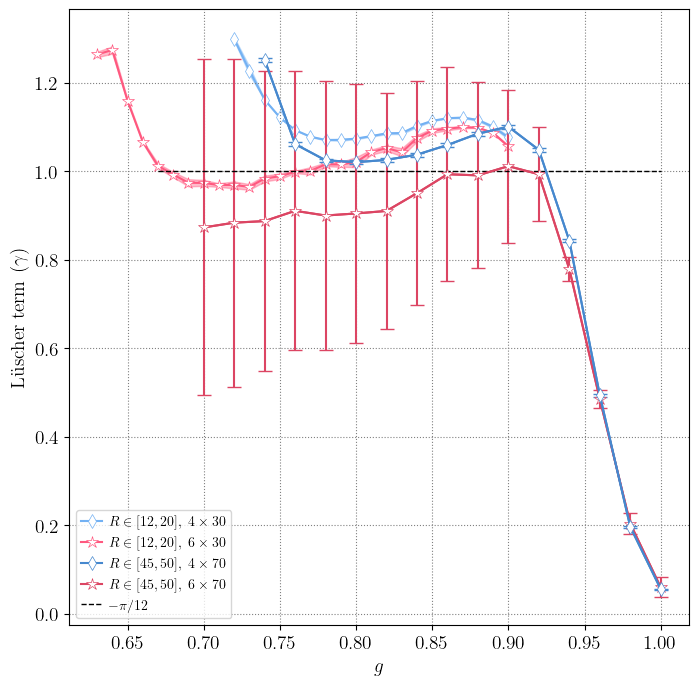

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8), gridspec_kw={'wspace':0.2})
ax.grid(color="gray", linestyle=":")

cc_diff_R(params_4_r, ax, color="#73B1F3", marker='d', markersize=7, zorder=1, label=True)
cc_diff_R(params_6_r, ax, color="#FF587F", marker='*', markersize=9, zorder=2, label=True)
# cc_diff_R(params_5_r, ax, color="#D374F5", marker='P', markersize=8, zorder=2, label=True)

# cc_diff_R(params_5_R, ax, color="#9B4DB7", marker='P', markersize=8, zorder=3, label=True)
# cc_diff_R(params_5_R_1, ax, color="#9B4DB7", marker='P', markersize=8, zorder=3, label=None)
cc_diff_R(params_4_R, ax, color="#4688CE", marker='d', markersize=7, zorder=4, label=True)
cc_diff_R(params_6_R, ax, color="#DC4563", marker='*', markersize=9, zorder=3, label=True)


ax.hlines(y=1, xmin=0.67, xmax=1, linestyles="--", colors='black', linewidth=1, label="$-\\pi/12$")
# ax.set_ylim((-0.6,0))
# ax.set_xlim(0.94))
ax.set_xlabel(r"$g$")

ax.set_ylabel("Lüscher term $(\\gamma)$")
ax.legend()
fig.savefig(f"{path_figures}/figures/fluxtube/central_charge_vs_different_Rs_{4,6}.png")

[7, 8, 9, 10, 11, 12, 14, 16]
[8, 9, 10, 11, 12, 14, 16]
[9, 10, 11, 12, 14, 16]
[10, 11, 12, 14, 16]
Weighted Average: -0.20745496647492004
Error in the Average: 0.04693964981715898
Weighted Average: -0.05558226230327939
Error in the Average: 0.04337470722304392
Weighted Average: 0.170618312816849
Error in the Average: 0.03478651410691563
Weighted Average: 0.40248680846090645
Error in the Average: 0.026397836804466397
Weighted Average: 0.6184924819851889
Error in the Average: 0.017398214484967117
Weighted Average: 0.7886087176840194
Error in the Average: 0.0068621260939979835
Weighted Average: 0.9194137929043308
Error in the Average: 0.0043922123854765105
Weighted Average: 0.9513058525020124
Error in the Average: 0.015479790177272888
Weighted Average: 0.883721930244669
Error in the Average: 0.021716764954900415
Weighted Average: 0.7680567860498507
Error in the Average: 0.020369906432352154
Weighted Average: 0.6444423491977436
Error in the Average: 0.01501596768693422
Weighted Average:

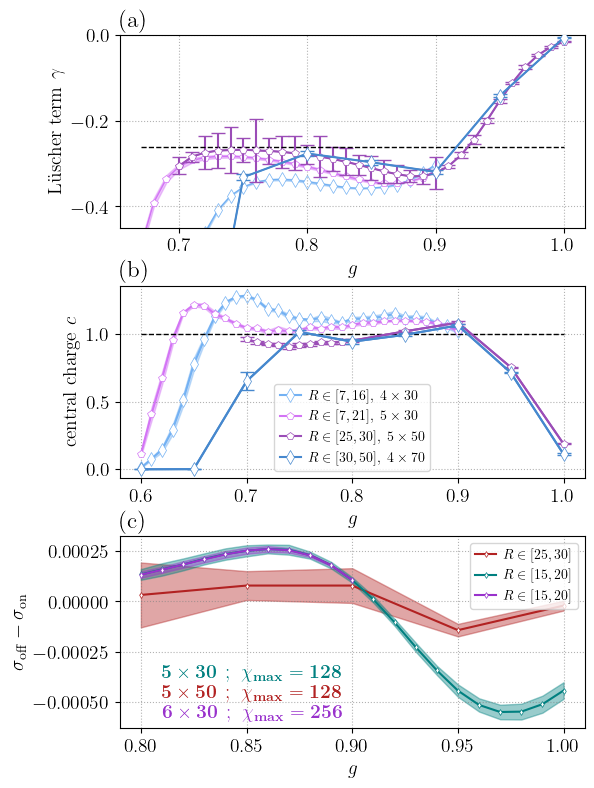

In [152]:
fig, axs = plt.subplots(3, 1, figsize=(6, 9), gridspec_kw={'hspace': 0.3})
axs[0].grid(color="gray", linestyle=":", alpha=0.6)


params_5_r = dict(
h_i = 0.6,
h_f = 0.9, 
npoints = 31,
chis = [32,64,128,256],
Rs = [7,8,9,10,11,13,15,17,19,21],
N = 5,
L = 30,
idx_lim = 7)

params_4_r = dict(
h_i = 0.6,
h_f = 0.9, 
npoints = 31,
chis = [64,128,256],
# Rs = [7,8,9,10,11,12,14,16,18,20,22],
Rs = [7,8,9,10,11,12,14,16],
N = 4,
L = 30,
idx_lim = 12)

params_5_R = dict(
h_i = 0.8,
h_f = 1.0, 
npoints = 21,
chis = [64,128],
Rs = [25,26,27,28,29,30],
N = 5,
L = 50,
idx_lim = 0)

params_5_R_1 = dict(
h_i = 0.7,
h_f = 0.79, 
npoints = 10,
chis = [64,128],
Rs = [25,26,27,28,29,30],
N = 5,
L = 50,
idx_lim = 0)

params_4_R = dict(
h_i = 0.6,
h_f = 1.0, 
npoints = 9,
chis = [64,96,128],
Rs = [30,35,40,45,50],
N = 4,
L = 70,
idx_lim = 2)

gamma_diff_R(params_4_r, axs[0], color="#73B1F3", marker='d', markersize=7, zorder=1)
gamma_diff_R(params_5_r, axs[0], color="#D374F5", marker='p', markersize=6, zorder=2)

gamma_diff_R(params_5_R, axs[0], color="#9B4DB7", marker='p', markersize=6, zorder=3)
gamma_diff_R(params_5_R_1, axs[0], color="#9B4DB7", marker='p', markersize=6, zorder=3, label=None)
gamma_diff_R(params_4_R, axs[0], color="#4688CE", marker='d', markersize=7, zorder=4)


axs[0].hlines(y=-2*np.pi/24, xmin=0.67, xmax=1, linestyles="--", colors='black', linewidth=1, label="$-\\pi/12$")
axs[0].set_ylim((-0.45,0))
# axs[0].set_xlim((0.675,0.94))
axs[0].set_xlabel(r"$g$")
axs[0].set_ylabel("Lüscher term $\\gamma$")
axs[0].set_title("(a)", loc='left')
# axs[0].legend()

params_5_r = dict(
h_i = 0.6,
h_f = 0.9, 
npoints = 31,
chis = [32,64,128,256],
Rs = [7,8,9,11,13,15,17,19,21],
N = 5,
L = 30,
idx_lim = 0)

params_4_r = dict(
h_i = 0.6,
h_f = 0.9, 
npoints = 31,
chis = [64,128,256],
# Rs = [7,8,9,10,11,12,14,16,18,20,22],
Rs = [7,8,9,10,11,12,14,16],
N = 4,
L = 30,
idx_lim = 0)

params_5_R = dict(
h_i = 0.8,
h_f = 1.0, 
npoints = 5,
chis = [64,128],
Rs = [25,26,27,28,29,30],
N = 5,
L = 50,
idx_lim = 0)

params_5_R_1 = dict(
h_i = 0.7,
h_f = 0.79, 
npoints = 10,
chis = [64,128],
Rs = [25,26,27,28,29,30],
N = 5,
L = 50,
idx_lim = 0)

params_4_R = dict(
h_i = 0.6,
h_f = 1.0, 
npoints = 9,
chis = [64,96,128],
Rs = [30,35,40,45,50],
N = 4,
L = 70,
idx_lim = 0)

axs[1].grid(color="gray", linestyle=":", alpha=0.6)

cc_diff_R(params_4_r, axs[1], color="#73B1F3", marker='d', markersize=7, zorder=1, label=True)
cc_diff_R(params_5_r, axs[1], color="#D374F5", marker='p', markersize=6, zorder=2, label=True)

cc_diff_R(params_5_R, axs[1], color="#9B4DB7", marker='p', markersize=6, zorder=3, label=True)
cc_diff_R(params_5_R_1, axs[1], color="#9B4DB7", marker='p', markersize=6, zorder=3, label=None)
cc_diff_R(params_4_R, axs[1], color="#4688CE", marker='d', markersize=7, zorder=4, label=True)


axs[1].hlines(y=1, xmin=0.6, xmax=1, linestyles="--", colors='black', linewidth=1)
# axs[1].set_ylim((-0.6,0))
# axs[1].set_xlim(0.94))
axs[1].set_xlabel(r"$g$")
axs[1].set_ylabel("central charge $c$")
axs[1].set_title("(b)", loc='left')
axs[1].legend()

pot_diff_plot(axs[2])
axs[2].set_xlabel(r"$g$")
axs[2].set_ylabel("$\\sigma_{\\mathrm{off}} - \\sigma_{\\mathrm{on}}$")
axs[2].set_title("(c)", loc='left')
axs[2].legend(loc='upper right')

fig.savefig(f"{path_figures}/figures/fluxtube/luscher_term_and_central_charge_vs_different_Rs.pdf", bbox_inches='tight', format='pdf')

### Dynamics

In [330]:
# deltas = [0.02,0.05]
# trotters = [500,200]

# l = 6
# chi = 256

# h_i = 0.75
# h_i = 0.725
# h_i = 0.7

def trotter_delta_w_plot(ax):
    deltas = [0.01,0.02,0.04,0.05]
    trotters = [400,200,100,80]

    l = 5
    chi = 128
    h_i = 0.8

    h_ev = h_i
    R = 20
    colors = create_sequential_colors(len(deltas))
    of = 0.2

    for i, delta in enumerate(deltas):
        steps = trotters[i]
        # ws_t = time_ev_string_width(h_ev,R,l,L,chi,bc,sector,h_i,h_ev,1,path_tensor=path_tensor,delta=delta,trotter=steps)
        ws_t = time_ev_string_width_occupation(R,l,L,chi,bc,sector,h_i,h_ev,1,path_tensor=path,delta=delta,trotter=steps, obs_freq=of)
        ax.plot(delta*np.arange((steps*of)+1), ws_t, marker='', markersize=5, color=colors[i], linestyle="-", linewidth=2, label=f"$\\delta t = {delta}$")

    ax_inset = inset_axes(ax, width="50%", height="40%", loc='lower right', bbox_to_anchor=(-0.08, 0.08, 1, 1.15), bbox_transform=ax.transAxes)
    inset_trotter_delta_w_plot(ax_inset)

def inset_trotter_delta_w_plot(ax):
    deltas = [0.01,0.02,0.04,0.05]
    trotters = [400,200,100,80]
    colors = create_sequential_colors(len(deltas))
    t = 0.2
    for i, delta in enumerate(deltas):
        steps = trotters[i]
        ws_t = time_ev_string_width_occupation(R,l,L,chi,bc,sector,h_i,h_ev,1,path_tensor=path,delta=delta,trotter=steps, obs_freq=of)
        ax.plot(delta*np.arange((steps*of)+1)[:int(t/delta+1)], ws_t[:int(t/delta+1)], marker='', markersize=5, color=colors[i], linestyle="-", linewidth=2)
        ax.set_facecolor((1,1,1,0.6))


def trotter_delta_ee_plot(ax):
    deltas = [0.01,0.02,0.04,0.05]
    trotters = [400,200,100,80]

    l = 5
    chi = 128
    h_i = 0.8

    h_ev = h_i
    R = 20
    colors = create_sequential_colors(len(deltas))
    of = 0.2

    for i, delta in enumerate(deltas):
        steps = trotters[i]
        # ws_t = time_ev_string_width(h_ev,R,l,L,chi,bc,sector,h_i,h_ev,1,path_tensor=path_tensor,delta=delta,trotter=steps)
        ws_t = time_entropy(R,l,L,chi,bc,sector,h_i,h_ev,path_tensor=path,delta=delta,trotter=steps)
        ax.plot(delta*np.arange((steps)+1), ws_t, marker='', markersize=5, color=colors[i], linestyle="-", linewidth=2, label=f"$\\delta t = {delta}$")

    ax_inset = inset_axes(ax, width="50%", height="40%", loc='lower right', bbox_to_anchor=(-0.08, 0.08, 1, 1.15), bbox_transform=ax.transAxes)
    inset_trotter_delta_ee_plot(ax_inset)

def inset_trotter_delta_ee_plot(ax):
    deltas = [0.01,0.02,0.04,0.05]
    trotters = [400,200,100,80]
    colors = create_sequential_colors(len(deltas))
    t = 0.2
    for i, delta in enumerate(deltas):
        steps = trotters[i]
        ws_t = time_entropy(R,l,L,chi,bc,sector,h_i,h_ev,path_tensor=path,delta=delta,trotter=steps)
        ws_t[0] = ws_t[1]
        ax.plot(delta*np.arange((steps)+1)[:int(t/delta+1)], ws_t[:int(t/delta+1)], marker='', markersize=5, color=colors[i], linestyle="-", linewidth=2)
        ax.set_facecolor((1,1,1,0.6))

[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]


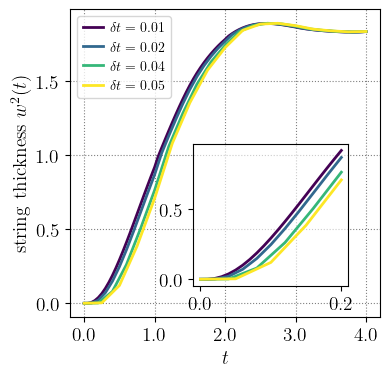

In [331]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

trotter_delta_w_plot(ax)
ax.grid(color="gray", linestyle=":")
ax.set_xlabel(r"$t$")
ax.set_ylabel("string thickness $w^2(t)$")
steps = 200
delta = 0.02
ax.set_xticks(ticks=(delta*np.arange(int((steps*of)+1)))[::int((steps*of+1)/4)], labels=delta*np.linspace(0,steps,int((steps*of)+1))[::int((steps*of+1)/4)])
ax.legend()
fig.savefig(f"{path_figures}/figures/error/trotter_delta_dynamics.pdf", bbox_inches='tight', format='pdf')

[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]


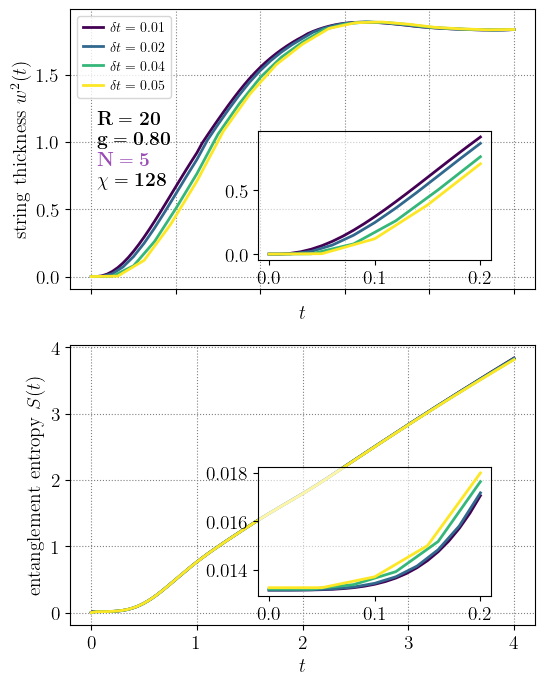

In [332]:
colors = ["#9B4DB7","#DC4563","#F34213"]
fig, axs = plt.subplots(2, 1, figsize=(6, 8), gridspec_kw={'hspace':0.2})

trotter_delta_w_plot(axs[0])
axs[0].grid(color="gray", linestyle=":")
axs[0].set_xlabel(r"$t$")
axs[0].set_ylabel("string thickness $w^2(t)$")

steps = 200
delta = 0.02
axs[0].set_xticks(ticks=(delta*np.arange(int((steps*of)+1)))[::int((steps*of+1)/5)], labels=['','','','','',''])
axs[0].text(0.05*of, 1.13, "$\\bf{R = 20}$")
axs[0].text(0.05*of, 0.98, "$\\bf{g = 0.80}$")
axs[0].text(0.05*of, 0.83, "$\\bf{N = 5}$", color=colors[0])
axs[0].text(0.05*of, 0.68, "$\\bf{\\chi = 128}$")
axs[0].legend()

trotter_delta_ee_plot(axs[1])
axs[1].grid(color="gray", linestyle=":")
axs[1].set_xlabel(r"$t$")
axs[1].set_ylabel("entanglement entropy $S(t)$")

# axs[1].legend()
fig.savefig(f"{path_figures}/figures/error/trotter_delta_dynamics.pdf", bbox_inches='tight', format='pdf')

In [333]:
def transversal_size_w_plot(ax):
    colors = ["#9B4DB7","#DC4563","#F34213"]

    h_i = 0.75
    h_ev = h_i
    R = 10
    chi = 128
    of = 0.2
    steps = 400
    delta = 0.01

    l = 5


    ws_t = time_ev_string_width_occupation(R,l,L,chi,bc,sector,h_i,h_ev,1,path_tensor=path,delta=delta,trotter=steps, obs_freq=of)
    ax.plot(delta*np.arange((steps*of)+1), ws_t, marker='1', markersize=5, color=colors[0], linestyle="-", linewidth=2, label=f"$N = {l}$")

    steps = 200
    delta = 0.05
    l = 7

    ws_t = time_ev_string_width_occupation(R,l,L,chi,bc,sector,h_i,h_ev,1,path_tensor=path,delta=delta,trotter=steps, obs_freq=of)
    ax.plot(delta*np.arange((steps*of)+1), ws_t, marker='2', markersize=5, color=colors[2], linestyle="-", linewidth=2, label=f"$N = {l}$")

def transversal_size_ee_plot(ax):
    colors = ["#9B4DB7","#DC4563","#F34213"]

    h_i = 0.75
    h_ev = h_i
    R = 10
    chi = 128
    of = 0.2
    steps = 400
    delta = 0.01

    l = 5

    ws_t = time_entropy(R,l,L,chi,bc,sector,h_i,h_ev,path_tensor=path,delta=delta,trotter=steps)
    ax.plot(delta*np.arange((steps)+1), ws_t, marker='', markersize=5, color=colors[0], linestyle="-", linewidth=2, label=f"$N = {l}$")

    steps = 200
    delta = 0.05
    l = 7

    ws_t = time_entropy(R,l,L,chi,bc,sector,h_i,h_ev,path_tensor=path,delta=delta,trotter=steps)
    ax.plot(delta*np.arange((steps)+1), ws_t, marker='', markersize=5, color=colors[2], linestyle="-", linewidth=2, label=f"$N = {l}$")

[-2, -1, 0, 1, 2]
[-3, -2, -1, 0, 1, 2, 3]


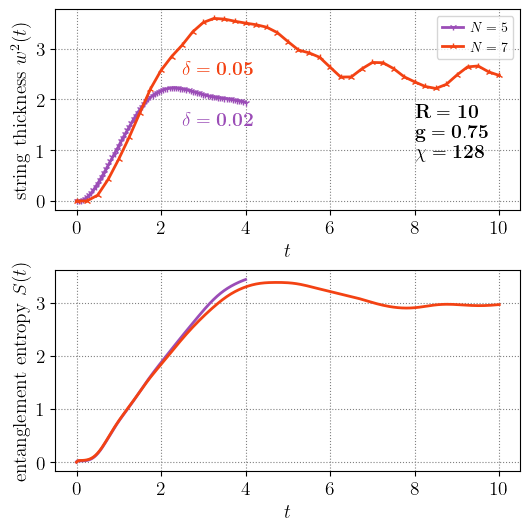

In [334]:
colors = ["#9B4DB7","#DC4563","#F34213"]
fig, axs = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'hspace':0.3})

transversal_size_w_plot(axs[0])
axs[0].grid(color="gray", linestyle=":")
axs[0].set_xlabel(r"$t$")
axs[0].set_ylabel("string thickness $w^2(t)$")

steps = 200
delta = 0.05
axs[0].set_xticks(ticks=(delta*np.arange(int((steps*of)+1)))[::int((steps*of+1)/5)], labels=[int(lab) for lab in delta*np.linspace(0,steps,int((steps*of)+1))[::int((steps*of+1)/5)]])
axs[0].text(8*of, 1.65, "$\\bf{R = 10}$")
axs[0].text(8*of, 1.25, "$\\bf{g = 0.75}$")
axs[0].text(8*of, 0.85, "$\\bf{\\chi = 128}$")
axs[0].text(2.5*of, 2.5, "$\\bf{\\delta = 0.05}$", color=colors[2])
axs[0].text(2.5*of, 1.5, "$\\bf{\\delta = 0.02}$",color=colors[0])
axs[0].legend()

transversal_size_ee_plot(axs[1])
axs[1].grid(color="gray", linestyle=":")
axs[1].set_xlabel(r"$t$")
axs[1].set_ylabel("entanglement entropy $S(t)$")

# axs[1].legend()
fig.savefig(f"{path_figures}/figures/error/transversal_size_dynamics.pdf", bbox_inches='tight', format='pdf')

In [335]:
def bond_dimension_w_plot(ax):
    colors = ["teal","firebrick"]

    l = 6
    h_i = 0.8
    h_ev = h_i
    R = 10
    delta = 0.05
    steps = 200
    chis = [128,256]

    for i, chi in enumerate(chis):
        ws_t = time_ev_string_width_occupation(R,l,L,chi,bc,sector,h_i,h_ev,1,path_tensor=path,delta=delta,trotter=steps, obs_freq=of)
        ax.plot(delta*np.arange((steps*of)+1), ws_t, marker='1', markersize=5, color=colors[i], linestyle="-", linewidth=2, label=f"$\\chi = {chi}$")

def bond_dimension_ee_plot(ax):
    colors = ["teal","firebrick"]

    l = 6
    h_i = 0.8
    h_ev = h_i
    R = 10
    delta = 0.05
    steps = 200
    chis = [128,256]

    for i, chi in enumerate(chis):
        ws_t = time_entropy(R,l,L,chi,bc,sector,h_i,h_ev,path_tensor=path,delta=delta,trotter=steps)
        ax.plot(delta*np.arange((steps)+1), ws_t, marker='', markersize=5, color=colors[i], linestyle="-", linewidth=2, label=f"$\\chi = {chi}$")


[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]


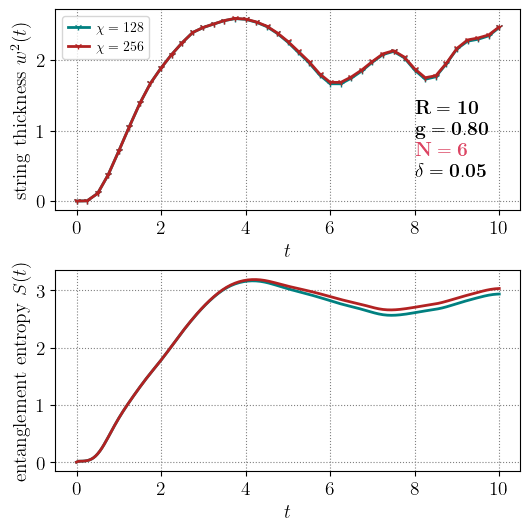

In [336]:
colors = ["#DC4563"]
fig, axs = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'hspace':0.3})

bond_dimension_w_plot(axs[0])
axs[0].grid(color="gray", linestyle=":")
axs[0].set_xlabel(r"$t$")
axs[0].set_ylabel("string thickness $w^2(t)$")

steps = 200
delta = 0.05
axs[0].set_xticks(ticks=(delta*np.arange(int((steps*of)+1)))[::int((steps*of+1)/5)], labels=[int(lab) for lab in delta*np.linspace(0,steps,int((steps*of)+1))[::int((steps*of+1)/5)]])
axs[0].text(8*of, 1.25, "$\\bf{R = 10}$")
axs[0].text(8*of, 0.95, "$\\bf{g = 0.80}$")
axs[0].text(8*of, 0.65, "$\\bf{N = 6}$", color=colors[0])
axs[0].text(8*of, 0.35, "$\\bf{\\delta = 0.05}$")
axs[0].legend()

bond_dimension_ee_plot(axs[1])
axs[1].grid(color="gray", linestyle=":")
axs[1].set_xlabel(r"$t$")
axs[1].set_ylabel("entanglement entropy $S(t)$")

# axs[1].legend()
fig.savefig(f"{path_figures}/figures/error/transversal_size_dynamics.pdf", bbox_inches='tight', format='pdf')

[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-3, -2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]


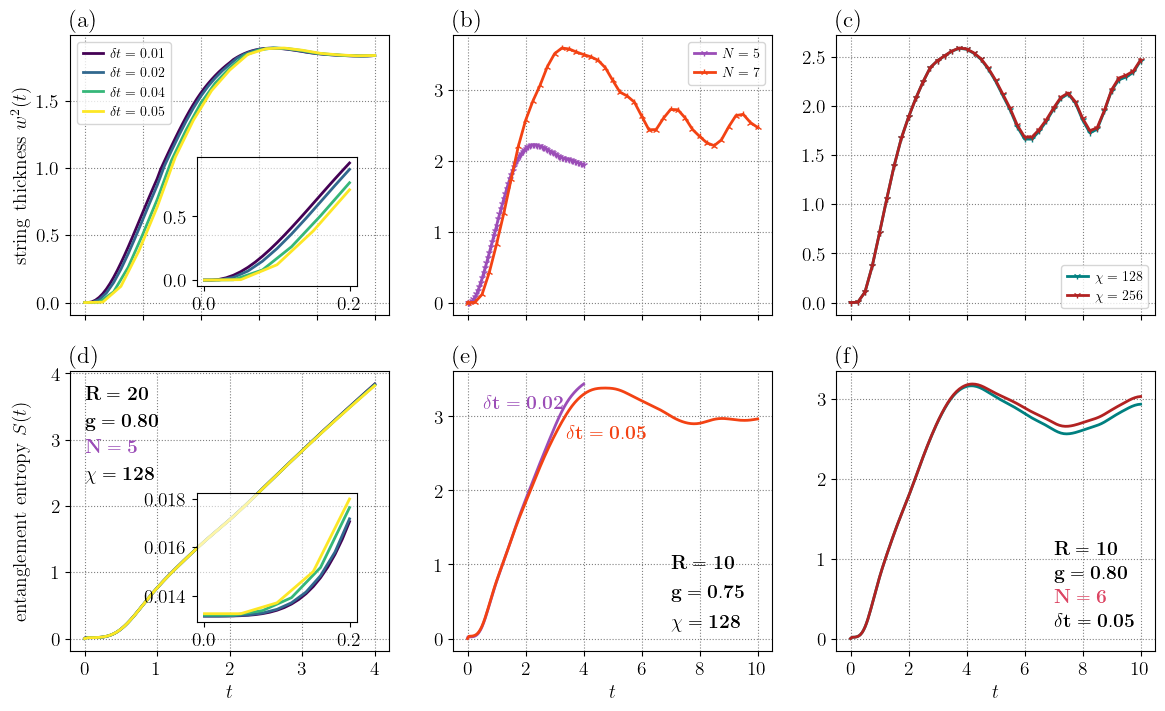

In [343]:
colors = ["#9B4DB7","#DC4563","#F34213"]
fig, axs = plt.subplots(2, 3, figsize=(14, 8), gridspec_kw={'hspace':0.2, 'wspace':0.2})

trotter_delta_w_plot(axs[0][0])
axs[0][0].grid(color="gray", linestyle=":")
# axs[0][0].set_xlabel(r"$t$")
axs[0][0].set_ylabel("string thickness $w^2(t)$")

steps = 200
delta = 0.02
axs[0][0].set_xticks(ticks=(delta*np.arange(int((steps*of)+1)))[::int((steps*of+1)/5)], labels=['','','','','',''])
axs[1][0].text(0.05*of, 3.6, "$\\bf{R = 20}$")
axs[1][0].text(0.05*of, 3.2, "$\\bf{g = 0.80}$")
axs[1][0].text(0.05*of, 2.8, "$\\bf{N = 5}$", color=colors[0])
axs[1][0].text(0.05*of, 2.4, "$\\bf{\\chi = 128}$")
axs[0][0].legend()

trotter_delta_ee_plot(axs[1][0])
axs[1][0].grid(color="gray", linestyle=":")
axs[1][0].set_xlabel(r"$t$")
axs[1][0].set_ylabel("entanglement entropy $S(t)$")

colors = ["#9B4DB7","#DC4563","#F34213"]

transversal_size_w_plot(axs[0][1])
axs[0][1].grid(color="gray", linestyle=":")
# axs[0][1].set_xlabel(r"$t$")
# axs[0][1].set_ylabel("string thickness $w^2(t)$")

steps = 200
delta = 0.05
axs[0][1].set_xticks(ticks=(delta*np.arange(int((steps*of)+1)))[::int((steps*of+1)/5)], labels=['','','','','',''])
# axs[0][1].set_xticks(ticks=(delta*np.arange(int((steps*of)+1)))[::int((steps*of+1)/5)], labels=[int(lab) for lab in delta*np.linspace(0,steps,int((steps*of)+1))[::int((steps*of+1)/5)]])
axs[1][1].text(35*of, 0.95, "$\\bf{R = 10}$")
axs[1][1].text(35*of, 0.55, "$\\bf{g = 0.75}$")
axs[1][1].text(35*of, 0.15, "$\\bf{\\chi = 128}$")
axs[1][1].text(17*of, 2.7, "$\\bf{\\delta t = 0.05}$", color=colors[2])
axs[1][1].text(2.6*of, 3.1, "$\\bf{\\delta t = 0.02}$",color=colors[0])
axs[0][1].legend()

transversal_size_ee_plot(axs[1][1])
axs[1][1].grid(color="gray", linestyle=":")
axs[1][1].set_xlabel(r"$t$")
axs[1][1].set_xticks(ticks=(delta*np.arange(int((steps)+1)))[::int((steps+1)/5)], labels=[int(lab) for lab in delta*np.linspace(0,steps,int((steps*of)+1))[::int((steps*of+1)/5)]])
# axs[1][1].set_ylabel("entanglement entropy $S(t)$")

colors = ["#DC4563"]

bond_dimension_w_plot(axs[0][2])
axs[0][2].grid(color="gray", linestyle=":")
# axs[0][2].set_xlabel(r"$t$")
# axs[0][2].set_ylabel("string thickness $w^2(t)$")

steps = 200
delta = 0.05
axs[0][2].set_xticks(ticks=(delta*np.arange(int((steps*of)+1)))[::int((steps*of+1)/5)], labels=['','','','','',''])
axs[1][2].text(35*of, 1.05, "$\\bf{R = 10}$")
axs[1][2].text(35*of, 0.75, "$\\bf{g = 0.80}$")
axs[1][2].text(35*of, 0.45, "$\\bf{N = 6}$", color=colors[0])
axs[1][2].text(35*of, 0.15, "$\\bf{\\delta t = 0.05}$")
axs[0][2].legend()

bond_dimension_ee_plot(axs[1][2])
axs[1][2].grid(color="gray", linestyle=":")
axs[1][2].set_xlabel(r"$t$")
axs[1][2].set_xticks(ticks=(delta*np.arange(int((steps)+1)))[::int((steps+1)/5)], labels=[int(lab) for lab in delta*np.linspace(0,steps,int((steps*of)+1))[::int((steps*of+1)/5)]])
# axs[1][2].set_ylabel("entanglement entropy $S(t)$")

for ax, title in zip(axs.flatten(), ['(a)','(b)','(c)','(d)','(e)','(f)']):
    ax.set_title(title, loc='left')
# axs[1].legend()
fig.align_labels()
fig.savefig(f"{path_figures}/figures/error/error_dynamics.pdf", bbox_inches='tight', format='pdf')
